In [1]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [2]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='DEU'
print(df_elec[country].head())

# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

# load offshore wind data
df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)

# load large scale pv data
df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
df_pv.index = pd.to_datetime(df_pv.index)

# load rooftop pv data
df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
df_rooftop.index = pd.to_datetime(df_rooftop.index)


<>:16: DeprecationWarning: invalid escape sequence '\p'
<>:20: DeprecationWarning: invalid escape sequence '\p'
<>:16: DeprecationWarning: invalid escape sequence '\p'
<>:20: DeprecationWarning: invalid escape sequence '\p'
C:\Users\alexk\AppData\Local\Temp\ipykernel_45968\597844512.py:16: DeprecationWarning: invalid escape sequence '\p'
  df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
C:\Users\alexk\AppData\Local\Temp\ipykernel_45968\597844512.py:20: DeprecationWarning: invalid escape sequence '\p'
  df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)


utc_time
2015-01-01 00:00:00+00:00    44546.0
2015-01-01 01:00:00+00:00    42967.0
2015-01-01 02:00:00+00:00    41582.0
2015-01-01 03:00:00+00:00    40964.0
2015-01-01 04:00:00+00:00    40247.0
Name: DEU, dtype: float64


In [3]:
colors = {"onshore": "blue", "offshore": "darkblue", "pv": "orange", 
          "rooftop": "yellow", "coal": "brown", "OCGT": "grey"}

# Make Network

In [4]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [5]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)

# add electricity bus
network.add("Bus",
            f"E_bus{country}")

# add load to the bus
network.add("Load",
            "load",
            bus=f"E_bus{country}",
            p_set=df_elec[country].values)

# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "offshorewind")
network.add("Carrier", "solarPV")
network.add("Carrier", "rooftopPV")

''' Add renewable generators '''
# Add onshore wind
CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 30 # years
discount_rate = 0.07 # 7%
capex = 910000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "onshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_onshore.values)

# Add offshore wind
CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 2506000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "offshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_offshore.values)

# Add large scale solar
CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 425000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "PV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="solarPV",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_pv,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# Add rooftop solar
CF_rooftop = df_rooftop[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 725000 # in €/MW
fopex = 0.02 # 2% of capex
capital_cost_rooftop = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "rooftopPV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="rooftopPV",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_rooftop,
            marginal_cost = 0,
            p_max_pu = CF_rooftop.values)

''' Add non-renewables generators '''
# add OCGT (Open Cycle Gas Turbine) generator
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 560000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            efficiency = efficiency,
            marginal_cost = marginal_cost_OCGT)

# add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 3294000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 4 # in €/MWh_th 
efficiency = 0.36 # MWh_elec/MWh_th
marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "coal",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=1000,
            capital_cost = capital_cost_coal,
            efficiency = efficiency,
            marginal_cost = marginal_cost_coal)



Index(['coal'], dtype='object')

In [6]:
network.optimize(solver_name='gurobi')

Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 17.73it/s]
INFO:linopy.io: Writing time: 0.74s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-570iz1_i.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-570iz1_i.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 113886 rows, 52566 columns, 201770 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201770 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


Model fingerprint: 0xe1aed75c


INFO:gurobipy:Model fingerprint: 0xe1aed75c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.817e+04


INFO:gurobipy: AA' NZ     : 8.817e+04


 Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


INFO:gurobipy:   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


INFO:gurobipy:   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


   3   1.61650436e+11 -2.01317169e+10  1.75e-10 3.22e-01  1.39e+06     0s


INFO:gurobipy:   3   1.61650436e+11 -2.01317169e+10  1.75e-10 3.22e-01  1.39e+06     0s


   4   9.92170059e+10  7.71370830e+09  1.16e-10 1.03e-01  6.96e+05     0s


INFO:gurobipy:   4   9.92170059e+10  7.71370830e+09  1.16e-10 1.03e-01  6.96e+05     0s


   5   6.13372975e+10  1.22646767e+10  1.57e-09 4.12e-02  3.73e+05     0s


INFO:gurobipy:   5   6.13372975e+10  1.22646767e+10  1.57e-09 4.12e-02  3.73e+05     0s


   6   4.89505730e+10  1.61827315e+10  1.75e-09 3.57e-02  2.49e+05     1s


INFO:gurobipy:   6   4.89505730e+10  1.61827315e+10  1.75e-09 3.57e-02  2.49e+05     1s


   7   4.10081204e+10  2.04457327e+10  4.83e-09 8.06e-03  1.56e+05     1s


INFO:gurobipy:   7   4.10081204e+10  2.04457327e+10  4.83e-09 8.06e-03  1.56e+05     1s


   8   4.00328497e+10  2.13247459e+10  7.60e-08 5.72e-03  1.42e+05     1s


INFO:gurobipy:   8   4.00328497e+10  2.13247459e+10  7.60e-08 5.72e-03  1.42e+05     1s


   9   3.35780868e+10  2.23124197e+10  3.95e-07 6.98e-10  8.53e+04     1s


INFO:gurobipy:   9   3.35780868e+10  2.23124197e+10  3.95e-07 6.98e-10  8.53e+04     1s


  10   2.89054547e+10  2.31739019e+10  5.01e-07 6.40e-10  4.34e+04     1s


INFO:gurobipy:  10   2.89054547e+10  2.31739019e+10  5.01e-07 6.40e-10  4.34e+04     1s


  11   2.72997183e+10  2.37155948e+10  4.34e-07 2.04e-09  2.72e+04     1s


INFO:gurobipy:  11   2.72997183e+10  2.37155948e+10  4.34e-07 2.04e-09  2.72e+04     1s


  12   2.64698707e+10  2.38954623e+10  8.56e-07 9.60e-10  1.95e+04     1s


INFO:gurobipy:  12   2.64698707e+10  2.38954623e+10  8.56e-07 9.60e-10  1.95e+04     1s


  13   2.60400183e+10  2.40809592e+10  6.69e-07 3.06e-09  1.48e+04     1s


INFO:gurobipy:  13   2.60400183e+10  2.40809592e+10  6.69e-07 3.06e-09  1.48e+04     1s


  14   2.56185089e+10  2.42866895e+10  1.43e-07 9.20e-10  1.01e+04     1s


INFO:gurobipy:  14   2.56185089e+10  2.42866895e+10  1.43e-07 9.20e-10  1.01e+04     1s


  15   2.53952983e+10  2.43933212e+10  8.11e-07 6.75e-10  7.59e+03     1s


INFO:gurobipy:  15   2.53952983e+10  2.43933212e+10  8.11e-07 6.75e-10  7.59e+03     1s


  16   2.52540136e+10  2.44516138e+10  1.10e-06 4.18e-10  6.08e+03     1s


INFO:gurobipy:  16   2.52540136e+10  2.44516138e+10  1.10e-06 4.18e-10  6.08e+03     1s


  17   2.51732394e+10  2.45291686e+10  1.33e-06 5.49e-10  4.88e+03     1s


INFO:gurobipy:  17   2.51732394e+10  2.45291686e+10  1.33e-06 5.49e-10  4.88e+03     1s


  18   2.51064244e+10  2.45564622e+10  1.16e-06 1.12e-09  4.17e+03     1s


INFO:gurobipy:  18   2.51064244e+10  2.45564622e+10  1.16e-06 1.12e-09  4.17e+03     1s


  19   2.50935885e+10  2.45808055e+10  4.43e-06 5.71e-10  3.88e+03     1s


INFO:gurobipy:  19   2.50935885e+10  2.45808055e+10  4.43e-06 5.71e-10  3.88e+03     1s


  20   2.49427907e+10  2.46488390e+10  1.19e-05 1.45e-10  2.23e+03     1s


INFO:gurobipy:  20   2.49427907e+10  2.46488390e+10  1.19e-05 1.45e-10  2.23e+03     1s


  21   2.48977521e+10  2.46683784e+10  9.10e-06 0.00e+00  1.74e+03     1s


INFO:gurobipy:  21   2.48977521e+10  2.46683784e+10  9.10e-06 0.00e+00  1.74e+03     1s


  22   2.48666247e+10  2.46767991e+10  7.22e-06 7.09e-10  1.44e+03     1s


INFO:gurobipy:  22   2.48666247e+10  2.46767991e+10  7.22e-06 7.09e-10  1.44e+03     1s


  23   2.48384775e+10  2.46958304e+10  5.70e-06 2.97e-10  1.08e+03     1s


INFO:gurobipy:  23   2.48384775e+10  2.46958304e+10  5.70e-06 2.97e-10  1.08e+03     1s


  24   2.48144917e+10  2.47080908e+10  4.44e-06 5.32e-10  8.07e+02     1s


INFO:gurobipy:  24   2.48144917e+10  2.47080908e+10  4.44e-06 5.32e-10  8.07e+02     1s


  25   2.48012289e+10  2.47128089e+10  3.38e-06 9.57e-10  6.70e+02     1s


INFO:gurobipy:  25   2.48012289e+10  2.47128089e+10  3.38e-06 9.57e-10  6.70e+02     1s


  26   2.47899205e+10  2.47231212e+10  2.54e-06 2.36e-10  5.06e+02     1s


INFO:gurobipy:  26   2.47899205e+10  2.47231212e+10  2.54e-06 2.36e-10  5.06e+02     1s


  27   2.47834090e+10  2.47255193e+10  2.07e-06 2.83e-10  4.39e+02     1s


INFO:gurobipy:  27   2.47834090e+10  2.47255193e+10  2.07e-06 2.83e-10  4.39e+02     1s


  28   2.47794580e+10  2.47303344e+10  1.83e-06 3.04e-10  3.72e+02     1s


INFO:gurobipy:  28   2.47794580e+10  2.47303344e+10  1.83e-06 3.04e-10  3.72e+02     1s


  29   2.47728541e+10  2.47340788e+10  1.01e-06 1.24e-10  2.94e+02     1s


INFO:gurobipy:  29   2.47728541e+10  2.47340788e+10  1.01e-06 1.24e-10  2.94e+02     1s


  30   2.47704220e+10  2.47368063e+10  7.38e-07 2.72e-10  2.55e+02     2s


INFO:gurobipy:  30   2.47704220e+10  2.47368063e+10  7.38e-07 2.72e-10  2.55e+02     2s


  31   2.47683317e+10  2.47382112e+10  6.46e-07 1.88e-09  2.28e+02     2s


INFO:gurobipy:  31   2.47683317e+10  2.47382112e+10  6.46e-07 1.88e-09  2.28e+02     2s


  32   2.47655178e+10  2.47392601e+10  3.51e-07 3.06e-10  1.99e+02     2s


INFO:gurobipy:  32   2.47655178e+10  2.47392601e+10  3.51e-07 3.06e-10  1.99e+02     2s


  33   2.47643228e+10  2.47401078e+10  3.46e-07 4.50e-10  1.84e+02     2s


INFO:gurobipy:  33   2.47643228e+10  2.47401078e+10  3.46e-07 4.50e-10  1.84e+02     2s


  34   2.47614016e+10  2.47424700e+10  3.16e-07 6.45e-10  1.44e+02     2s


INFO:gurobipy:  34   2.47614016e+10  2.47424700e+10  3.16e-07 6.45e-10  1.44e+02     2s


  35   2.47583260e+10  2.47444368e+10  2.16e-07 1.33e-09  1.05e+02     2s


INFO:gurobipy:  35   2.47583260e+10  2.47444368e+10  2.16e-07 1.33e-09  1.05e+02     2s


  36   2.47574978e+10  2.47456956e+10  3.38e-07 1.33e-09  8.96e+01     2s


INFO:gurobipy:  36   2.47574978e+10  2.47456956e+10  3.38e-07 1.33e-09  8.96e+01     2s


  37   2.47567517e+10  2.47463673e+10  3.71e-07 4.79e-10  7.88e+01     2s


INFO:gurobipy:  37   2.47567517e+10  2.47463673e+10  3.71e-07 4.79e-10  7.88e+01     2s


  38   2.47563056e+10  2.47470895e+10  3.80e-07 7.08e-10  7.00e+01     2s


INFO:gurobipy:  38   2.47563056e+10  2.47470895e+10  3.80e-07 7.08e-10  7.00e+01     2s


  39   2.47560667e+10  2.47474032e+10  9.15e-07 5.19e-10  6.58e+01     2s


INFO:gurobipy:  39   2.47560667e+10  2.47474032e+10  9.15e-07 5.19e-10  6.58e+01     2s


  40   2.47559625e+10  2.47480424e+10  7.60e-07 1.71e-09  6.01e+01     2s


INFO:gurobipy:  40   2.47559625e+10  2.47480424e+10  7.60e-07 1.71e-09  6.01e+01     2s


  41   2.47556703e+10  2.47482817e+10  5.95e-07 4.73e-10  5.61e+01     2s


INFO:gurobipy:  41   2.47556703e+10  2.47482817e+10  5.95e-07 4.73e-10  5.61e+01     2s


  42   2.47554665e+10  2.47484699e+10  1.32e-06 5.89e-10  5.31e+01     2s


INFO:gurobipy:  42   2.47554665e+10  2.47484699e+10  1.32e-06 5.89e-10  5.31e+01     2s


  43   2.47554134e+10  2.47487554e+10  1.35e-06 1.13e-09  5.05e+01     2s


INFO:gurobipy:  43   2.47554134e+10  2.47487554e+10  1.35e-06 1.13e-09  5.05e+01     2s


  44   2.47551917e+10  2.47493666e+10  1.30e-06 1.53e-10  4.42e+01     2s


INFO:gurobipy:  44   2.47551917e+10  2.47493666e+10  1.30e-06 1.53e-10  4.42e+01     2s


  45   2.47548858e+10  2.47499671e+10  1.12e-06 5.64e-10  3.73e+01     2s


INFO:gurobipy:  45   2.47548858e+10  2.47499671e+10  1.12e-06 5.64e-10  3.73e+01     2s


  46   2.47546393e+10  2.47506772e+10  1.06e-06 3.02e-10  3.01e+01     2s


INFO:gurobipy:  46   2.47546393e+10  2.47506772e+10  1.06e-06 3.02e-10  3.01e+01     2s


  47   2.47539437e+10  2.47511437e+10  3.71e-07 5.51e-10  2.13e+01     2s


INFO:gurobipy:  47   2.47539437e+10  2.47511437e+10  3.71e-07 5.51e-10  2.13e+01     2s


  48   2.47535590e+10  2.47512684e+10  1.79e-06 5.97e-10  1.74e+01     2s


INFO:gurobipy:  48   2.47535590e+10  2.47512684e+10  1.79e-06 5.97e-10  1.74e+01     2s


  49   2.47534515e+10  2.47516005e+10  1.23e-06 8.66e-10  1.41e+01     2s


INFO:gurobipy:  49   2.47534515e+10  2.47516005e+10  1.23e-06 8.66e-10  1.41e+01     2s


  50   2.47533633e+10  2.47520112e+10  7.13e-07 1.26e-10  1.03e+01     2s


INFO:gurobipy:  50   2.47533633e+10  2.47520112e+10  7.13e-07 1.26e-10  1.03e+01     2s


  51   2.47532721e+10  2.47522129e+10  3.39e-06 3.97e-10  8.06e+00     2s


INFO:gurobipy:  51   2.47532721e+10  2.47522129e+10  3.39e-06 3.97e-10  8.06e+00     2s


  52   2.47532577e+10  2.47526042e+10  3.16e-06 3.17e-09  4.97e+00     3s


INFO:gurobipy:  52   2.47532577e+10  2.47526042e+10  3.16e-06 3.17e-09  4.97e+00     3s


  53   2.47532505e+10  2.47526402e+10  4.17e-06 2.79e-09  4.64e+00     3s


INFO:gurobipy:  53   2.47532505e+10  2.47526402e+10  4.17e-06 2.79e-09  4.64e+00     3s


  54   2.47532314e+10  2.47528656e+10  7.12e-06 1.78e-09  2.78e+00     3s


INFO:gurobipy:  54   2.47532314e+10  2.47528656e+10  7.12e-06 1.78e-09  2.78e+00     3s


  55   2.47532185e+10  2.47529678e+10  6.12e-06 7.77e-10  1.91e+00     3s


INFO:gurobipy:  55   2.47532185e+10  2.47529678e+10  6.12e-06 7.77e-10  1.91e+00     3s


  56   2.47532176e+10  2.47530777e+10  5.22e-06 1.14e-09  1.06e+00     3s


INFO:gurobipy:  56   2.47532176e+10  2.47530777e+10  5.22e-06 1.14e-09  1.06e+00     3s


  57   2.47532167e+10  2.47530842e+10  4.44e-06 1.89e-09  1.01e+00     3s


INFO:gurobipy:  57   2.47532167e+10  2.47530842e+10  4.44e-06 1.89e-09  1.01e+00     3s


  58   2.47532157e+10  2.47530918e+10  3.73e-06 1.32e-09  9.43e-01     3s


INFO:gurobipy:  58   2.47532157e+10  2.47530918e+10  3.73e-06 1.32e-09  9.43e-01     3s


  59   2.47532156e+10  2.47530964e+10  3.59e-06 8.99e-10  9.07e-01     3s


INFO:gurobipy:  59   2.47532156e+10  2.47530964e+10  3.59e-06 8.99e-10  9.07e-01     3s


  60   2.47532153e+10  2.47531028e+10  2.97e-06 1.36e-09  8.56e-01     3s


INFO:gurobipy:  60   2.47532153e+10  2.47531028e+10  2.97e-06 1.36e-09  8.56e-01     3s


  61   2.47532153e+10  2.47531193e+10  2.90e-06 7.45e-10  7.31e-01     3s


INFO:gurobipy:  61   2.47532153e+10  2.47531193e+10  2.90e-06 7.45e-10  7.31e-01     3s


  62   2.47532147e+10  2.47532027e+10  1.72e-06 0.00e+00  9.17e-02     3s


INFO:gurobipy:  62   2.47532147e+10  2.47532027e+10  1.72e-06 0.00e+00  9.17e-02     3s


  63   2.47532145e+10  2.47532076e+10  9.77e-07 4.41e-10  5.30e-02     3s


INFO:gurobipy:  63   2.47532145e+10  2.47532076e+10  9.77e-07 4.41e-10  5.30e-02     3s


  64   2.47532143e+10  2.47532125e+10  5.82e-11 5.46e-10  1.36e-02     3s


INFO:gurobipy:  64   2.47532143e+10  2.47532125e+10  5.82e-11 5.46e-10  1.36e-02     3s


  65   2.47532143e+10  2.47532143e+10  7.87e-08 4.49e-10  2.34e-05     3s


INFO:gurobipy:  65   2.47532143e+10  2.47532143e+10  7.87e-08 4.49e-10  2.34e-05     3s


  66   2.47532143e+10  2.47532143e+10  1.16e-10 5.82e-10  2.35e-11     3s


INFO:gurobipy:  66   2.47532143e+10  2.47532143e+10  1.16e-10 5.82e-10  2.35e-11     3s


INFO:gurobipy:


Barrier solved model in 66 iterations and 3.14 seconds (1.22 work units)


INFO:gurobipy:Barrier solved model in 66 iterations and 3.14 seconds (1.22 work units)


Optimal objective 2.47532143e+10


INFO:gurobipy:Optimal objective 2.47532143e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13309 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:   13309 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 3s


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6725757e-10      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6725757e-10      3s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13313    2.4753214e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13313    2.4753214e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13313 iterations and 3.40 seconds (1.29 work units)


INFO:gurobipy:Solved in 13313 iterations and 3.40 seconds (1.29 work units)


Optimal objective  2.475321425e+10


INFO:gurobipy:Optimal objective  2.475321425e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

__Print out the results__

In [7]:
print(f"Total cost: {round(network.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(network.objective/network.loads_t.p.sum().iloc[0]))} EUR/MWh")


Total cost: 24753.21 mio€
Cost per MWh of electricity produced 49 EUR/MWh


Text(0.5, 1.07, 'Electricity mix')

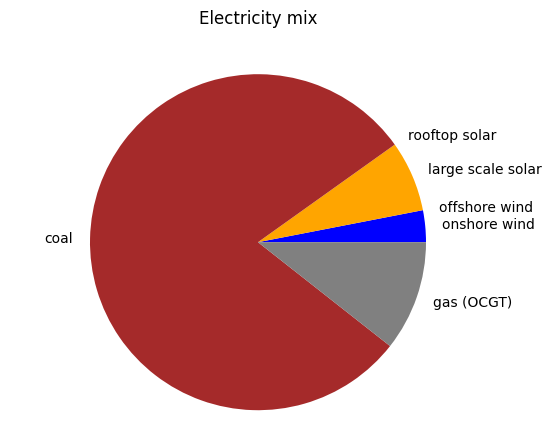

In [8]:
labels = ['onshore wind',
            'offshore wind',
            'large scale solar',
            'rooftop solar',
            'coal',
            'gas (OCGT)']
       
sizes = [network.generators_t.p['onshorewind'].sum(),
            network.generators_t.p['offshorewind'].sum(),
         network.generators_t.p['PV'].sum(),
            network.generators_t.p['rooftopPV'].sum(),
            network.generators_t.p['coal'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'darkblue', 'orange', 'yellow', 'brown', 'grey']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

__Installed Capacities of each generator__

In [9]:
network.generators.p_nom_opt.div(1e3) # in GW

Generator
onshorewind      8.350420
offshorewind     0.000000
PV              33.368777
rooftopPV        0.000000
OCGT            28.614407
coal            48.134363
Name: p_nom_opt, dtype: float64

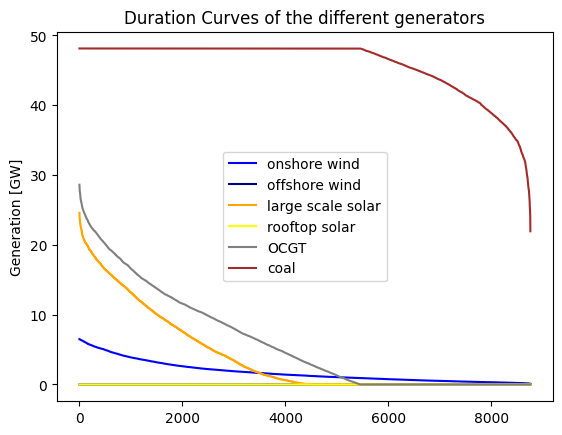

In [10]:
# Duration Curves
cf_onshore = network.generators_t.p['onshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_offshore = network.generators_t.p['offshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_PV = network.generators_t.p['PV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_rooftopPV = network.generators_t.p['rooftopPV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_OCGT = network.generators_t.p['OCGT'].sort_values(ascending=False,ignore_index=True)/1e3
cf_coal = network.generators_t.p['coal'].sort_values(ascending=False,ignore_index=True)/1e3


cf_onshore.plot(kind='line', ylabel='CF onshore', color='blue')
cf_offshore.plot(kind='line', ylabel='CF offshore', color='darkblue')
cf_PV.plot(kind='line', ylabel='CF PV', color='orange')
cf_rooftopPV.plot(kind='line', ylabel='CF rooftopPV', color='yellow')
cf_OCGT.plot(kind='line', ylabel='CF OCGT', color='grey')
cf_coal.plot(kind='line', ylabel='CF coal', color='brown')
plt.title('Duration Curves of the different generators')
plt.legend(['onshore wind', 'offshore wind', 'large scale solar', 'rooftop solar', 'OCGT', 'coal'])
plt.ylabel('Generation [GW]')
plt.show()

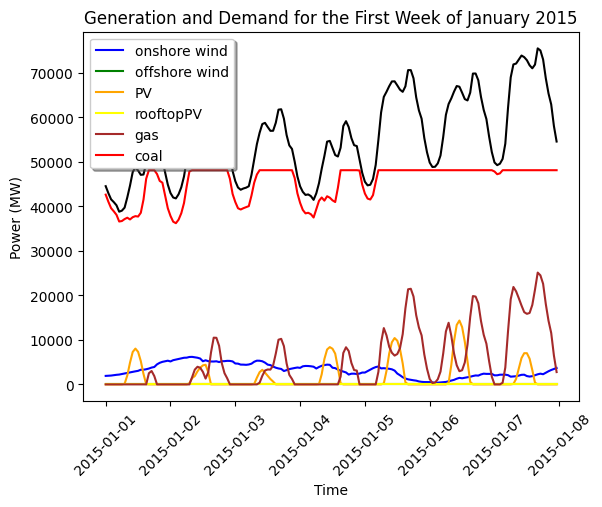

In [11]:
# Plot dispatch for a week in winter
start_date_1 = '2015-01-01'
end_date_1 = '2015-01-07'
week_1 = network.generators_t.p.loc[start_date_1:end_date_1]


plt.plot(week_1['onshorewind'], color='blue', label='onshore wind')
plt.plot(week_1['offshorewind'], color='green', label='offshore wind')
plt.plot(week_1['PV'], color='orange', label='PV')
plt.plot(week_1['rooftopPV'], color='yellow', label='rooftopPV')
plt.plot(week_1['OCGT'], color='brown', label='gas')
plt.plot(week_1['coal'], color='red', label='coal')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.plot(network.loads_t.p['load'].loc[start_date_1:end_date_1], color='black', label='demand')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Generation and Demand for the First Week of January 2015')

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

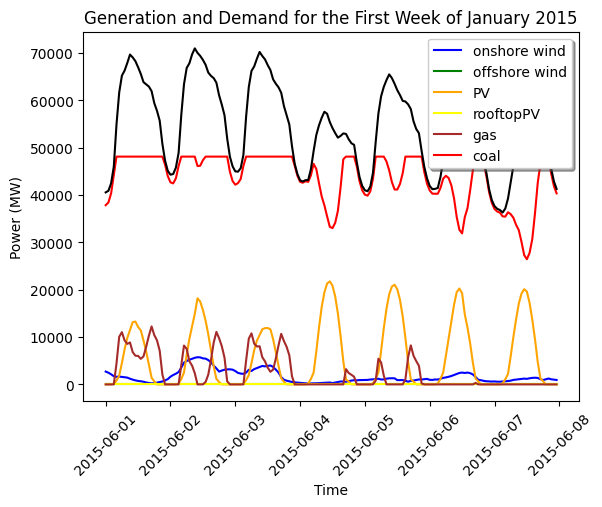

In [12]:
# Plot dispatch for a week in summer
start_date_2 = '2015-06-01'
end_date_2 = '2015-06-07'
week_2 = network.generators_t.p.loc[start_date_2:end_date_2]


plt.plot(week_2['onshorewind'], color='blue', label='onshore wind')
plt.plot(week_2['offshorewind'], color='green', label='offshore wind')
plt.plot(week_2['PV'], color='orange', label='PV')
plt.plot(week_2['rooftopPV'], color='yellow', label='rooftopPV')
plt.plot(week_2['OCGT'], color='brown', label='gas')
plt.plot(week_2['coal'], color='red', label='coal')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.plot(network.loads_t.p['load'].loc[start_date_2:end_date_2], color='black', label='demand')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Generation and Demand for the First Week of January 2015')

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

In [13]:
(network.statistics.capex() + network.statistics.opex()).div(1e6)

component  carrier    
Generator  coal           18478.567500
           gas             4388.622204
           onshorewind             NaN
           solarPV                 NaN
dtype: float64

# Section B

__2025 CO2 cap in Germany__

In [14]:
# CO2 emissions in germany (2015): 800.84 million tonnes
# Source: https://ourworldindata.org/co2/country/germany

In [15]:
network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=596000000, #596MtCO2
)

Index(['CO2Limit'], dtype='object')

In [16]:
network.optimize(solver_name='gurobi')

Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 17.29it/s]
INFO:linopy.io: Writing time: 0.79s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-e_vfbo9g.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-e_vfbo9g.lp


Reading time = 0.26 seconds


INFO:gurobipy:Reading time = 0.26 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0xee504da9


INFO:gurobipy:Model fingerprint: 0xee504da9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 6e+08]


INFO:gurobipy:  RHS range        [4e+04, 6e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.22980513e+12  0.00000000e+00  4.91e+10 0.00e+00  5.67e+09     0s


INFO:gurobipy:   0   9.22980513e+12  0.00000000e+00  4.91e+10 0.00e+00  5.67e+09     0s


   1   1.30151411e+13 -1.43416466e+12  7.68e+09 2.92e+02  1.12e+09     0s


INFO:gurobipy:   1   1.30151411e+13 -1.43416466e+12  7.68e+09 2.92e+02  1.12e+09     0s


   2   8.46335051e+12 -1.69534633e+12  2.70e+08 9.60e-10  9.19e+07     0s


INFO:gurobipy:   2   8.46335051e+12 -1.69534633e+12  2.70e+08 9.60e-10  9.19e+07     0s


   3   1.16169651e+12 -8.12019388e+11  3.07e+07 1.49e-10  1.60e+07     0s


INFO:gurobipy:   3   1.16169651e+12 -8.12019388e+11  3.07e+07 1.49e-10  1.60e+07     0s


   4   4.24205445e+11 -2.46756368e+11  3.54e+03 1.02e-09  5.20e+06     0s


INFO:gurobipy:   4   4.24205445e+11 -2.46756368e+11  3.54e+03 1.02e-09  5.20e+06     0s


   5   1.41441324e+11 -8.50748603e+10  9.34e+02 1.53e-10  1.73e+06     0s


INFO:gurobipy:   5   1.41441324e+11 -8.50748603e+10  9.34e+02 1.53e-10  1.73e+06     0s


   6   7.42587574e+10 -1.63570531e+10  3.86e+02 4.58e-10  6.90e+05     1s


INFO:gurobipy:   6   7.42587574e+10 -1.63570531e+10  3.86e+02 4.58e-10  6.90e+05     1s


   7   4.67794501e+10  6.68322837e+09  1.67e+02 6.78e-10  3.05e+05     1s


INFO:gurobipy:   7   4.67794501e+10  6.68322837e+09  1.67e+02 6.78e-10  3.05e+05     1s


   8   4.53841349e+10  1.24956105e+10  1.57e+02 3.22e-10  2.50e+05     1s


INFO:gurobipy:   8   4.53841349e+10  1.24956105e+10  1.57e+02 3.22e-10  2.50e+05     1s


   9   4.07140179e+10  1.92947125e+10  1.24e+02 9.92e-10  1.63e+05     1s


INFO:gurobipy:   9   4.07140179e+10  1.92947125e+10  1.24e+02 9.92e-10  1.63e+05     1s


  10   3.30891789e+10  2.24529820e+10  5.42e+01 1.30e-09  8.08e+04     1s


INFO:gurobipy:  10   3.30891789e+10  2.24529820e+10  5.42e+01 1.30e-09  8.08e+04     1s


  11   2.96426021e+10  2.40249413e+10  2.69e+01 1.26e-09  4.27e+04     1s


INFO:gurobipy:  11   2.96426021e+10  2.40249413e+10  2.69e+01 1.26e-09  4.27e+04     1s


  12   2.78325950e+10  2.46988568e+10  1.31e+01 8.88e-10  2.38e+04     1s


INFO:gurobipy:  12   2.78325950e+10  2.46988568e+10  1.31e+01 8.88e-10  2.38e+04     1s


  13   2.69632906e+10  2.53230891e+10  6.91e+00 1.01e-09  1.24e+04     1s


INFO:gurobipy:  13   2.69632906e+10  2.53230891e+10  6.91e+00 1.01e-09  1.24e+04     1s


  14   2.65387444e+10  2.56698735e+10  4.10e+00 9.46e-10  6.59e+03     1s


INFO:gurobipy:  14   2.65387444e+10  2.56698735e+10  4.10e+00 9.46e-10  6.59e+03     1s


  15   2.61490930e+10  2.57763451e+10  1.53e+00 6.79e-10  2.83e+03     1s


INFO:gurobipy:  15   2.61490930e+10  2.57763451e+10  1.53e+00 6.79e-10  2.83e+03     1s


  16   2.60167725e+10  2.58500137e+10  7.17e-01 5.45e-10  1.27e+03     1s


INFO:gurobipy:  16   2.60167725e+10  2.58500137e+10  7.17e-01 5.45e-10  1.27e+03     1s


  17   2.59286022e+10  2.58785081e+10  1.82e-01 1.63e-10  3.80e+02     1s


INFO:gurobipy:  17   2.59286022e+10  2.58785081e+10  1.82e-01 1.63e-10  3.80e+02     1s


  18   2.59071689e+10  2.58902453e+10  5.90e-02 4.94e-10  1.28e+02     1s


INFO:gurobipy:  18   2.59071689e+10  2.58902453e+10  5.90e-02 4.94e-10  1.28e+02     1s


  19   2.59012337e+10  2.58937724e+10  2.78e-02 4.89e-10  5.66e+01     1s


INFO:gurobipy:  19   2.59012337e+10  2.58937724e+10  2.78e-02 4.89e-10  5.66e+01     1s


  20   2.58969781e+10  2.58947307e+10  5.57e-03 1.03e-10  1.70e+01     1s


INFO:gurobipy:  20   2.58969781e+10  2.58947307e+10  5.57e-03 1.03e-10  1.70e+01     1s


  21   2.58962156e+10  2.58956758e+10  2.01e-03 3.94e-10  4.09e+00     1s


INFO:gurobipy:  21   2.58962156e+10  2.58956758e+10  2.01e-03 3.94e-10  4.09e+00     1s


  22   2.58957962e+10  2.58957488e+10  5.58e-05 2.23e-09  3.59e-01     1s


INFO:gurobipy:  22   2.58957962e+10  2.58957488e+10  5.58e-05 2.23e-09  3.59e-01     1s


  23   2.58957796e+10  2.58957791e+10  1.51e-06 6.84e-10  3.57e-03     1s


INFO:gurobipy:  23   2.58957796e+10  2.58957791e+10  1.51e-06 6.84e-10  3.57e-03     1s


  24   2.58957792e+10  2.58957792e+10  1.21e-05 1.15e-09  3.79e-06     1s


INFO:gurobipy:  24   2.58957792e+10  2.58957792e+10  1.21e-05 1.15e-09  3.79e-06     1s


  25   2.58957792e+10  2.58957792e+10  1.23e-08 3.43e-09  3.80e-12     1s


INFO:gurobipy:  25   2.58957792e+10  2.58957792e+10  1.23e-08 3.43e-09  3.80e-12     1s


INFO:gurobipy:


Barrier solved model in 25 iterations and 1.32 seconds (0.53 work units)


INFO:gurobipy:Barrier solved model in 25 iterations and 1.32 seconds (0.53 work units)


Optimal objective 2.58957792e+10


INFO:gurobipy:Optimal objective 2.58957792e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


      94 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:      94 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.9559437e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.9559437e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13207    2.5895779e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13207    2.5895779e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13207 iterations and 2.96 seconds (6.61 work units)


INFO:gurobipy:Solved in 13207 iterations and 2.96 seconds (6.61 work units)


Optimal objective  2.589577920e+10


INFO:gurobipy:Optimal objective  2.589577920e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.59e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Text(0.5, 1.07, 'Generation mix')

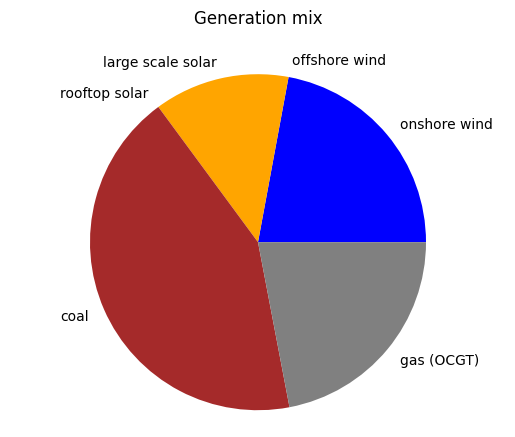

In [17]:

labels = ['onshore wind',
            'offshore wind',
            'large scale solar',
            'rooftop solar',
            'coal',
            'gas (OCGT)']
      
sizes = [network.generators_t.p['onshorewind'].sum(),
            network.generators_t.p['offshorewind'].sum(),
         network.generators_t.p['PV'].sum(),
            network.generators_t.p['rooftopPV'].sum(),
            network.generators_t.p['coal'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'darkblue', 'orange', 'yellow', 'brown', 'grey']

plt.pie(sizes,
      colors=colors,
      labels=labels,
      wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Generation mix', y=1.07)



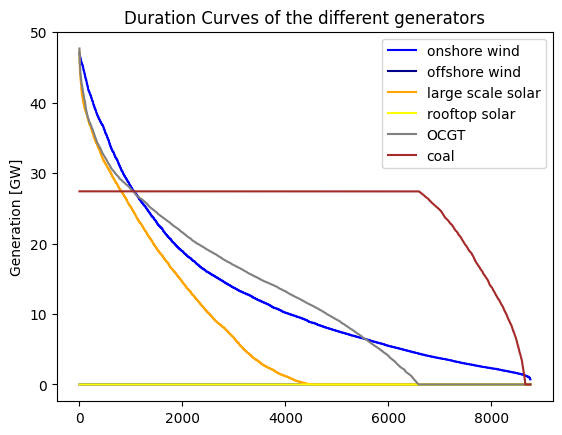

In [18]:
# Duration Curves
cf_onshore = network.generators_t.p['onshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_offshore = network.generators_t.p['offshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_PV = network.generators_t.p['PV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_rooftopPV = network.generators_t.p['rooftopPV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_OCGT = network.generators_t.p['OCGT'].sort_values(ascending=False,ignore_index=True)/1e3
cf_coal = network.generators_t.p['coal'].sort_values(ascending=False,ignore_index=True)/1e3


cf_onshore.plot(kind='line', ylabel='CF onshore', color='blue')
cf_offshore.plot(kind='line', ylabel='CF offshore', color='darkblue')
cf_PV.plot(kind='line', ylabel='CF PV', color='orange')
cf_rooftopPV.plot(kind='line', ylabel='CF rooftopPV', color='yellow')
cf_OCGT.plot(kind='line', ylabel='CF OCGT', color='grey')
cf_coal.plot(kind='line', ylabel='CF coal', color='brown')
plt.title('Duration Curves of the different generators')
plt.legend(['onshore wind', 'offshore wind', 'large scale solar', 'rooftop solar', 'OCGT', 'coal'])
plt.ylabel('Generation [GW]')
plt.show()

In [19]:
network.generators.p_nom_opt.div(1e3) # in GW

Generator
onshorewind     60.368926
offshorewind     0.000000
PV              64.210929
rooftopPV        0.000000
OCGT            47.681275
coal            27.408502
Name: p_nom_opt, dtype: float64

In [20]:
print(f"Total cost: {round(network.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(network.objective/network.loads_t.p.sum().iloc[0]))} EUR/MWh")

Total cost: 25895.78 mio€
Cost per MWh of electricity produced 51 EUR/MWh


__Sensitivity Analysis__

In [21]:
systemcost = []
onwind = []
offwind = []
pv = []
rooftop = []
coal = []
ocgt = []

onwind_cap = []
offwind_cap = []
pv_cap = []
rooftop_cap = []
coal_cap = []
ocgt_cap = []

co2_tax = []


for co2 in [2000, 1500, 1000, 596, 500, 250, 100, 0]: # in MtCO2
    network.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    network.optimize(solver_name="gurobi")
    systemcost.append(network.objective / 1e6)  # in million euros
    onwind.append(network.generators_t.p["onshorewind"].sum())
    offwind.append(network.generators_t.p["offshorewind"].sum())
    pv.append(network.generators_t.p["PV"].sum())
    rooftop.append(network.generators_t.p["rooftopPV"].sum())
    coal.append(network.generators_t.p["coal"].sum())
    ocgt.append(network.generators_t.p["OCGT"].sum())

    onwind_cap.append(network.generators.p_nom_opt.loc["onshorewind"])
    offwind_cap.append(network.generators.p_nom_opt.loc["offshorewind"])
    pv_cap.append(network.generators.p_nom_opt.loc["PV"])
    rooftop_cap.append(network.generators.p_nom_opt.loc["rooftopPV"])
    coal_cap.append(network.generators.p_nom_opt.loc["coal"])
    ocgt_cap.append(network.generators.p_nom_opt.loc["OCGT"])

    co2_tax.append(-network.global_constraints.mu['CO2Limit'])
    
    

Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 14.69it/s]
INFO:linopy.io: Writing time: 0.86s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-2pcplwl4.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-2pcplwl4.lp


Reading time = 0.29 seconds


INFO:gurobipy:Reading time = 0.29 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x96b95d0b


INFO:gurobipy:Model fingerprint: 0x96b95d0b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+09]


INFO:gurobipy:  RHS range        [4e+04, 2e+09]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 61043 rows and 8476 columns


INFO:gurobipy:Presolve removed 61043 rows and 8476 columns


Presolve time: 0.17s


INFO:gurobipy:Presolve time: 0.17s


Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.817e+04


INFO:gurobipy: AA' NZ     : 8.817e+04


 Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


INFO:gurobipy:   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


INFO:gurobipy:   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


   3   1.61650436e+11 -2.01317169e+10  1.75e-10 3.22e-01  1.39e+06     0s


INFO:gurobipy:   3   1.61650436e+11 -2.01317169e+10  1.75e-10 3.22e-01  1.39e+06     0s


   4   9.92170059e+10  7.71370830e+09  1.16e-10 1.03e-01  6.96e+05     0s


INFO:gurobipy:   4   9.92170059e+10  7.71370830e+09  1.16e-10 1.03e-01  6.96e+05     0s


   5   6.13372975e+10  1.22646767e+10  1.57e-09 4.12e-02  3.73e+05     1s


INFO:gurobipy:   5   6.13372975e+10  1.22646767e+10  1.57e-09 4.12e-02  3.73e+05     1s


   6   4.89505730e+10  1.61827315e+10  1.75e-09 3.57e-02  2.49e+05     1s


INFO:gurobipy:   6   4.89505730e+10  1.61827315e+10  1.75e-09 3.57e-02  2.49e+05     1s


   7   4.10081204e+10  2.04457327e+10  4.83e-09 8.06e-03  1.56e+05     1s


INFO:gurobipy:   7   4.10081204e+10  2.04457327e+10  4.83e-09 8.06e-03  1.56e+05     1s


   8   4.00328497e+10  2.13247459e+10  7.60e-08 5.72e-03  1.42e+05     1s


INFO:gurobipy:   8   4.00328497e+10  2.13247459e+10  7.60e-08 5.72e-03  1.42e+05     1s


   9   3.35780868e+10  2.23124197e+10  3.95e-07 6.98e-10  8.53e+04     1s


INFO:gurobipy:   9   3.35780868e+10  2.23124197e+10  3.95e-07 6.98e-10  8.53e+04     1s


  10   2.89054547e+10  2.31739019e+10  5.01e-07 6.40e-10  4.34e+04     1s


INFO:gurobipy:  10   2.89054547e+10  2.31739019e+10  5.01e-07 6.40e-10  4.34e+04     1s


  11   2.72997183e+10  2.37155948e+10  4.34e-07 2.04e-09  2.72e+04     1s


INFO:gurobipy:  11   2.72997183e+10  2.37155948e+10  4.34e-07 2.04e-09  2.72e+04     1s


  12   2.64698707e+10  2.38954623e+10  8.56e-07 9.60e-10  1.95e+04     1s


INFO:gurobipy:  12   2.64698707e+10  2.38954623e+10  8.56e-07 9.60e-10  1.95e+04     1s


  13   2.60400183e+10  2.40809592e+10  6.69e-07 3.06e-09  1.48e+04     1s


INFO:gurobipy:  13   2.60400183e+10  2.40809592e+10  6.69e-07 3.06e-09  1.48e+04     1s


  14   2.56185089e+10  2.42866895e+10  1.43e-07 9.20e-10  1.01e+04     1s


INFO:gurobipy:  14   2.56185089e+10  2.42866895e+10  1.43e-07 9.20e-10  1.01e+04     1s


  15   2.53952983e+10  2.43933212e+10  8.11e-07 6.75e-10  7.59e+03     1s


INFO:gurobipy:  15   2.53952983e+10  2.43933212e+10  8.11e-07 6.75e-10  7.59e+03     1s


  16   2.52540136e+10  2.44516138e+10  1.10e-06 4.18e-10  6.08e+03     1s


INFO:gurobipy:  16   2.52540136e+10  2.44516138e+10  1.10e-06 4.18e-10  6.08e+03     1s


  17   2.51732394e+10  2.45291686e+10  1.33e-06 5.49e-10  4.88e+03     1s


INFO:gurobipy:  17   2.51732394e+10  2.45291686e+10  1.33e-06 5.49e-10  4.88e+03     1s


  18   2.51064244e+10  2.45564622e+10  1.16e-06 1.12e-09  4.17e+03     1s


INFO:gurobipy:  18   2.51064244e+10  2.45564622e+10  1.16e-06 1.12e-09  4.17e+03     1s


  19   2.50935885e+10  2.45808055e+10  4.43e-06 5.71e-10  3.88e+03     1s


INFO:gurobipy:  19   2.50935885e+10  2.45808055e+10  4.43e-06 5.71e-10  3.88e+03     1s


  20   2.49427907e+10  2.46488390e+10  1.19e-05 1.45e-10  2.23e+03     1s


INFO:gurobipy:  20   2.49427907e+10  2.46488390e+10  1.19e-05 1.45e-10  2.23e+03     1s


  21   2.48977521e+10  2.46683784e+10  9.10e-06 0.00e+00  1.74e+03     1s


INFO:gurobipy:  21   2.48977521e+10  2.46683784e+10  9.10e-06 0.00e+00  1.74e+03     1s


  22   2.48666247e+10  2.46767991e+10  7.22e-06 7.09e-10  1.44e+03     1s


INFO:gurobipy:  22   2.48666247e+10  2.46767991e+10  7.22e-06 7.09e-10  1.44e+03     1s


  23   2.48384775e+10  2.46958304e+10  5.70e-06 2.97e-10  1.08e+03     1s


INFO:gurobipy:  23   2.48384775e+10  2.46958304e+10  5.70e-06 2.97e-10  1.08e+03     1s


  24   2.48144917e+10  2.47080908e+10  4.44e-06 5.32e-10  8.07e+02     1s


INFO:gurobipy:  24   2.48144917e+10  2.47080908e+10  4.44e-06 5.32e-10  8.07e+02     1s


  25   2.48012289e+10  2.47128089e+10  3.38e-06 9.57e-10  6.70e+02     2s


INFO:gurobipy:  25   2.48012289e+10  2.47128089e+10  3.38e-06 9.57e-10  6.70e+02     2s


  26   2.47899205e+10  2.47231212e+10  2.54e-06 2.36e-10  5.06e+02     2s


INFO:gurobipy:  26   2.47899205e+10  2.47231212e+10  2.54e-06 2.36e-10  5.06e+02     2s


  27   2.47834090e+10  2.47255193e+10  2.07e-06 2.83e-10  4.39e+02     2s


INFO:gurobipy:  27   2.47834090e+10  2.47255193e+10  2.07e-06 2.83e-10  4.39e+02     2s


  28   2.47794580e+10  2.47303344e+10  1.83e-06 3.04e-10  3.72e+02     2s


INFO:gurobipy:  28   2.47794580e+10  2.47303344e+10  1.83e-06 3.04e-10  3.72e+02     2s


  29   2.47728541e+10  2.47340788e+10  1.01e-06 1.24e-10  2.94e+02     2s


INFO:gurobipy:  29   2.47728541e+10  2.47340788e+10  1.01e-06 1.24e-10  2.94e+02     2s


  30   2.47704220e+10  2.47368063e+10  7.38e-07 2.72e-10  2.55e+02     2s


INFO:gurobipy:  30   2.47704220e+10  2.47368063e+10  7.38e-07 2.72e-10  2.55e+02     2s


  31   2.47683317e+10  2.47382112e+10  6.46e-07 1.88e-09  2.28e+02     2s


INFO:gurobipy:  31   2.47683317e+10  2.47382112e+10  6.46e-07 1.88e-09  2.28e+02     2s


  32   2.47655178e+10  2.47392601e+10  3.51e-07 3.06e-10  1.99e+02     2s


INFO:gurobipy:  32   2.47655178e+10  2.47392601e+10  3.51e-07 3.06e-10  1.99e+02     2s


  33   2.47643228e+10  2.47401078e+10  3.46e-07 4.50e-10  1.84e+02     2s


INFO:gurobipy:  33   2.47643228e+10  2.47401078e+10  3.46e-07 4.50e-10  1.84e+02     2s


  34   2.47614016e+10  2.47424700e+10  3.16e-07 6.45e-10  1.44e+02     2s


INFO:gurobipy:  34   2.47614016e+10  2.47424700e+10  3.16e-07 6.45e-10  1.44e+02     2s


  35   2.47583260e+10  2.47444368e+10  2.16e-07 1.33e-09  1.05e+02     2s


INFO:gurobipy:  35   2.47583260e+10  2.47444368e+10  2.16e-07 1.33e-09  1.05e+02     2s


  36   2.47574978e+10  2.47456956e+10  3.38e-07 1.33e-09  8.96e+01     2s


INFO:gurobipy:  36   2.47574978e+10  2.47456956e+10  3.38e-07 1.33e-09  8.96e+01     2s


  37   2.47567517e+10  2.47463673e+10  3.71e-07 4.79e-10  7.88e+01     2s


INFO:gurobipy:  37   2.47567517e+10  2.47463673e+10  3.71e-07 4.79e-10  7.88e+01     2s


  38   2.47563056e+10  2.47470895e+10  3.80e-07 7.08e-10  7.00e+01     2s


INFO:gurobipy:  38   2.47563056e+10  2.47470895e+10  3.80e-07 7.08e-10  7.00e+01     2s


  39   2.47560667e+10  2.47474032e+10  9.15e-07 5.19e-10  6.58e+01     2s


INFO:gurobipy:  39   2.47560667e+10  2.47474032e+10  9.15e-07 5.19e-10  6.58e+01     2s


  40   2.47559625e+10  2.47480424e+10  7.60e-07 1.71e-09  6.01e+01     3s


INFO:gurobipy:  40   2.47559625e+10  2.47480424e+10  7.60e-07 1.71e-09  6.01e+01     3s


  41   2.47556703e+10  2.47482817e+10  5.95e-07 4.73e-10  5.61e+01     3s


INFO:gurobipy:  41   2.47556703e+10  2.47482817e+10  5.95e-07 4.73e-10  5.61e+01     3s


  42   2.47554665e+10  2.47484699e+10  1.32e-06 5.89e-10  5.31e+01     3s


INFO:gurobipy:  42   2.47554665e+10  2.47484699e+10  1.32e-06 5.89e-10  5.31e+01     3s


  43   2.47554134e+10  2.47487554e+10  1.35e-06 1.13e-09  5.05e+01     3s


INFO:gurobipy:  43   2.47554134e+10  2.47487554e+10  1.35e-06 1.13e-09  5.05e+01     3s


  44   2.47551917e+10  2.47493666e+10  1.30e-06 1.53e-10  4.42e+01     3s


INFO:gurobipy:  44   2.47551917e+10  2.47493666e+10  1.30e-06 1.53e-10  4.42e+01     3s


  45   2.47548858e+10  2.47499671e+10  1.12e-06 5.64e-10  3.73e+01     3s


INFO:gurobipy:  45   2.47548858e+10  2.47499671e+10  1.12e-06 5.64e-10  3.73e+01     3s


  46   2.47546393e+10  2.47506772e+10  1.06e-06 3.02e-10  3.01e+01     3s


INFO:gurobipy:  46   2.47546393e+10  2.47506772e+10  1.06e-06 3.02e-10  3.01e+01     3s


  47   2.47539437e+10  2.47511437e+10  3.71e-07 5.51e-10  2.13e+01     3s


INFO:gurobipy:  47   2.47539437e+10  2.47511437e+10  3.71e-07 5.51e-10  2.13e+01     3s


  48   2.47535590e+10  2.47512684e+10  1.79e-06 5.97e-10  1.74e+01     3s


INFO:gurobipy:  48   2.47535590e+10  2.47512684e+10  1.79e-06 5.97e-10  1.74e+01     3s


  49   2.47534515e+10  2.47516005e+10  1.23e-06 8.66e-10  1.41e+01     3s


INFO:gurobipy:  49   2.47534515e+10  2.47516005e+10  1.23e-06 8.66e-10  1.41e+01     3s


  50   2.47533633e+10  2.47520112e+10  7.13e-07 1.26e-10  1.03e+01     3s


INFO:gurobipy:  50   2.47533633e+10  2.47520112e+10  7.13e-07 1.26e-10  1.03e+01     3s


  51   2.47532721e+10  2.47522129e+10  3.39e-06 3.97e-10  8.06e+00     3s


INFO:gurobipy:  51   2.47532721e+10  2.47522129e+10  3.39e-06 3.97e-10  8.06e+00     3s


  52   2.47532577e+10  2.47526042e+10  3.16e-06 3.17e-09  4.97e+00     3s


INFO:gurobipy:  52   2.47532577e+10  2.47526042e+10  3.16e-06 3.17e-09  4.97e+00     3s


  53   2.47532505e+10  2.47526402e+10  4.17e-06 2.79e-09  4.64e+00     3s


INFO:gurobipy:  53   2.47532505e+10  2.47526402e+10  4.17e-06 2.79e-09  4.64e+00     3s


  54   2.47532314e+10  2.47528656e+10  7.12e-06 1.78e-09  2.78e+00     3s


INFO:gurobipy:  54   2.47532314e+10  2.47528656e+10  7.12e-06 1.78e-09  2.78e+00     3s


  55   2.47532185e+10  2.47529678e+10  6.12e-06 7.77e-10  1.91e+00     3s


INFO:gurobipy:  55   2.47532185e+10  2.47529678e+10  6.12e-06 7.77e-10  1.91e+00     3s


  56   2.47532176e+10  2.47530777e+10  5.22e-06 1.14e-09  1.06e+00     3s


INFO:gurobipy:  56   2.47532176e+10  2.47530777e+10  5.22e-06 1.14e-09  1.06e+00     3s


  57   2.47532167e+10  2.47530842e+10  4.44e-06 1.89e-09  1.01e+00     3s


INFO:gurobipy:  57   2.47532167e+10  2.47530842e+10  4.44e-06 1.89e-09  1.01e+00     3s


  58   2.47532157e+10  2.47530918e+10  3.73e-06 1.32e-09  9.43e-01     3s


INFO:gurobipy:  58   2.47532157e+10  2.47530918e+10  3.73e-06 1.32e-09  9.43e-01     3s


  59   2.47532156e+10  2.47530964e+10  3.59e-06 8.99e-10  9.07e-01     4s


INFO:gurobipy:  59   2.47532156e+10  2.47530964e+10  3.59e-06 8.99e-10  9.07e-01     4s


  60   2.47532153e+10  2.47531028e+10  2.97e-06 1.36e-09  8.56e-01     4s


INFO:gurobipy:  60   2.47532153e+10  2.47531028e+10  2.97e-06 1.36e-09  8.56e-01     4s


  61   2.47532153e+10  2.47531193e+10  2.90e-06 7.45e-10  7.31e-01     4s


INFO:gurobipy:  61   2.47532153e+10  2.47531193e+10  2.90e-06 7.45e-10  7.31e-01     4s


  62   2.47532147e+10  2.47532027e+10  1.72e-06 0.00e+00  9.17e-02     4s


INFO:gurobipy:  62   2.47532147e+10  2.47532027e+10  1.72e-06 0.00e+00  9.17e-02     4s


  63   2.47532145e+10  2.47532076e+10  9.77e-07 4.41e-10  5.30e-02     4s


INFO:gurobipy:  63   2.47532145e+10  2.47532076e+10  9.77e-07 4.41e-10  5.30e-02     4s


  64   2.47532143e+10  2.47532125e+10  5.82e-11 5.46e-10  1.36e-02     4s


INFO:gurobipy:  64   2.47532143e+10  2.47532125e+10  5.82e-11 5.46e-10  1.36e-02     4s


  65   2.47532143e+10  2.47532143e+10  7.87e-08 4.49e-10  2.34e-05     4s


INFO:gurobipy:  65   2.47532143e+10  2.47532143e+10  7.87e-08 4.49e-10  2.34e-05     4s


  66   2.47532143e+10  2.47532143e+10  1.16e-10 5.82e-10  2.35e-11     4s


INFO:gurobipy:  66   2.47532143e+10  2.47532143e+10  1.16e-10 5.82e-10  2.35e-11     4s


INFO:gurobipy:


Barrier solved model in 66 iterations and 3.91 seconds (1.25 work units)


INFO:gurobipy:Barrier solved model in 66 iterations and 3.91 seconds (1.25 work units)


Optimal objective 2.47532143e+10


INFO:gurobipy:Optimal objective 2.47532143e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13309 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:   13309 DPushes remaining with DInf 0.0000000e+00                 4s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 4s


       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6725757e-10      4s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6725757e-10      4s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13313    2.4753214e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   13313    2.4753214e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 13313 iterations and 4.26 seconds (1.33 work units)


INFO:gurobipy:Solved in 13313 iterations and 4.26 seconds (1.33 work units)


Optimal objective  2.475321425e+10


INFO:gurobipy:Optimal objective  2.475321425e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 17.06it/s]
INFO:linopy.io: Writing time: 0.88s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-11lamjr9.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-11lamjr9.lp


Reading time = 0.28 seconds


INFO:gurobipy:Reading time = 0.28 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x0ee7df54


INFO:gurobipy:Model fingerprint: 0x0ee7df54


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+09]


INFO:gurobipy:  RHS range        [4e+04, 2e+09]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.31893456e+13  0.00000000e+00  1.24e+11 0.00e+00  1.35e+10     0s


INFO:gurobipy:   0   2.31893456e+13  0.00000000e+00  1.24e+11 0.00e+00  1.35e+10     0s


   1   3.24162238e+13 -1.94195084e+12  1.96e+10 2.76e+02  2.67e+09     0s


INFO:gurobipy:   1   3.24162238e+13 -1.94195084e+12  1.96e+10 2.76e+02  2.67e+09     0s


   2   2.06813565e+13 -2.06451170e+12  1.01e+09 9.02e-10  2.28e+08     0s


INFO:gurobipy:   2   2.06813565e+13 -2.06451170e+12  1.01e+09 9.02e-10  2.28e+08     0s


   3   4.46546317e+12 -1.39915006e+12  1.78e+08 6.00e-10  5.56e+07     0s


INFO:gurobipy:   3   4.46546317e+12 -1.39915006e+12  1.78e+08 6.00e-10  5.56e+07     0s


   4   9.65979510e+11 -7.06743766e+11  1.45e+04 3.71e-10  1.34e+07     1s


INFO:gurobipy:   4   9.65979510e+11 -7.06743766e+11  1.45e+04 3.71e-10  1.34e+07     1s


   5   3.35196583e+11 -2.46578335e+11  4.44e+03 3.64e-10  4.52e+06     1s


INFO:gurobipy:   5   3.35196583e+11 -2.46578335e+11  4.44e+03 3.64e-10  4.52e+06     1s


   6   1.26987085e+11 -5.64302947e+10  1.37e+03 1.38e-09  1.41e+06     1s


INFO:gurobipy:   6   1.26987085e+11 -5.64302947e+10  1.37e+03 1.38e-09  1.41e+06     1s


   7   5.63766087e+10 -1.65187341e+10  4.02e+02 1.12e-09  5.56e+05     1s


INFO:gurobipy:   7   5.63766087e+10 -1.65187341e+10  4.02e+02 1.12e-09  5.56e+05     1s


   8   4.40372306e+10 -4.88300361e+08  2.46e+02 8.55e-10  3.39e+05     1s


INFO:gurobipy:   8   4.40372306e+10 -4.88300361e+08  2.46e+02 8.55e-10  3.39e+05     1s


   9   4.02978678e+10  1.25875706e+10  2.02e+02 1.73e-09  2.11e+05     1s


INFO:gurobipy:   9   4.02978678e+10  1.25875706e+10  2.02e+02 1.73e-09  2.11e+05     1s


  10   3.69035505e+10  1.89107912e+10  1.60e+02 4.33e-10  1.37e+05     1s


INFO:gurobipy:  10   3.69035505e+10  1.89107912e+10  1.60e+02 4.33e-10  1.37e+05     1s


  11   3.07134357e+10  2.09145535e+10  7.46e+01 2.51e-10  7.47e+04     1s


INFO:gurobipy:  11   3.07134357e+10  2.09145535e+10  7.46e+01 2.51e-10  7.47e+04     1s


  12   2.86567662e+10  2.16359276e+10  4.90e+01 3.42e-10  5.34e+04     1s


INFO:gurobipy:  12   2.86567662e+10  2.16359276e+10  4.90e+01 3.42e-10  5.34e+04     1s


  13   2.75763760e+10  2.22052140e+10  3.44e+01 6.08e-10  4.09e+04     1s


INFO:gurobipy:  13   2.75763760e+10  2.22052140e+10  3.44e+01 6.08e-10  4.09e+04     1s


  14   2.66882142e+10  2.30431483e+10  2.34e+01 3.15e-10  2.77e+04     1s


INFO:gurobipy:  14   2.66882142e+10  2.30431483e+10  2.34e+01 3.15e-10  2.77e+04     1s


  15   2.61771915e+10  2.32535026e+10  1.71e+01 2.98e-10  2.22e+04     1s


INFO:gurobipy:  15   2.61771915e+10  2.32535026e+10  1.71e+01 2.98e-10  2.22e+04     1s


  16   2.58117353e+10  2.34892587e+10  1.26e+01 8.91e-10  1.76e+04     1s


INFO:gurobipy:  16   2.58117353e+10  2.34892587e+10  1.26e+01 8.91e-10  1.76e+04     1s


  17   2.55830653e+10  2.38189215e+10  9.81e+00 4.83e-10  1.34e+04     1s


INFO:gurobipy:  17   2.55830653e+10  2.38189215e+10  9.81e+00 4.83e-10  1.34e+04     1s


  18   2.53955897e+10  2.39152070e+10  7.56e+00 5.37e-10  1.12e+04     1s


INFO:gurobipy:  18   2.53955897e+10  2.39152070e+10  7.56e+00 5.37e-10  1.12e+04     1s


  19   2.53001930e+10  2.40048765e+10  6.40e+00 3.25e-10  9.83e+03     1s


INFO:gurobipy:  19   2.53001930e+10  2.40048765e+10  6.40e+00 3.25e-10  9.83e+03     1s


  20   2.51620200e+10  2.42326430e+10  4.75e+00 1.64e-10  7.06e+03     1s


INFO:gurobipy:  20   2.51620200e+10  2.42326430e+10  4.75e+00 1.64e-10  7.06e+03     1s


  21   2.51108339e+10  2.43547484e+10  4.15e+00 1.42e-09  5.74e+03     1s


INFO:gurobipy:  21   2.51108339e+10  2.43547484e+10  4.15e+00 1.42e-09  5.74e+03     1s


  22   2.50273269e+10  2.45025713e+10  3.06e+00 6.84e-10  3.99e+03     1s


INFO:gurobipy:  22   2.50273269e+10  2.45025713e+10  3.06e+00 6.84e-10  3.99e+03     1s


  23   2.49666343e+10  2.45263449e+10  2.36e+00 1.19e-10  3.34e+03     1s


INFO:gurobipy:  23   2.49666343e+10  2.45263449e+10  2.36e+00 1.19e-10  3.34e+03     1s


  24   2.49325029e+10  2.45593842e+10  1.97e+00 9.39e-10  2.83e+03     1s


INFO:gurobipy:  24   2.49325029e+10  2.45593842e+10  1.97e+00 9.39e-10  2.83e+03     1s


  25   2.48970248e+10  2.45782567e+10  1.56e+00 4.95e-10  2.42e+03     1s


INFO:gurobipy:  25   2.48970248e+10  2.45782567e+10  1.56e+00 4.95e-10  2.42e+03     1s


  26   2.48611018e+10  2.46201411e+10  1.16e+00 8.77e-10  1.83e+03     1s


INFO:gurobipy:  26   2.48611018e+10  2.46201411e+10  1.16e+00 8.77e-10  1.83e+03     1s


  27   2.48456073e+10  2.46303192e+10  9.89e-01 4.24e-11  1.63e+03     2s


INFO:gurobipy:  27   2.48456073e+10  2.46303192e+10  9.89e-01 4.24e-11  1.63e+03     2s


  28   2.48330316e+10  2.46424911e+10  8.49e-01 7.49e-10  1.45e+03     2s


INFO:gurobipy:  28   2.48330316e+10  2.46424911e+10  8.49e-01 7.49e-10  1.45e+03     2s


  29   2.48169224e+10  2.46637612e+10  6.72e-01 2.07e-12  1.16e+03     2s


INFO:gurobipy:  29   2.48169224e+10  2.46637612e+10  6.72e-01 2.07e-12  1.16e+03     2s


  30   2.48057231e+10  2.46782305e+10  5.47e-01 2.77e-10  9.67e+02     2s


INFO:gurobipy:  30   2.48057231e+10  2.46782305e+10  5.47e-01 2.77e-10  9.67e+02     2s


  31   2.47934060e+10  2.46946981e+10  4.11e-01 1.68e-09  7.49e+02     2s


INFO:gurobipy:  31   2.47934060e+10  2.46946981e+10  4.11e-01 1.68e-09  7.49e+02     2s


  32   2.47891584e+10  2.47066844e+10  3.66e-01 4.65e-10  6.26e+02     2s


INFO:gurobipy:  32   2.47891584e+10  2.47066844e+10  3.66e-01 4.65e-10  6.26e+02     2s


  33   2.47801995e+10  2.47101355e+10  2.69e-01 8.48e-10  5.31e+02     2s


INFO:gurobipy:  33   2.47801995e+10  2.47101355e+10  2.69e-01 8.48e-10  5.31e+02     2s


  34   2.47773135e+10  2.47169630e+10  2.41e-01 2.18e-10  4.58e+02     2s


INFO:gurobipy:  34   2.47773135e+10  2.47169630e+10  2.41e-01 2.18e-10  4.58e+02     2s


  35   2.47750672e+10  2.47190048e+10  2.17e-01 2.63e-10  4.25e+02     2s


INFO:gurobipy:  35   2.47750672e+10  2.47190048e+10  2.17e-01 2.63e-10  4.25e+02     2s


  36   2.47717235e+10  2.47217888e+10  1.82e-01 5.38e-10  3.79e+02     2s


INFO:gurobipy:  36   2.47717235e+10  2.47217888e+10  1.82e-01 5.38e-10  3.79e+02     2s


  37   2.47665057e+10  2.47283232e+10  1.28e-01 1.37e-10  2.89e+02     2s


INFO:gurobipy:  37   2.47665057e+10  2.47283232e+10  1.28e-01 1.37e-10  2.89e+02     2s


  38   2.47650716e+10  2.47324917e+10  1.14e-01 6.16e-10  2.47e+02     2s


INFO:gurobipy:  38   2.47650716e+10  2.47324917e+10  1.14e-01 6.16e-10  2.47e+02     2s


  39   2.47628638e+10  2.47339451e+10  9.26e-02 1.06e-09  2.19e+02     2s


INFO:gurobipy:  39   2.47628638e+10  2.47339451e+10  9.26e-02 1.06e-09  2.19e+02     2s


  40   2.47607638e+10  2.47361845e+10  7.14e-02 1.04e-09  1.86e+02     2s


INFO:gurobipy:  40   2.47607638e+10  2.47361845e+10  7.14e-02 1.04e-09  1.86e+02     2s


  41   2.47590253e+10  2.47386452e+10  5.40e-02 2.43e-10  1.54e+02     2s


INFO:gurobipy:  41   2.47590253e+10  2.47386452e+10  5.40e-02 2.43e-10  1.54e+02     2s


  42   2.47584279e+10  2.47402722e+10  4.81e-02 2.12e-09  1.38e+02     2s


INFO:gurobipy:  42   2.47584279e+10  2.47402722e+10  4.81e-02 2.12e-09  1.38e+02     2s


  43   2.47578125e+10  2.47406389e+10  4.24e-02 3.97e-10  1.30e+02     2s


INFO:gurobipy:  43   2.47578125e+10  2.47406389e+10  4.24e-02 3.97e-10  1.30e+02     2s


  44   2.47567885e+10  2.47424729e+10  3.22e-02 7.93e-10  1.08e+02     2s


INFO:gurobipy:  44   2.47567885e+10  2.47424729e+10  3.22e-02 7.93e-10  1.08e+02     2s


  45   2.47566348e+10  2.47435745e+10  3.08e-02 5.75e-10  9.89e+01     2s


INFO:gurobipy:  45   2.47566348e+10  2.47435745e+10  3.08e-02 5.75e-10  9.89e+01     2s


  46   2.47554495e+10  2.47447475e+10  2.01e-02 1.08e-09  8.10e+01     2s


INFO:gurobipy:  46   2.47554495e+10  2.47447475e+10  2.01e-02 1.08e-09  8.10e+01     2s


  47   2.47548750e+10  2.47469386e+10  1.45e-02 9.40e-10  6.01e+01     3s


INFO:gurobipy:  47   2.47548750e+10  2.47469386e+10  1.45e-02 9.40e-10  6.01e+01     3s


  48   2.47540103e+10  2.47481266e+10  6.29e-03 6.05e-10  4.45e+01     3s


INFO:gurobipy:  48   2.47540103e+10  2.47481266e+10  6.29e-03 6.05e-10  4.45e+01     3s


  49   2.47538160e+10  2.47493270e+10  4.50e-03 5.57e-10  3.40e+01     3s


INFO:gurobipy:  49   2.47538160e+10  2.47493270e+10  4.50e-03 5.57e-10  3.40e+01     3s


  50   2.47536011e+10  2.47496729e+10  2.90e-03 4.34e-12  2.97e+01     3s


INFO:gurobipy:  50   2.47536011e+10  2.47496729e+10  2.90e-03 4.34e-12  2.97e+01     3s


  51   2.47535409e+10  2.47498927e+10  2.46e-03 6.77e-10  2.76e+01     3s


INFO:gurobipy:  51   2.47535409e+10  2.47498927e+10  2.46e-03 6.77e-10  2.76e+01     3s


  52   2.47534215e+10  2.47507375e+10  1.38e-03 4.91e-10  2.03e+01     3s


INFO:gurobipy:  52   2.47534215e+10  2.47507375e+10  1.38e-03 4.91e-10  2.03e+01     3s


  53   2.47533639e+10  2.47516326e+10  9.97e-04 2.67e-12  1.31e+01     3s


INFO:gurobipy:  53   2.47533639e+10  2.47516326e+10  9.97e-04 2.67e-12  1.31e+01     3s


  54   2.47533013e+10  2.47520149e+10  5.17e-04 1.99e-10  9.73e+00     3s


INFO:gurobipy:  54   2.47533013e+10  2.47520149e+10  5.17e-04 1.99e-10  9.73e+00     3s


  55   2.47532508e+10  2.47523748e+10  3.40e-05 1.14e-12  6.62e+00     3s


INFO:gurobipy:  55   2.47532508e+10  2.47523748e+10  3.40e-05 1.14e-12  6.62e+00     3s


  56   2.47532361e+10  2.47523956e+10  2.02e-05 1.05e-10  6.35e+00     3s


INFO:gurobipy:  56   2.47532361e+10  2.47523956e+10  2.02e-05 1.05e-10  6.35e+00     3s


  57   2.47532261e+10  2.47528327e+10  8.15e-06 5.28e-10  2.97e+00     3s


INFO:gurobipy:  57   2.47532261e+10  2.47528327e+10  8.15e-06 5.28e-10  2.97e+00     3s


  58   2.47532198e+10  2.47528453e+10  6.73e-06 7.17e-10  2.83e+00     3s


INFO:gurobipy:  58   2.47532198e+10  2.47528453e+10  6.73e-06 7.17e-10  2.83e+00     3s


  59   2.47532200e+10  2.47529620e+10  5.63e-06 4.43e-09  1.95e+00     3s


INFO:gurobipy:  59   2.47532200e+10  2.47529620e+10  5.63e-06 4.43e-09  1.95e+00     3s


  60   2.47532196e+10  2.47530009e+10  5.15e-06 4.83e-09  1.65e+00     3s


INFO:gurobipy:  60   2.47532196e+10  2.47530009e+10  5.15e-06 4.83e-09  1.65e+00     3s


  61   2.47532180e+10  2.47531921e+10  3.79e-06 4.75e-09  1.95e-01     3s


INFO:gurobipy:  61   2.47532180e+10  2.47531921e+10  3.79e-06 4.75e-09  1.95e-01     3s


  62   2.47532148e+10  2.47532065e+10  5.57e-06 2.37e-09  6.22e-02     3s


INFO:gurobipy:  62   2.47532148e+10  2.47532065e+10  5.57e-06 2.37e-09  6.22e-02     3s


  63   2.47532145e+10  2.47532078e+10  3.60e-06 1.61e-09  5.00e-02     3s


INFO:gurobipy:  63   2.47532145e+10  2.47532078e+10  3.60e-06 1.61e-09  5.00e-02     3s


  64   2.47532144e+10  2.47532108e+10  4.95e-10 1.33e-09  2.71e-02     3s


INFO:gurobipy:  64   2.47532144e+10  2.47532108e+10  4.95e-10 1.33e-09  2.71e-02     3s


  65   2.47532143e+10  2.47532141e+10  1.35e-06 1.87e-09  1.24e-03     3s


INFO:gurobipy:  65   2.47532143e+10  2.47532141e+10  1.35e-06 1.87e-09  1.24e-03     3s


  66   2.47532143e+10  2.47532143e+10  4.37e-10 5.00e-09  1.86e-08     3s


INFO:gurobipy:  66   2.47532143e+10  2.47532143e+10  4.37e-10 5.00e-09  1.86e-08     3s


  67   2.47532143e+10  2.47532143e+10  5.82e-11 5.97e-09  2.08e-14     3s


INFO:gurobipy:  67   2.47532143e+10  2.47532143e+10  5.82e-11 5.97e-09  2.08e-14     3s


INFO:gurobipy:


Barrier solved model in 67 iterations and 3.48 seconds (1.27 work units)


INFO:gurobipy:Barrier solved model in 67 iterations and 3.48 seconds (1.27 work units)


Optimal objective 2.47532143e+10


INFO:gurobipy:Optimal objective 2.47532143e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13301 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:   13301 DPushes remaining with DInf 0.0000000e+00                 4s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.8680174e-11      4s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.8680174e-11      4s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13304    2.4753214e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   13304    2.4753214e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 13304 iterations and 3.77 seconds (1.34 work units)


INFO:gurobipy:Solved in 13304 iterations and 3.77 seconds (1.34 work units)


Optimal objective  2.475321425e+10


INFO:gurobipy:Optimal objective  2.475321425e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 16.24it/s]
INFO:linopy.io: Writing time: 0.85s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-57owmbvq.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-57owmbvq.lp


Reading time = 0.26 seconds


INFO:gurobipy:Reading time = 0.26 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0xfe0d4387


INFO:gurobipy:Model fingerprint: 0xfe0d4387


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 1e+09]


INFO:gurobipy:  RHS range        [4e+04, 1e+09]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.45442347e+13  0.00000000e+00  7.74e+10 0.00e+00  8.61e+09     0s


INFO:gurobipy:   0   1.45442347e+13  0.00000000e+00  7.74e+10 0.00e+00  8.61e+09     0s


   1   2.03935537e+13 -1.64710150e+12  1.22e+10 2.81e+02  1.70e+09     0s


INFO:gurobipy:   1   2.03935537e+13 -1.64710150e+12  1.22e+10 2.81e+02  1.70e+09     0s


   2   1.30909958e+13 -1.83879280e+12  5.50e+08 9.90e-10  1.43e+08     0s


INFO:gurobipy:   2   1.30909958e+13 -1.83879280e+12  5.50e+08 9.90e-10  1.43e+08     0s


   3   1.90396976e+12 -1.28300920e+12  5.76e+07 8.62e-10  2.78e+07     0s


INFO:gurobipy:   3   1.90396976e+12 -1.28300920e+12  5.76e+07 8.62e-10  2.78e+07     0s


   4   5.90325030e+11 -3.78084789e+11  6.98e+03 9.46e-10  7.64e+06     0s


INFO:gurobipy:   4   5.90325030e+11 -3.78084789e+11  6.98e+03 9.46e-10  7.64e+06     0s


   5   1.70414663e+11 -8.90977277e+10  1.63e+03 2.02e-09  1.99e+06     1s


INFO:gurobipy:   5   1.70414663e+11 -8.90977277e+10  1.63e+03 2.02e-09  1.99e+06     1s


   6   8.77446883e+10 -4.26799526e+10  6.87e+02 8.44e-10  9.97e+05     1s


INFO:gurobipy:   6   8.77446883e+10 -4.26799526e+10  6.87e+02 8.44e-10  9.97e+05     1s


   7   4.72630515e+10 -1.35584967e+10  2.33e+02 1.40e-09  4.63e+05     1s


INFO:gurobipy:   7   4.72630515e+10 -1.35584967e+10  2.33e+02 1.40e-09  4.63e+05     1s


   8   4.48498554e+10 -6.45911401e+08  2.08e+02 6.00e-10  3.46e+05     1s


INFO:gurobipy:   8   4.48498554e+10 -6.45911401e+08  2.08e+02 6.00e-10  3.46e+05     1s


   9   4.09574821e+10  1.15375483e+10  1.69e+02 8.59e-10  2.24e+05     1s


INFO:gurobipy:   9   4.09574821e+10  1.15375483e+10  1.69e+02 8.59e-10  2.24e+05     1s


  10   3.33041571e+10  1.70222349e+10  8.56e+01 2.25e-09  1.24e+05     1s


INFO:gurobipy:  10   3.33041571e+10  1.70222349e+10  8.56e+01 2.25e-09  1.24e+05     1s


  11   2.93536002e+10  1.90016870e+10  4.45e+01 7.39e-10  7.86e+04     1s


INFO:gurobipy:  11   2.93536002e+10  1.90016870e+10  4.45e+01 7.39e-10  7.86e+04     1s


  12   2.82374395e+10  1.97790668e+10  3.31e+01 4.62e-11  6.42e+04     1s


INFO:gurobipy:  12   2.82374395e+10  1.97790668e+10  3.31e+01 4.62e-11  6.42e+04     1s


  13   2.73377013e+10  2.07002243e+10  2.39e+01 4.94e-10  5.04e+04     1s


INFO:gurobipy:  13   2.73377013e+10  2.07002243e+10  2.39e+01 4.94e-10  5.04e+04     1s


  14   2.66530574e+10  2.20854865e+10  1.70e+01 9.17e-10  3.47e+04     1s


INFO:gurobipy:  14   2.66530574e+10  2.20854865e+10  1.70e+01 9.17e-10  3.47e+04     1s


  15   2.61503234e+10  2.26339530e+10  1.23e+01 1.71e-10  2.67e+04     1s


INFO:gurobipy:  15   2.61503234e+10  2.26339530e+10  1.23e+01 1.71e-10  2.67e+04     1s


  16   2.59445254e+10  2.29132705e+10  1.03e+01 5.37e-10  2.30e+04     1s


INFO:gurobipy:  16   2.59445254e+10  2.29132705e+10  1.03e+01 5.37e-10  2.30e+04     1s


  17   2.56863875e+10  2.38453765e+10  7.99e+00 1.68e-09  1.40e+04     1s


INFO:gurobipy:  17   2.56863875e+10  2.38453765e+10  7.99e+00 1.68e-09  1.40e+04     1s


  18   2.55073200e+10  2.39394833e+10  6.36e+00 7.71e-10  1.19e+04     1s


INFO:gurobipy:  18   2.55073200e+10  2.39394833e+10  6.36e+00 7.71e-10  1.19e+04     1s


  19   2.53206741e+10  2.42560765e+10  4.80e+00 7.22e-10  8.08e+03     1s


INFO:gurobipy:  19   2.53206741e+10  2.42560765e+10  4.80e+00 7.22e-10  8.08e+03     1s


  20   2.51751522e+10  2.43070882e+10  3.54e+00 4.51e-10  6.59e+03     1s


INFO:gurobipy:  20   2.51751522e+10  2.43070882e+10  3.54e+00 4.51e-10  6.59e+03     1s


  21   2.51130114e+10  2.43562896e+10  2.99e+00 4.60e-10  5.74e+03     1s


INFO:gurobipy:  21   2.51130114e+10  2.43562896e+10  2.99e+00 4.60e-10  5.74e+03     1s


  22   2.50297827e+10  2.44561229e+10  2.29e+00 4.40e-10  4.35e+03     1s


INFO:gurobipy:  22   2.50297827e+10  2.44561229e+10  2.29e+00 4.40e-10  4.35e+03     1s


  23   2.49712588e+10  2.45247359e+10  1.79e+00 7.64e-10  3.39e+03     1s


INFO:gurobipy:  23   2.49712588e+10  2.45247359e+10  1.79e+00 7.64e-10  3.39e+03     1s


  24   2.49439255e+10  2.45727426e+10  1.55e+00 2.90e-09  2.82e+03     1s


INFO:gurobipy:  24   2.49439255e+10  2.45727426e+10  1.55e+00 2.90e-09  2.82e+03     1s


  25   2.49340458e+10  2.46550437e+10  1.45e+00 4.28e-10  2.12e+03     1s


INFO:gurobipy:  25   2.49340458e+10  2.46550437e+10  1.45e+00 4.28e-10  2.12e+03     1s


  26   2.48928256e+10  2.46742204e+10  1.09e+00 1.83e-09  1.66e+03     1s


INFO:gurobipy:  26   2.48928256e+10  2.46742204e+10  1.09e+00 1.83e-09  1.66e+03     1s


  27   2.48838686e+10  2.46844655e+10  1.02e+00 7.03e-10  1.51e+03     2s


INFO:gurobipy:  27   2.48838686e+10  2.46844655e+10  1.02e+00 7.03e-10  1.51e+03     2s


  28   2.48669293e+10  2.46903218e+10  8.69e-01 3.06e-10  1.34e+03     2s


INFO:gurobipy:  28   2.48669293e+10  2.46903218e+10  8.69e-01 3.06e-10  1.34e+03     2s


  29   2.48592375e+10  2.47070894e+10  8.08e-01 8.44e-10  1.16e+03     2s


INFO:gurobipy:  29   2.48592375e+10  2.47070894e+10  8.08e-01 8.44e-10  1.16e+03     2s


  30   2.48287985e+10  2.47113682e+10  5.47e-01 2.26e-10  8.91e+02     2s


INFO:gurobipy:  30   2.48287985e+10  2.47113682e+10  5.47e-01 2.26e-10  8.91e+02     2s


  31   2.48142475e+10  2.47190964e+10  4.23e-01 6.41e-10  7.22e+02     2s


INFO:gurobipy:  31   2.48142475e+10  2.47190964e+10  4.23e-01 6.41e-10  7.22e+02     2s


  32   2.47994436e+10  2.47345814e+10  2.99e-01 1.66e-10  4.92e+02     2s


INFO:gurobipy:  32   2.47994436e+10  2.47345814e+10  2.99e-01 1.66e-10  4.92e+02     2s


  33   2.47864099e+10  2.47470749e+10  1.87e-01 1.15e-09  2.98e+02     2s


INFO:gurobipy:  33   2.47864099e+10  2.47470749e+10  1.87e-01 1.15e-09  2.98e+02     2s


  34   2.47811470e+10  2.47487920e+10  1.45e-01 1.48e-09  2.45e+02     2s


INFO:gurobipy:  34   2.47811470e+10  2.47487920e+10  1.45e-01 1.48e-09  2.45e+02     2s


  35   2.47738488e+10  2.47526070e+10  8.68e-02 4.38e-10  1.61e+02     2s


INFO:gurobipy:  35   2.47738488e+10  2.47526070e+10  8.68e-02 4.38e-10  1.61e+02     2s


  36   2.47701383e+10  2.47553032e+10  5.71e-02 3.53e-10  1.12e+02     2s


INFO:gurobipy:  36   2.47701383e+10  2.47553032e+10  5.71e-02 3.53e-10  1.12e+02     2s


  37   2.47678428e+10  2.47580176e+10  3.96e-02 5.97e-10  7.45e+01     2s


INFO:gurobipy:  37   2.47678428e+10  2.47580176e+10  3.96e-02 5.97e-10  7.45e+01     2s


  38   2.47654147e+10  2.47614519e+10  2.09e-02 5.60e-10  3.01e+01     2s


INFO:gurobipy:  38   2.47654147e+10  2.47614519e+10  2.09e-02 5.60e-10  3.01e+01     2s


  39   2.47636096e+10  2.47623194e+10  7.98e-03 8.02e-10  9.80e+00     2s


INFO:gurobipy:  39   2.47636096e+10  2.47623194e+10  7.98e-03 8.02e-10  9.80e+00     2s


  40   2.47626864e+10  2.47624666e+10  1.36e-03 1.00e-09  1.67e+00     2s


INFO:gurobipy:  40   2.47626864e+10  2.47624666e+10  1.36e-03 1.00e-09  1.67e+00     2s


  41   2.47626588e+10  2.47624777e+10  1.16e-03 2.95e-09  1.38e+00     2s


INFO:gurobipy:  41   2.47626588e+10  2.47624777e+10  1.16e-03 2.95e-09  1.38e+00     2s


  42   2.47625089e+10  2.47624952e+10  9.64e-05 1.27e-12  1.05e-01     2s


INFO:gurobipy:  42   2.47625089e+10  2.47624952e+10  9.64e-05 1.27e-12  1.05e-01     2s


  43   2.47624979e+10  2.47624953e+10  1.86e-05 2.50e-09  2.03e-02     2s


INFO:gurobipy:  43   2.47624979e+10  2.47624953e+10  1.86e-05 2.50e-09  2.03e-02     2s


  44   2.47624961e+10  2.47624953e+10  2.30e-05 2.74e-09  6.26e-03     2s


INFO:gurobipy:  44   2.47624961e+10  2.47624953e+10  2.30e-05 2.74e-09  6.26e-03     2s


  45   2.47624953e+10  2.47624953e+10  1.55e-06 1.04e-09  6.26e-06     2s


INFO:gurobipy:  45   2.47624953e+10  2.47624953e+10  1.55e-06 1.04e-09  6.26e-06     2s


  46   2.47624953e+10  2.47624953e+10  1.02e-04 7.19e-09  6.63e-12     2s


INFO:gurobipy:  46   2.47624953e+10  2.47624953e+10  1.02e-04 7.19e-09  6.63e-12     2s


INFO:gurobipy:


Barrier solved model in 46 iterations and 2.35 seconds (0.89 work units)


INFO:gurobipy:Barrier solved model in 46 iterations and 2.35 seconds (0.89 work units)


Optimal objective 2.47624953e+10


INFO:gurobipy:Optimal objective 2.47624953e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.4149166e-09      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.4149166e-09      3s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13306    2.4762495e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   13306    2.4762495e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 13306 iterations and 3.64 seconds (5.70 work units)


INFO:gurobipy:Solved in 13306 iterations and 3.64 seconds (5.70 work units)


Optimal objective  2.476249527e+10


INFO:gurobipy:Optimal objective  2.476249527e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 17.41it/s]
INFO:linopy.io: Writing time: 0.79s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-2iwocno0.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-2iwocno0.lp


Reading time = 0.26 seconds


INFO:gurobipy:Reading time = 0.26 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0xee504da9


INFO:gurobipy:Model fingerprint: 0xee504da9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 6e+08]


INFO:gurobipy:  RHS range        [4e+04, 6e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.22980513e+12  0.00000000e+00  4.91e+10 0.00e+00  5.67e+09     0s


INFO:gurobipy:   0   9.22980513e+12  0.00000000e+00  4.91e+10 0.00e+00  5.67e+09     0s


   1   1.30151411e+13 -1.43416466e+12  7.68e+09 2.92e+02  1.12e+09     0s


INFO:gurobipy:   1   1.30151411e+13 -1.43416466e+12  7.68e+09 2.92e+02  1.12e+09     0s


   2   8.46335051e+12 -1.69534633e+12  2.70e+08 9.60e-10  9.19e+07     0s


INFO:gurobipy:   2   8.46335051e+12 -1.69534633e+12  2.70e+08 9.60e-10  9.19e+07     0s


   3   1.16169651e+12 -8.12019388e+11  3.07e+07 1.49e-10  1.60e+07     0s


INFO:gurobipy:   3   1.16169651e+12 -8.12019388e+11  3.07e+07 1.49e-10  1.60e+07     0s


   4   4.24205445e+11 -2.46756368e+11  3.54e+03 1.02e-09  5.20e+06     1s


INFO:gurobipy:   4   4.24205445e+11 -2.46756368e+11  3.54e+03 1.02e-09  5.20e+06     1s


   5   1.41441324e+11 -8.50748603e+10  9.34e+02 1.53e-10  1.73e+06     1s


INFO:gurobipy:   5   1.41441324e+11 -8.50748603e+10  9.34e+02 1.53e-10  1.73e+06     1s


   6   7.42587574e+10 -1.63570531e+10  3.86e+02 4.58e-10  6.90e+05     1s


INFO:gurobipy:   6   7.42587574e+10 -1.63570531e+10  3.86e+02 4.58e-10  6.90e+05     1s


   7   4.67794501e+10  6.68322837e+09  1.67e+02 6.78e-10  3.05e+05     1s


INFO:gurobipy:   7   4.67794501e+10  6.68322837e+09  1.67e+02 6.78e-10  3.05e+05     1s


   8   4.53841349e+10  1.24956105e+10  1.57e+02 3.22e-10  2.50e+05     1s


INFO:gurobipy:   8   4.53841349e+10  1.24956105e+10  1.57e+02 3.22e-10  2.50e+05     1s


   9   4.07140179e+10  1.92947125e+10  1.24e+02 9.92e-10  1.63e+05     1s


INFO:gurobipy:   9   4.07140179e+10  1.92947125e+10  1.24e+02 9.92e-10  1.63e+05     1s


  10   3.30891789e+10  2.24529820e+10  5.42e+01 1.30e-09  8.08e+04     1s


INFO:gurobipy:  10   3.30891789e+10  2.24529820e+10  5.42e+01 1.30e-09  8.08e+04     1s


  11   2.96426021e+10  2.40249413e+10  2.69e+01 1.26e-09  4.27e+04     1s


INFO:gurobipy:  11   2.96426021e+10  2.40249413e+10  2.69e+01 1.26e-09  4.27e+04     1s


  12   2.78325950e+10  2.46988568e+10  1.31e+01 8.88e-10  2.38e+04     1s


INFO:gurobipy:  12   2.78325950e+10  2.46988568e+10  1.31e+01 8.88e-10  2.38e+04     1s


  13   2.69632906e+10  2.53230891e+10  6.91e+00 1.01e-09  1.24e+04     1s


INFO:gurobipy:  13   2.69632906e+10  2.53230891e+10  6.91e+00 1.01e-09  1.24e+04     1s


  14   2.65387444e+10  2.56698735e+10  4.10e+00 9.46e-10  6.59e+03     1s


INFO:gurobipy:  14   2.65387444e+10  2.56698735e+10  4.10e+00 9.46e-10  6.59e+03     1s


  15   2.61490930e+10  2.57763451e+10  1.53e+00 6.79e-10  2.83e+03     1s


INFO:gurobipy:  15   2.61490930e+10  2.57763451e+10  1.53e+00 6.79e-10  2.83e+03     1s


  16   2.60167725e+10  2.58500137e+10  7.17e-01 5.45e-10  1.27e+03     1s


INFO:gurobipy:  16   2.60167725e+10  2.58500137e+10  7.17e-01 5.45e-10  1.27e+03     1s


  17   2.59286022e+10  2.58785081e+10  1.82e-01 1.63e-10  3.80e+02     1s


INFO:gurobipy:  17   2.59286022e+10  2.58785081e+10  1.82e-01 1.63e-10  3.80e+02     1s


  18   2.59071689e+10  2.58902453e+10  5.90e-02 4.94e-10  1.28e+02     1s


INFO:gurobipy:  18   2.59071689e+10  2.58902453e+10  5.90e-02 4.94e-10  1.28e+02     1s


  19   2.59012337e+10  2.58937724e+10  2.78e-02 4.89e-10  5.66e+01     1s


INFO:gurobipy:  19   2.59012337e+10  2.58937724e+10  2.78e-02 4.89e-10  5.66e+01     1s


  20   2.58969781e+10  2.58947307e+10  5.57e-03 1.03e-10  1.70e+01     1s


INFO:gurobipy:  20   2.58969781e+10  2.58947307e+10  5.57e-03 1.03e-10  1.70e+01     1s


  21   2.58962156e+10  2.58956758e+10  2.01e-03 3.94e-10  4.09e+00     1s


INFO:gurobipy:  21   2.58962156e+10  2.58956758e+10  2.01e-03 3.94e-10  4.09e+00     1s


  22   2.58957962e+10  2.58957488e+10  5.58e-05 2.23e-09  3.59e-01     1s


INFO:gurobipy:  22   2.58957962e+10  2.58957488e+10  5.58e-05 2.23e-09  3.59e-01     1s


  23   2.58957796e+10  2.58957791e+10  1.51e-06 6.84e-10  3.57e-03     1s


INFO:gurobipy:  23   2.58957796e+10  2.58957791e+10  1.51e-06 6.84e-10  3.57e-03     1s


  24   2.58957792e+10  2.58957792e+10  1.21e-05 1.15e-09  3.79e-06     1s


INFO:gurobipy:  24   2.58957792e+10  2.58957792e+10  1.21e-05 1.15e-09  3.79e-06     1s


  25   2.58957792e+10  2.58957792e+10  1.23e-08 3.43e-09  3.80e-12     1s


INFO:gurobipy:  25   2.58957792e+10  2.58957792e+10  1.23e-08 3.43e-09  3.80e-12     1s


INFO:gurobipy:


Barrier solved model in 25 iterations and 1.43 seconds (0.53 work units)


INFO:gurobipy:Barrier solved model in 25 iterations and 1.43 seconds (0.53 work units)


Optimal objective 2.58957792e+10


INFO:gurobipy:Optimal objective 2.58957792e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


      94 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:      94 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.9559437e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.9559437e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13207    2.5895779e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13207    2.5895779e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13207 iterations and 3.08 seconds (6.61 work units)


INFO:gurobipy:Solved in 13207 iterations and 3.08 seconds (6.61 work units)


Optimal objective  2.589577920e+10


INFO:gurobipy:Optimal objective  2.589577920e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.59e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 17.15it/s]
INFO:linopy.io: Writing time: 0.79s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-zefquthx.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-zefquthx.lp


Reading time = 0.26 seconds


INFO:gurobipy:Reading time = 0.26 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0xdc957b80


INFO:gurobipy:Model fingerprint: 0xdc957b80


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 5e+08]


INFO:gurobipy:  RHS range        [4e+04, 5e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.13s


INFO:gurobipy:Presolve time: 0.13s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.75351082e+12  0.00000000e+00  4.65e+10 0.00e+00  5.42e+09     0s


INFO:gurobipy:   0   8.75351082e+12  0.00000000e+00  4.65e+10 0.00e+00  5.42e+09     0s


   1   1.23569960e+13 -1.38036093e+12  7.28e+09 2.94e+02  1.07e+09     0s


INFO:gurobipy:   1   1.23569960e+13 -1.38036093e+12  7.28e+09 2.94e+02  1.07e+09     0s


   2   8.05334321e+12 -1.66808956e+12  2.36e+08 1.94e-09  8.68e+07     0s


INFO:gurobipy:   2   8.05334321e+12 -1.66808956e+12  2.36e+08 1.94e-09  8.68e+07     0s


   3   1.22555257e+12 -6.20423631e+11  3.12e+07 1.90e-09  1.48e+07     0s


INFO:gurobipy:   3   1.22555257e+12 -6.20423631e+11  3.12e+07 1.90e-09  1.48e+07     0s


   4   4.09279975e+11 -2.19650871e+11  3.20e+03 1.92e-09  4.87e+06     0s


INFO:gurobipy:   4   4.09279975e+11 -2.19650871e+11  3.20e+03 1.92e-09  4.87e+06     0s


   5   1.34698925e+11 -8.09398053e+10  8.18e+02 1.02e-09  1.65e+06     0s


INFO:gurobipy:   5   1.34698925e+11 -8.09398053e+10  8.18e+02 1.02e-09  1.65e+06     0s


   6   7.55472672e+10 -1.45243908e+10  3.67e+02 3.53e-09  6.86e+05     1s


INFO:gurobipy:   6   7.55472672e+10 -1.45243908e+10  3.67e+02 3.53e-09  6.86e+05     1s


   7   4.95973143e+10  7.51276649e+09  1.75e+02 2.49e-10  3.20e+05     1s


INFO:gurobipy:   7   4.95973143e+10  7.51276649e+09  1.75e+02 2.49e-10  3.20e+05     1s


   8   4.77092331e+10  1.32276221e+10  1.61e+02 2.87e-10  2.62e+05     1s


INFO:gurobipy:   8   4.77092331e+10  1.32276221e+10  1.61e+02 2.87e-10  2.62e+05     1s


   9   4.28503233e+10  1.70165313e+10  1.29e+02 1.79e-09  1.96e+05     1s


INFO:gurobipy:   9   4.28503233e+10  1.70165313e+10  1.29e+02 1.79e-09  1.96e+05     1s


  10   3.45428185e+10  2.12069046e+10  6.30e+01 3.67e-10  1.01e+05     1s


INFO:gurobipy:  10   3.45428185e+10  2.12069046e+10  6.30e+01 3.67e-10  1.01e+05     1s


  11   3.06063494e+10  2.31300377e+10  3.12e+01 1.14e-09  5.68e+04     1s


INFO:gurobipy:  11   3.06063494e+10  2.31300377e+10  3.12e+01 1.14e-09  5.68e+04     1s


  12   2.87656881e+10  2.41848134e+10  1.68e+01 8.11e-10  3.47e+04     1s


INFO:gurobipy:  12   2.87656881e+10  2.41848134e+10  1.68e+01 8.11e-10  3.47e+04     1s


  13   2.76641994e+10  2.50152497e+10  8.87e+00 1.27e-09  2.01e+04     1s


INFO:gurobipy:  13   2.76641994e+10  2.50152497e+10  8.87e+00 1.27e-09  2.01e+04     1s


  14   2.74076260e+10  2.57011540e+10  7.19e+00 3.58e-10  1.29e+04     1s


INFO:gurobipy:  14   2.74076260e+10  2.57011540e+10  7.19e+00 3.58e-10  1.29e+04     1s


  15   2.68880600e+10  2.59635873e+10  3.79e+00 7.49e-10  7.01e+03     1s


INFO:gurobipy:  15   2.68880600e+10  2.59635873e+10  3.79e+00 7.49e-10  7.01e+03     1s


  16   2.64727555e+10  2.61886085e+10  1.16e+00 1.02e-09  2.16e+03     1s


INFO:gurobipy:  16   2.64727555e+10  2.61886085e+10  1.16e+00 1.02e-09  2.16e+03     1s


  17   2.63159719e+10  2.62544047e+10  2.05e-01 2.07e-10  4.67e+02     1s


INFO:gurobipy:  17   2.63159719e+10  2.62544047e+10  2.05e-01 2.07e-10  4.67e+02     1s


  18   2.62874841e+10  2.62734097e+10  4.95e-02 2.48e-09  1.07e+02     1s


INFO:gurobipy:  18   2.62874841e+10  2.62734097e+10  4.95e-02 2.48e-09  1.07e+02     1s


  19   2.62797136e+10  2.62750336e+10  9.28e-03 1.91e-09  3.54e+01     1s


INFO:gurobipy:  19   2.62797136e+10  2.62750336e+10  9.28e-03 1.91e-09  3.54e+01     1s


  20   2.62783230e+10  2.62773524e+10  2.77e-03 7.38e-10  7.35e+00     1s


INFO:gurobipy:  20   2.62783230e+10  2.62773524e+10  2.77e-03 7.38e-10  7.35e+00     1s


  21   2.62777135e+10  2.62775099e+10  1.29e-04 2.66e-10  1.54e+00     1s


INFO:gurobipy:  21   2.62777135e+10  2.62775099e+10  1.29e-04 2.66e-10  1.54e+00     1s


  22   2.62776827e+10  2.62776782e+10  5.43e-06 3.50e-09  3.41e-02     1s


INFO:gurobipy:  22   2.62776827e+10  2.62776782e+10  5.43e-06 3.50e-09  3.41e-02     1s


  23   2.62776811e+10  2.62776810e+10  3.59e-06 8.61e-09  8.20e-04     1s


INFO:gurobipy:  23   2.62776811e+10  2.62776810e+10  3.59e-06 8.61e-09  8.20e-04     1s


  24   2.62776811e+10  2.62776811e+10  3.45e-06 2.97e-10  7.70e-06     1s


INFO:gurobipy:  24   2.62776811e+10  2.62776811e+10  3.45e-06 2.97e-10  7.70e-06     1s


  25   2.62776811e+10  2.62776811e+10  3.06e-08 2.27e-09  1.18e-09     1s


INFO:gurobipy:  25   2.62776811e+10  2.62776811e+10  3.06e-08 2.27e-09  1.18e-09     1s


INFO:gurobipy:


Barrier solved model in 25 iterations and 1.45 seconds (0.54 work units)


INFO:gurobipy:Barrier solved model in 25 iterations and 1.45 seconds (0.54 work units)


Optimal objective 2.62776811e+10


INFO:gurobipy:Optimal objective 2.62776811e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13301 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13301 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


     214 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:     214 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5862143e-08      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5862143e-08      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13040    2.6277681e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13040    2.6277681e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13040 iterations and 2.88 seconds (6.22 work units)


INFO:gurobipy:Solved in 13040 iterations and 2.88 seconds (6.22 work units)


Optimal objective  2.627768113e+10


INFO:gurobipy:Optimal objective  2.627768113e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.63e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 16.99it/s]
INFO:linopy.io: Writing time: 0.8s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-ldpc2a9d.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-ldpc2a9d.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x43da828b


INFO:gurobipy:Model fingerprint: 0x43da828b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 3e+08]


INFO:gurobipy:  RHS range        [4e+04, 3e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.80292833e+12  0.00000000e+00  3.61e+10 0.00e+00  4.27e+09     0s


INFO:gurobipy:   0   6.80292833e+12  0.00000000e+00  3.61e+10 0.00e+00  4.27e+09     0s


   1   9.62727024e+12 -1.21894275e+12  5.61e+09 2.99e+02  8.40e+08     0s


INFO:gurobipy:   1   9.62727024e+12 -1.21894275e+12  5.61e+09 2.99e+02  8.40e+08     0s


   2   6.29433352e+12 -1.51712281e+12  1.27e+08 7.68e-10  6.62e+07     0s


INFO:gurobipy:   2   6.29433352e+12 -1.51712281e+12  1.27e+08 7.68e-10  6.62e+07     0s


   3   1.16751094e+12 -4.94466993e+11  2.07e+07 2.84e-09  1.30e+07     0s


INFO:gurobipy:   3   1.16751094e+12 -4.94466993e+11  2.07e+07 2.84e-09  1.30e+07     0s


   4   6.10581667e+11 -3.61647942e+11  1.00e+07 2.76e-10  7.53e+06     0s


INFO:gurobipy:   4   6.10581667e+11 -3.61647942e+11  1.00e+07 2.76e-10  7.53e+06     0s


   5   3.36277502e+11 -2.22404017e+11  5.06e+06 1.82e-09  4.29e+06     1s


INFO:gurobipy:   5   3.36277502e+11 -2.22404017e+11  5.06e+06 1.82e-09  4.29e+06     1s


   6   1.40648200e+11 -8.14248218e+10  1.68e+06 6.48e-10  1.69e+06     1s


INFO:gurobipy:   6   1.40648200e+11 -8.14248218e+10  1.68e+06 6.48e-10  1.69e+06     1s


   7   7.85686248e+10 -3.43368990e+10  6.83e+05 4.49e-10  8.58e+05     1s


INFO:gurobipy:   7   7.85686248e+10 -3.43368990e+10  6.83e+05 4.49e-10  8.58e+05     1s


   8   5.96422276e+10 -1.51892769e+10  4.15e+05 3.53e-10  5.68e+05     1s


INFO:gurobipy:   8   5.96422276e+10 -1.51892769e+10  4.15e+05 3.53e-10  5.68e+05     1s


   9   5.12613133e+10  1.02275463e+10  3.01e+05 1.25e-09  3.11e+05     1s


INFO:gurobipy:   9   5.12613133e+10  1.02275463e+10  3.01e+05 1.25e-09  3.11e+05     1s


  10   4.25073212e+10  1.70467326e+10  1.90e+05 6.77e-10  1.93e+05     1s


INFO:gurobipy:  10   4.25073212e+10  1.70467326e+10  1.90e+05 6.77e-10  1.93e+05     1s


  11   3.51846926e+10  2.13314859e+10  8.35e+04 6.88e-10  1.05e+05     1s


INFO:gurobipy:  11   3.51846926e+10  2.13314859e+10  8.35e+04 6.88e-10  1.05e+05     1s


  12   3.26169810e+10  2.34238890e+10  5.25e+04 4.69e-10  6.97e+04     1s


INFO:gurobipy:  12   3.26169810e+10  2.34238890e+10  5.25e+04 4.69e-10  6.97e+04     1s


  13   3.11748188e+10  2.48217282e+10  3.58e+04 8.19e-12  4.81e+04     1s


INFO:gurobipy:  13   3.11748188e+10  2.48217282e+10  3.58e+04 8.19e-12  4.81e+04     1s


  14   3.00008825e+10  2.62564662e+10  2.31e+04 6.78e-10  2.84e+04     1s


INFO:gurobipy:  14   3.00008825e+10  2.62564662e+10  2.31e+04 6.78e-10  2.84e+04     1s


  15   2.89501220e+10  2.66436927e+10  1.29e+04 6.69e-10  1.75e+04     1s


INFO:gurobipy:  15   2.89501220e+10  2.66436927e+10  1.29e+04 6.69e-10  1.75e+04     1s


  16   2.82154162e+10  2.70696424e+10  6.12e+03 6.73e-10  8.68e+03     1s


INFO:gurobipy:  16   2.82154162e+10  2.70696424e+10  6.12e+03 6.73e-10  8.68e+03     1s


  17   2.77571718e+10  2.72917941e+10  2.20e+03 1.03e-09  3.52e+03     1s


INFO:gurobipy:  17   2.77571718e+10  2.72917941e+10  2.20e+03 1.03e-09  3.52e+03     1s


  18   2.75893999e+10  2.73965501e+10  8.58e+02 7.78e-10  1.46e+03     1s


INFO:gurobipy:  18   2.75893999e+10  2.73965501e+10  8.58e+02 7.78e-10  1.46e+03     1s


  19   2.75250915e+10  2.74243058e+10  3.81e+02 5.64e-10  7.63e+02     1s


INFO:gurobipy:  19   2.75250915e+10  2.74243058e+10  3.81e+02 5.64e-10  7.63e+02     1s


  20   2.74970774e+10  2.74418055e+10  1.82e+02 7.63e-10  4.18e+02     1s


INFO:gurobipy:  20   2.74970774e+10  2.74418055e+10  1.82e+02 7.63e-10  4.18e+02     1s


  21   2.74830551e+10  2.74511353e+10  9.04e+01 7.31e-10  2.42e+02     1s


INFO:gurobipy:  21   2.74830551e+10  2.74511353e+10  9.04e+01 7.31e-10  2.42e+02     1s


  22   2.74741989e+10  2.74562273e+10  3.37e+01 3.20e-10  1.36e+02     1s


INFO:gurobipy:  22   2.74741989e+10  2.74562273e+10  3.37e+01 3.20e-10  1.36e+02     1s


  23   2.74718895e+10  2.74614414e+10  1.98e+01 2.61e-10  7.91e+01     1s


INFO:gurobipy:  23   2.74718895e+10  2.74614414e+10  1.98e+01 2.61e-10  7.91e+01     1s


  24   2.74705462e+10  2.74627949e+10  1.17e+01 7.35e-10  5.86e+01     1s


INFO:gurobipy:  24   2.74705462e+10  2.74627949e+10  1.17e+01 7.35e-10  5.86e+01     1s


  25   2.74699517e+10  2.74656433e+10  8.26e+00 8.91e-10  3.26e+01     1s


INFO:gurobipy:  25   2.74699517e+10  2.74656433e+10  8.26e+00 8.91e-10  3.26e+01     1s


  26   2.74692015e+10  2.74670823e+10  4.33e+00 5.39e-10  1.60e+01     2s


INFO:gurobipy:  26   2.74692015e+10  2.74670823e+10  4.33e+00 5.39e-10  1.60e+01     2s


  27   2.74689005e+10  2.74676351e+10  2.77e+00 3.25e-09  9.58e+00     2s


INFO:gurobipy:  27   2.74689005e+10  2.74676351e+10  2.77e+00 3.25e-09  9.58e+00     2s


  28   2.74685069e+10  2.74680341e+10  7.29e-01 1.19e-09  3.58e+00     2s


INFO:gurobipy:  28   2.74685069e+10  2.74680341e+10  7.29e-01 1.19e-09  3.58e+00     2s


  29   2.74683675e+10  2.74683620e+10  4.27e-06 3.86e-09  4.14e-02     2s


INFO:gurobipy:  29   2.74683675e+10  2.74683620e+10  4.27e-06 3.86e-09  4.14e-02     2s


  30   2.74683633e+10  2.74683633e+10  7.84e-07 1.09e-09  4.16e-05     2s


INFO:gurobipy:  30   2.74683633e+10  2.74683633e+10  7.84e-07 1.09e-09  4.16e-05     2s


  31   2.74683633e+10  2.74683633e+10  2.33e-05 1.11e-09  4.26e-11     2s


INFO:gurobipy:  31   2.74683633e+10  2.74683633e+10  2.33e-05 1.11e-09  4.26e-11     2s


INFO:gurobipy:


Barrier solved model in 31 iterations and 1.72 seconds (0.64 work units)


INFO:gurobipy:Barrier solved model in 31 iterations and 1.72 seconds (0.64 work units)


Optimal objective 2.74683633e+10


INFO:gurobipy:Optimal objective 2.74683633e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


     735 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:     735 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9053755e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9053755e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12358    2.7468363e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   12358    2.7468363e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 12358 iterations and 2.66 seconds (3.61 work units)


INFO:gurobipy:Solved in 12358 iterations and 2.66 seconds (3.61 work units)


Optimal objective  2.746836334e+10


INFO:gurobipy:Optimal objective  2.746836334e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.75e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.08it/s]
INFO:linopy.io: Writing time: 0.83s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-nd1etsl5.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-nd1etsl5.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x4b04c6be


INFO:gurobipy:Model fingerprint: 0x4b04c6be


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 1e+08]


INFO:gurobipy:  RHS range        [4e+04, 1e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.54453416e+12  0.00000000e+00  2.41e+10 0.00e+00  2.87e+09     0s


INFO:gurobipy:   0   4.54453416e+12  0.00000000e+00  2.41e+10 0.00e+00  2.87e+09     0s


   1   6.44355183e+12 -1.10033724e+12  3.67e+09 3.01e+02  5.62e+08     0s


INFO:gurobipy:   1   6.44355183e+12 -1.10033724e+12  3.67e+09 3.01e+02  5.62e+08     0s


   2   4.21755746e+12 -1.31167313e+12  4.53e+07 1.34e-09  4.43e+07     0s


INFO:gurobipy:   2   4.21755746e+12 -1.31167313e+12  4.53e+07 1.34e-09  4.43e+07     0s


   3   8.24096077e+11 -4.16808901e+11  7.57e+06 1.31e-09  9.55e+06     0s


INFO:gurobipy:   3   8.24096077e+11 -4.16808901e+11  7.57e+06 1.31e-09  9.55e+06     0s


   4   5.75539829e+11 -3.13169297e+11  5.12e+06 2.04e-10  6.81e+06     0s


INFO:gurobipy:   4   5.75539829e+11 -3.13169297e+11  5.12e+06 2.04e-10  6.81e+06     0s


   5   3.60658276e+11 -2.31673821e+11  2.97e+06 2.29e-10  4.52e+06     1s


INFO:gurobipy:   5   3.60658276e+11 -2.31673821e+11  2.97e+06 2.29e-10  4.52e+06     1s


   6   1.68100040e+11 -9.63750477e+10  1.16e+06 3.51e-09  2.01e+06     1s


INFO:gurobipy:   6   1.68100040e+11 -9.63750477e+10  1.16e+06 3.51e-09  2.01e+06     1s


   7   1.02740804e+11 -5.10337153e+10  5.82e+05 3.86e-09  1.17e+06     1s


INFO:gurobipy:   7   1.02740804e+11 -5.10337153e+10  5.82e+05 3.86e-09  1.17e+06     1s


   8   7.87431986e+10 -2.60970968e+10  3.86e+05 7.28e-10  7.95e+05     1s


INFO:gurobipy:   8   7.87431986e+10 -2.60970968e+10  3.86e+05 7.28e-10  7.95e+05     1s


   9   7.17570994e+10 -2.24339427e+09  3.29e+05 5.46e-10  5.61e+05     1s


INFO:gurobipy:   9   7.17570994e+10 -2.24339427e+09  3.29e+05 5.46e-10  5.61e+05     1s


  10   5.56547910e+10  7.20892228e+09  2.04e+05 4.44e-10  3.67e+05     1s


INFO:gurobipy:  10   5.56547910e+10  7.20892228e+09  2.04e+05 4.44e-10  3.67e+05     1s


  11   4.75330073e+10  1.44569633e+10  1.43e+05 9.82e-10  2.51e+05     1s


INFO:gurobipy:  11   4.75330073e+10  1.44569633e+10  1.43e+05 9.82e-10  2.51e+05     1s


  12   3.88968884e+10  1.85080085e+10  6.52e+04 8.44e-10  1.54e+05     1s


INFO:gurobipy:  12   3.88968884e+10  1.85080085e+10  6.52e+04 8.44e-10  1.54e+05     1s


  13   3.57457801e+10  2.41300084e+10  4.02e+04 1.26e-09  8.79e+04     1s


INFO:gurobipy:  13   3.57457801e+10  2.41300084e+10  4.02e+04 1.26e-09  8.79e+04     1s


  14   3.36517635e+10  2.50706946e+10  2.72e+04 4.69e-10  6.50e+04     1s


INFO:gurobipy:  14   3.36517635e+10  2.50706946e+10  2.72e+04 4.69e-10  6.50e+04     1s


  15   3.31156186e+10  2.59939415e+10  2.38e+04 9.40e-10  5.39e+04     1s


INFO:gurobipy:  15   3.31156186e+10  2.59939415e+10  2.38e+04 9.40e-10  5.39e+04     1s


  16   3.16072650e+10  2.67280174e+10  1.50e+04 7.66e-10  3.69e+04     1s


INFO:gurobipy:  16   3.16072650e+10  2.67280174e+10  1.50e+04 7.66e-10  3.69e+04     1s


  17   3.09191047e+10  2.70971984e+10  1.09e+04 5.63e-10  2.89e+04     1s


INFO:gurobipy:  17   3.09191047e+10  2.70971984e+10  1.09e+04 5.63e-10  2.89e+04     1s


  18   3.01674285e+10  2.79385079e+10  6.75e+03 8.62e-10  1.69e+04     1s


INFO:gurobipy:  18   3.01674285e+10  2.79385079e+10  6.75e+03 8.62e-10  1.69e+04     1s


  19   2.97520120e+10  2.81848356e+10  4.67e+03 5.84e-10  1.19e+04     1s


INFO:gurobipy:  19   2.97520120e+10  2.81848356e+10  4.67e+03 5.84e-10  1.19e+04     1s


  20   2.96457982e+10  2.82377895e+10  4.15e+03 4.28e-10  1.07e+04     1s


INFO:gurobipy:  20   2.96457982e+10  2.82377895e+10  4.15e+03 4.28e-10  1.07e+04     1s


  21   2.94550264e+10  2.83828876e+10  3.21e+03 6.17e-10  8.11e+03     1s


INFO:gurobipy:  21   2.94550264e+10  2.83828876e+10  3.21e+03 6.17e-10  8.11e+03     1s


  22   2.94247848e+10  2.84298814e+10  3.08e+03 3.41e-10  7.53e+03     1s


INFO:gurobipy:  22   2.94247848e+10  2.84298814e+10  3.08e+03 3.41e-10  7.53e+03     1s


  23   2.91394001e+10  2.85001111e+10  1.72e+03 6.18e-10  4.84e+03     1s


INFO:gurobipy:  23   2.91394001e+10  2.85001111e+10  1.72e+03 6.18e-10  4.84e+03     1s


  24   2.90361414e+10  2.85967070e+10  1.23e+03 1.26e-10  3.33e+03     1s


INFO:gurobipy:  24   2.90361414e+10  2.85967070e+10  1.23e+03 1.26e-10  3.33e+03     1s


  25   2.89170562e+10  2.86411878e+10  6.74e+02 2.35e-10  2.09e+03     2s


INFO:gurobipy:  25   2.89170562e+10  2.86411878e+10  6.74e+02 2.35e-10  2.09e+03     2s


  26   2.88713152e+10  2.86873444e+10  4.67e+02 6.17e-10  1.39e+03     2s


INFO:gurobipy:  26   2.88713152e+10  2.86873444e+10  4.67e+02 6.17e-10  1.39e+03     2s


  27   2.88312701e+10  2.87049167e+10  2.89e+02 1.02e-09  9.56e+02     2s


INFO:gurobipy:  27   2.88312701e+10  2.87049167e+10  2.89e+02 1.02e-09  9.56e+02     2s


  28   2.88107762e+10  2.87150735e+10  1.98e+02 9.09e-11  7.24e+02     2s


INFO:gurobipy:  28   2.88107762e+10  2.87150735e+10  1.98e+02 9.09e-11  7.24e+02     2s


  29   2.87948222e+10  2.87230417e+10  1.28e+02 3.21e-10  5.43e+02     2s


INFO:gurobipy:  29   2.87948222e+10  2.87230417e+10  1.28e+02 3.21e-10  5.43e+02     2s


  30   2.87873664e+10  2.87354027e+10  9.59e+01 3.09e-10  3.93e+02     2s


INFO:gurobipy:  30   2.87873664e+10  2.87354027e+10  9.59e+01 3.09e-10  3.93e+02     2s


  31   2.87739508e+10  2.87449578e+10  3.72e+01 9.20e-10  2.19e+02     2s


INFO:gurobipy:  31   2.87739508e+10  2.87449578e+10  3.72e+01 9.20e-10  2.19e+02     2s


  32   2.87657172e+10  2.87569455e+10  6.12e+00 8.08e-10  6.63e+01     2s


INFO:gurobipy:  32   2.87657172e+10  2.87569455e+10  6.12e+00 8.08e-10  6.63e+01     2s


  33   2.87644468e+10  2.87602257e+10  1.97e+00 4.34e-10  3.19e+01     2s


INFO:gurobipy:  33   2.87644468e+10  2.87602257e+10  1.97e+00 4.34e-10  3.19e+01     2s


  34   2.87640816e+10  2.87614987e+10  9.00e-01 2.08e-09  1.95e+01     2s


INFO:gurobipy:  34   2.87640816e+10  2.87614987e+10  9.00e-01 2.08e-09  1.95e+01     2s


  35   2.87638327e+10  2.87636618e+10  1.50e-01 2.78e-10  1.29e+00     2s


INFO:gurobipy:  35   2.87638327e+10  2.87636618e+10  1.50e-01 2.78e-10  1.29e+00     2s


  36   2.87637719e+10  2.87637717e+10  7.27e-05 2.42e-10  1.74e-03     2s


INFO:gurobipy:  36   2.87637719e+10  2.87637717e+10  7.27e-05 2.42e-10  1.74e-03     2s


  37   2.87637718e+10  2.87637718e+10  1.14e-05 1.30e-09  1.74e-06     2s


INFO:gurobipy:  37   2.87637718e+10  2.87637718e+10  1.14e-05 1.30e-09  1.74e-06     2s


  38   2.87637718e+10  2.87637718e+10  1.02e-10 8.15e-10  1.74e-12     2s


INFO:gurobipy:  38   2.87637718e+10  2.87637718e+10  1.02e-10 8.15e-10  1.74e-12     2s


INFO:gurobipy:


Barrier solved model in 38 iterations and 2.08 seconds (0.75 work units)


INFO:gurobipy:Barrier solved model in 38 iterations and 2.08 seconds (0.75 work units)


Optimal objective 2.87637718e+10


INFO:gurobipy:Optimal objective 2.87637718e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22058 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   22058 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    1593 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    1593 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3201724e-09      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3201724e-09      3s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11086    2.8763772e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   11086    2.8763772e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 11086 iterations and 3.01 seconds (2.94 work units)


INFO:gurobipy:Solved in 11086 iterations and 3.01 seconds (2.94 work units)


Optimal objective  2.876377179e+10


INFO:gurobipy:Optimal objective  2.876377179e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.88e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 17.28it/s]
INFO:linopy.io: Writing time: 0.83s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-sxzcm0l0.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-sxzcm0l0.lp


Reading time = 0.26 seconds


INFO:gurobipy:Reading time = 0.26 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x957fb44a


INFO:gurobipy:Model fingerprint: 0x957fb44a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 82789 rows and 30224 columns


INFO:gurobipy:Presolve removed 82789 rows and 30224 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 31098 rows, 22342 columns, 71240 nonzeros


INFO:gurobipy:Presolved: 31098 rows, 22342 columns, 71240 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 4.890e+04


INFO:gurobipy: AA' NZ     : 4.890e+04


 Factor NZ  : 1.880e+05 (roughly 23 MB of memory)


INFO:gurobipy: Factor NZ  : 1.880e+05 (roughly 23 MB of memory)


 Factor Ops : 1.259e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.259e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


Barrier performed 0 iterations in 0.17 seconds (0.09 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.17 seconds (0.09 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


      22    3.7225583e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      22    3.7225583e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 22 iterations and 0.24 seconds (0.15 work units)


INFO:gurobipy:Solved in 22 iterations and 0.24 seconds (0.15 work units)


Optimal objective  3.722558329e+11


INFO:gurobipy:Optimal objective  3.722558329e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 3.72e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Text(610, 300000000.0, '2023 CO2 emission\n limit in Germany')

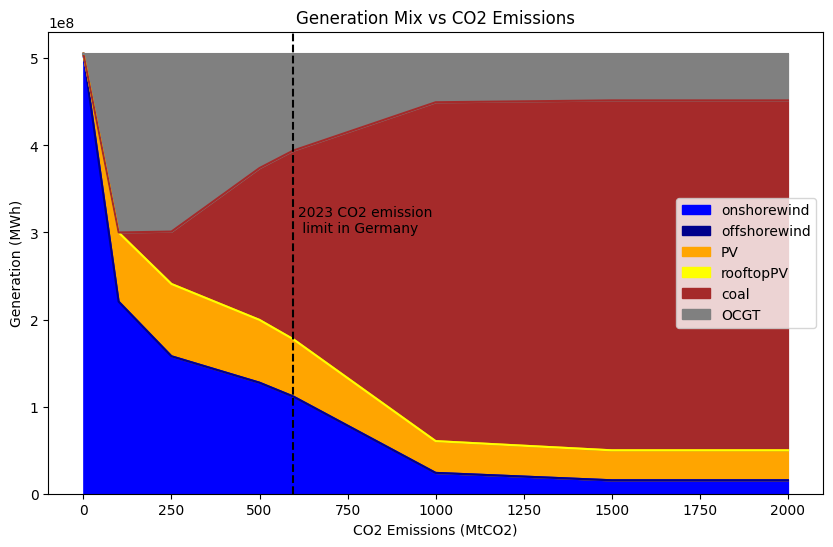

In [22]:
results = pd.DataFrame(
    np.array([onwind, offwind, pv, rooftop, coal, ocgt]).T,
    columns=["onshorewind", "offshorewind", "PV", "rooftopPV", "coal", "OCGT"],
    index=[2000, 1500, 1000, 596, 500, 250, 100, 0],
)
results.plot.area(
    stacked=True,
    title="Generation Mix vs CO2 Emissions",
    ylabel="Generation (MWh)",
    xlabel="CO2 Emissions (MtCO2)",
    color=colors,
    figsize=(10, 6),
)
plt.vlines(
    596, 0, 6e8, color="black", linestyle="--", label="2023 CO2 emission limit"
)
plt.text(
    610, 3e8, "2023 CO2 emission\n limit in Germany", color="black", fontsize=10, ha="left"
)


<AxesSubplot: title={'center': 'Generation Capacity vs CO2 Emissions'}, xlabel='CO2 Emissions (MtCO2)', ylabel='Generation Capacity (MW)'>

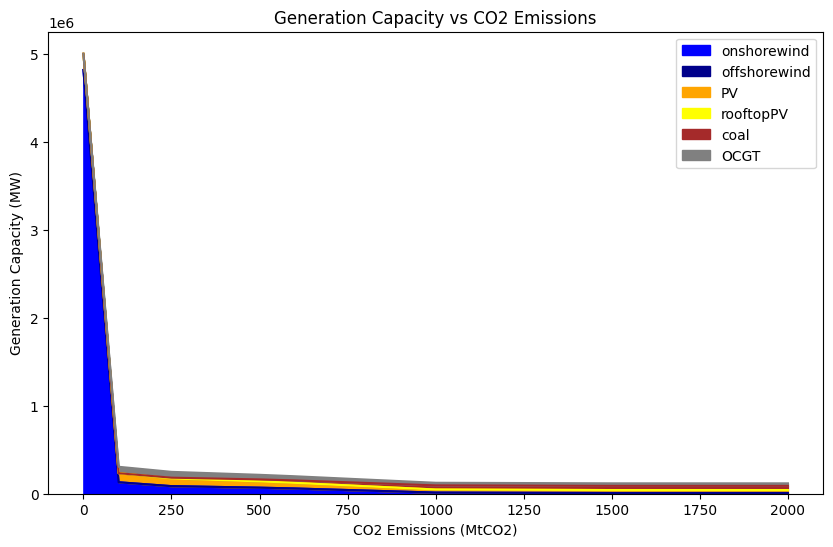

In [23]:
results_cap = pd.DataFrame(
    np.array([onwind_cap, offwind_cap, pv_cap, rooftop_cap, coal_cap, ocgt_cap]).T,
    columns=["onshorewind", "offshorewind", "PV", "rooftopPV", "coal", "OCGT"],
    index=[2000, 1500, 1000, 596, 500, 250, 100, 0],
)
results_cap.plot.area(
    stacked=True,
    title="Generation Capacity vs CO2 Emissions",
    ylabel="Generation Capacity (MW)",
    xlabel="CO2 Emissions (MtCO2)",
    color=colors,
    figsize=(10, 6),
)

Text(0, 0.5, 'System Cost (million euros)')

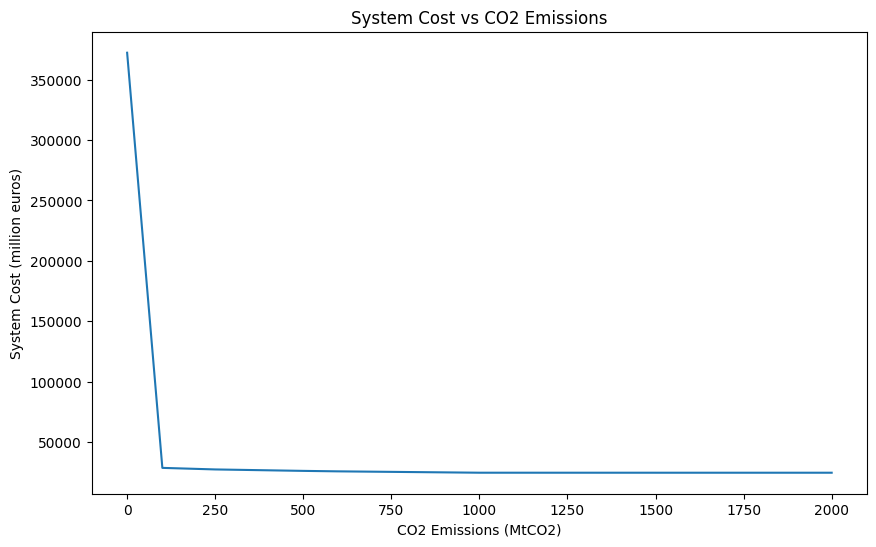

In [24]:
plt.figure(figsize=(10, 6))
plt.plot([2000, 1500, 1000, 596, 500, 250, 100, 0], systemcost)
plt.title("System Cost vs CO2 Emissions")
plt.xlabel("CO2 Emissions (MtCO2)")
plt.ylabel("System Cost (million euros)")

In [25]:
co2_tax

[-0.0,
 -0.0,
 0.586480549218269,
 3.802899180451094,
 4.173332350112169,
 5.337998133562092,
 50.242697968656486,
 8138720.623421226]

# Section C

In [26]:
years = df_offshorewind.index.year.unique()
years = years[(years >= 2001) & (years != 2016) & (years != 2012) & (years != 2008) & (years != 2004)]

# Remove the CO2 cap constraint
network.global_constraints.drop("CO2Limit", inplace=True)


systemcost = []
onwind = []
offwind = []
pv = []
rooftop = []
coal = []
ocgt = []

onwind_cap = []
offwind_cap = []
pv_cap = []
rooftop_cap = []
coal_cap = []
ocgt_cap = []


for year in years:
    network.generators_t.p_max_pu["onshorewind"] = df_onshorewind[country][df_onshorewind.index.year == year].values
    network.generators_t.p_max_pu["offshorewind"] = df_offshorewind[country][df_offshorewind.index.year == year].values
    network.generators_t.p_max_pu["PV"] = df_pv[country][df_pv.index.year == year].values
    network.generators_t.p_max_pu["rooftopPV"] = df_rooftop[country][df_rooftop.index.year == year].values
    
    network.optimize(solver_name="gurobi")
    systemcost.append(network.objective / 1e6)  # in million euros
    onwind.append(network.generators_t.p["onshorewind"].sum())
    offwind.append(network.generators_t.p["offshorewind"].sum())
    pv.append(network.generators_t.p["PV"].sum())
    rooftop.append(network.generators_t.p["rooftopPV"].sum())
    coal.append(network.generators_t.p["coal"].sum())
    ocgt.append(network.generators_t.p["OCGT"].sum())

    onwind_cap.append(network.generators.p_nom_opt.loc["onshorewind"])
    offwind_cap.append(network.generators.p_nom_opt.loc["offshorewind"])
    pv_cap.append(network.generators.p_nom_opt.loc["PV"])
    rooftop_cap.append(network.generators.p_nom_opt.loc["rooftopPV"])
    coal_cap.append(network.generators.p_nom_opt.loc["coal"])
    ocgt_cap.append(network.generators.p_nom_opt.loc["OCGT"])
    

Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 16.92it/s]
INFO:linopy.io: Writing time: 0.75s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-s4_3wxic.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-s4_3wxic.lp


Reading time = 0.24 seconds


INFO:gurobipy:Reading time = 0.24 seconds


obj: 113886 rows, 52566 columns, 201768 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201768 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201768 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201768 nonzeros


Model fingerprint: 0xc39c5a18


INFO:gurobipy:Model fingerprint: 0xc39c5a18


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61044 rows and 8478 columns


INFO:gurobipy:Presolve removed 61044 rows and 8478 columns


Presolve time: 0.13s


INFO:gurobipy:Presolve time: 0.13s


Presolved: 52842 rows, 44088 columns, 132246 nonzeros


INFO:gurobipy:Presolved: 52842 rows, 44088 columns, 132246 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.36861268e+11  0.00000000e+00  6.36e+05 0.00e+00  2.02e+08     0s


INFO:gurobipy:   0   3.36861268e+11  0.00000000e+00  6.36e+05 0.00e+00  2.02e+08     0s


   1   5.09086687e+11 -7.41020650e+11  8.84e+04 3.60e+02  4.27e+07     0s


INFO:gurobipy:   1   5.09086687e+11 -7.41020650e+11  8.84e+04 3.60e+02  4.27e+07     0s


   2   3.40015833e+11 -2.74171672e+11  1.16e-10 4.47e+00  4.93e+06     0s


INFO:gurobipy:   2   3.40015833e+11 -2.74171672e+11  1.16e-10 4.47e+00  4.93e+06     0s


   3   1.21162310e+11 -2.46831029e+10  1.75e-10 4.64e-01  1.12e+06     0s


INFO:gurobipy:   3   1.21162310e+11 -2.46831029e+10  1.75e-10 4.64e-01  1.12e+06     0s


   4   8.01192312e+10  4.97536699e+09  1.46e-10 8.08e-02  5.73e+05     0s


INFO:gurobipy:   4   8.01192312e+10  4.97536699e+09  1.46e-10 8.08e-02  5.73e+05     0s


   5   5.59561065e+10  1.25972594e+10  1.75e-10 9.35e-10  3.30e+05     0s


INFO:gurobipy:   5   5.59561065e+10  1.25972594e+10  1.75e-10 9.35e-10  3.30e+05     0s


   6   4.17757760e+10  1.71042656e+10  3.49e-10 4.07e-10  1.88e+05     0s


INFO:gurobipy:   6   4.17757760e+10  1.71042656e+10  3.49e-10 4.07e-10  1.88e+05     0s


   7   3.93349331e+10  2.12519259e+10  1.57e-09 2.65e-09  1.37e+05     1s


INFO:gurobipy:   7   3.93349331e+10  2.12519259e+10  1.57e-09 2.65e-09  1.37e+05     1s


   8   3.48124951e+10  2.25661295e+10  1.19e-07 9.46e-10  9.29e+04     1s


INFO:gurobipy:   8   3.48124951e+10  2.25661295e+10  1.19e-07 9.46e-10  9.29e+04     1s


   9   2.88784739e+10  2.33180685e+10  1.90e-07 8.80e-10  4.22e+04     1s


INFO:gurobipy:   9   2.88784739e+10  2.33180685e+10  1.90e-07 8.80e-10  4.22e+04     1s


  10   2.71912269e+10  2.41434587e+10  7.89e-07 1.09e-09  2.31e+04     1s


INFO:gurobipy:  10   2.71912269e+10  2.41434587e+10  7.89e-07 1.09e-09  2.31e+04     1s


  11   2.62897959e+10  2.44317523e+10  1.42e-07 4.61e-10  1.41e+04     1s


INFO:gurobipy:  11   2.62897959e+10  2.44317523e+10  1.42e-07 4.61e-10  1.41e+04     1s


  12   2.58429692e+10  2.45365866e+10  1.89e-06 3.28e-10  9.90e+03     1s


INFO:gurobipy:  12   2.58429692e+10  2.45365866e+10  1.89e-06 3.28e-10  9.90e+03     1s


  13   2.56140150e+10  2.46337769e+10  4.93e-07 3.42e-10  7.43e+03     1s


INFO:gurobipy:  13   2.56140150e+10  2.46337769e+10  4.93e-07 3.42e-10  7.43e+03     1s


  14   2.54053755e+10  2.47407845e+10  1.34e-06 2.96e-10  5.04e+03     1s


INFO:gurobipy:  14   2.54053755e+10  2.47407845e+10  1.34e-06 2.96e-10  5.04e+03     1s


  15   2.53058577e+10  2.47721285e+10  1.18e-06 8.88e-10  4.05e+03     1s


INFO:gurobipy:  15   2.53058577e+10  2.47721285e+10  1.18e-06 8.88e-10  4.05e+03     1s


  16   2.52172856e+10  2.48198132e+10  1.30e-06 3.78e-10  3.01e+03     1s


INFO:gurobipy:  16   2.52172856e+10  2.48198132e+10  1.30e-06 3.78e-10  3.01e+03     1s


  17   2.51439958e+10  2.48484803e+10  8.29e-07 1.05e-09  2.24e+03     1s


INFO:gurobipy:  17   2.51439958e+10  2.48484803e+10  8.29e-07 1.05e-09  2.24e+03     1s


  18   2.51131003e+10  2.48574001e+10  4.66e-07 1.49e-09  1.94e+03     1s


INFO:gurobipy:  18   2.51131003e+10  2.48574001e+10  4.66e-07 1.49e-09  1.94e+03     1s


  19   2.50862087e+10  2.48667590e+10  3.16e-07 1.41e-09  1.66e+03     1s


INFO:gurobipy:  19   2.50862087e+10  2.48667590e+10  3.16e-07 1.41e-09  1.66e+03     1s


  20   2.50594646e+10  2.48747276e+10  9.73e-07 1.21e-09  1.40e+03     1s


INFO:gurobipy:  20   2.50594646e+10  2.48747276e+10  9.73e-07 1.21e-09  1.40e+03     1s


  21   2.50431055e+10  2.48867065e+10  9.84e-07 1.13e-09  1.19e+03     1s


INFO:gurobipy:  21   2.50431055e+10  2.48867065e+10  9.84e-07 1.13e-09  1.19e+03     1s


  22   2.50205169e+10  2.48960883e+10  1.13e-06 3.34e-09  9.43e+02     1s


INFO:gurobipy:  22   2.50205169e+10  2.48960883e+10  1.13e-06 3.34e-09  9.43e+02     1s


  23   2.50051241e+10  2.49012245e+10  3.31e-07 6.31e-09  7.88e+02     1s


INFO:gurobipy:  23   2.50051241e+10  2.49012245e+10  3.31e-07 6.31e-09  7.88e+02     1s


  24   2.50005192e+10  2.49029297e+10  3.16e-07 5.97e-09  7.40e+02     1s


INFO:gurobipy:  24   2.50005192e+10  2.49029297e+10  3.16e-07 5.97e-09  7.40e+02     1s


  25   2.49913180e+10  2.49074682e+10  3.01e-07 5.43e-09  6.35e+02     1s


INFO:gurobipy:  25   2.49913180e+10  2.49074682e+10  3.01e-07 5.43e-09  6.35e+02     1s


  26   2.49865089e+10  2.49088069e+10  2.64e-07 6.21e-09  5.89e+02     1s


INFO:gurobipy:  26   2.49865089e+10  2.49088069e+10  2.64e-07 6.21e-09  5.89e+02     1s


  27   2.49814097e+10  2.49116763e+10  2.25e-07 7.00e-09  5.28e+02     1s


INFO:gurobipy:  27   2.49814097e+10  2.49116763e+10  2.25e-07 7.00e-09  5.28e+02     1s


  28   2.49747287e+10  2.49125063e+10  3.21e-07 7.99e-09  4.72e+02     1s


INFO:gurobipy:  28   2.49747287e+10  2.49125063e+10  3.21e-07 7.99e-09  4.72e+02     1s


  29   2.49714955e+10  2.49133857e+10  3.68e-07 8.13e-09  4.40e+02     2s


INFO:gurobipy:  29   2.49714955e+10  2.49133857e+10  3.68e-07 8.13e-09  4.40e+02     2s


  30   2.49665222e+10  2.49155626e+10  3.45e-07 1.86e-08  3.86e+02     2s


INFO:gurobipy:  30   2.49665222e+10  2.49155626e+10  3.45e-07 1.86e-08  3.86e+02     2s


  31   2.49641250e+10  2.49162898e+10  5.63e-07 2.00e-08  3.62e+02     2s


INFO:gurobipy:  31   2.49641250e+10  2.49162898e+10  5.63e-07 2.00e-08  3.62e+02     2s


  32   2.49615049e+10  2.49175590e+10  5.77e-07 2.14e-08  3.33e+02     2s


INFO:gurobipy:  32   2.49615049e+10  2.49175590e+10  5.77e-07 2.14e-08  3.33e+02     2s


  33   2.49568839e+10  2.49183716e+10  4.67e-07 2.17e-08  2.92e+02     2s


INFO:gurobipy:  33   2.49568839e+10  2.49183716e+10  4.67e-07 2.17e-08  2.92e+02     2s


  34   2.49550558e+10  2.49188635e+10  6.24e-07 2.36e-08  2.74e+02     2s


INFO:gurobipy:  34   2.49550558e+10  2.49188635e+10  6.24e-07 2.36e-08  2.74e+02     2s


  35   2.49508576e+10  2.49205262e+10  9.62e-07 3.06e-08  2.30e+02     2s


INFO:gurobipy:  35   2.49508576e+10  2.49205262e+10  9.62e-07 3.06e-08  2.30e+02     2s


  36   2.49478660e+10  2.49209886e+10  7.63e-07 3.20e-08  2.04e+02     2s


INFO:gurobipy:  36   2.49478660e+10  2.49209886e+10  7.63e-07 3.20e-08  2.04e+02     2s


  37   2.49458348e+10  2.49221974e+10  3.65e-07 3.62e-08  1.79e+02     2s


INFO:gurobipy:  37   2.49458348e+10  2.49221974e+10  3.65e-07 3.62e-08  1.79e+02     2s


  38   2.49437083e+10  2.49224043e+10  1.17e-06 3.64e-08  1.61e+02     2s


INFO:gurobipy:  38   2.49437083e+10  2.49224043e+10  1.17e-06 3.64e-08  1.61e+02     2s


  39   2.49428921e+10  2.49229311e+10  1.01e-06 3.44e-08  1.51e+02     2s


INFO:gurobipy:  39   2.49428921e+10  2.49229311e+10  1.01e-06 3.44e-08  1.51e+02     2s


  40   2.49407200e+10  2.49231708e+10  8.85e-07 3.40e-08  1.33e+02     2s


INFO:gurobipy:  40   2.49407200e+10  2.49231708e+10  8.85e-07 3.40e-08  1.33e+02     2s


  41   2.49385046e+10  2.49235096e+10  8.06e-07 3.00e-08  1.14e+02     2s


INFO:gurobipy:  41   2.49385046e+10  2.49235096e+10  8.06e-07 3.00e-08  1.14e+02     2s


  42   2.49377322e+10  2.49236872e+10  7.67e-07 2.86e-08  1.06e+02     2s


INFO:gurobipy:  42   2.49377322e+10  2.49236872e+10  7.67e-07 2.86e-08  1.06e+02     2s


  43   2.49359212e+10  2.49238398e+10  6.87e-07 2.58e-08  9.15e+01     2s


INFO:gurobipy:  43   2.49359212e+10  2.49238398e+10  6.87e-07 2.58e-08  9.15e+01     2s


INFO:gurobipy:


Barrier performed 43 iterations in 2.16 seconds (0.83 work units)


INFO:gurobipy:Barrier performed 43 iterations in 2.16 seconds (0.83 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33052    2.4925832e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   33052    2.4925832e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 33052 iterations and 2.23 seconds (1.10 work units)


INFO:gurobipy:Solved in 33052 iterations and 2.23 seconds (1.10 work units)


Optimal objective  2.492583166e+10


INFO:gurobipy:Optimal objective  2.492583166e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.49e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 17.88it/s]
INFO:linopy.io: Writing time: 0.76s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-4ha7lu60.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-4ha7lu60.lp


Reading time = 0.24 seconds


INFO:gurobipy:Reading time = 0.24 seconds


obj: 113886 rows, 52566 columns, 201733 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201733 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201733 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201733 nonzeros


Model fingerprint: 0x224f6b3c


INFO:gurobipy:Model fingerprint: 0x224f6b3c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61079 rows and 8513 columns


INFO:gurobipy:Presolve removed 61079 rows and 8513 columns


Presolve time: 0.13s


INFO:gurobipy:Presolve time: 0.13s


Presolved: 52807 rows, 44053 columns, 132141 nonzeros


INFO:gurobipy:Presolved: 52807 rows, 44053 columns, 132141 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.809e+04


INFO:gurobipy: AA' NZ     : 8.809e+04


 Factor NZ  : 4.642e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.642e+05 (roughly 40 MB of memory)


 Factor Ops : 4.363e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.363e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.16152772e+11  0.00000000e+00  6.29e+05 0.00e+00  1.95e+08     0s


INFO:gurobipy:   0   3.16152772e+11  0.00000000e+00  6.29e+05 0.00e+00  1.95e+08     0s


   1   4.65605470e+11 -7.09938934e+11  9.47e+04 3.52e+02  4.48e+07     0s


INFO:gurobipy:   1   4.65605470e+11 -7.09938934e+11  9.47e+04 3.52e+02  4.48e+07     0s


   2   3.42703217e+11 -2.90156196e+11  1.16e-10 5.79e+00  5.15e+06     0s


INFO:gurobipy:   2   3.42703217e+11 -2.90156196e+11  1.16e-10 5.79e+00  5.15e+06     0s


   3   9.99200160e+10 -1.46925019e+10  1.16e-10 3.65e-01  8.84e+05     0s


INFO:gurobipy:   3   9.99200160e+10 -1.46925019e+10  1.16e-10 3.65e-01  8.84e+05     0s


   4   7.21577109e+10  6.86949843e+09  1.16e-10 5.56e-02  4.99e+05     0s


INFO:gurobipy:   4   7.21577109e+10  6.86949843e+09  1.16e-10 5.56e-02  4.99e+05     0s


   5   5.66116696e+10  1.30192769e+10  1.16e-10 1.10e-02  3.32e+05     0s


INFO:gurobipy:   5   5.66116696e+10  1.30192769e+10  1.16e-10 1.10e-02  3.32e+05     0s


   6   4.12573623e+10  1.60254236e+10  5.24e-10 2.66e-09  1.92e+05     1s


INFO:gurobipy:   6   4.12573623e+10  1.60254236e+10  5.24e-10 2.66e-09  1.92e+05     1s


   7   3.76207590e+10  2.11711161e+10  7.31e-09 6.28e-10  1.25e+05     1s


INFO:gurobipy:   7   3.76207590e+10  2.11711161e+10  7.31e-09 6.28e-10  1.25e+05     1s


   8   3.56581335e+10  2.20602774e+10  2.73e-07 7.12e-10  1.03e+05     1s


INFO:gurobipy:   8   3.56581335e+10  2.20602774e+10  2.73e-07 7.12e-10  1.03e+05     1s


   9   2.99316909e+10  2.28271099e+10  1.25e-06 8.11e-10  5.39e+04     1s


INFO:gurobipy:   9   2.99316909e+10  2.28271099e+10  1.25e-06 8.11e-10  5.39e+04     1s


  10   2.70075827e+10  2.36229907e+10  1.62e-06 1.31e-10  2.57e+04     1s


INFO:gurobipy:  10   2.70075827e+10  2.36229907e+10  1.62e-06 1.31e-10  2.57e+04     1s


  11   2.65250996e+10  2.42197985e+10  9.21e-07 9.02e-10  1.75e+04     1s


INFO:gurobipy:  11   2.65250996e+10  2.42197985e+10  9.21e-07 9.02e-10  1.75e+04     1s


  12   2.56999596e+10  2.44334928e+10  3.72e-06 2.60e-09  9.60e+03     1s


INFO:gurobipy:  12   2.56999596e+10  2.44334928e+10  3.72e-06 2.60e-09  9.60e+03     1s


  13   2.52993924e+10  2.45424298e+10  2.25e-06 2.19e-09  5.74e+03     1s


INFO:gurobipy:  13   2.52993924e+10  2.45424298e+10  2.25e-06 2.19e-09  5.74e+03     1s


  14   2.51356052e+10  2.46352661e+10  1.32e-06 5.82e-10  3.79e+03     1s


INFO:gurobipy:  14   2.51356052e+10  2.46352661e+10  1.32e-06 5.82e-10  3.79e+03     1s


  15   2.50307290e+10  2.46674365e+10  1.17e-06 2.68e-10  2.76e+03     1s


INFO:gurobipy:  15   2.50307290e+10  2.46674365e+10  1.17e-06 2.68e-10  2.76e+03     1s


  16   2.49632950e+10  2.47131130e+10  7.41e-07 4.55e-13  1.90e+03     1s


INFO:gurobipy:  16   2.49632950e+10  2.47131130e+10  7.41e-07 4.55e-13  1.90e+03     1s


  17   2.49005477e+10  2.47390949e+10  4.55e-07 7.71e-10  1.22e+03     1s


INFO:gurobipy:  17   2.49005477e+10  2.47390949e+10  4.55e-07 7.71e-10  1.22e+03     1s


  18   2.48816503e+10  2.47570449e+10  6.71e-08 6.77e-10  9.45e+02     1s


INFO:gurobipy:  18   2.48816503e+10  2.47570449e+10  6.71e-08 6.77e-10  9.45e+02     1s


  19   2.48610917e+10  2.47664586e+10  1.30e-07 3.34e-10  7.18e+02     1s


INFO:gurobipy:  19   2.48610917e+10  2.47664586e+10  1.30e-07 3.34e-10  7.18e+02     1s


  20   2.48474768e+10  2.47725669e+10  2.79e-07 6.73e-10  5.69e+02     1s


INFO:gurobipy:  20   2.48474768e+10  2.47725669e+10  2.79e-07 6.73e-10  5.69e+02     1s


  21   2.48364908e+10  2.47879119e+10  2.68e-07 1.11e-09  3.69e+02     1s


INFO:gurobipy:  21   2.48364908e+10  2.47879119e+10  2.68e-07 1.11e-09  3.69e+02     1s


  22   2.48309455e+10  2.47912307e+10  2.30e-07 5.61e-10  3.01e+02     1s


INFO:gurobipy:  22   2.48309455e+10  2.47912307e+10  2.30e-07 5.61e-10  3.01e+02     1s


  23   2.48238346e+10  2.47947388e+10  3.32e-07 1.70e-10  2.21e+02     1s


INFO:gurobipy:  23   2.48238346e+10  2.47947388e+10  3.32e-07 1.70e-10  2.21e+02     1s


  24   2.48153897e+10  2.47978908e+10  1.57e-07 1.45e-09  1.33e+02     2s


INFO:gurobipy:  24   2.48153897e+10  2.47978908e+10  1.57e-07 1.45e-09  1.33e+02     2s


  25   2.48139172e+10  2.47999655e+10  2.46e-07 5.28e-10  1.06e+02     2s


INFO:gurobipy:  25   2.48139172e+10  2.47999655e+10  2.46e-07 5.28e-10  1.06e+02     2s


  26   2.48126714e+10  2.48007932e+10  1.88e-07 5.97e-10  9.03e+01     2s


INFO:gurobipy:  26   2.48126714e+10  2.48007932e+10  1.88e-07 5.97e-10  9.03e+01     2s


  27   2.48118107e+10  2.48026460e+10  6.85e-07 6.14e-10  6.97e+01     2s


INFO:gurobipy:  27   2.48118107e+10  2.48026460e+10  6.85e-07 6.14e-10  6.97e+01     2s


  28   2.48110451e+10  2.48046039e+10  1.38e-06 5.77e-10  4.90e+01     2s


INFO:gurobipy:  28   2.48110451e+10  2.48046039e+10  1.38e-06 5.77e-10  4.90e+01     2s


  29   2.48104450e+10  2.48053406e+10  3.35e-07 3.72e-12  3.88e+01     2s


INFO:gurobipy:  29   2.48104450e+10  2.48053406e+10  3.35e-07 3.72e-12  3.88e+01     2s


  30   2.48102297e+10  2.48057595e+10  5.06e-07 7.93e-11  3.40e+01     2s


INFO:gurobipy:  30   2.48102297e+10  2.48057595e+10  5.06e-07 7.93e-11  3.40e+01     2s


  31   2.48096039e+10  2.48070341e+10  1.80e-06 2.31e-09  1.96e+01     2s


INFO:gurobipy:  31   2.48096039e+10  2.48070341e+10  1.80e-06 2.31e-09  1.96e+01     2s


  32   2.48095108e+10  2.48075628e+10  1.05e-06 4.25e-09  1.48e+01     2s


INFO:gurobipy:  32   2.48095108e+10  2.48075628e+10  1.05e-06 4.25e-09  1.48e+01     2s


  33   2.48093591e+10  2.48084029e+10  1.61e-06 4.21e-09  7.28e+00     2s


INFO:gurobipy:  33   2.48093591e+10  2.48084029e+10  1.61e-06 4.21e-09  7.28e+00     2s


  34   2.48093252e+10  2.48088215e+10  5.23e-06 2.07e-09  3.84e+00     2s


INFO:gurobipy:  34   2.48093252e+10  2.48088215e+10  5.23e-06 2.07e-09  3.84e+00     2s


  35   2.48092915e+10  2.48090089e+10  5.18e-06 1.59e-09  2.15e+00     2s


INFO:gurobipy:  35   2.48092915e+10  2.48090089e+10  5.18e-06 1.59e-09  2.15e+00     2s


  36   2.48092900e+10  2.48090983e+10  4.83e-06 1.13e-08  1.46e+00     2s


INFO:gurobipy:  36   2.48092900e+10  2.48090983e+10  4.83e-06 1.13e-08  1.46e+00     2s


  37   2.48092853e+10  2.48092406e+10  4.04e-06 1.63e-09  3.41e-01     2s


INFO:gurobipy:  37   2.48092853e+10  2.48092406e+10  4.04e-06 1.63e-09  3.41e-01     2s


  38   2.48092851e+10  2.48092736e+10  1.77e-06 8.16e-09  8.75e-02     2s


INFO:gurobipy:  38   2.48092851e+10  2.48092736e+10  1.77e-06 8.16e-09  8.75e-02     2s


  39   2.48092846e+10  2.48092845e+10  6.28e-08 1.43e-09  5.46e-04     2s


INFO:gurobipy:  39   2.48092846e+10  2.48092845e+10  6.28e-08 1.43e-09  5.46e-04     2s


  40   2.48092846e+10  2.48092846e+10  3.93e-10 1.68e-09  1.67e-06     2s


INFO:gurobipy:  40   2.48092846e+10  2.48092846e+10  3.93e-10 1.68e-09  1.67e-06     2s


  41   2.48092846e+10  2.48092846e+10  1.66e-09 1.55e-09  1.67e-09     3s


INFO:gurobipy:  41   2.48092846e+10  2.48092846e+10  1.66e-09 1.55e-09  1.67e-09     3s


INFO:gurobipy:


Barrier solved model in 41 iterations and 2.51 seconds (0.78 work units)


INFO:gurobipy:Barrier solved model in 41 iterations and 2.51 seconds (0.78 work units)


Optimal objective 2.48092846e+10


INFO:gurobipy:Optimal objective 2.48092846e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13282 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:   13282 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 3s


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8433167e-10      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8433167e-10      3s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13286    2.4809285e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13286    2.4809285e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13286 iterations and 2.89 seconds (0.84 work units)


INFO:gurobipy:Solved in 13286 iterations and 2.89 seconds (0.84 work units)


Optimal objective  2.480928456e+10


INFO:gurobipy:Optimal objective  2.480928456e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.88it/s]
INFO:linopy.io: Writing time: 0.8s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-o2ddngje.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-o2ddngje.lp


Reading time = 0.28 seconds


INFO:gurobipy:Reading time = 0.28 seconds


obj: 113886 rows, 52566 columns, 201756 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201756 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201756 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201756 nonzeros


Model fingerprint: 0x3a3f7fcf


INFO:gurobipy:Model fingerprint: 0x3a3f7fcf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61056 rows and 8490 columns


INFO:gurobipy:Presolve removed 61056 rows and 8490 columns


Presolve time: 0.21s


INFO:gurobipy:Presolve time: 0.21s


Presolved: 52830 rows, 44076 columns, 132210 nonzeros


INFO:gurobipy:Presolved: 52830 rows, 44076 columns, 132210 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.814e+04


INFO:gurobipy: AA' NZ     : 8.814e+04


 Factor NZ  : 4.646e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.646e+05 (roughly 40 MB of memory)


 Factor Ops : 4.369e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.369e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.31017209e+11  0.00000000e+00  6.23e+05 0.00e+00  1.99e+08     0s


INFO:gurobipy:   0   3.31017209e+11  0.00000000e+00  6.23e+05 0.00e+00  1.99e+08     0s


   1   4.95144804e+11 -7.77854446e+11  8.79e+04 3.63e+02  4.21e+07     0s


INFO:gurobipy:   1   4.95144804e+11 -7.77854446e+11  8.79e+04 3.63e+02  4.21e+07     0s


   2   3.31334736e+11 -2.74026881e+11  1.16e-10 6.41e+00  4.95e+06     0s


INFO:gurobipy:   2   3.31334736e+11 -2.74026881e+11  1.16e-10 6.41e+00  4.95e+06     0s


   3   1.31204554e+11 -1.04629706e+10  2.33e-10 3.48e-01  1.09e+06     1s


INFO:gurobipy:   3   1.31204554e+11 -1.04629706e+10  2.33e-10 3.48e-01  1.09e+06     1s


   4   8.48185810e+10  6.18706062e+09  1.16e-10 1.31e-01  6.01e+05     1s


INFO:gurobipy:   4   8.48185810e+10  6.18706062e+09  1.16e-10 1.31e-01  6.01e+05     1s


   5   5.80068380e+10  9.56730376e+09  1.75e-10 1.31e-01  3.70e+05     1s


INFO:gurobipy:   5   5.80068380e+10  9.56730376e+09  1.75e-10 1.31e-01  3.70e+05     1s


   6   4.38627444e+10  1.29058106e+10  4.22e-10 6.41e-02  2.36e+05     1s


INFO:gurobipy:   6   4.38627444e+10  1.29058106e+10  4.22e-10 6.41e-02  2.36e+05     1s


   7   3.90399817e+10  1.91920248e+10  1.51e-09 2.59e-02  1.51e+05     1s


INFO:gurobipy:   7   3.90399817e+10  1.91920248e+10  1.51e-09 2.59e-02  1.51e+05     1s


   8   3.56597577e+10  2.12810740e+10  1.23e-08 1.91e-02  1.09e+05     1s


INFO:gurobipy:   8   3.56597577e+10  2.12810740e+10  1.23e-08 1.91e-02  1.09e+05     1s


   9   2.96924895e+10  2.24764766e+10  2.88e-08 7.86e-03  5.49e+04     1s


INFO:gurobipy:   9   2.96924895e+10  2.24764766e+10  2.88e-08 7.86e-03  5.49e+04     1s


  10   2.72625295e+10  2.35368545e+10  5.79e-08 2.96e-03  2.83e+04     1s


INFO:gurobipy:  10   2.72625295e+10  2.35368545e+10  5.79e-08 2.96e-03  2.83e+04     1s


  11   2.67299583e+10  2.40125513e+10  4.27e-08 2.23e-03  2.06e+04     1s


INFO:gurobipy:  11   2.67299583e+10  2.40125513e+10  4.27e-08 2.23e-03  2.06e+04     1s


  12   2.62921283e+10  2.41751921e+10  3.50e-06 1.86e-03  1.61e+04     1s


INFO:gurobipy:  12   2.62921283e+10  2.41751921e+10  3.50e-06 1.86e-03  1.61e+04     1s


  13   2.56952597e+10  2.42857977e+10  2.02e-06 1.09e-09  1.07e+04     1s


INFO:gurobipy:  13   2.56952597e+10  2.42857977e+10  2.02e-06 1.09e-09  1.07e+04     1s


  14   2.53416239e+10  2.44139957e+10  4.30e-07 5.07e-10  7.04e+03     1s


INFO:gurobipy:  14   2.53416239e+10  2.44139957e+10  4.30e-07 5.07e-10  7.04e+03     1s


  15   2.51598302e+10  2.44983037e+10  2.92e-07 7.81e-06  5.02e+03     1s


INFO:gurobipy:  15   2.51598302e+10  2.44983037e+10  2.92e-07 7.81e-06  5.02e+03     1s


  16   2.50439503e+10  2.45452057e+10  6.36e-07 2.11e-05  3.78e+03     1s


INFO:gurobipy:  16   2.50439503e+10  2.45452057e+10  6.36e-07 2.11e-05  3.78e+03     1s


  17   2.49520572e+10  2.45612307e+10  4.77e-07 2.13e-05  2.97e+03     1s


INFO:gurobipy:  17   2.49520572e+10  2.45612307e+10  4.77e-07 2.13e-05  2.97e+03     1s


  18   2.48966868e+10  2.45905316e+10  7.17e-07 1.97e-05  2.32e+03     1s


INFO:gurobipy:  18   2.48966868e+10  2.45905316e+10  7.17e-07 1.97e-05  2.32e+03     1s


  19   2.48435121e+10  2.46107891e+10  4.77e-07 1.60e-05  1.77e+03     1s


INFO:gurobipy:  19   2.48435121e+10  2.46107891e+10  4.77e-07 1.60e-05  1.77e+03     1s


  20   2.48087123e+10  2.46221957e+10  1.40e-07 1.43e-05  1.41e+03     1s


INFO:gurobipy:  20   2.48087123e+10  2.46221957e+10  1.40e-07 1.43e-05  1.41e+03     1s


  21   2.47833958e+10  2.46311901e+10  1.39e-07 1.22e-05  1.15e+03     1s


INFO:gurobipy:  21   2.47833958e+10  2.46311901e+10  1.39e-07 1.22e-05  1.15e+03     1s


  22   2.47611791e+10  2.46393263e+10  3.63e-07 9.60e-06  9.24e+02     1s


INFO:gurobipy:  22   2.47611791e+10  2.46393263e+10  3.63e-07 9.60e-06  9.24e+02     1s


  23   2.47454754e+10  2.46442007e+10  8.58e-08 7.73e-06  7.68e+02     1s


INFO:gurobipy:  23   2.47454754e+10  2.46442007e+10  8.58e-08 7.73e-06  7.68e+02     1s


  24   2.47416555e+10  2.46451612e+10  7.06e-08 7.29e-06  7.32e+02     1s


INFO:gurobipy:  24   2.47416555e+10  2.46451612e+10  7.06e-08 7.29e-06  7.32e+02     1s


  25   2.47285016e+10  2.46507280e+10  4.36e-07 4.75e-06  5.90e+02     1s


INFO:gurobipy:  25   2.47285016e+10  2.46507280e+10  4.36e-07 4.75e-06  5.90e+02     1s


  26   2.47187841e+10  2.46519222e+10  3.46e-07 4.19e-06  5.07e+02     2s


INFO:gurobipy:  26   2.47187841e+10  2.46519222e+10  3.46e-07 4.19e-06  5.07e+02     2s


  27   2.47119726e+10  2.46531570e+10  2.91e-07 3.56e-06  4.46e+02     2s


INFO:gurobipy:  27   2.47119726e+10  2.46531570e+10  2.91e-07 3.56e-06  4.46e+02     2s


  28   2.47033598e+10  2.46544560e+10  4.24e-07 2.95e-06  3.71e+02     2s


INFO:gurobipy:  28   2.47033598e+10  2.46544560e+10  4.24e-07 2.95e-06  3.71e+02     2s


  29   2.46974681e+10  2.46574040e+10  4.23e-07 1.62e-06  3.04e+02     2s


INFO:gurobipy:  29   2.46974681e+10  2.46574040e+10  4.23e-07 1.62e-06  3.04e+02     2s


  30   2.46920814e+10  2.46588591e+10  6.87e-07 9.90e-07  2.52e+02     2s


INFO:gurobipy:  30   2.46920814e+10  2.46588591e+10  6.87e-07 9.90e-07  2.52e+02     2s


  31   2.46869803e+10  2.46615428e+10  5.98e-07 2.88e-10  1.93e+02     2s


INFO:gurobipy:  31   2.46869803e+10  2.46615428e+10  5.98e-07 2.88e-10  1.93e+02     2s


  32   2.46838321e+10  2.46617608e+10  1.99e-06 7.99e-10  1.67e+02     2s


INFO:gurobipy:  32   2.46838321e+10  2.46617608e+10  1.99e-06 7.99e-10  1.67e+02     2s


  33   2.46807270e+10  2.46620206e+10  2.98e-06 8.60e-10  1.42e+02     2s


INFO:gurobipy:  33   2.46807270e+10  2.46620206e+10  2.98e-06 8.60e-10  1.42e+02     2s


  34   2.46791203e+10  2.46623668e+10  2.66e-06 8.58e-10  1.27e+02     2s


INFO:gurobipy:  34   2.46791203e+10  2.46623668e+10  2.66e-06 8.58e-10  1.27e+02     2s


  35   2.46772203e+10  2.46627846e+10  2.34e-06 9.28e-10  1.09e+02     2s


INFO:gurobipy:  35   2.46772203e+10  2.46627846e+10  2.34e-06 9.28e-10  1.09e+02     2s


  36   2.46750092e+10  2.46634693e+10  4.53e-06 9.42e-11  8.74e+01     2s


INFO:gurobipy:  36   2.46750092e+10  2.46634693e+10  4.53e-06 9.42e-11  8.74e+01     2s


  37   2.46741016e+10  2.46635847e+10  4.10e-06 0.00e+00  7.97e+01     2s


INFO:gurobipy:  37   2.46741016e+10  2.46635847e+10  4.10e-06 0.00e+00  7.97e+01     2s


  38   2.46726336e+10  2.46637387e+10  3.44e-06 1.07e-10  6.74e+01     2s


INFO:gurobipy:  38   2.46726336e+10  2.46637387e+10  3.44e-06 1.07e-10  6.74e+01     2s


  39   2.46710211e+10  2.46638798e+10  3.05e-06 3.04e-10  5.41e+01     2s


INFO:gurobipy:  39   2.46710211e+10  2.46638798e+10  3.05e-06 3.04e-10  5.41e+01     2s


  40   2.46701058e+10  2.46644271e+10  2.64e-06 4.00e-10  4.30e+01     2s


INFO:gurobipy:  40   2.46701058e+10  2.46644271e+10  2.64e-06 4.00e-10  4.30e+01     2s


  41   2.46698948e+10  2.46644585e+10  2.53e-06 9.06e-10  4.12e+01     2s


INFO:gurobipy:  41   2.46698948e+10  2.46644585e+10  2.53e-06 9.06e-10  4.12e+01     2s


  42   2.46688284e+10  2.46645277e+10  3.95e-06 1.47e-11  3.26e+01     2s


INFO:gurobipy:  42   2.46688284e+10  2.46645277e+10  3.95e-06 1.47e-11  3.26e+01     2s


  43   2.46682106e+10  2.46645814e+10  3.33e-06 6.77e-10  2.75e+01     2s


INFO:gurobipy:  43   2.46682106e+10  2.46645814e+10  3.33e-06 6.77e-10  2.75e+01     2s


  44   2.46677969e+10  2.46646701e+10  2.93e-06 9.21e-10  2.37e+01     2s


INFO:gurobipy:  44   2.46677969e+10  2.46646701e+10  2.93e-06 9.21e-10  2.37e+01     2s


  45   2.46671518e+10  2.46648105e+10  2.26e-06 2.21e-09  1.77e+01     2s


INFO:gurobipy:  45   2.46671518e+10  2.46648105e+10  2.26e-06 2.21e-09  1.77e+01     2s


  46   2.46661777e+10  2.46648456e+10  2.23e-06 8.97e-10  1.01e+01     3s


INFO:gurobipy:  46   2.46661777e+10  2.46648456e+10  2.23e-06 8.97e-10  1.01e+01     3s


  47   2.46658961e+10  2.46648759e+10  2.37e-06 1.07e-09  7.72e+00     3s


INFO:gurobipy:  47   2.46658961e+10  2.46648759e+10  2.37e-06 1.07e-09  7.72e+00     3s


  48   2.46652258e+10  2.46649385e+10  2.75e-06 9.02e-10  2.17e+00     3s


INFO:gurobipy:  48   2.46652258e+10  2.46649385e+10  2.75e-06 9.02e-10  2.17e+00     3s


  49   2.46651754e+10  2.46649402e+10  2.23e-06 1.11e-09  1.78e+00     3s


INFO:gurobipy:  49   2.46651754e+10  2.46649402e+10  2.23e-06 1.11e-09  1.78e+00     3s


  50   2.46650442e+10  2.46649456e+10  9.28e-07 4.51e-10  7.46e-01     3s


INFO:gurobipy:  50   2.46650442e+10  2.46649456e+10  9.28e-07 4.51e-10  7.46e-01     3s


  51   2.46649578e+10  2.46649485e+10  8.76e-08 5.34e-10  7.01e-02     3s


INFO:gurobipy:  51   2.46649578e+10  2.46649485e+10  8.76e-08 5.34e-10  7.01e-02     3s


  52   2.46649489e+10  2.46649487e+10  3.42e-10 1.74e-09  2.07e-03     3s


INFO:gurobipy:  52   2.46649489e+10  2.46649487e+10  3.42e-10 1.74e-09  2.07e-03     3s


  53   2.46649488e+10  2.46649488e+10  1.16e-09 1.10e-09  2.86e-08     3s


INFO:gurobipy:  53   2.46649488e+10  2.46649488e+10  1.16e-09 1.10e-09  2.86e-08     3s


  54   2.46649488e+10  2.46649488e+10  5.82e-11 1.26e-09  2.86e-14     3s


INFO:gurobipy:  54   2.46649488e+10  2.46649488e+10  5.82e-11 1.26e-09  2.86e-14     3s


INFO:gurobipy:


Barrier solved model in 54 iterations and 2.94 seconds (1.02 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 2.94 seconds (1.02 work units)


Optimal objective 2.46649488e+10


INFO:gurobipy:Optimal objective 2.46649488e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22056 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:   22056 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 3s


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.9210414e-11      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.9210414e-11      3s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   22060    2.4664949e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   22060    2.4664949e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 22060 iterations and 3.19 seconds (1.09 work units)


INFO:gurobipy:Solved in 22060 iterations and 3.19 seconds (1.09 work units)


Optimal objective  2.466494876e+10


INFO:gurobipy:Optimal objective  2.466494876e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.47e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 17.22it/s]
INFO:linopy.io: Writing time: 0.75s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-hj0wikfx.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-hj0wikfx.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 113886 rows, 52566 columns, 201763 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201763 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


Model fingerprint: 0xc9983026


INFO:gurobipy:Model fingerprint: 0xc9983026


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61049 rows and 8483 columns


INFO:gurobipy:Presolve removed 61049 rows and 8483 columns


Presolve time: 0.12s


INFO:gurobipy:Presolve time: 0.12s


Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.815e+04


INFO:gurobipy: AA' NZ     : 8.815e+04


 Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


 Factor Ops : 4.370e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.370e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.14757797e+11  0.00000000e+00  6.24e+05 0.00e+00  1.93e+08     0s


INFO:gurobipy:   0   3.14757797e+11  0.00000000e+00  6.24e+05 0.00e+00  1.93e+08     0s


   1   4.81957999e+11 -7.00036761e+11  8.85e+04 3.96e+02  4.37e+07     0s


INFO:gurobipy:   1   4.81957999e+11 -7.00036761e+11  8.85e+04 3.96e+02  4.37e+07     0s


   2   3.41291615e+11 -2.75273033e+11  2.33e-10 4.61e+00  4.95e+06     0s


INFO:gurobipy:   2   3.41291615e+11 -2.75273033e+11  2.33e-10 4.61e+00  4.95e+06     0s


   3   9.79211081e+10 -2.62252409e+10  1.46e-10 4.43e-01  9.58e+05     0s


INFO:gurobipy:   3   9.79211081e+10 -2.62252409e+10  1.46e-10 4.43e-01  9.58e+05     0s


   4   6.80253937e+10  6.94484167e+09  8.73e-11 8.90e-02  4.65e+05     0s


INFO:gurobipy:   4   6.80253937e+10  6.94484167e+09  8.73e-11 8.90e-02  4.65e+05     0s


   5   5.67222517e+10  1.10387173e+10  4.66e-10 3.91e-02  3.48e+05     0s


INFO:gurobipy:   5   5.67222517e+10  1.10387173e+10  4.66e-10 3.91e-02  3.48e+05     0s


   6   4.20131303e+10  1.49144329e+10  4.07e-10 5.91e-02  2.06e+05     0s


INFO:gurobipy:   6   4.20131303e+10  1.49144329e+10  4.07e-10 5.91e-02  2.06e+05     0s


   7   3.88450459e+10  2.07134093e+10  6.93e-09 3.65e-03  1.37e+05     1s


INFO:gurobipy:   7   3.88450459e+10  2.07134093e+10  6.93e-09 3.65e-03  1.37e+05     1s


   8   3.44033864e+10  2.21877420e+10  3.30e-08 1.22e-09  9.26e+04     1s


INFO:gurobipy:   8   3.44033864e+10  2.21877420e+10  3.30e-08 1.22e-09  9.26e+04     1s


   9   2.92421080e+10  2.30245609e+10  9.43e-08 6.62e-10  4.71e+04     1s


INFO:gurobipy:   9   2.92421080e+10  2.30245609e+10  9.43e-08 6.62e-10  4.71e+04     1s


  10   2.71335627e+10  2.38995287e+10  2.48e-07 1.43e-09  2.45e+04     1s


INFO:gurobipy:  10   2.71335627e+10  2.38995287e+10  2.48e-07 1.43e-09  2.45e+04     1s


  11   2.62328964e+10  2.42596211e+10  5.08e-07 3.45e-10  1.49e+04     1s


INFO:gurobipy:  11   2.62328964e+10  2.42596211e+10  5.08e-07 3.45e-10  1.49e+04     1s


  12   2.56822280e+10  2.43711077e+10  1.15e-06 4.80e-10  9.93e+03     1s


INFO:gurobipy:  12   2.56822280e+10  2.43711077e+10  1.15e-06 4.80e-10  9.93e+03     1s


  13   2.54163728e+10  2.44723215e+10  8.63e-07 6.84e-10  7.15e+03     1s


INFO:gurobipy:  13   2.54163728e+10  2.44723215e+10  8.63e-07 6.84e-10  7.15e+03     1s


  14   2.51840301e+10  2.45655775e+10  7.97e-07 7.20e-10  4.68e+03     1s


INFO:gurobipy:  14   2.51840301e+10  2.45655775e+10  7.97e-07 7.20e-10  4.68e+03     1s


  15   2.50813740e+10  2.45927833e+10  3.31e-06 9.66e-10  3.70e+03     1s


INFO:gurobipy:  15   2.50813740e+10  2.45927833e+10  3.31e-06 9.66e-10  3.70e+03     1s


  16   2.50020705e+10  2.46372137e+10  3.22e-06 1.57e-09  2.76e+03     1s


INFO:gurobipy:  16   2.50020705e+10  2.46372137e+10  3.22e-06 1.57e-09  2.76e+03     1s


  17   2.49355533e+10  2.46611719e+10  4.13e-06 6.48e-10  2.08e+03     1s


INFO:gurobipy:  17   2.49355533e+10  2.46611719e+10  4.13e-06 6.48e-10  2.08e+03     1s


  18   2.49208046e+10  2.46732338e+10  4.39e-06 1.27e-10  1.87e+03     1s


INFO:gurobipy:  18   2.49208046e+10  2.46732338e+10  4.39e-06 1.27e-10  1.87e+03     1s


  19   2.49050215e+10  2.47008213e+10  8.94e-06 6.70e-10  1.55e+03     1s


INFO:gurobipy:  19   2.49050215e+10  2.47008213e+10  8.94e-06 6.70e-10  1.55e+03     1s


  20   2.48336037e+10  2.47177959e+10  6.88e-05 9.46e-10  8.77e+02     1s


INFO:gurobipy:  20   2.48336037e+10  2.47177959e+10  6.88e-05 9.46e-10  8.77e+02     1s


  21   2.48192124e+10  2.47209236e+10  5.49e-05 3.01e-10  7.45e+02     1s


INFO:gurobipy:  21   2.48192124e+10  2.47209236e+10  5.49e-05 3.01e-10  7.45e+02     1s


  22   2.48104512e+10  2.47241958e+10  4.63e-05 1.43e-09  6.54e+02     1s


INFO:gurobipy:  22   2.48104512e+10  2.47241958e+10  4.63e-05 1.43e-09  6.54e+02     1s


  23   2.48032519e+10  2.47314315e+10  3.65e-05 2.36e-10  5.44e+02     1s


INFO:gurobipy:  23   2.48032519e+10  2.47314315e+10  3.65e-05 2.36e-10  5.44e+02     1s


  24   2.47991053e+10  2.47347463e+10  3.28e-05 6.94e-10  4.88e+02     1s


INFO:gurobipy:  24   2.47991053e+10  2.47347463e+10  3.28e-05 6.94e-10  4.88e+02     1s


  25   2.47954341e+10  2.47369416e+10  3.05e-05 9.31e-10  4.43e+02     1s


INFO:gurobipy:  25   2.47954341e+10  2.47369416e+10  3.05e-05 9.31e-10  4.43e+02     1s


  26   2.47908111e+10  2.47388208e+10  2.66e-05 1.43e-09  3.94e+02     1s


INFO:gurobipy:  26   2.47908111e+10  2.47388208e+10  2.66e-05 1.43e-09  3.94e+02     1s


  27   2.47873571e+10  2.47412026e+10  2.43e-05 4.74e-10  3.50e+02     1s


INFO:gurobipy:  27   2.47873571e+10  2.47412026e+10  2.43e-05 4.74e-10  3.50e+02     1s


  28   2.47835934e+10  2.47434814e+10  2.04e-05 1.08e-09  3.04e+02     1s


INFO:gurobipy:  28   2.47835934e+10  2.47434814e+10  2.04e-05 1.08e-09  3.04e+02     1s


  29   2.47820967e+10  2.47446245e+10  1.95e-05 5.13e-10  2.84e+02     2s


INFO:gurobipy:  29   2.47820967e+10  2.47446245e+10  1.95e-05 5.13e-10  2.84e+02     2s


  30   2.47798141e+10  2.47467084e+10  1.75e-05 7.19e-10  2.51e+02     2s


INFO:gurobipy:  30   2.47798141e+10  2.47467084e+10  1.75e-05 7.19e-10  2.51e+02     2s


  31   2.47769318e+10  2.47478050e+10  1.49e-05 7.89e-10  2.21e+02     2s


INFO:gurobipy:  31   2.47769318e+10  2.47478050e+10  1.49e-05 7.89e-10  2.21e+02     2s


  32   2.47763312e+10  2.47484093e+10  1.45e-05 7.30e-10  2.12e+02     2s


INFO:gurobipy:  32   2.47763312e+10  2.47484093e+10  1.45e-05 7.30e-10  2.12e+02     2s


  33   2.47745679e+10  2.47491394e+10  1.24e-05 8.07e-10  1.93e+02     2s


INFO:gurobipy:  33   2.47745679e+10  2.47491394e+10  1.24e-05 8.07e-10  1.93e+02     2s


  34   2.47728184e+10  2.47507193e+10  1.14e-05 1.05e-09  1.67e+02     2s


INFO:gurobipy:  34   2.47728184e+10  2.47507193e+10  1.14e-05 1.05e-09  1.67e+02     2s


  35   2.47708432e+10  2.47521818e+10  1.03e-05 1.17e-09  1.41e+02     2s


INFO:gurobipy:  35   2.47708432e+10  2.47521818e+10  1.03e-05 1.17e-09  1.41e+02     2s


  36   2.47689691e+10  2.47530089e+10  9.31e-06 2.09e-09  1.21e+02     2s


INFO:gurobipy:  36   2.47689691e+10  2.47530089e+10  9.31e-06 2.09e-09  1.21e+02     2s


  37   2.47682514e+10  2.47533768e+10  9.01e-06 1.78e-09  1.13e+02     2s


INFO:gurobipy:  37   2.47682514e+10  2.47533768e+10  9.01e-06 1.78e-09  1.13e+02     2s


  38   2.47670528e+10  2.47537007e+10  8.13e-06 1.43e-09  1.01e+02     2s


INFO:gurobipy:  38   2.47670528e+10  2.47537007e+10  8.13e-06 1.43e-09  1.01e+02     2s


  39   2.47664713e+10  2.47541442e+10  7.19e-06 1.68e-09  9.34e+01     2s


INFO:gurobipy:  39   2.47664713e+10  2.47541442e+10  7.19e-06 1.68e-09  9.34e+01     2s


  40   2.47656479e+10  2.47544981e+10  6.72e-06 2.02e-09  8.45e+01     2s


INFO:gurobipy:  40   2.47656479e+10  2.47544981e+10  6.72e-06 2.02e-09  8.45e+01     2s


  41   2.47644020e+10  2.47547425e+10  5.68e-06 2.08e-09  7.32e+01     2s


INFO:gurobipy:  41   2.47644020e+10  2.47547425e+10  5.68e-06 2.08e-09  7.32e+01     2s


  42   2.47640838e+10  2.47555226e+10  5.01e-06 1.40e-09  6.49e+01     2s


INFO:gurobipy:  42   2.47640838e+10  2.47555226e+10  5.01e-06 1.40e-09  6.49e+01     2s


  43   2.47637586e+10  2.47556126e+10  4.80e-06 1.31e-09  6.17e+01     2s


INFO:gurobipy:  43   2.47637586e+10  2.47556126e+10  4.80e-06 1.31e-09  6.17e+01     2s


  44   2.47634406e+10  2.47561114e+10  5.07e-06 9.97e-10  5.56e+01     2s


INFO:gurobipy:  44   2.47634406e+10  2.47561114e+10  5.07e-06 9.97e-10  5.56e+01     2s


  45   2.47629594e+10  2.47566012e+10  4.21e-06 3.66e-09  4.82e+01     2s


INFO:gurobipy:  45   2.47629594e+10  2.47566012e+10  4.21e-06 3.66e-09  4.82e+01     2s


  46   2.47626796e+10  2.47567760e+10  3.90e-06 3.65e-09  4.47e+01     2s


INFO:gurobipy:  46   2.47626796e+10  2.47567760e+10  3.90e-06 3.65e-09  4.47e+01     2s


  47   2.47622944e+10  2.47572078e+10  3.12e-06 2.70e-09  3.86e+01     2s


INFO:gurobipy:  47   2.47622944e+10  2.47572078e+10  3.12e-06 2.70e-09  3.86e+01     2s


  48   2.47622282e+10  2.47573240e+10  3.04e-06 2.57e-09  3.72e+01     2s


INFO:gurobipy:  48   2.47622282e+10  2.47573240e+10  3.04e-06 2.57e-09  3.72e+01     2s


  49   2.47618703e+10  2.47574843e+10  3.65e-06 2.67e-09  3.32e+01     2s


INFO:gurobipy:  49   2.47618703e+10  2.47574843e+10  3.65e-06 2.67e-09  3.32e+01     2s


  50   2.47617346e+10  2.47577158e+10  3.25e-06 2.23e-09  3.05e+01     2s


INFO:gurobipy:  50   2.47617346e+10  2.47577158e+10  3.25e-06 2.23e-09  3.05e+01     2s


  51   2.47615684e+10  2.47578267e+10  3.62e-06 1.80e-09  2.84e+01     2s


INFO:gurobipy:  51   2.47615684e+10  2.47578267e+10  3.62e-06 1.80e-09  2.84e+01     2s


  52   2.47615046e+10  2.47581089e+10  3.48e-06 5.36e-10  2.57e+01     3s


INFO:gurobipy:  52   2.47615046e+10  2.47581089e+10  3.48e-06 5.36e-10  2.57e+01     3s


  53   2.47613615e+10  2.47581955e+10  3.38e-06 1.62e-10  2.40e+01     3s


INFO:gurobipy:  53   2.47613615e+10  2.47581955e+10  3.38e-06 1.62e-10  2.40e+01     3s


  54   2.47605051e+10  2.47583602e+10  8.35e-06 1.91e-10  1.63e+01     3s


INFO:gurobipy:  54   2.47605051e+10  2.47583602e+10  8.35e-06 1.91e-10  1.63e+01     3s


  55   2.47604238e+10  2.47584243e+10  7.52e-06 1.54e-09  1.52e+01     3s


INFO:gurobipy:  55   2.47604238e+10  2.47584243e+10  7.52e-06 1.54e-09  1.52e+01     3s


  56   2.47603482e+10  2.47585255e+10  6.91e-06 6.78e-10  1.38e+01     3s


INFO:gurobipy:  56   2.47603482e+10  2.47585255e+10  6.91e-06 6.78e-10  1.38e+01     3s


  57   2.47601658e+10  2.47586540e+10  5.12e-06 7.87e-10  1.15e+01     3s


INFO:gurobipy:  57   2.47601658e+10  2.47586540e+10  5.12e-06 7.87e-10  1.15e+01     3s


  58   2.47600604e+10  2.47587934e+10  4.27e-06 3.42e-10  9.61e+00     3s


INFO:gurobipy:  58   2.47600604e+10  2.47587934e+10  4.27e-06 3.42e-10  9.61e+00     3s


  59   2.47599969e+10  2.47589101e+10  3.66e-06 4.15e-10  8.24e+00     3s


INFO:gurobipy:  59   2.47599969e+10  2.47589101e+10  3.66e-06 4.15e-10  8.24e+00     3s


  60   2.47599936e+10  2.47589493e+10  3.63e-06 1.32e-10  7.92e+00     3s


INFO:gurobipy:  60   2.47599936e+10  2.47589493e+10  3.63e-06 1.32e-10  7.92e+00     3s


  61   2.47599323e+10  2.47591374e+10  3.00e-06 7.28e-11  6.03e+00     3s


INFO:gurobipy:  61   2.47599323e+10  2.47591374e+10  3.00e-06 7.28e-11  6.03e+00     3s


  62   2.47597127e+10  2.47591805e+10  6.02e-06 4.06e-10  4.04e+00     3s


INFO:gurobipy:  62   2.47597127e+10  2.47591805e+10  6.02e-06 4.06e-10  4.04e+00     3s


  63   2.47596616e+10  2.47592747e+10  4.80e-06 1.42e-10  2.94e+00     3s


INFO:gurobipy:  63   2.47596616e+10  2.47592747e+10  4.80e-06 1.42e-10  2.94e+00     3s


  64   2.47596196e+10  2.47595183e+10  6.62e-06 7.06e-10  7.69e-01     3s


INFO:gurobipy:  64   2.47596196e+10  2.47595183e+10  6.62e-06 7.06e-10  7.69e-01     3s


  65   2.47596176e+10  2.47595281e+10  5.26e-06 9.85e-10  6.80e-01     3s


INFO:gurobipy:  65   2.47596176e+10  2.47595281e+10  5.26e-06 9.85e-10  6.80e-01     3s


  66   2.47596110e+10  2.47595571e+10  1.46e-06 1.00e-09  4.10e-01     3s


INFO:gurobipy:  66   2.47596110e+10  2.47595571e+10  1.46e-06 1.00e-09  4.10e-01     3s


  67   2.47596093e+10  2.47595786e+10  2.03e-07 8.55e-10  2.34e-01     3s


INFO:gurobipy:  67   2.47596093e+10  2.47595786e+10  2.03e-07 8.55e-10  2.34e-01     3s


  68   2.47596092e+10  2.47595822e+10  9.26e-09 1.69e-10  2.05e-01     3s


INFO:gurobipy:  68   2.47596092e+10  2.47595822e+10  9.26e-09 1.69e-10  2.05e-01     3s


  69   2.47596091e+10  2.47596067e+10  7.85e-09 0.00e+00  1.81e-02     3s


INFO:gurobipy:  69   2.47596091e+10  2.47596067e+10  7.85e-09 0.00e+00  1.81e-02     3s


  70   2.47596083e+10  2.47596082e+10  1.16e-10 2.32e-09  6.31e-04     3s


INFO:gurobipy:  70   2.47596083e+10  2.47596082e+10  1.16e-10 2.32e-09  6.31e-04     3s


  71   2.47596082e+10  2.47596082e+10  5.82e-11 1.13e-09  2.10e-08     3s


INFO:gurobipy:  71   2.47596082e+10  2.47596082e+10  5.82e-11 1.13e-09  2.10e-08     3s


  72   2.47596082e+10  2.47596082e+10  1.92e-09 3.74e-09  2.10e-14     3s


INFO:gurobipy:  72   2.47596082e+10  2.47596082e+10  1.92e-09 3.74e-09  2.10e-14     3s


INFO:gurobipy:


Barrier solved model in 72 iterations and 3.50 seconds (1.34 work units)


INFO:gurobipy:Barrier solved model in 72 iterations and 3.50 seconds (1.34 work units)


Optimal objective 2.47596082e+10


INFO:gurobipy:Optimal objective 2.47596082e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13312 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:   13312 DPushes remaining with DInf 0.0000000e+00                 4s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:


       3 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:       3 PPushes remaining with PInf 0.0000000e+00                 4s


       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5382449e-10      4s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5382449e-10      4s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13316    2.4759608e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   13316    2.4759608e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 13316 iterations and 3.85 seconds (1.42 work units)


INFO:gurobipy:Solved in 13316 iterations and 3.85 seconds (1.42 work units)


Optimal objective  2.475960824e+10


INFO:gurobipy:Optimal objective  2.475960824e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 17.08it/s]
INFO:linopy.io: Writing time: 0.77s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-10xxcy45.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-10xxcy45.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 113886 rows, 52566 columns, 201765 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201765 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201765 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201765 nonzeros


Model fingerprint: 0x6489905b


INFO:gurobipy:Model fingerprint: 0x6489905b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61047 rows and 8481 columns


INFO:gurobipy:Presolve removed 61047 rows and 8481 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 52839 rows, 44085 columns, 132237 nonzeros


INFO:gurobipy:Presolved: 52839 rows, 44085 columns, 132237 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.370e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.370e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.18882999e+11  0.00000000e+00  5.99e+05 0.00e+00  1.91e+08     0s


INFO:gurobipy:   0   3.18882999e+11  0.00000000e+00  5.99e+05 0.00e+00  1.91e+08     0s


   1   4.80360763e+11 -7.29003306e+11  8.90e+04 4.01e+02  4.20e+07     0s


INFO:gurobipy:   1   4.80360763e+11 -7.29003306e+11  8.90e+04 4.01e+02  4.20e+07     0s


   2   3.29911422e+11 -2.77437412e+11  1.16e-10 5.09e+00  4.90e+06     0s


INFO:gurobipy:   2   3.29911422e+11 -2.77437412e+11  1.16e-10 5.09e+00  4.90e+06     0s


   3   1.33272912e+11 -2.08784028e+10  8.73e-11 4.04e-01  1.19e+06     0s


INFO:gurobipy:   3   1.33272912e+11 -2.08784028e+10  8.73e-11 4.04e-01  1.19e+06     0s


   4   7.91121590e+10  5.77486650e+09  4.07e-10 1.39e-01  5.59e+05     0s


INFO:gurobipy:   4   7.91121590e+10  5.77486650e+09  4.07e-10 1.39e-01  5.59e+05     0s


   5   6.10620387e+10  1.20104714e+10  3.49e-10 1.19e-09  3.73e+05     0s


INFO:gurobipy:   5   6.10620387e+10  1.20104714e+10  3.49e-10 1.19e-09  3.73e+05     0s


   6   4.63792748e+10  1.57904993e+10  5.82e-10 4.84e-10  2.33e+05     0s


INFO:gurobipy:   6   4.63792748e+10  1.57904993e+10  5.82e-10 4.84e-10  2.33e+05     0s


   7   4.14935089e+10  2.11014088e+10  9.17e-09 1.27e-03  1.55e+05     1s


INFO:gurobipy:   7   4.14935089e+10  2.11014088e+10  9.17e-09 1.27e-03  1.55e+05     1s


   8   3.75120304e+10  2.20054818e+10  4.12e-08 8.02e-03  1.18e+05     1s


INFO:gurobipy:   8   3.75120304e+10  2.20054818e+10  4.12e-08 8.02e-03  1.18e+05     1s


   9   3.24481763e+10  2.27678811e+10  5.58e-07 2.81e-11  7.34e+04     1s


INFO:gurobipy:   9   3.24481763e+10  2.27678811e+10  5.58e-07 2.81e-11  7.34e+04     1s


  10   2.85402712e+10  2.35608547e+10  1.18e-06 2.76e-09  3.77e+04     1s


INFO:gurobipy:  10   2.85402712e+10  2.35608547e+10  1.18e-06 2.76e-09  3.77e+04     1s


  11   2.68012875e+10  2.41320401e+10  3.26e-07 1.67e-10  2.02e+04     1s


INFO:gurobipy:  11   2.68012875e+10  2.41320401e+10  3.26e-07 1.67e-10  2.02e+04     1s


  12   2.60052333e+10  2.42830832e+10  9.51e-07 1.96e-09  1.30e+04     1s


INFO:gurobipy:  12   2.60052333e+10  2.42830832e+10  9.51e-07 1.96e-09  1.30e+04     1s


  13   2.56325118e+10  2.44046645e+10  1.23e-06 2.93e-09  9.30e+03     1s


INFO:gurobipy:  13   2.56325118e+10  2.44046645e+10  1.23e-06 2.93e-09  9.30e+03     1s


  14   2.53750716e+10  2.45340763e+10  1.35e-06 4.94e-10  6.37e+03     1s


INFO:gurobipy:  14   2.53750716e+10  2.45340763e+10  1.35e-06 4.94e-10  6.37e+03     1s


  15   2.52281616e+10  2.45719148e+10  6.51e-07 6.69e-10  4.97e+03     1s


INFO:gurobipy:  15   2.52281616e+10  2.45719148e+10  6.51e-07 6.69e-10  4.97e+03     1s


  16   2.51160052e+10  2.46341583e+10  1.58e-06 6.11e-10  3.65e+03     1s


INFO:gurobipy:  16   2.51160052e+10  2.46341583e+10  1.58e-06 6.11e-10  3.65e+03     1s


  17   2.50296574e+10  2.46681222e+10  4.64e-07 1.67e-09  2.74e+03     1s


INFO:gurobipy:  17   2.50296574e+10  2.46681222e+10  4.64e-07 1.67e-09  2.74e+03     1s


  18   2.49829169e+10  2.46782822e+10  6.10e-07 4.12e-10  2.31e+03     1s


INFO:gurobipy:  18   2.49829169e+10  2.46782822e+10  6.10e-07 4.12e-10  2.31e+03     1s


  19   2.49406481e+10  2.46909756e+10  4.32e-07 4.73e-10  1.89e+03     1s


INFO:gurobipy:  19   2.49406481e+10  2.46909756e+10  4.32e-07 4.73e-10  1.89e+03     1s


  20   2.49150993e+10  2.47104495e+10  5.46e-07 5.02e-10  1.55e+03     1s


INFO:gurobipy:  20   2.49150993e+10  2.47104495e+10  5.46e-07 5.02e-10  1.55e+03     1s


  21   2.48939065e+10  2.47238721e+10  9.00e-07 7.42e-10  1.29e+03     1s


INFO:gurobipy:  21   2.48939065e+10  2.47238721e+10  9.00e-07 7.42e-10  1.29e+03     1s


  22   2.48746636e+10  2.47283223e+10  1.37e-06 4.84e-10  1.11e+03     1s


INFO:gurobipy:  22   2.48746636e+10  2.47283223e+10  1.37e-06 4.84e-10  1.11e+03     1s


  23   2.48684798e+10  2.47316414e+10  1.52e-06 1.69e-09  1.04e+03     1s


INFO:gurobipy:  23   2.48684798e+10  2.47316414e+10  1.52e-06 1.69e-09  1.04e+03     1s


  24   2.48495485e+10  2.47411049e+10  1.71e-06 1.10e-09  8.22e+02     1s


INFO:gurobipy:  24   2.48495485e+10  2.47411049e+10  1.71e-06 1.10e-09  8.22e+02     1s


  25   2.48386444e+10  2.47441919e+10  2.23e-06 2.93e-10  7.16e+02     1s


INFO:gurobipy:  25   2.48386444e+10  2.47441919e+10  2.23e-06 2.93e-10  7.16e+02     1s


  26   2.48314826e+10  2.47479034e+10  2.69e-06 9.90e-10  6.33e+02     1s


INFO:gurobipy:  26   2.48314826e+10  2.47479034e+10  2.69e-06 9.90e-10  6.33e+02     1s


  27   2.48200187e+10  2.47524306e+10  2.38e-06 1.23e-09  5.12e+02     1s


INFO:gurobipy:  27   2.48200187e+10  2.47524306e+10  2.38e-06 1.23e-09  5.12e+02     1s


  28   2.48156810e+10  2.47546048e+10  2.79e-06 1.31e-09  4.63e+02     2s


INFO:gurobipy:  28   2.48156810e+10  2.47546048e+10  2.79e-06 1.31e-09  4.63e+02     2s


  29   2.48111923e+10  2.47554014e+10  2.51e-06 2.77e-10  4.23e+02     2s


INFO:gurobipy:  29   2.48111923e+10  2.47554014e+10  2.51e-06 2.77e-10  4.23e+02     2s


  30   2.48065561e+10  2.47578348e+10  2.66e-06 1.83e-09  3.69e+02     2s


INFO:gurobipy:  30   2.48065561e+10  2.47578348e+10  2.66e-06 1.83e-09  3.69e+02     2s


  31   2.48027563e+10  2.47594155e+10  3.86e-06 1.21e-09  3.28e+02     2s


INFO:gurobipy:  31   2.48027563e+10  2.47594155e+10  3.86e-06 1.21e-09  3.28e+02     2s


  32   2.48006022e+10  2.47629143e+10  1.90e-05 1.10e-09  2.85e+02     2s


INFO:gurobipy:  32   2.48006022e+10  2.47629143e+10  1.90e-05 1.10e-09  2.85e+02     2s


  33   2.47905409e+10  2.47661741e+10  1.14e-04 1.35e-09  1.85e+02     2s


INFO:gurobipy:  33   2.47905409e+10  2.47661741e+10  1.14e-04 1.35e-09  1.85e+02     2s


  34   2.47801931e+10  2.47693110e+10  1.52e-04 2.83e-10  8.25e+01     2s


INFO:gurobipy:  34   2.47801931e+10  2.47693110e+10  1.52e-04 2.83e-10  8.25e+01     2s


  35   2.47770540e+10  2.47715704e+10  1.25e-04 5.77e-10  4.16e+01     2s


INFO:gurobipy:  35   2.47770540e+10  2.47715704e+10  1.25e-04 5.77e-10  4.16e+01     2s


  36   2.47756962e+10  2.47727701e+10  1.93e-05 7.28e-10  2.22e+01     2s


INFO:gurobipy:  36   2.47756962e+10  2.47727701e+10  1.93e-05 7.28e-10  2.22e+01     2s


  37   2.47751897e+10  2.47740476e+10  1.21e-04 3.08e-10  8.67e+00     2s


INFO:gurobipy:  37   2.47751897e+10  2.47740476e+10  1.21e-04 3.08e-10  8.67e+00     2s


  38   2.47750183e+10  2.47744846e+10  4.48e-05 2.90e-09  4.05e+00     2s


INFO:gurobipy:  38   2.47750183e+10  2.47744846e+10  4.48e-05 2.90e-09  4.05e+00     2s


  39   2.47749707e+10  2.47746716e+10  1.13e-05 6.32e-09  2.27e+00     2s


INFO:gurobipy:  39   2.47749707e+10  2.47746716e+10  1.13e-05 6.32e-09  2.27e+00     2s


  40   2.47749545e+10  2.47749513e+10  3.80e-08 9.36e-10  2.49e-02     2s


INFO:gurobipy:  40   2.47749545e+10  2.47749513e+10  3.80e-08 9.36e-10  2.49e-02     2s


  41   2.47749545e+10  2.47749545e+10  1.12e-08 6.49e-10  2.30e-07     2s


INFO:gurobipy:  41   2.47749545e+10  2.47749545e+10  1.12e-08 6.49e-10  2.30e-07     2s


  42   2.47749545e+10  2.47749545e+10  3.93e-10 2.86e-09  2.30e-13     2s


INFO:gurobipy:  42   2.47749545e+10  2.47749545e+10  3.93e-10 2.86e-09  2.30e-13     2s


INFO:gurobipy:


Barrier solved model in 42 iterations and 2.08 seconds (0.79 work units)


INFO:gurobipy:Barrier solved model in 42 iterations and 2.08 seconds (0.79 work units)


Optimal objective 2.47749545e+10


INFO:gurobipy:Optimal objective 2.47749545e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13304 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13304 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6855079e-11      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6855079e-11      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13307    2.4774954e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13307    2.4774954e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13307 iterations and 2.38 seconds (0.86 work units)


INFO:gurobipy:Solved in 13307 iterations and 2.38 seconds (0.86 work units)


Optimal objective  2.477495447e+10


INFO:gurobipy:Optimal objective  2.477495447e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 16.17it/s]
INFO:linopy.io: Writing time: 0.75s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-vurej04s.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-vurej04s.lp


Reading time = 0.24 seconds


INFO:gurobipy:Reading time = 0.24 seconds


obj: 113886 rows, 52566 columns, 201729 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201729 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201729 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201729 nonzeros


Model fingerprint: 0x925f05ec


INFO:gurobipy:Model fingerprint: 0x925f05ec


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61083 rows and 8517 columns


INFO:gurobipy:Presolve removed 61083 rows and 8517 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 52803 rows, 44049 columns, 132129 nonzeros


INFO:gurobipy:Presolved: 52803 rows, 44049 columns, 132129 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.809e+04


INFO:gurobipy: AA' NZ     : 8.809e+04


 Factor NZ  : 4.641e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.641e+05 (roughly 40 MB of memory)


 Factor Ops : 4.362e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.362e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.15539018e+11  0.00000000e+00  5.96e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.15539018e+11  0.00000000e+00  5.96e+05 0.00e+00  1.89e+08     0s


   1   4.46013530e+11 -7.46332489e+11  9.04e+04 3.32e+02  4.01e+07     0s


INFO:gurobipy:   1   4.46013530e+11 -7.46332489e+11  9.04e+04 3.32e+02  4.01e+07     0s


   2   3.09768740e+11 -2.77963835e+11  1.75e-10 5.06e+00  4.74e+06     0s


INFO:gurobipy:   2   3.09768740e+11 -2.77963835e+11  1.75e-10 5.06e+00  4.74e+06     0s


   3   1.09361088e+11 -1.41570773e+10  1.46e-10 2.82e-01  9.50e+05     0s


INFO:gurobipy:   3   1.09361088e+11 -1.41570773e+10  1.46e-10 2.82e-01  9.50e+05     0s


   4   7.35287605e+10  4.72115405e+09  1.16e-10 1.19e-09  5.26e+05     0s


INFO:gurobipy:   4   7.35287605e+10  4.72115405e+09  1.16e-10 1.19e-09  5.26e+05     0s


   5   5.44505055e+10  1.28823228e+10  1.16e-10 1.02e-09  3.17e+05     0s


INFO:gurobipy:   5   5.44505055e+10  1.28823228e+10  1.16e-10 1.02e-09  3.17e+05     0s


   6   4.16742338e+10  1.72069440e+10  4.66e-10 3.19e-02  1.86e+05     0s


INFO:gurobipy:   6   4.16742338e+10  1.72069440e+10  4.66e-10 3.19e-02  1.86e+05     0s


   7   3.94585492e+10  1.91484592e+10  2.62e-09 2.83e-02  1.54e+05     1s


INFO:gurobipy:   7   3.94585492e+10  1.91484592e+10  2.62e-09 2.83e-02  1.54e+05     1s


   8   3.88177206e+10  2.02678018e+10  7.13e-09 2.43e-02  1.41e+05     1s


INFO:gurobipy:   8   3.88177206e+10  2.02678018e+10  7.13e-09 2.43e-02  1.41e+05     1s


   9   3.79135108e+10  2.14184924e+10  7.22e-09 1.34e-02  1.25e+05     1s


INFO:gurobipy:   9   3.79135108e+10  2.14184924e+10  7.22e-09 1.34e-02  1.25e+05     1s


  10   3.42593308e+10  2.23191142e+10  2.11e-07 3.42e-10  9.06e+04     1s


INFO:gurobipy:  10   3.42593308e+10  2.23191142e+10  2.11e-07 3.42e-10  9.06e+04     1s


  11   2.97693335e+10  2.30227251e+10  6.77e-08 4.55e-10  5.12e+04     1s


INFO:gurobipy:  11   2.97693335e+10  2.30227251e+10  6.77e-08 4.55e-10  5.12e+04     1s


  12   2.74455150e+10  2.38523710e+10  4.96e-07 2.30e-09  2.72e+04     1s


INFO:gurobipy:  12   2.74455150e+10  2.38523710e+10  4.96e-07 2.30e-09  2.72e+04     1s


  13   2.61963186e+10  2.40694337e+10  1.19e-08 7.06e-10  1.61e+04     1s


INFO:gurobipy:  13   2.61963186e+10  2.40694337e+10  1.19e-08 7.06e-10  1.61e+04     1s


  14   2.55763522e+10  2.42722323e+10  2.12e-08 7.98e-10  9.89e+03     1s


INFO:gurobipy:  14   2.55763522e+10  2.42722323e+10  2.12e-08 7.98e-10  9.89e+03     1s


  15   2.51475411e+10  2.43805279e+10  2.88e-07 2.64e-09  5.82e+03     1s


INFO:gurobipy:  15   2.51475411e+10  2.43805279e+10  2.88e-07 2.64e-09  5.82e+03     1s


  16   2.49426494e+10  2.44932697e+10  4.83e-07 6.13e-10  3.41e+03     1s


INFO:gurobipy:  16   2.49426494e+10  2.44932697e+10  4.83e-07 6.13e-10  3.41e+03     1s


  17   2.47968240e+10  2.45618823e+10  4.52e-07 3.89e-10  1.78e+03     1s


INFO:gurobipy:  17   2.47968240e+10  2.45618823e+10  4.52e-07 3.89e-10  1.78e+03     1s


  18   2.47362380e+10  2.45895779e+10  5.96e-07 1.62e-10  1.11e+03     1s


INFO:gurobipy:  18   2.47362380e+10  2.45895779e+10  5.96e-07 1.62e-10  1.11e+03     1s


  19   2.47023628e+10  2.45995274e+10  1.70e-07 3.22e-10  7.80e+02     1s


INFO:gurobipy:  19   2.47023628e+10  2.45995274e+10  1.70e-07 3.22e-10  7.80e+02     1s


  20   2.46748823e+10  2.46107038e+10  4.14e-07 7.66e-10  4.87e+02     1s


INFO:gurobipy:  20   2.46748823e+10  2.46107038e+10  4.14e-07 7.66e-10  4.87e+02     1s


  21   2.46667051e+10  2.46173334e+10  8.21e-08 9.07e-10  3.75e+02     1s


INFO:gurobipy:  21   2.46667051e+10  2.46173334e+10  8.21e-08 9.07e-10  3.75e+02     1s


  22   2.46577841e+10  2.46275126e+10  4.62e-07 6.78e-10  2.30e+02     1s


INFO:gurobipy:  22   2.46577841e+10  2.46275126e+10  4.62e-07 6.78e-10  2.30e+02     1s


  23   2.46480791e+10  2.46326911e+10  1.58e-07 5.86e-10  1.17e+02     1s


INFO:gurobipy:  23   2.46480791e+10  2.46326911e+10  1.58e-07 5.86e-10  1.17e+02     1s


  24   2.46460951e+10  2.46358242e+10  6.46e-07 1.12e-09  7.81e+01     1s


INFO:gurobipy:  24   2.46460951e+10  2.46358242e+10  6.46e-07 1.12e-09  7.81e+01     1s


  25   2.46453325e+10  2.46373686e+10  4.00e-07 3.25e-10  6.05e+01     1s


INFO:gurobipy:  25   2.46453325e+10  2.46373686e+10  4.00e-07 3.25e-10  6.05e+01     1s


  26   2.46445547e+10  2.46382144e+10  5.54e-07 1.86e-09  4.82e+01     1s


INFO:gurobipy:  26   2.46445547e+10  2.46382144e+10  5.54e-07 1.86e-09  4.82e+01     1s


  27   2.46439465e+10  2.46406033e+10  1.43e-07 1.18e-09  2.54e+01     1s


INFO:gurobipy:  27   2.46439465e+10  2.46406033e+10  1.43e-07 1.18e-09  2.54e+01     1s


  28   2.46434112e+10  2.46411549e+10  4.16e-07 9.19e-10  1.72e+01     2s


INFO:gurobipy:  28   2.46434112e+10  2.46411549e+10  4.16e-07 9.19e-10  1.72e+01     2s


  29   2.46431947e+10  2.46416350e+10  1.89e-07 3.73e-10  1.19e+01     2s


INFO:gurobipy:  29   2.46431947e+10  2.46416350e+10  1.89e-07 3.73e-10  1.19e+01     2s


  30   2.46431165e+10  2.46421828e+10  2.82e-06 1.04e-09  7.11e+00     2s


INFO:gurobipy:  30   2.46431165e+10  2.46421828e+10  2.82e-06 1.04e-09  7.11e+00     2s


  31   2.46430850e+10  2.46429356e+10  3.02e-06 1.74e-08  1.14e+00     2s


INFO:gurobipy:  31   2.46430850e+10  2.46429356e+10  3.02e-06 1.74e-08  1.14e+00     2s


  32   2.46430505e+10  2.46430493e+10  8.55e-06 7.71e-10  9.12e-03     2s


INFO:gurobipy:  32   2.46430505e+10  2.46430493e+10  8.55e-06 7.71e-10  9.12e-03     2s


  33   2.46430496e+10  2.46430496e+10  5.89e-08 3.75e-10  9.80e-05     2s


INFO:gurobipy:  33   2.46430496e+10  2.46430496e+10  5.89e-08 3.75e-10  9.80e-05     2s


  34   2.46430496e+10  2.46430496e+10  4.35e-09 5.09e-10  9.80e-08     2s


INFO:gurobipy:  34   2.46430496e+10  2.46430496e+10  4.35e-09 5.09e-10  9.80e-08     2s


  35   2.46430496e+10  2.46430496e+10  2.86e-09 1.08e-09  9.80e-11     2s


INFO:gurobipy:  35   2.46430496e+10  2.46430496e+10  2.86e-09 1.08e-09  9.80e-11     2s


INFO:gurobipy:


Barrier solved model in 35 iterations and 1.87 seconds (0.67 work units)


INFO:gurobipy:Barrier solved model in 35 iterations and 1.87 seconds (0.67 work units)


Optimal objective 2.46430496e+10


INFO:gurobipy:Optimal objective 2.46430496e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13292 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13292 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2100509e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2100509e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13296    2.4643050e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13296    2.4643050e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13296 iterations and 2.20 seconds (0.74 work units)


INFO:gurobipy:Solved in 13296 iterations and 2.20 seconds (0.74 work units)


Optimal objective  2.464304961e+10


INFO:gurobipy:Optimal objective  2.464304961e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 17.45it/s]
INFO:linopy.io: Writing time: 0.75s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-_zu_999s.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-_zu_999s.lp


Reading time = 0.24 seconds


INFO:gurobipy:Reading time = 0.24 seconds


obj: 113886 rows, 52566 columns, 201766 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201766 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201766 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201766 nonzeros


Model fingerprint: 0xa152c19d


INFO:gurobipy:Model fingerprint: 0xa152c19d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61046 rows and 8480 columns


INFO:gurobipy:Presolve removed 61046 rows and 8480 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 52840 rows, 44086 columns, 132240 nonzeros


INFO:gurobipy:Presolved: 52840 rows, 44086 columns, 132240 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.371e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.371e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.18818004e+11  0.00000000e+00  5.98e+05 0.00e+00  1.91e+08     0s


INFO:gurobipy:   0   3.18818004e+11  0.00000000e+00  5.98e+05 0.00e+00  1.91e+08     0s


   1   4.75107572e+11 -7.50676999e+11  8.11e+04 3.11e+02  3.95e+07     0s


INFO:gurobipy:   1   4.75107572e+11 -7.50676999e+11  8.11e+04 3.11e+02  3.95e+07     0s


   2   3.14003455e+11 -2.53517986e+11  8.73e-11 4.18e+00  4.54e+06     0s


INFO:gurobipy:   2   3.14003455e+11 -2.53517986e+11  8.73e-11 4.18e+00  4.54e+06     0s


   3   9.45485486e+10 -9.56145011e+09  1.16e-10 2.89e-01  7.99e+05     0s


INFO:gurobipy:   3   9.45485486e+10 -9.56145011e+09  1.16e-10 2.89e-01  7.99e+05     0s


   4   6.84330338e+10  6.11661986e+09  1.16e-10 1.39e-01  4.76e+05     0s


INFO:gurobipy:   4   6.84330338e+10  6.11661986e+09  1.16e-10 1.39e-01  4.76e+05     0s


   5   5.44269363e+10  1.24552915e+10  9.31e-10 4.64e-02  3.20e+05     0s


INFO:gurobipy:   5   5.44269363e+10  1.24552915e+10  9.31e-10 4.64e-02  3.20e+05     0s


   6   4.19591113e+10  1.59442578e+10  1.40e-09 3.02e-02  1.98e+05     1s


INFO:gurobipy:   6   4.19591113e+10  1.59442578e+10  1.40e-09 3.02e-02  1.98e+05     1s


   7   3.98004817e+10  1.96210444e+10  2.24e-09 1.86e-02  1.53e+05     1s


INFO:gurobipy:   7   3.98004817e+10  1.96210444e+10  2.24e-09 1.86e-02  1.53e+05     1s


   8   3.74491305e+10  2.11526356e+10  1.56e-07 2.74e-02  1.24e+05     1s


INFO:gurobipy:   8   3.74491305e+10  2.11526356e+10  1.56e-07 2.74e-02  1.24e+05     1s


   9   3.26491459e+10  2.27869320e+10  1.94e-07 7.13e-03  7.48e+04     1s


INFO:gurobipy:   9   3.26491459e+10  2.27869320e+10  1.94e-07 7.13e-03  7.48e+04     1s


  10   2.86336367e+10  2.35643205e+10  8.15e-07 3.29e-10  3.84e+04     1s


INFO:gurobipy:  10   2.86336367e+10  2.35643205e+10  8.15e-07 3.29e-10  3.84e+04     1s


  11   2.69588401e+10  2.41430700e+10  1.24e-06 3.35e-04  2.13e+04     1s


INFO:gurobipy:  11   2.69588401e+10  2.41430700e+10  1.24e-06 3.35e-04  2.13e+04     1s


  12   2.62169707e+10  2.42950262e+10  1.39e-06 2.66e-04  1.46e+04     1s


INFO:gurobipy:  12   2.62169707e+10  2.42950262e+10  1.39e-06 2.66e-04  1.46e+04     1s


  13   2.58299020e+10  2.44367931e+10  9.83e-07 1.95e-04  1.06e+04     1s


INFO:gurobipy:  13   2.58299020e+10  2.44367931e+10  9.83e-07 1.95e-04  1.06e+04     1s


  14   2.55089658e+10  2.45973253e+10  2.45e-06 1.03e-04  6.90e+03     1s


INFO:gurobipy:  14   2.55089658e+10  2.45973253e+10  2.45e-06 1.03e-04  6.90e+03     1s


  15   2.53096621e+10  2.46399597e+10  1.50e-06 8.11e-05  5.07e+03     1s


INFO:gurobipy:  15   2.53096621e+10  2.46399597e+10  1.50e-06 8.11e-05  5.07e+03     1s


  16   2.51581858e+10  2.47045052e+10  7.83e-07 4.86e-05  3.44e+03     1s


INFO:gurobipy:  16   2.51581858e+10  2.47045052e+10  7.83e-07 4.86e-05  3.44e+03     1s


  17   2.50744475e+10  2.47375503e+10  1.11e-06 3.42e-05  2.55e+03     1s


INFO:gurobipy:  17   2.50744475e+10  2.47375503e+10  1.11e-06 3.42e-05  2.55e+03     1s


  18   2.50278549e+10  2.47501666e+10  1.44e-06 2.89e-05  2.10e+03     1s


INFO:gurobipy:  18   2.50278549e+10  2.47501666e+10  1.44e-06 2.89e-05  2.10e+03     1s


  19   2.49801761e+10  2.47697661e+10  1.07e-06 2.06e-05  1.59e+03     1s


INFO:gurobipy:  19   2.49801761e+10  2.47697661e+10  1.07e-06 2.06e-05  1.59e+03     1s


  20   2.49543071e+10  2.47807364e+10  1.44e-06 1.59e-05  1.31e+03     1s


INFO:gurobipy:  20   2.49543071e+10  2.47807364e+10  1.44e-06 1.59e-05  1.31e+03     1s


  21   2.49297160e+10  2.47855406e+10  6.69e-07 1.39e-05  1.09e+03     1s


INFO:gurobipy:  21   2.49297160e+10  2.47855406e+10  6.69e-07 1.39e-05  1.09e+03     1s


  22   2.49029929e+10  2.47918916e+10  1.12e-06 1.12e-05  8.41e+02     1s


INFO:gurobipy:  22   2.49029929e+10  2.47918916e+10  1.12e-06 1.12e-05  8.41e+02     1s


  23   2.48873584e+10  2.47999453e+10  1.36e-06 7.72e-06  6.62e+02     1s


INFO:gurobipy:  23   2.48873584e+10  2.47999453e+10  1.36e-06 7.72e-06  6.62e+02     1s


  24   2.48813648e+10  2.48018394e+10  1.40e-06 6.94e-06  6.02e+02     1s


INFO:gurobipy:  24   2.48813648e+10  2.48018394e+10  1.40e-06 6.94e-06  6.02e+02     1s


  25   2.48677337e+10  2.48061204e+10  8.51e-07 5.05e-06  4.67e+02     1s


INFO:gurobipy:  25   2.48677337e+10  2.48061204e+10  8.51e-07 5.05e-06  4.67e+02     1s


  26   2.48626864e+10  2.48071399e+10  1.67e-06 4.64e-06  4.21e+02     2s


INFO:gurobipy:  26   2.48626864e+10  2.48071399e+10  1.67e-06 4.64e-06  4.21e+02     2s


  27   2.48572806e+10  2.48080548e+10  3.67e-06 4.29e-06  3.73e+02     2s


INFO:gurobipy:  27   2.48572806e+10  2.48080548e+10  3.67e-06 4.29e-06  3.73e+02     2s


  28   2.48486939e+10  2.48098654e+10  1.45e-06 5.95e-10  2.94e+02     2s


INFO:gurobipy:  28   2.48486939e+10  2.48098654e+10  1.45e-06 5.95e-10  2.94e+02     2s


  29   2.48459262e+10  2.48109999e+10  1.08e-06 1.22e-09  2.65e+02     2s


INFO:gurobipy:  29   2.48459262e+10  2.48109999e+10  1.08e-06 1.22e-09  2.65e+02     2s


  30   2.48437206e+10  2.48122251e+10  9.87e-07 5.22e-10  2.39e+02     2s


INFO:gurobipy:  30   2.48437206e+10  2.48122251e+10  9.87e-07 5.22e-10  2.39e+02     2s


  31   2.48410344e+10  2.48127188e+10  1.42e-06 7.04e-10  2.14e+02     2s


INFO:gurobipy:  31   2.48410344e+10  2.48127188e+10  1.42e-06 7.04e-10  2.14e+02     2s


  32   2.48385880e+10  2.48131392e+10  2.65e-06 8.61e-10  1.93e+02     2s


INFO:gurobipy:  32   2.48385880e+10  2.48131392e+10  2.65e-06 8.61e-10  1.93e+02     2s


  33   2.48379190e+10  2.48135305e+10  2.55e-06 9.41e-10  1.85e+02     2s


INFO:gurobipy:  33   2.48379190e+10  2.48135305e+10  2.55e-06 9.41e-10  1.85e+02     2s


  34   2.48363507e+10  2.48147304e+10  2.05e-06 1.17e-09  1.64e+02     2s


INFO:gurobipy:  34   2.48363507e+10  2.48147304e+10  2.05e-06 1.17e-09  1.64e+02     2s


  35   2.48350135e+10  2.48151363e+10  2.18e-06 1.02e-09  1.51e+02     2s


INFO:gurobipy:  35   2.48350135e+10  2.48151363e+10  2.18e-06 1.02e-09  1.51e+02     2s


  36   2.48334858e+10  2.48155097e+10  1.92e-06 2.23e-09  1.36e+02     2s


INFO:gurobipy:  36   2.48334858e+10  2.48155097e+10  1.92e-06 2.23e-09  1.36e+02     2s


  37   2.48324301e+10  2.48159930e+10  1.85e-06 1.12e-09  1.25e+02     2s


INFO:gurobipy:  37   2.48324301e+10  2.48159930e+10  1.85e-06 1.12e-09  1.25e+02     2s


  38   2.48314793e+10  2.48162200e+10  8.09e-06 1.22e-09  1.16e+02     2s


INFO:gurobipy:  38   2.48314793e+10  2.48162200e+10  8.09e-06 1.22e-09  1.16e+02     2s


  39   2.48310689e+10  2.48166012e+10  7.86e-06 1.83e-09  1.10e+02     2s


INFO:gurobipy:  39   2.48310689e+10  2.48166012e+10  7.86e-06 1.83e-09  1.10e+02     2s


  40   2.48299280e+10  2.48169230e+10  6.83e-06 2.68e-09  9.85e+01     2s


INFO:gurobipy:  40   2.48299280e+10  2.48169230e+10  6.83e-06 2.68e-09  9.85e+01     2s


  41   2.48293856e+10  2.48174395e+10  6.61e-06 2.40e-09  9.05e+01     2s


INFO:gurobipy:  41   2.48293856e+10  2.48174395e+10  6.61e-06 2.40e-09  9.05e+01     2s


  42   2.48279588e+10  2.48175785e+10  5.50e-06 2.17e-09  7.86e+01     2s


INFO:gurobipy:  42   2.48279588e+10  2.48175785e+10  5.50e-06 2.17e-09  7.86e+01     2s


  43   2.48277665e+10  2.48179029e+10  5.22e-06 1.60e-09  7.47e+01     2s


INFO:gurobipy:  43   2.48277665e+10  2.48179029e+10  5.22e-06 1.60e-09  7.47e+01     2s


  44   2.48266358e+10  2.48180879e+10  4.32e-06 1.29e-09  6.48e+01     3s


INFO:gurobipy:  44   2.48266358e+10  2.48180879e+10  4.32e-06 1.29e-09  6.48e+01     3s


  45   2.48262194e+10  2.48183588e+10  3.90e-06 1.18e-09  5.96e+01     3s


INFO:gurobipy:  45   2.48262194e+10  2.48183588e+10  3.90e-06 1.18e-09  5.96e+01     3s


  46   2.48257140e+10  2.48185464e+10  3.59e-06 1.14e-09  5.43e+01     3s


INFO:gurobipy:  46   2.48257140e+10  2.48185464e+10  3.59e-06 1.14e-09  5.43e+01     3s


  47   2.48253299e+10  2.48186427e+10  3.34e-06 1.18e-09  5.07e+01     3s


INFO:gurobipy:  47   2.48253299e+10  2.48186427e+10  3.34e-06 1.18e-09  5.07e+01     3s


  48   2.48251908e+10  2.48187768e+10  3.23e-06 9.04e-10  4.86e+01     3s


INFO:gurobipy:  48   2.48251908e+10  2.48187768e+10  3.23e-06 9.04e-10  4.86e+01     3s


  49   2.48249337e+10  2.48191056e+10  3.53e-06 1.33e-09  4.42e+01     3s


INFO:gurobipy:  49   2.48249337e+10  2.48191056e+10  3.53e-06 1.33e-09  4.42e+01     3s


  50   2.48245393e+10  2.48193692e+10  2.68e-06 1.61e-09  3.92e+01     3s


INFO:gurobipy:  50   2.48245393e+10  2.48193692e+10  2.68e-06 1.61e-09  3.92e+01     3s


  51   2.48243893e+10  2.48194177e+10  2.57e-06 1.62e-09  3.77e+01     3s


INFO:gurobipy:  51   2.48243893e+10  2.48194177e+10  2.57e-06 1.62e-09  3.77e+01     3s


  52   2.48240054e+10  2.48195945e+10  2.19e-06 2.47e-09  3.34e+01     3s


INFO:gurobipy:  52   2.48240054e+10  2.48195945e+10  2.19e-06 2.47e-09  3.34e+01     3s


  53   2.48237765e+10  2.48196829e+10  3.70e-06 2.31e-09  3.10e+01     3s


INFO:gurobipy:  53   2.48237765e+10  2.48196829e+10  3.70e-06 2.31e-09  3.10e+01     3s


  54   2.48236236e+10  2.48197990e+10  4.97e-06 2.47e-09  2.90e+01     3s


INFO:gurobipy:  54   2.48236236e+10  2.48197990e+10  4.97e-06 2.47e-09  2.90e+01     3s


  55   2.48233421e+10  2.48198775e+10  4.89e-06 2.86e-09  2.63e+01     3s


INFO:gurobipy:  55   2.48233421e+10  2.48198775e+10  4.89e-06 2.86e-09  2.63e+01     3s


  56   2.48231735e+10  2.48199715e+10  4.53e-06 3.04e-09  2.43e+01     3s


INFO:gurobipy:  56   2.48231735e+10  2.48199715e+10  4.53e-06 3.04e-09  2.43e+01     3s


  57   2.48230091e+10  2.48200034e+10  4.80e-06 3.35e-09  2.28e+01     3s


INFO:gurobipy:  57   2.48230091e+10  2.48200034e+10  4.80e-06 3.35e-09  2.28e+01     3s


  58   2.48229304e+10  2.48200894e+10  3.96e-06 3.27e-09  2.15e+01     3s


INFO:gurobipy:  58   2.48229304e+10  2.48200894e+10  3.96e-06 3.27e-09  2.15e+01     3s


  59   2.48227987e+10  2.48202103e+10  3.66e-06 3.61e-09  1.96e+01     4s


INFO:gurobipy:  59   2.48227987e+10  2.48202103e+10  3.66e-06 3.61e-09  1.96e+01     4s


  60   2.48224232e+10  2.48202689e+10  9.23e-06 3.98e-09  1.63e+01     4s


INFO:gurobipy:  60   2.48224232e+10  2.48202689e+10  9.23e-06 3.98e-09  1.63e+01     4s


  61   2.48223308e+10  2.48203095e+10  8.57e-06 3.38e-09  1.53e+01     4s


INFO:gurobipy:  61   2.48223308e+10  2.48203095e+10  8.57e-06 3.38e-09  1.53e+01     4s


  62   2.48222381e+10  2.48204174e+10  7.95e-06 2.46e-09  1.38e+01     4s


INFO:gurobipy:  62   2.48222381e+10  2.48204174e+10  7.95e-06 2.46e-09  1.38e+01     4s


  63   2.48221464e+10  2.48204614e+10  7.25e-06 2.38e-09  1.28e+01     4s


INFO:gurobipy:  63   2.48221464e+10  2.48204614e+10  7.25e-06 2.38e-09  1.28e+01     4s


  64   2.48220737e+10  2.48205526e+10  6.70e-06 1.97e-09  1.15e+01     4s


INFO:gurobipy:  64   2.48220737e+10  2.48205526e+10  6.70e-06 1.97e-09  1.15e+01     4s


  65   2.48220127e+10  2.48205601e+10  6.26e-06 1.80e-09  1.10e+01     4s


INFO:gurobipy:  65   2.48220127e+10  2.48205601e+10  6.26e-06 1.80e-09  1.10e+01     4s


  66   2.48220034e+10  2.48206294e+10  6.20e-06 2.76e-09  1.04e+01     4s


INFO:gurobipy:  66   2.48220034e+10  2.48206294e+10  6.20e-06 2.76e-09  1.04e+01     4s


  67   2.48219563e+10  2.48206537e+10  5.86e-06 3.03e-09  9.87e+00     4s


INFO:gurobipy:  67   2.48219563e+10  2.48206537e+10  5.86e-06 3.03e-09  9.87e+00     4s


  68   2.48219204e+10  2.48207161e+10  5.59e-06 2.47e-09  9.13e+00     4s


INFO:gurobipy:  68   2.48219204e+10  2.48207161e+10  5.59e-06 2.47e-09  9.13e+00     4s


  69   2.48217739e+10  2.48207490e+10  4.61e-06 2.44e-09  7.77e+00     4s


INFO:gurobipy:  69   2.48217739e+10  2.48207490e+10  4.61e-06 2.44e-09  7.77e+00     4s


  70   2.48216903e+10  2.48207983e+10  7.29e-06 2.03e-09  6.76e+00     4s


INFO:gurobipy:  70   2.48216903e+10  2.48207983e+10  7.29e-06 2.03e-09  6.76e+00     4s


  71   2.48216480e+10  2.48208634e+10  6.46e-06 7.00e-09  5.95e+00     4s


INFO:gurobipy:  71   2.48216480e+10  2.48208634e+10  6.46e-06 7.00e-09  5.95e+00     4s


  72   2.48215880e+10  2.48208693e+10  5.42e-06 7.03e-09  5.45e+00     5s


INFO:gurobipy:  72   2.48215880e+10  2.48208693e+10  5.42e-06 7.03e-09  5.45e+00     5s


  73   2.48215657e+10  2.48208907e+10  5.13e-06 6.56e-09  5.12e+00     5s


INFO:gurobipy:  73   2.48215657e+10  2.48208907e+10  5.13e-06 6.56e-09  5.12e+00     5s


  74   2.48215413e+10  2.48209114e+10  4.82e-06 6.02e-09  4.77e+00     5s


INFO:gurobipy:  74   2.48215413e+10  2.48209114e+10  4.82e-06 6.02e-09  4.77e+00     5s


  75   2.48215122e+10  2.48209164e+10  4.43e-06 5.90e-09  4.52e+00     5s


INFO:gurobipy:  75   2.48215122e+10  2.48209164e+10  4.43e-06 5.90e-09  4.52e+00     5s


  76   2.48214971e+10  2.48209282e+10  4.25e-06 5.61e-09  4.31e+00     5s


INFO:gurobipy:  76   2.48214971e+10  2.48209282e+10  4.25e-06 5.61e-09  4.31e+00     5s


  77   2.48214706e+10  2.48209512e+10  3.93e-06 5.05e-09  3.94e+00     5s


INFO:gurobipy:  77   2.48214706e+10  2.48209512e+10  3.93e-06 5.05e-09  3.94e+00     5s


  78   2.48214561e+10  2.48209528e+10  3.74e-06 4.98e-09  3.81e+00     5s


INFO:gurobipy:  78   2.48214561e+10  2.48209528e+10  3.74e-06 4.98e-09  3.81e+00     5s


  79   2.48214328e+10  2.48209833e+10  3.43e-06 4.27e-09  3.41e+00     5s


INFO:gurobipy:  79   2.48214328e+10  2.48209833e+10  3.43e-06 4.27e-09  3.41e+00     5s


  80   2.48214057e+10  2.48209973e+10  3.05e-06 3.88e-09  3.10e+00     5s


INFO:gurobipy:  80   2.48214057e+10  2.48209973e+10  3.05e-06 3.88e-09  3.10e+00     5s


  81   2.48213722e+10  2.48210187e+10  2.59e-06 3.47e-09  2.68e+00     5s


INFO:gurobipy:  81   2.48213722e+10  2.48210187e+10  2.59e-06 3.47e-09  2.68e+00     5s


  82   2.48213541e+10  2.48210435e+10  2.36e-06 2.88e-09  2.35e+00     5s


INFO:gurobipy:  82   2.48213541e+10  2.48210435e+10  2.36e-06 2.88e-09  2.35e+00     5s


  83   2.48213297e+10  2.48210615e+10  2.00e-06 2.46e-09  2.03e+00     5s


INFO:gurobipy:  83   2.48213297e+10  2.48210615e+10  2.00e-06 2.46e-09  2.03e+00     5s


  84   2.48213140e+10  2.48210618e+10  1.80e-06 2.56e-09  1.91e+00     6s


INFO:gurobipy:  84   2.48213140e+10  2.48210618e+10  1.80e-06 2.56e-09  1.91e+00     6s


  85   2.48212922e+10  2.48210666e+10  1.52e-06 2.41e-09  1.71e+00     6s


INFO:gurobipy:  85   2.48212922e+10  2.48210666e+10  1.52e-06 2.41e-09  1.71e+00     6s


  86   2.48212900e+10  2.48210674e+10  1.50e-06 2.37e-09  1.69e+00     6s


INFO:gurobipy:  86   2.48212900e+10  2.48210674e+10  1.50e-06 2.37e-09  1.69e+00     6s


  87   2.48212839e+10  2.48210708e+10  1.43e-06 2.31e-09  1.62e+00     6s


INFO:gurobipy:  87   2.48212839e+10  2.48210708e+10  1.43e-06 2.31e-09  1.62e+00     6s


  88   2.48212739e+10  2.48210905e+10  1.30e-06 1.92e-09  1.39e+00     6s


INFO:gurobipy:  88   2.48212739e+10  2.48210905e+10  1.30e-06 1.92e-09  1.39e+00     6s


  89   2.48212342e+10  2.48211108e+10  7.36e-07 1.45e-09  9.35e-01     6s


INFO:gurobipy:  89   2.48212342e+10  2.48211108e+10  7.36e-07 1.45e-09  9.35e-01     6s


  90   2.48212226e+10  2.48211122e+10  5.94e-07 1.43e-09  8.37e-01     6s


INFO:gurobipy:  90   2.48212226e+10  2.48211122e+10  5.94e-07 1.43e-09  8.37e-01     6s


  91   2.48212191e+10  2.48211247e+10  5.48e-07 1.13e-09  7.16e-01     6s


INFO:gurobipy:  91   2.48212191e+10  2.48211247e+10  5.48e-07 1.13e-09  7.16e-01     6s


  92   2.48212165e+10  2.48211282e+10  5.14e-07 1.07e-09  6.70e-01     6s


INFO:gurobipy:  92   2.48212165e+10  2.48211282e+10  5.14e-07 1.07e-09  6.70e-01     6s


  93   2.48211807e+10  2.48211561e+10  1.84e-06 9.00e-10  1.87e-01     6s


INFO:gurobipy:  93   2.48211807e+10  2.48211561e+10  1.84e-06 9.00e-10  1.87e-01     6s


  94   2.48211803e+10  2.48211597e+10  1.57e-06 7.08e-10  1.56e-01     6s


INFO:gurobipy:  94   2.48211803e+10  2.48211597e+10  1.57e-06 7.08e-10  1.56e-01     6s


  95   2.48211786e+10  2.48211768e+10  3.84e-07 2.47e-10  1.37e-02     7s


INFO:gurobipy:  95   2.48211786e+10  2.48211768e+10  3.84e-07 2.47e-10  1.37e-02     7s


  96   2.48211781e+10  2.48211780e+10  1.30e-08 7.93e-10  3.26e-04     7s


INFO:gurobipy:  96   2.48211781e+10  2.48211780e+10  1.30e-08 7.93e-10  3.26e-04     7s


  97   2.48211781e+10  2.48211781e+10  1.16e-10 1.62e-09  8.45e-08     7s


INFO:gurobipy:  97   2.48211781e+10  2.48211781e+10  1.16e-10 1.62e-09  8.45e-08     7s


  98   2.48211781e+10  2.48211781e+10  1.89e-10 2.68e-09  8.48e-14     7s


INFO:gurobipy:  98   2.48211781e+10  2.48211781e+10  1.89e-10 2.68e-09  8.48e-14     7s


INFO:gurobipy:


Barrier solved model in 98 iterations and 6.68 seconds (1.97 work units)


INFO:gurobipy:Barrier solved model in 98 iterations and 6.68 seconds (1.97 work units)


Optimal objective 2.48211781e+10


INFO:gurobipy:Optimal objective 2.48211781e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13299 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:   13299 DPushes remaining with DInf 0.0000000e+00                 7s


       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 7s


       0 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5822394e-10      7s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5822394e-10      7s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13303    2.4821178e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:   13303    2.4821178e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved in 13303 iterations and 6.99 seconds (2.04 work units)


INFO:gurobipy:Solved in 13303 iterations and 6.99 seconds (2.04 work units)


Optimal objective  2.482117806e+10


INFO:gurobipy:Optimal objective  2.482117806e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.20it/s]
INFO:linopy.io: Writing time: 0.91s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-7je03cou.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-7je03cou.lp


Reading time = 0.30 seconds


INFO:gurobipy:Reading time = 0.30 seconds


obj: 113886 rows, 52566 columns, 201748 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201748 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201748 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201748 nonzeros


Model fingerprint: 0xa081c5fa


INFO:gurobipy:Model fingerprint: 0xa081c5fa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61064 rows and 8498 columns


INFO:gurobipy:Presolve removed 61064 rows and 8498 columns


Presolve time: 0.12s


INFO:gurobipy:Presolve time: 0.12s


Presolved: 52822 rows, 44068 columns, 132186 nonzeros


INFO:gurobipy:Presolved: 52822 rows, 44068 columns, 132186 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.812e+04


INFO:gurobipy: AA' NZ     : 8.812e+04


 Factor NZ  : 4.645e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.645e+05 (roughly 40 MB of memory)


 Factor Ops : 4.367e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.367e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.25197796e+11  0.00000000e+00  6.11e+05 0.00e+00  1.95e+08     0s


INFO:gurobipy:   0   3.25197796e+11  0.00000000e+00  6.11e+05 0.00e+00  1.95e+08     0s


   1   4.83615488e+11 -7.63205918e+11  8.40e+04 3.53e+02  4.10e+07     0s


INFO:gurobipy:   1   4.83615488e+11 -7.63205918e+11  8.40e+04 3.53e+02  4.10e+07     0s


   2   3.24823667e+11 -2.63004075e+11  1.16e-10 5.62e+00  4.78e+06     0s


INFO:gurobipy:   2   3.24823667e+11 -2.63004075e+11  1.16e-10 5.62e+00  4.78e+06     0s


   3   1.23799498e+11 -9.79082195e+09  8.73e-11 2.85e-01  1.03e+06     1s


INFO:gurobipy:   3   1.23799498e+11 -9.79082195e+09  8.73e-11 2.85e-01  1.03e+06     1s


   4   7.43223599e+10  7.11976501e+09  1.46e-10 6.88e-02  5.13e+05     1s


INFO:gurobipy:   4   7.43223599e+10  7.11976501e+09  1.46e-10 6.88e-02  5.13e+05     1s


   5   6.18325583e+10  1.20450441e+10  2.33e-10 1.38e-09  3.79e+05     1s


INFO:gurobipy:   5   6.18325583e+10  1.20450441e+10  2.33e-10 1.38e-09  3.79e+05     1s


   6   4.47738790e+10  1.66744652e+10  3.20e-10 2.11e-02  2.14e+05     1s


INFO:gurobipy:   6   4.47738790e+10  1.66744652e+10  3.20e-10 2.11e-02  2.14e+05     1s


   7   3.84988479e+10  2.12284630e+10  9.90e-10 7.99e-03  1.31e+05     1s


INFO:gurobipy:   7   3.84988479e+10  2.12284630e+10  9.90e-10 7.99e-03  1.31e+05     1s


   8   3.54003762e+10  2.21947914e+10  1.52e-08 6.58e-03  1.00e+05     1s


INFO:gurobipy:   8   3.54003762e+10  2.21947914e+10  1.52e-08 6.58e-03  1.00e+05     1s


   9   3.05087829e+10  2.32485690e+10  1.90e-08 1.19e-03  5.50e+04     1s


INFO:gurobipy:   9   3.05087829e+10  2.32485690e+10  1.90e-08 1.19e-03  5.50e+04     1s


  10   2.74886434e+10  2.39057664e+10  9.65e-07 4.97e-10  2.72e+04     1s


INFO:gurobipy:  10   2.74886434e+10  2.39057664e+10  9.65e-07 4.97e-10  2.72e+04     1s


  11   2.63801908e+10  2.42292653e+10  7.84e-07 5.31e-10  1.63e+04     1s


INFO:gurobipy:  11   2.63801908e+10  2.42292653e+10  7.84e-07 5.31e-10  1.63e+04     1s


  12   2.58123510e+10  2.43448748e+10  1.19e-07 7.32e-10  1.11e+04     1s


INFO:gurobipy:  12   2.58123510e+10  2.43448748e+10  1.19e-07 7.32e-10  1.11e+04     1s


  13   2.55409700e+10  2.44423006e+10  2.79e-07 8.69e-11  8.33e+03     1s


INFO:gurobipy:  13   2.55409700e+10  2.44423006e+10  2.79e-07 8.69e-11  8.33e+03     1s


  14   2.53402546e+10  2.45670511e+10  8.21e-07 6.13e-10  5.86e+03     1s


INFO:gurobipy:  14   2.53402546e+10  2.45670511e+10  8.21e-07 6.13e-10  5.86e+03     1s


  15   2.52328787e+10  2.45987344e+10  9.58e-07 3.16e-10  4.81e+03     1s


INFO:gurobipy:  15   2.52328787e+10  2.45987344e+10  9.58e-07 3.16e-10  4.81e+03     1s


  16   2.51458864e+10  2.46599520e+10  5.93e-08 6.13e-10  3.68e+03     1s


INFO:gurobipy:  16   2.51458864e+10  2.46599520e+10  5.93e-08 6.13e-10  3.68e+03     1s


  17   2.50591894e+10  2.46972005e+10  8.38e-07 2.11e-09  2.74e+03     1s


INFO:gurobipy:  17   2.50591894e+10  2.46972005e+10  8.38e-07 2.11e-09  2.74e+03     1s


  18   2.50207554e+10  2.47069112e+10  7.31e-07 8.57e-10  2.38e+03     2s


INFO:gurobipy:  18   2.50207554e+10  2.47069112e+10  7.31e-07 8.57e-10  2.38e+03     2s


  19   2.49979235e+10  2.47351636e+10  8.80e-07 1.06e-09  1.99e+03     2s


INFO:gurobipy:  19   2.49979235e+10  2.47351636e+10  8.80e-07 1.06e-09  1.99e+03     2s


  20   2.49316997e+10  2.47678617e+10  1.93e-05 8.79e-10  1.24e+03     2s


INFO:gurobipy:  20   2.49316997e+10  2.47678617e+10  1.93e-05 8.79e-10  1.24e+03     2s


  21   2.48818739e+10  2.47904983e+10  2.45e-05 6.53e-10  6.93e+02     2s


INFO:gurobipy:  21   2.48818739e+10  2.47904983e+10  2.45e-05 6.53e-10  6.93e+02     2s


  22   2.48714350e+10  2.47951760e+10  2.31e-05 1.03e-09  5.78e+02     2s


INFO:gurobipy:  22   2.48714350e+10  2.47951760e+10  2.31e-05 1.03e-09  5.78e+02     2s


  23   2.48678691e+10  2.47964977e+10  2.00e-05 1.52e-09  5.41e+02     2s


INFO:gurobipy:  23   2.48678691e+10  2.47964977e+10  2.00e-05 1.52e-09  5.41e+02     2s


  24   2.48661421e+10  2.47984266e+10  1.89e-05 4.02e-10  5.13e+02     2s


INFO:gurobipy:  24   2.48661421e+10  2.47984266e+10  1.89e-05 4.02e-10  5.13e+02     2s


  25   2.48558817e+10  2.48024332e+10  1.44e-05 7.38e-10  4.05e+02     2s


INFO:gurobipy:  25   2.48558817e+10  2.48024332e+10  1.44e-05 7.38e-10  4.05e+02     2s


  26   2.48525136e+10  2.48048178e+10  1.27e-05 3.50e-10  3.62e+02     2s


INFO:gurobipy:  26   2.48525136e+10  2.48048178e+10  1.27e-05 3.50e-10  3.62e+02     2s


  27   2.48503015e+10  2.48056416e+10  1.16e-05 4.23e-10  3.39e+02     2s


INFO:gurobipy:  27   2.48503015e+10  2.48056416e+10  1.16e-05 4.23e-10  3.39e+02     2s


  28   2.48480212e+10  2.48076540e+10  1.23e-05 3.19e-10  3.06e+02     2s


INFO:gurobipy:  28   2.48480212e+10  2.48076540e+10  1.23e-05 3.19e-10  3.06e+02     2s


  29   2.48461989e+10  2.48086466e+10  9.69e-06 3.87e-10  2.85e+02     2s


INFO:gurobipy:  29   2.48461989e+10  2.48086466e+10  9.69e-06 3.87e-10  2.85e+02     2s


  30   2.48438493e+10  2.48096661e+10  8.57e-06 1.70e-10  2.59e+02     2s


INFO:gurobipy:  30   2.48438493e+10  2.48096661e+10  8.57e-06 1.70e-10  2.59e+02     2s


  31   2.48412138e+10  2.48115994e+10  7.55e-06 3.57e-10  2.25e+02     2s


INFO:gurobipy:  31   2.48412138e+10  2.48115994e+10  7.55e-06 3.57e-10  2.25e+02     2s


  32   2.48395172e+10  2.48124365e+10  7.50e-06 5.60e-10  2.05e+02     2s


INFO:gurobipy:  32   2.48395172e+10  2.48124365e+10  7.50e-06 5.60e-10  2.05e+02     2s


  33   2.48376658e+10  2.48137455e+10  5.29e-06 1.39e-10  1.81e+02     2s


INFO:gurobipy:  33   2.48376658e+10  2.48137455e+10  5.29e-06 1.39e-10  1.81e+02     2s


  34   2.48366806e+10  2.48145169e+10  4.32e-06 1.96e-09  1.68e+02     3s


INFO:gurobipy:  34   2.48366806e+10  2.48145169e+10  4.32e-06 1.96e-09  1.68e+02     3s


  35   2.48350607e+10  2.48154020e+10  4.19e-06 4.89e-10  1.49e+02     3s


INFO:gurobipy:  35   2.48350607e+10  2.48154020e+10  4.19e-06 4.89e-10  1.49e+02     3s


  36   2.48339833e+10  2.48161571e+10  2.67e-06 4.89e-10  1.35e+02     3s


INFO:gurobipy:  36   2.48339833e+10  2.48161571e+10  2.67e-06 4.89e-10  1.35e+02     3s


  37   2.48332784e+10  2.48166052e+10  2.55e-06 3.37e-10  1.26e+02     3s


INFO:gurobipy:  37   2.48332784e+10  2.48166052e+10  2.55e-06 3.37e-10  1.26e+02     3s


  38   2.48327272e+10  2.48170191e+10  1.92e-06 2.13e-10  1.19e+02     3s


INFO:gurobipy:  38   2.48327272e+10  2.48170191e+10  1.92e-06 2.13e-10  1.19e+02     3s


  39   2.48319905e+10  2.48178851e+10  1.87e-05 4.58e-10  1.07e+02     3s


INFO:gurobipy:  39   2.48319905e+10  2.48178851e+10  1.87e-05 4.58e-10  1.07e+02     3s


  40   2.48304164e+10  2.48183099e+10  1.53e-05 5.55e-11  9.18e+01     3s


INFO:gurobipy:  40   2.48304164e+10  2.48183099e+10  1.53e-05 5.55e-11  9.18e+01     3s


  41   2.48300862e+10  2.48186115e+10  1.43e-05 1.53e-10  8.70e+01     3s


INFO:gurobipy:  41   2.48300862e+10  2.48186115e+10  1.43e-05 1.53e-10  8.70e+01     3s


  42   2.48295430e+10  2.48189101e+10  1.35e-05 1.82e-11  8.06e+01     3s


INFO:gurobipy:  42   2.48295430e+10  2.48189101e+10  1.35e-05 1.82e-11  8.06e+01     3s


  43   2.48293693e+10  2.48190662e+10  1.32e-05 1.50e-10  7.81e+01     3s


INFO:gurobipy:  43   2.48293693e+10  2.48190662e+10  1.32e-05 1.50e-10  7.81e+01     3s


  44   2.48274421e+10  2.48192724e+10  9.46e-06 3.55e-10  6.20e+01     3s


INFO:gurobipy:  44   2.48274421e+10  2.48192724e+10  9.46e-06 3.55e-10  6.20e+01     3s


  45   2.48270223e+10  2.48197448e+10  8.43e-06 8.59e-10  5.52e+01     3s


INFO:gurobipy:  45   2.48270223e+10  2.48197448e+10  8.43e-06 8.59e-10  5.52e+01     3s


  46   2.48268871e+10  2.48198856e+10  8.09e-06 4.51e-10  5.31e+01     3s


INFO:gurobipy:  46   2.48268871e+10  2.48198856e+10  8.09e-06 4.51e-10  5.31e+01     3s


  47   2.48267653e+10  2.48200235e+10  8.05e-06 0.00e+00  5.11e+01     3s


INFO:gurobipy:  47   2.48267653e+10  2.48200235e+10  8.05e-06 0.00e+00  5.11e+01     3s


  48   2.48264294e+10  2.48202876e+10  7.15e-06 1.37e-10  4.66e+01     3s


INFO:gurobipy:  48   2.48264294e+10  2.48202876e+10  7.15e-06 1.37e-10  4.66e+01     3s


  49   2.48260493e+10  2.48207510e+10  6.53e-06 5.09e-10  4.02e+01     3s


INFO:gurobipy:  49   2.48260493e+10  2.48207510e+10  6.53e-06 5.09e-10  4.02e+01     3s


  50   2.48251972e+10  2.48209480e+10  1.67e-05 3.87e-10  3.22e+01     4s


INFO:gurobipy:  50   2.48251972e+10  2.48209480e+10  1.67e-05 3.87e-10  3.22e+01     4s


  51   2.48248338e+10  2.48211920e+10  1.24e-05 5.31e-10  2.76e+01     4s


INFO:gurobipy:  51   2.48248338e+10  2.48211920e+10  1.24e-05 5.31e-10  2.76e+01     4s


  52   2.48242470e+10  2.48212670e+10  1.68e-05 2.27e-10  2.26e+01     4s


INFO:gurobipy:  52   2.48242470e+10  2.48212670e+10  1.68e-05 2.27e-10  2.26e+01     4s


  53   2.48240730e+10  2.48213693e+10  1.27e-05 2.66e-09  2.05e+01     4s


INFO:gurobipy:  53   2.48240730e+10  2.48213693e+10  1.27e-05 2.66e-09  2.05e+01     4s


  54   2.48240257e+10  2.48214609e+10  1.21e-05 1.98e-09  1.95e+01     4s


INFO:gurobipy:  54   2.48240257e+10  2.48214609e+10  1.21e-05 1.98e-09  1.95e+01     4s


  55   2.48238841e+10  2.48215947e+10  1.05e-05 6.37e-10  1.74e+01     4s


INFO:gurobipy:  55   2.48238841e+10  2.48215947e+10  1.05e-05 6.37e-10  1.74e+01     4s


  56   2.48238365e+10  2.48217031e+10  9.86e-06 2.18e-10  1.62e+01     4s


INFO:gurobipy:  56   2.48238365e+10  2.48217031e+10  9.86e-06 2.18e-10  1.62e+01     4s


  57   2.48236763e+10  2.48218330e+10  8.12e-06 2.41e-10  1.40e+01     4s


INFO:gurobipy:  57   2.48236763e+10  2.48218330e+10  8.12e-06 2.41e-10  1.40e+01     4s


  58   2.48235742e+10  2.48218963e+10  7.16e-06 2.13e-10  1.27e+01     4s


INFO:gurobipy:  58   2.48235742e+10  2.48218963e+10  7.16e-06 2.13e-10  1.27e+01     4s


  59   2.48235189e+10  2.48220633e+10  6.51e-06 5.92e-10  1.11e+01     4s


INFO:gurobipy:  59   2.48235189e+10  2.48220633e+10  6.51e-06 5.92e-10  1.11e+01     4s


  60   2.48234423e+10  2.48221917e+10  5.38e-06 1.50e-09  9.50e+00     4s


INFO:gurobipy:  60   2.48234423e+10  2.48221917e+10  5.38e-06 1.50e-09  9.50e+00     4s


  61   2.48233429e+10  2.48224530e+10  4.37e-06 4.72e-10  6.76e+00     4s


INFO:gurobipy:  61   2.48233429e+10  2.48224530e+10  4.37e-06 4.72e-10  6.76e+00     4s


  62   2.48232448e+10  2.48225438e+10  3.12e-06 1.89e-10  5.32e+00     4s


INFO:gurobipy:  62   2.48232448e+10  2.48225438e+10  3.12e-06 1.89e-10  5.32e+00     4s


  63   2.48230260e+10  2.48226685e+10  2.94e-06 4.27e-10  2.72e+00     4s


INFO:gurobipy:  63   2.48230260e+10  2.48226685e+10  2.94e-06 4.27e-10  2.72e+00     4s


  64   2.48230014e+10  2.48227242e+10  2.23e-06 2.78e-10  2.11e+00     4s


INFO:gurobipy:  64   2.48230014e+10  2.48227242e+10  2.23e-06 2.78e-10  2.11e+00     4s


  65   2.48229592e+10  2.48227274e+10  2.17e-06 0.00e+00  1.76e+00     4s


INFO:gurobipy:  65   2.48229592e+10  2.48227274e+10  2.17e-06 0.00e+00  1.76e+00     4s


  66   2.48229267e+10  2.48227960e+10  8.53e-06 2.23e-09  9.96e-01     4s


INFO:gurobipy:  66   2.48229267e+10  2.48227960e+10  8.53e-06 2.23e-09  9.96e-01     4s


  67   2.48229213e+10  2.48228055e+10  7.60e-06 1.91e-09  8.81e-01     4s


INFO:gurobipy:  67   2.48229213e+10  2.48228055e+10  7.60e-06 1.91e-09  8.81e-01     4s


  68   2.48229204e+10  2.48228496e+10  7.65e-06 2.23e-09  5.39e-01     4s


INFO:gurobipy:  68   2.48229204e+10  2.48228496e+10  7.65e-06 2.23e-09  5.39e-01     4s


  69   2.48229186e+10  2.48228664e+10  4.86e-06 2.87e-09  3.97e-01     5s


INFO:gurobipy:  69   2.48229186e+10  2.48228664e+10  4.86e-06 2.87e-09  3.97e-01     5s


  70   2.48229178e+10  2.48228830e+10  3.00e-06 6.69e-10  2.65e-01     5s


INFO:gurobipy:  70   2.48229178e+10  2.48228830e+10  3.00e-06 6.69e-10  2.65e-01     5s


  71   2.48229160e+10  2.48229047e+10  1.06e-07 3.63e-10  8.60e-02     5s


INFO:gurobipy:  71   2.48229160e+10  2.48229047e+10  1.06e-07 3.63e-10  8.60e-02     5s


  72   2.48229159e+10  2.48229069e+10  9.90e-10 1.14e-09  6.87e-02     5s


INFO:gurobipy:  72   2.48229159e+10  2.48229069e+10  9.90e-10 1.14e-09  6.87e-02     5s


  73   2.48229159e+10  2.48229151e+10  5.24e-10 5.42e-10  5.83e-03     5s


INFO:gurobipy:  73   2.48229159e+10  2.48229151e+10  5.24e-10 5.42e-10  5.83e-03     5s


  74   2.48229156e+10  2.48229156e+10  1.16e-10 2.43e-09  1.23e-04     5s


INFO:gurobipy:  74   2.48229156e+10  2.48229156e+10  1.16e-10 2.43e-09  1.23e-04     5s


  75   2.48229156e+10  2.48229156e+10  2.50e-09 5.58e-10  2.16e-09     5s


INFO:gurobipy:  75   2.48229156e+10  2.48229156e+10  2.50e-09 5.58e-10  2.16e-09     5s


INFO:gurobipy:


Barrier solved model in 75 iterations and 4.88 seconds (1.39 work units)


INFO:gurobipy:Barrier solved model in 75 iterations and 4.88 seconds (1.39 work units)


Optimal objective 2.48229156e+10


INFO:gurobipy:Optimal objective 2.48229156e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13305 DPushes remaining with DInf 0.0000000e+00                 5s


INFO:gurobipy:   13305 DPushes remaining with DInf 0.0000000e+00                 5s


       0 DPushes remaining with DInf 0.0000000e+00                 5s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 5s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 5s


       0 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.5423225e-11      5s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.5423225e-11      5s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13309    2.4822916e+10   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:   13309    2.4822916e+10   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:


Solved in 13309 iterations and 5.10 seconds (1.46 work units)


INFO:gurobipy:Solved in 13309 iterations and 5.10 seconds (1.46 work units)


Optimal objective  2.482291561e+10


INFO:gurobipy:Optimal objective  2.482291561e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 16.83it/s]
INFO:linopy.io: Writing time: 0.77s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-ocmhw5h9.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-ocmhw5h9.lp


Reading time = 0.24 seconds


INFO:gurobipy:Reading time = 0.24 seconds


obj: 113886 rows, 52566 columns, 201763 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201763 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


Model fingerprint: 0x9163aacc


INFO:gurobipy:Model fingerprint: 0x9163aacc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61049 rows and 8483 columns


INFO:gurobipy:Presolve removed 61049 rows and 8483 columns


Presolve time: 0.13s


INFO:gurobipy:Presolve time: 0.13s


Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.815e+04


INFO:gurobipy: AA' NZ     : 8.815e+04


 Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


 Factor Ops : 4.370e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.370e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.99630705e+11  0.00000000e+00  5.93e+05 0.00e+00  1.85e+08     0s


INFO:gurobipy:   0   2.99630705e+11  0.00000000e+00  5.93e+05 0.00e+00  1.85e+08     0s


   1   4.61989076e+11 -7.00454846e+11  7.35e+04 3.46e+02  3.98e+07     0s


INFO:gurobipy:   1   4.61989076e+11 -7.00454846e+11  7.35e+04 3.46e+02  3.98e+07     0s


   2   3.19654028e+11 -2.25646522e+11  1.16e-10 6.23e+00  4.48e+06     0s


INFO:gurobipy:   2   3.19654028e+11 -2.25646522e+11  1.16e-10 6.23e+00  4.48e+06     0s


   3   9.32441491e+10 -1.54201511e+10  2.33e-10 5.58e-01  8.43e+05     0s


INFO:gurobipy:   3   9.32441491e+10 -1.54201511e+10  2.33e-10 5.58e-01  8.43e+05     0s


   4   6.12334278e+10  5.23420043e+09  1.46e-10 2.38e-01  4.29e+05     0s


INFO:gurobipy:   4   6.12334278e+10  5.23420043e+09  1.46e-10 2.38e-01  4.29e+05     0s


   5   5.09316634e+10  1.14085453e+10  1.16e-10 8.00e-02  3.02e+05     0s


INFO:gurobipy:   5   5.09316634e+10  1.14085453e+10  1.16e-10 8.00e-02  3.02e+05     0s


   6   3.83101851e+10  1.66430713e+10  5.24e-10 1.53e-02  1.65e+05     0s


INFO:gurobipy:   6   3.83101851e+10  1.66430713e+10  5.24e-10 1.53e-02  1.65e+05     0s


   7   3.50239951e+10  2.11172105e+10  7.57e-10 9.75e-03  1.06e+05     0s


INFO:gurobipy:   7   3.50239951e+10  2.11172105e+10  7.57e-10 9.75e-03  1.06e+05     0s


   8   3.06842292e+10  2.23426225e+10  3.20e-08 1.37e-02  6.34e+04     1s


INFO:gurobipy:   8   3.06842292e+10  2.23426225e+10  3.20e-08 1.37e-02  6.34e+04     1s


   9   2.82126412e+10  2.35496215e+10  5.14e-08 4.55e-03  3.54e+04     1s


INFO:gurobipy:   9   2.82126412e+10  2.35496215e+10  5.14e-08 4.55e-03  3.54e+04     1s


  10   2.65680182e+10  2.39959814e+10  3.84e-07 2.09e-03  1.95e+04     1s


INFO:gurobipy:  10   2.65680182e+10  2.39959814e+10  3.84e-07 2.09e-03  1.95e+04     1s


  11   2.57621681e+10  2.42289766e+10  3.99e-07 9.50e-04  1.16e+04     1s


INFO:gurobipy:  11   2.57621681e+10  2.42289766e+10  3.99e-07 9.50e-04  1.16e+04     1s


  12   2.53771584e+10  2.43132502e+10  4.72e-07 7.06e-04  8.07e+03     1s


INFO:gurobipy:  12   2.53771584e+10  2.43132502e+10  4.72e-07 7.06e-04  8.07e+03     1s


  13   2.51589442e+10  2.43912799e+10  2.48e-07 5.04e-04  5.82e+03     1s


INFO:gurobipy:  13   2.51589442e+10  2.43912799e+10  2.48e-07 5.04e-04  5.82e+03     1s


  14   2.49781186e+10  2.44716596e+10  1.30e-06 2.88e-04  3.84e+03     1s


INFO:gurobipy:  14   2.49781186e+10  2.44716596e+10  1.30e-06 2.88e-04  3.84e+03     1s


  15   2.49058630e+10  2.44928338e+10  1.49e-06 2.44e-04  3.13e+03     1s


INFO:gurobipy:  15   2.49058630e+10  2.44928338e+10  1.49e-06 2.44e-04  3.13e+03     1s


  16   2.48369867e+10  2.45305349e+10  4.04e-07 1.62e-04  2.32e+03     1s


INFO:gurobipy:  16   2.48369867e+10  2.45305349e+10  4.04e-07 1.62e-04  2.32e+03     1s


  17   2.47846579e+10  2.45578465e+10  1.60e-06 1.05e-04  1.72e+03     1s


INFO:gurobipy:  17   2.47846579e+10  2.45578465e+10  1.60e-06 1.05e-04  1.72e+03     1s


  18   2.47598524e+10  2.45658986e+10  1.23e-06 9.20e-05  1.47e+03     1s


INFO:gurobipy:  18   2.47598524e+10  2.45658986e+10  1.23e-06 9.20e-05  1.47e+03     1s


  19   2.47449257e+10  2.45754942e+10  2.41e-06 7.71e-05  1.28e+03     1s


INFO:gurobipy:  19   2.47449257e+10  2.45754942e+10  2.41e-06 7.71e-05  1.28e+03     1s


  20   2.47368658e+10  2.45879504e+10  2.04e-06 5.86e-05  1.13e+03     1s


INFO:gurobipy:  20   2.47368658e+10  2.45879504e+10  2.04e-06 5.86e-05  1.13e+03     1s


  21   2.47087940e+10  2.46042696e+10  1.04e-05 3.64e-05  7.92e+02     1s


INFO:gurobipy:  21   2.47087940e+10  2.46042696e+10  1.04e-05 3.64e-05  7.92e+02     1s


  22   2.47001193e+10  2.46178363e+10  8.90e-06 2.00e-05  6.23e+02     1s


INFO:gurobipy:  22   2.47001193e+10  2.46178363e+10  8.90e-06 2.00e-05  6.23e+02     1s


  23   2.46724968e+10  2.46267390e+10  5.05e-06 1.77e-09  3.47e+02     1s


INFO:gurobipy:  23   2.46724968e+10  2.46267390e+10  5.05e-06 1.77e-09  3.47e+02     1s


  24   2.46636337e+10  2.46303082e+10  4.31e-06 1.19e-09  2.52e+02     1s


INFO:gurobipy:  24   2.46636337e+10  2.46303082e+10  4.31e-06 1.19e-09  2.52e+02     1s


  25   2.46508827e+10  2.46318718e+10  3.73e-06 1.51e-09  1.44e+02     1s


INFO:gurobipy:  25   2.46508827e+10  2.46318718e+10  3.73e-06 1.51e-09  1.44e+02     1s


  26   2.46446880e+10  2.46339174e+10  5.89e-06 5.52e-09  8.16e+01     1s


INFO:gurobipy:  26   2.46446880e+10  2.46339174e+10  5.89e-06 5.52e-09  8.16e+01     1s


  27   2.46389991e+10  2.46349589e+10  2.60e-05 1.73e-09  3.06e+01     1s


INFO:gurobipy:  27   2.46389991e+10  2.46349589e+10  2.60e-05 1.73e-09  3.06e+01     1s


  28   2.46374057e+10  2.46354413e+10  2.57e-05 8.99e-10  1.49e+01     1s


INFO:gurobipy:  28   2.46374057e+10  2.46354413e+10  2.57e-05 8.99e-10  1.49e+01     1s


  29   2.46366151e+10  2.46357959e+10  8.33e-06 3.06e-09  6.21e+00     1s


INFO:gurobipy:  29   2.46366151e+10  2.46357959e+10  8.33e-06 3.06e-09  6.21e+00     1s


  30   2.46362917e+10  2.46359099e+10  5.67e-06 4.30e-08  2.90e+00     1s


INFO:gurobipy:  30   2.46362917e+10  2.46359099e+10  5.67e-06 4.30e-08  2.90e+00     1s


  31   2.46360607e+10  2.46359672e+10  7.69e-06 2.45e-08  7.12e-01     1s


INFO:gurobipy:  31   2.46360607e+10  2.46359672e+10  7.69e-06 2.45e-08  7.12e-01     1s


  32   2.46360505e+10  2.46360493e+10  2.98e-06 7.39e-10  9.08e-03     2s


INFO:gurobipy:  32   2.46360505e+10  2.46360493e+10  2.98e-06 7.39e-10  9.08e-03     2s


  33   2.46360498e+10  2.46360497e+10  5.17e-08 2.24e-10  1.31e-04     2s


INFO:gurobipy:  33   2.46360498e+10  2.46360497e+10  5.17e-08 2.24e-10  1.31e-04     2s


  34   2.46360498e+10  2.46360498e+10  8.73e-11 4.93e-10  1.18e-06     2s


INFO:gurobipy:  34   2.46360498e+10  2.46360498e+10  8.73e-11 4.93e-10  1.18e-06     2s


  35   2.46360498e+10  2.46360498e+10  1.16e-10 3.34e-09  1.18e-12     2s


INFO:gurobipy:  35   2.46360498e+10  2.46360498e+10  1.16e-10 3.34e-09  1.18e-12     2s


INFO:gurobipy:


Barrier solved model in 35 iterations and 1.70 seconds (0.69 work units)


INFO:gurobipy:Barrier solved model in 35 iterations and 1.70 seconds (0.69 work units)


Optimal objective 2.46360498e+10


INFO:gurobipy:Optimal objective 2.46360498e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13298 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13298 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0180215e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.0180215e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13301    2.4636050e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13301    2.4636050e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13301 iterations and 1.91 seconds (0.76 work units)


INFO:gurobipy:Solved in 13301 iterations and 1.91 seconds (0.76 work units)


Optimal objective  2.463604975e+10


INFO:gurobipy:Optimal objective  2.463604975e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]
INFO:linopy.io: Writing time: 0.86s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-cedd4mrf.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-cedd4mrf.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 113886 rows, 52566 columns, 201765 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201765 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201765 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201765 nonzeros


Model fingerprint: 0x71ea84c0


INFO:gurobipy:Model fingerprint: 0x71ea84c0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61047 rows and 8481 columns


INFO:gurobipy:Presolve removed 61047 rows and 8481 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 52839 rows, 44085 columns, 132237 nonzeros


INFO:gurobipy:Presolved: 52839 rows, 44085 columns, 132237 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.371e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.371e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.44029472e+11  0.00000000e+00  6.51e+05 0.00e+00  2.06e+08     0s


INFO:gurobipy:   0   3.44029472e+11  0.00000000e+00  6.51e+05 0.00e+00  2.06e+08     0s


   1   5.09864130e+11 -7.57405418e+11  1.04e+05 3.80e+02  4.63e+07     0s


INFO:gurobipy:   1   5.09864130e+11 -7.57405418e+11  1.04e+05 3.80e+02  4.63e+07     0s


   2   3.55264860e+11 -3.24034225e+11  1.46e-10 5.33e+00  5.44e+06     0s


INFO:gurobipy:   2   3.55264860e+11 -3.24034225e+11  1.46e-10 5.33e+00  5.44e+06     0s


   3   1.39001282e+11 -2.50669310e+10  1.16e-10 3.50e-01  1.26e+06     0s


INFO:gurobipy:   3   1.39001282e+11 -2.50669310e+10  1.16e-10 3.50e-01  1.26e+06     0s


   4   8.15645132e+10  5.66650166e+09  1.16e-10 1.13e-01  5.78e+05     1s


INFO:gurobipy:   4   8.15645132e+10  5.66650166e+09  1.16e-10 1.13e-01  5.78e+05     1s


   5   5.90868702e+10  1.19372171e+10  1.75e-10 3.84e-02  3.58e+05     1s


INFO:gurobipy:   5   5.90868702e+10  1.19372171e+10  1.75e-10 3.84e-02  3.58e+05     1s


   6   4.83910776e+10  1.64620096e+10  4.95e-10 3.21e-02  2.42e+05     1s


INFO:gurobipy:   6   4.83910776e+10  1.64620096e+10  4.95e-10 3.21e-02  2.42e+05     1s


   7   3.94205638e+10  2.05707479e+10  6.43e-09 6.31e-03  1.43e+05     1s


INFO:gurobipy:   7   3.94205638e+10  2.05707479e+10  6.43e-09 6.31e-03  1.43e+05     1s


   8   3.56932858e+10  2.19428898e+10  5.06e-08 1.33e-09  1.04e+05     1s


INFO:gurobipy:   8   3.56932858e+10  2.19428898e+10  5.06e-08 1.33e-09  1.04e+05     1s


   9   2.98127531e+10  2.30144286e+10  1.03e-07 1.98e-09  5.15e+04     1s


INFO:gurobipy:   9   2.98127531e+10  2.30144286e+10  1.03e-07 1.98e-09  5.15e+04     1s


  10   2.72370797e+10  2.38143931e+10  3.43e-07 8.44e-10  2.59e+04     1s


INFO:gurobipy:  10   2.72370797e+10  2.38143931e+10  3.43e-07 8.44e-10  2.59e+04     1s


  11   2.63073670e+10  2.41932430e+10  3.00e-07 3.13e-10  1.60e+04     1s


INFO:gurobipy:  11   2.63073670e+10  2.41932430e+10  3.00e-07 3.13e-10  1.60e+04     1s


  12   2.58315471e+10  2.43317442e+10  4.75e-07 1.20e-10  1.14e+04     1s


INFO:gurobipy:  12   2.58315471e+10  2.43317442e+10  4.75e-07 1.20e-10  1.14e+04     1s


  13   2.55567291e+10  2.44506650e+10  7.93e-07 4.82e-10  8.39e+03     1s


INFO:gurobipy:  13   2.55567291e+10  2.44506650e+10  7.93e-07 4.82e-10  8.39e+03     1s


  14   2.53405168e+10  2.45858475e+10  9.41e-07 4.26e-10  5.72e+03     1s


INFO:gurobipy:  14   2.53405168e+10  2.45858475e+10  9.41e-07 4.26e-10  5.72e+03     1s


  15   2.52301915e+10  2.46201602e+10  9.76e-07 1.47e-09  4.63e+03     1s


INFO:gurobipy:  15   2.52301915e+10  2.46201602e+10  9.76e-07 1.47e-09  4.63e+03     1s


  16   2.51378285e+10  2.46783878e+10  1.23e-06 3.00e-11  3.48e+03     1s


INFO:gurobipy:  16   2.51378285e+10  2.46783878e+10  1.23e-06 3.00e-11  3.48e+03     1s


  17   2.50574814e+10  2.47152650e+10  9.76e-07 6.99e-10  2.59e+03     2s


INFO:gurobipy:  17   2.50574814e+10  2.47152650e+10  9.76e-07 6.99e-10  2.59e+03     2s


  18   2.50147056e+10  2.47252003e+10  4.34e-07 4.56e-10  2.20e+03     2s


INFO:gurobipy:  18   2.50147056e+10  2.47252003e+10  4.34e-07 4.56e-10  2.20e+03     2s


  19   2.49748851e+10  2.47489904e+10  4.99e-07 0.00e+00  1.71e+03     2s


INFO:gurobipy:  19   2.49748851e+10  2.47489904e+10  4.99e-07 0.00e+00  1.71e+03     2s


  20   2.49603103e+10  2.47581230e+10  4.70e-07 9.53e-10  1.53e+03     2s


INFO:gurobipy:  20   2.49603103e+10  2.47581230e+10  4.70e-07 9.53e-10  1.53e+03     2s


  21   2.49579903e+10  2.47939828e+10  9.90e-07 8.00e-11  1.24e+03     2s


INFO:gurobipy:  21   2.49579903e+10  2.47939828e+10  9.90e-07 8.00e-11  1.24e+03     2s


  22   2.49160105e+10  2.48106131e+10  5.82e-06 1.11e-09  7.99e+02     2s


INFO:gurobipy:  22   2.49160105e+10  2.48106131e+10  5.82e-06 1.11e-09  7.99e+02     2s


  23   2.48870054e+10  2.48225204e+10  2.01e-06 5.58e-09  4.89e+02     2s


INFO:gurobipy:  23   2.48870054e+10  2.48225204e+10  2.01e-06 5.58e-09  4.89e+02     2s


  24   2.48605323e+10  2.48357455e+10  1.74e-05 1.16e-08  1.88e+02     2s


INFO:gurobipy:  24   2.48605323e+10  2.48357455e+10  1.74e-05 1.16e-08  1.88e+02     2s


  25   2.48521493e+10  2.48394791e+10  2.29e-05 1.30e-08  9.61e+01     2s


INFO:gurobipy:  25   2.48521493e+10  2.48394791e+10  2.29e-05 1.30e-08  9.61e+01     2s


  26   2.48474032e+10  2.48411575e+10  7.46e-06 1.08e-08  4.74e+01     2s


INFO:gurobipy:  26   2.48474032e+10  2.48411575e+10  7.46e-06 1.08e-08  4.74e+01     2s


  27   2.48455576e+10  2.48431086e+10  3.24e-06 5.30e-09  1.86e+01     2s


INFO:gurobipy:  27   2.48455576e+10  2.48431086e+10  3.24e-06 5.30e-09  1.86e+01     2s


  28   2.48448384e+10  2.48436943e+10  8.08e-05 2.23e-09  8.68e+00     2s


INFO:gurobipy:  28   2.48448384e+10  2.48436943e+10  8.08e-05 2.23e-09  8.68e+00     2s


  29   2.48443855e+10  2.48440891e+10  1.82e-05 7.52e-09  2.25e+00     2s


INFO:gurobipy:  29   2.48443855e+10  2.48440891e+10  1.82e-05 7.52e-09  2.25e+00     2s


  30   2.48442508e+10  2.48442487e+10  1.62e-06 7.62e-10  1.59e-02     2s


INFO:gurobipy:  30   2.48442508e+10  2.48442487e+10  1.62e-06 7.62e-10  1.59e-02     2s


  31   2.48442495e+10  2.48442495e+10  6.10e-09 2.06e-10  1.59e-05     2s


INFO:gurobipy:  31   2.48442495e+10  2.48442495e+10  6.10e-09 2.06e-10  1.59e-05     2s


  32   2.48442495e+10  2.48442495e+10  2.78e-09 5.33e-09  1.59e-08     2s


INFO:gurobipy:  32   2.48442495e+10  2.48442495e+10  2.78e-09 5.33e-09  1.59e-08     2s


  33   2.48442495e+10  2.48442495e+10  5.82e-11 3.92e-09  1.59e-14     2s


INFO:gurobipy:  33   2.48442495e+10  2.48442495e+10  5.82e-11 3.92e-09  1.59e-14     2s


INFO:gurobipy:


Barrier solved model in 33 iterations and 2.40 seconds (0.64 work units)


INFO:gurobipy:Barrier solved model in 33 iterations and 2.40 seconds (0.64 work units)


Optimal objective 2.48442495e+10


INFO:gurobipy:Optimal objective 2.48442495e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.7639363e-10      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.7639363e-10      3s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13303    2.4844250e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13303    2.4844250e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13303 iterations and 2.66 seconds (0.71 work units)


INFO:gurobipy:Solved in 13303 iterations and 2.66 seconds (0.71 work units)


Optimal objective  2.484424953e+10


INFO:gurobipy:Optimal objective  2.484424953e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 17.58it/s]
INFO:linopy.io: Writing time: 0.78s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-jtr0u5gl.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-jtr0u5gl.lp


Reading time = 0.24 seconds


INFO:gurobipy:Reading time = 0.24 seconds


obj: 113886 rows, 52566 columns, 201767 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201767 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201767 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201767 nonzeros


Model fingerprint: 0xae786874


INFO:gurobipy:Model fingerprint: 0xae786874


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61045 rows and 8479 columns


INFO:gurobipy:Presolve removed 61045 rows and 8479 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 52841 rows, 44087 columns, 132243 nonzeros


INFO:gurobipy:Presolved: 52841 rows, 44087 columns, 132243 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.371e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.371e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.15681143e+11  0.00000000e+00  5.94e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.15681143e+11  0.00000000e+00  5.94e+05 0.00e+00  1.89e+08     0s


   1   4.68888946e+11 -7.17268428e+11  9.56e+04 4.39e+02  4.44e+07     0s


INFO:gurobipy:   1   4.68888946e+11 -7.17268428e+11  9.56e+04 4.39e+02  4.44e+07     0s


   2   3.37982432e+11 -3.22434024e+11  1.16e-10 4.10e+00  5.24e+06     0s


INFO:gurobipy:   2   3.37982432e+11 -3.22434024e+11  1.16e-10 4.10e+00  5.24e+06     0s


   3   1.48973859e+11 -1.41460555e+10  2.33e-10 2.22e-01  1.25e+06     0s


INFO:gurobipy:   3   1.48973859e+11 -1.41460555e+10  2.33e-10 2.22e-01  1.25e+06     0s


   4   7.32642188e+10  7.47853554e+09  1.46e-10 7.33e-02  5.00e+05     0s


INFO:gurobipy:   4   7.32642188e+10  7.47853554e+09  1.46e-10 7.33e-02  5.00e+05     0s


   5   5.92787157e+10  1.25450623e+10  1.46e-10 1.78e-09  3.55e+05     0s


INFO:gurobipy:   5   5.92787157e+10  1.25450623e+10  1.46e-10 1.78e-09  3.55e+05     0s


   6   4.45629105e+10  1.68998486e+10  3.49e-10 1.18e-09  2.10e+05     0s


INFO:gurobipy:   6   4.45629105e+10  1.68998486e+10  3.49e-10 1.18e-09  2.10e+05     0s


   7   3.81202471e+10  2.13853938e+10  8.15e-09 7.08e-10  1.27e+05     1s


INFO:gurobipy:   7   3.81202471e+10  2.13853938e+10  8.15e-09 7.08e-10  1.27e+05     1s


   8   3.42600767e+10  2.22699530e+10  2.11e-08 2.20e-09  9.08e+04     1s


INFO:gurobipy:   8   3.42600767e+10  2.22699530e+10  2.11e-08 2.20e-09  9.08e+04     1s


   9   2.93851948e+10  2.32190643e+10  1.26e-07 1.71e-11  4.67e+04     1s


INFO:gurobipy:   9   2.93851948e+10  2.32190643e+10  1.26e-07 1.71e-11  4.67e+04     1s


  10   2.67885619e+10  2.37857152e+10  4.00e-07 1.62e-09  2.28e+04     1s


INFO:gurobipy:  10   2.67885619e+10  2.37857152e+10  4.00e-07 1.62e-09  2.28e+04     1s


  11   2.60242460e+10  2.41642444e+10  4.39e-07 6.42e-10  1.41e+04     1s


INFO:gurobipy:  11   2.60242460e+10  2.41642444e+10  4.39e-07 6.42e-10  1.41e+04     1s


  12   2.55672997e+10  2.42967953e+10  1.86e-07 1.03e-09  9.63e+03     1s


INFO:gurobipy:  12   2.55672997e+10  2.42967953e+10  1.86e-07 1.03e-09  9.63e+03     1s


  13   2.53537939e+10  2.44009188e+10  2.73e-07 9.00e-10  7.22e+03     1s


INFO:gurobipy:  13   2.53537939e+10  2.44009188e+10  2.73e-07 9.00e-10  7.22e+03     1s


  14   2.51760394e+10  2.45237038e+10  9.88e-08 9.31e-10  4.94e+03     1s


INFO:gurobipy:  14   2.51760394e+10  2.45237038e+10  9.88e-08 9.31e-10  4.94e+03     1s


  15   2.51056160e+10  2.45543536e+10  1.06e-07 4.03e-10  4.18e+03     1s


INFO:gurobipy:  15   2.51056160e+10  2.45543536e+10  1.06e-07 4.03e-10  4.18e+03     1s


  16   2.50979313e+10  2.46248852e+10  7.62e-08 1.01e-09  3.58e+03     1s


INFO:gurobipy:  16   2.50979313e+10  2.46248852e+10  7.62e-08 1.01e-09  3.58e+03     1s


  17   2.49950145e+10  2.46412335e+10  2.33e-06 1.64e-08  2.68e+03     1s


INFO:gurobipy:  17   2.49950145e+10  2.46412335e+10  2.33e-06 1.64e-08  2.68e+03     1s


  18   2.49557985e+10  2.46580432e+10  2.41e-06 1.11e-08  2.26e+03     1s


INFO:gurobipy:  18   2.49557985e+10  2.46580432e+10  2.41e-06 1.11e-08  2.26e+03     1s


  19   2.49159503e+10  2.46868571e+10  2.28e-06 3.76e-08  1.74e+03     1s


INFO:gurobipy:  19   2.49159503e+10  2.46868571e+10  2.28e-06 3.76e-08  1.74e+03     1s


  20   2.48908798e+10  2.47053941e+10  1.98e-06 1.82e-08  1.41e+03     1s


INFO:gurobipy:  20   2.48908798e+10  2.47053941e+10  1.98e-06 1.82e-08  1.41e+03     1s


  21   2.48770065e+10  2.47133370e+10  1.64e-06 2.18e-08  1.24e+03     1s


INFO:gurobipy:  21   2.48770065e+10  2.47133370e+10  1.64e-06 2.18e-08  1.24e+03     1s


  22   2.48674915e+10  2.47333848e+10  1.54e-06 8.82e-08  1.02e+03     1s


INFO:gurobipy:  22   2.48674915e+10  2.47333848e+10  1.54e-06 8.82e-08  1.02e+03     1s


  23   2.48365373e+10  2.47363315e+10  6.55e-07 8.94e-08  7.59e+02     1s


INFO:gurobipy:  23   2.48365373e+10  2.47363315e+10  6.55e-07 8.94e-08  7.59e+02     1s


  24   2.48302002e+10  2.47388544e+10  8.59e-07 7.21e-08  6.92e+02     1s


INFO:gurobipy:  24   2.48302002e+10  2.47388544e+10  8.59e-07 7.21e-08  6.92e+02     1s


  25   2.48290263e+10  2.47456885e+10  1.06e-06 1.37e-07  6.31e+02     1s


INFO:gurobipy:  25   2.48290263e+10  2.47456885e+10  1.06e-06 1.37e-07  6.31e+02     1s


  26   2.48223842e+10  2.47536006e+10  3.22e-06 3.39e-07  5.21e+02     1s


INFO:gurobipy:  26   2.48223842e+10  2.47536006e+10  3.22e-06 3.39e-07  5.21e+02     1s


  27   2.48004248e+10  2.47561399e+10  3.80e-05 3.13e-07  3.36e+02     1s


INFO:gurobipy:  27   2.48004248e+10  2.47561399e+10  3.80e-05 3.13e-07  3.36e+02     1s


  28   2.47984088e+10  2.47566602e+10  3.50e-05 3.03e-07  3.17e+02     2s


INFO:gurobipy:  28   2.47984088e+10  2.47566602e+10  3.50e-05 3.03e-07  3.17e+02     2s


  29   2.47952560e+10  2.47601056e+10  3.08e-05 2.37e-07  2.66e+02     2s


INFO:gurobipy:  29   2.47952560e+10  2.47601056e+10  3.08e-05 2.37e-07  2.66e+02     2s


  30   2.47936875e+10  2.47607252e+10  2.88e-05 2.22e-07  2.50e+02     2s


INFO:gurobipy:  30   2.47936875e+10  2.47607252e+10  2.88e-05 2.22e-07  2.50e+02     2s


  31   2.47927681e+10  2.47615757e+10  2.76e-05 2.08e-07  2.36e+02     2s


INFO:gurobipy:  31   2.47927681e+10  2.47615757e+10  2.76e-05 2.08e-07  2.36e+02     2s


  32   2.47920725e+10  2.47621173e+10  2.63e-05 1.96e-07  2.27e+02     2s


INFO:gurobipy:  32   2.47920725e+10  2.47621173e+10  2.63e-05 1.96e-07  2.27e+02     2s


  33   2.47897089e+10  2.47628796e+10  2.32e-05 1.74e-07  2.03e+02     2s


INFO:gurobipy:  33   2.47897089e+10  2.47628796e+10  2.32e-05 1.74e-07  2.03e+02     2s


  34   2.47878124e+10  2.47632795e+10  2.09e-05 1.57e-07  1.86e+02     2s


INFO:gurobipy:  34   2.47878124e+10  2.47632795e+10  2.09e-05 1.57e-07  1.86e+02     2s


  35   2.47871142e+10  2.47640048e+10  2.00e-05 1.40e-07  1.75e+02     2s


INFO:gurobipy:  35   2.47871142e+10  2.47640048e+10  2.00e-05 1.40e-07  1.75e+02     2s


  36   2.47858325e+10  2.47645036e+10  1.83e-05 1.27e-07  1.62e+02     2s


INFO:gurobipy:  36   2.47858325e+10  2.47645036e+10  1.83e-05 1.27e-07  1.62e+02     2s


  37   2.47848309e+10  2.47647928e+10  1.68e-05 1.21e-07  1.52e+02     2s


INFO:gurobipy:  37   2.47848309e+10  2.47647928e+10  1.68e-05 1.21e-07  1.52e+02     2s


  38   2.47833112e+10  2.47656350e+10  1.50e-05 1.06e-07  1.34e+02     2s


INFO:gurobipy:  38   2.47833112e+10  2.47656350e+10  1.50e-05 1.06e-07  1.34e+02     2s


  39   2.47822070e+10  2.47661262e+10  1.36e-05 1.02e-07  1.22e+02     2s


INFO:gurobipy:  39   2.47822070e+10  2.47661262e+10  1.36e-05 1.02e-07  1.22e+02     2s


  40   2.47814761e+10  2.47664405e+10  1.26e-05 9.26e-08  1.14e+02     2s


INFO:gurobipy:  40   2.47814761e+10  2.47664405e+10  1.26e-05 9.26e-08  1.14e+02     2s


  41   2.47807267e+10  2.47670056e+10  1.17e-05 8.28e-08  1.04e+02     2s


INFO:gurobipy:  41   2.47807267e+10  2.47670056e+10  1.17e-05 8.28e-08  1.04e+02     2s


  42   2.47803455e+10  2.47675977e+10  1.12e-05 7.21e-08  9.66e+01     2s


INFO:gurobipy:  42   2.47803455e+10  2.47675977e+10  1.12e-05 7.21e-08  9.66e+01     2s


  43   2.47798223e+10  2.47677706e+10  1.06e-05 6.95e-08  9.14e+01     2s


INFO:gurobipy:  43   2.47798223e+10  2.47677706e+10  1.06e-05 6.95e-08  9.14e+01     2s


  44   2.47788640e+10  2.47678922e+10  9.34e-06 6.84e-08  8.32e+01     2s


INFO:gurobipy:  44   2.47788640e+10  2.47678922e+10  9.34e-06 6.84e-08  8.32e+01     2s


  45   2.47785222e+10  2.47681987e+10  8.92e-06 6.11e-08  7.83e+01     2s


INFO:gurobipy:  45   2.47785222e+10  2.47681987e+10  8.92e-06 6.11e-08  7.83e+01     2s


  46   2.47774204e+10  2.47683058e+10  7.62e-06 6.01e-08  6.91e+01     2s


INFO:gurobipy:  46   2.47774204e+10  2.47683058e+10  7.62e-06 6.01e-08  6.91e+01     2s


  47   2.47765247e+10  2.47685560e+10  6.50e-06 6.05e-08  6.04e+01     2s


INFO:gurobipy:  47   2.47765247e+10  2.47685560e+10  6.50e-06 6.05e-08  6.04e+01     2s


  48   2.47760296e+10  2.47692919e+10  5.91e-06 5.10e-08  5.11e+01     2s


INFO:gurobipy:  48   2.47760296e+10  2.47692919e+10  5.91e-06 5.10e-08  5.11e+01     2s


  49   2.47754838e+10  2.47694587e+10  5.25e-06 4.76e-08  4.57e+01     2s


INFO:gurobipy:  49   2.47754838e+10  2.47694587e+10  5.25e-06 4.76e-08  4.57e+01     2s


  50   2.47752715e+10  2.47696013e+10  4.96e-06 4.51e-08  4.30e+01     3s


INFO:gurobipy:  50   2.47752715e+10  2.47696013e+10  4.96e-06 4.51e-08  4.30e+01     3s


  51   2.47748495e+10  2.47698513e+10  4.43e-06 4.06e-08  3.79e+01     3s


INFO:gurobipy:  51   2.47748495e+10  2.47698513e+10  4.43e-06 4.06e-08  3.79e+01     3s


  52   2.47744924e+10  2.47699529e+10  3.99e-06 3.89e-08  3.44e+01     3s


INFO:gurobipy:  52   2.47744924e+10  2.47699529e+10  3.99e-06 3.89e-08  3.44e+01     3s


  53   2.47743790e+10  2.47700236e+10  3.84e-06 3.76e-08  3.30e+01     3s


INFO:gurobipy:  53   2.47743790e+10  2.47700236e+10  3.84e-06 3.76e-08  3.30e+01     3s


  54   2.47740675e+10  2.47702026e+10  3.46e-06 3.37e-08  2.93e+01     3s


INFO:gurobipy:  54   2.47740675e+10  2.47702026e+10  3.46e-06 3.37e-08  2.93e+01     3s


  55   2.47737331e+10  2.47704004e+10  3.05e-06 3.26e-08  2.53e+01     3s


INFO:gurobipy:  55   2.47737331e+10  2.47704004e+10  3.05e-06 3.26e-08  2.53e+01     3s


  56   2.47735931e+10  2.47705074e+10  2.88e-06 3.24e-08  2.34e+01     3s


INFO:gurobipy:  56   2.47735931e+10  2.47705074e+10  2.88e-06 3.24e-08  2.34e+01     3s


  57   2.47735043e+10  2.47706929e+10  2.76e-06 2.66e-08  2.13e+01     3s


INFO:gurobipy:  57   2.47735043e+10  2.47706929e+10  2.76e-06 2.66e-08  2.13e+01     3s


  58   2.47730475e+10  2.47707835e+10  3.72e-06 2.05e-08  1.72e+01     3s


INFO:gurobipy:  58   2.47730475e+10  2.47707835e+10  3.72e-06 2.05e-08  1.72e+01     3s


  59   2.47727150e+10  2.47709198e+10  1.75e-06 2.92e-08  1.36e+01     3s


INFO:gurobipy:  59   2.47727150e+10  2.47709198e+10  1.75e-06 2.92e-08  1.36e+01     3s


  60   2.47724020e+10  2.47709489e+10  2.01e-06 2.97e-08  1.10e+01     3s


INFO:gurobipy:  60   2.47724020e+10  2.47709489e+10  2.01e-06 2.97e-08  1.10e+01     3s


  61   2.47723727e+10  2.47709900e+10  1.89e-06 3.08e-08  1.05e+01     3s


INFO:gurobipy:  61   2.47723727e+10  2.47709900e+10  1.89e-06 3.08e-08  1.05e+01     3s


  62   2.47722853e+10  2.47710022e+10  3.37e-06 2.98e-08  9.72e+00     3s


INFO:gurobipy:  62   2.47722853e+10  2.47710022e+10  3.37e-06 2.98e-08  9.72e+00     3s


  63   2.47720798e+10  2.47710374e+10  3.75e-06 2.77e-08  7.90e+00     3s


INFO:gurobipy:  63   2.47720798e+10  2.47710374e+10  3.75e-06 2.77e-08  7.90e+00     3s


  64   2.47719325e+10  2.47711178e+10  3.02e-06 2.94e-08  6.17e+00     3s


INFO:gurobipy:  64   2.47719325e+10  2.47711178e+10  3.02e-06 2.94e-08  6.17e+00     3s


  65   2.47718849e+10  2.47711552e+10  2.71e-06 3.96e-08  5.53e+00     3s


INFO:gurobipy:  65   2.47718849e+10  2.47711552e+10  2.71e-06 3.96e-08  5.53e+00     3s


  66   2.47717597e+10  2.47712252e+10  1.15e-06 6.45e-08  4.05e+00     3s


INFO:gurobipy:  66   2.47717597e+10  2.47712252e+10  1.15e-06 6.45e-08  4.05e+00     3s


  67   2.47716739e+10  2.47712479e+10  9.34e-07 4.62e-08  3.22e+00     3s


INFO:gurobipy:  67   2.47716739e+10  2.47712479e+10  9.34e-07 4.62e-08  3.22e+00     3s


  68   2.47715870e+10  2.47712494e+10  7.14e-07 4.61e-08  2.56e+00     3s


INFO:gurobipy:  68   2.47715870e+10  2.47712494e+10  7.14e-07 4.61e-08  2.56e+00     3s


  69   2.47715004e+10  2.47712851e+10  4.96e-07 1.22e-08  1.63e+00     3s


INFO:gurobipy:  69   2.47715004e+10  2.47712851e+10  4.96e-07 1.22e-08  1.63e+00     3s


  70   2.47714157e+10  2.47713012e+10  2.82e-07 1.85e-09  8.66e-01     4s


INFO:gurobipy:  70   2.47714157e+10  2.47713012e+10  2.82e-07 1.85e-09  8.66e-01     4s


  71   2.47714125e+10  2.47713015e+10  2.74e-07 2.40e-09  8.40e-01     4s


INFO:gurobipy:  71   2.47714125e+10  2.47713015e+10  2.74e-07 2.40e-09  8.40e-01     4s


  72   2.47713185e+10  2.47713017e+10  3.71e-08 4.39e-10  1.27e-01     4s


INFO:gurobipy:  72   2.47713185e+10  2.47713017e+10  3.71e-08 4.39e-10  1.27e-01     4s


  73   2.47713038e+10  2.47713037e+10  1.16e-10 3.93e-10  4.47e-04     4s


INFO:gurobipy:  73   2.47713038e+10  2.47713037e+10  1.16e-10 3.93e-10  4.47e-04     4s


  74   2.47713037e+10  2.47713037e+10  3.86e-10 3.27e-10  5.14e-10     4s


INFO:gurobipy:  74   2.47713037e+10  2.47713037e+10  3.86e-10 3.27e-10  5.14e-10     4s


INFO:gurobipy:


Barrier solved model in 74 iterations and 3.73 seconds (1.40 work units)


INFO:gurobipy:Barrier solved model in 74 iterations and 3.73 seconds (1.40 work units)


Optimal objective 2.47713037e+10


INFO:gurobipy:Optimal objective 2.47713037e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22077 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:   22077 DPushes remaining with DInf 0.0000000e+00                 4s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0229617e-10      4s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0229617e-10      4s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   22080    2.4771304e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   22080    2.4771304e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 22080 iterations and 4.00 seconds (1.47 work units)


INFO:gurobipy:Solved in 22080 iterations and 4.00 seconds (1.47 work units)


Optimal objective  2.477130373e+10


INFO:gurobipy:Optimal objective  2.477130373e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 17.39it/s]
INFO:linopy.io: Writing time: 0.75s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-t585egsl.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-t585egsl.lp


Reading time = 0.24 seconds


INFO:gurobipy:Reading time = 0.24 seconds


obj: 113886 rows, 52566 columns, 201770 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201770 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


Model fingerprint: 0xe1aed75c


INFO:gurobipy:Model fingerprint: 0xe1aed75c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.817e+04


INFO:gurobipy: AA' NZ     : 8.817e+04


 Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


INFO:gurobipy:   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


INFO:gurobipy:   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


   3   1.61650436e+11 -2.01317169e+10  1.75e-10 3.22e-01  1.39e+06     0s


INFO:gurobipy:   3   1.61650436e+11 -2.01317169e+10  1.75e-10 3.22e-01  1.39e+06     0s


   4   9.92170059e+10  7.71370830e+09  1.16e-10 1.03e-01  6.96e+05     0s


INFO:gurobipy:   4   9.92170059e+10  7.71370830e+09  1.16e-10 1.03e-01  6.96e+05     0s


   5   6.13372975e+10  1.22646767e+10  1.57e-09 4.12e-02  3.73e+05     0s


INFO:gurobipy:   5   6.13372975e+10  1.22646767e+10  1.57e-09 4.12e-02  3.73e+05     0s


   6   4.89505730e+10  1.61827315e+10  1.75e-09 3.57e-02  2.49e+05     0s


INFO:gurobipy:   6   4.89505730e+10  1.61827315e+10  1.75e-09 3.57e-02  2.49e+05     0s


   7   4.10081204e+10  2.04457327e+10  4.83e-09 8.06e-03  1.56e+05     1s


INFO:gurobipy:   7   4.10081204e+10  2.04457327e+10  4.83e-09 8.06e-03  1.56e+05     1s


   8   4.00328497e+10  2.13247459e+10  7.60e-08 5.72e-03  1.42e+05     1s


INFO:gurobipy:   8   4.00328497e+10  2.13247459e+10  7.60e-08 5.72e-03  1.42e+05     1s


   9   3.35780868e+10  2.23124197e+10  3.95e-07 6.98e-10  8.53e+04     1s


INFO:gurobipy:   9   3.35780868e+10  2.23124197e+10  3.95e-07 6.98e-10  8.53e+04     1s


  10   2.89054547e+10  2.31739019e+10  5.01e-07 6.40e-10  4.34e+04     1s


INFO:gurobipy:  10   2.89054547e+10  2.31739019e+10  5.01e-07 6.40e-10  4.34e+04     1s


  11   2.72997183e+10  2.37155948e+10  4.34e-07 2.04e-09  2.72e+04     1s


INFO:gurobipy:  11   2.72997183e+10  2.37155948e+10  4.34e-07 2.04e-09  2.72e+04     1s


  12   2.64698707e+10  2.38954623e+10  8.56e-07 9.60e-10  1.95e+04     1s


INFO:gurobipy:  12   2.64698707e+10  2.38954623e+10  8.56e-07 9.60e-10  1.95e+04     1s


  13   2.60400183e+10  2.40809592e+10  6.69e-07 3.06e-09  1.48e+04     1s


INFO:gurobipy:  13   2.60400183e+10  2.40809592e+10  6.69e-07 3.06e-09  1.48e+04     1s


  14   2.56185089e+10  2.42866895e+10  1.43e-07 9.20e-10  1.01e+04     1s


INFO:gurobipy:  14   2.56185089e+10  2.42866895e+10  1.43e-07 9.20e-10  1.01e+04     1s


  15   2.53952983e+10  2.43933212e+10  8.11e-07 6.75e-10  7.59e+03     1s


INFO:gurobipy:  15   2.53952983e+10  2.43933212e+10  8.11e-07 6.75e-10  7.59e+03     1s


  16   2.52540136e+10  2.44516138e+10  1.10e-06 4.18e-10  6.08e+03     1s


INFO:gurobipy:  16   2.52540136e+10  2.44516138e+10  1.10e-06 4.18e-10  6.08e+03     1s


  17   2.51732394e+10  2.45291686e+10  1.33e-06 5.49e-10  4.88e+03     1s


INFO:gurobipy:  17   2.51732394e+10  2.45291686e+10  1.33e-06 5.49e-10  4.88e+03     1s


  18   2.51064244e+10  2.45564622e+10  1.16e-06 1.12e-09  4.17e+03     1s


INFO:gurobipy:  18   2.51064244e+10  2.45564622e+10  1.16e-06 1.12e-09  4.17e+03     1s


  19   2.50935885e+10  2.45808055e+10  4.43e-06 5.71e-10  3.88e+03     1s


INFO:gurobipy:  19   2.50935885e+10  2.45808055e+10  4.43e-06 5.71e-10  3.88e+03     1s


  20   2.49427907e+10  2.46488390e+10  1.19e-05 1.45e-10  2.23e+03     1s


INFO:gurobipy:  20   2.49427907e+10  2.46488390e+10  1.19e-05 1.45e-10  2.23e+03     1s


  21   2.48977521e+10  2.46683784e+10  9.10e-06 0.00e+00  1.74e+03     1s


INFO:gurobipy:  21   2.48977521e+10  2.46683784e+10  9.10e-06 0.00e+00  1.74e+03     1s


  22   2.48666247e+10  2.46767991e+10  7.22e-06 7.09e-10  1.44e+03     1s


INFO:gurobipy:  22   2.48666247e+10  2.46767991e+10  7.22e-06 7.09e-10  1.44e+03     1s


  23   2.48384775e+10  2.46958304e+10  5.70e-06 2.97e-10  1.08e+03     1s


INFO:gurobipy:  23   2.48384775e+10  2.46958304e+10  5.70e-06 2.97e-10  1.08e+03     1s


  24   2.48144917e+10  2.47080908e+10  4.44e-06 5.32e-10  8.07e+02     1s


INFO:gurobipy:  24   2.48144917e+10  2.47080908e+10  4.44e-06 5.32e-10  8.07e+02     1s


  25   2.48012289e+10  2.47128089e+10  3.38e-06 9.57e-10  6.70e+02     1s


INFO:gurobipy:  25   2.48012289e+10  2.47128089e+10  3.38e-06 9.57e-10  6.70e+02     1s


  26   2.47899205e+10  2.47231212e+10  2.54e-06 2.36e-10  5.06e+02     1s


INFO:gurobipy:  26   2.47899205e+10  2.47231212e+10  2.54e-06 2.36e-10  5.06e+02     1s


  27   2.47834090e+10  2.47255193e+10  2.07e-06 2.83e-10  4.39e+02     1s


INFO:gurobipy:  27   2.47834090e+10  2.47255193e+10  2.07e-06 2.83e-10  4.39e+02     1s


  28   2.47794580e+10  2.47303344e+10  1.83e-06 3.04e-10  3.72e+02     1s


INFO:gurobipy:  28   2.47794580e+10  2.47303344e+10  1.83e-06 3.04e-10  3.72e+02     1s


  29   2.47728541e+10  2.47340788e+10  1.01e-06 1.24e-10  2.94e+02     2s


INFO:gurobipy:  29   2.47728541e+10  2.47340788e+10  1.01e-06 1.24e-10  2.94e+02     2s


  30   2.47704220e+10  2.47368063e+10  7.38e-07 2.72e-10  2.55e+02     2s


INFO:gurobipy:  30   2.47704220e+10  2.47368063e+10  7.38e-07 2.72e-10  2.55e+02     2s


  31   2.47683317e+10  2.47382112e+10  6.46e-07 1.88e-09  2.28e+02     2s


INFO:gurobipy:  31   2.47683317e+10  2.47382112e+10  6.46e-07 1.88e-09  2.28e+02     2s


  32   2.47655178e+10  2.47392601e+10  3.51e-07 3.06e-10  1.99e+02     2s


INFO:gurobipy:  32   2.47655178e+10  2.47392601e+10  3.51e-07 3.06e-10  1.99e+02     2s


  33   2.47643228e+10  2.47401078e+10  3.46e-07 4.50e-10  1.84e+02     2s


INFO:gurobipy:  33   2.47643228e+10  2.47401078e+10  3.46e-07 4.50e-10  1.84e+02     2s


  34   2.47614016e+10  2.47424700e+10  3.16e-07 6.45e-10  1.44e+02     2s


INFO:gurobipy:  34   2.47614016e+10  2.47424700e+10  3.16e-07 6.45e-10  1.44e+02     2s


  35   2.47583260e+10  2.47444368e+10  2.16e-07 1.33e-09  1.05e+02     2s


INFO:gurobipy:  35   2.47583260e+10  2.47444368e+10  2.16e-07 1.33e-09  1.05e+02     2s


  36   2.47574978e+10  2.47456956e+10  3.38e-07 1.33e-09  8.96e+01     2s


INFO:gurobipy:  36   2.47574978e+10  2.47456956e+10  3.38e-07 1.33e-09  8.96e+01     2s


  37   2.47567517e+10  2.47463673e+10  3.71e-07 4.79e-10  7.88e+01     2s


INFO:gurobipy:  37   2.47567517e+10  2.47463673e+10  3.71e-07 4.79e-10  7.88e+01     2s


  38   2.47563056e+10  2.47470895e+10  3.80e-07 7.08e-10  7.00e+01     2s


INFO:gurobipy:  38   2.47563056e+10  2.47470895e+10  3.80e-07 7.08e-10  7.00e+01     2s


  39   2.47560667e+10  2.47474032e+10  9.15e-07 5.19e-10  6.58e+01     2s


INFO:gurobipy:  39   2.47560667e+10  2.47474032e+10  9.15e-07 5.19e-10  6.58e+01     2s


  40   2.47559625e+10  2.47480424e+10  7.60e-07 1.71e-09  6.01e+01     2s


INFO:gurobipy:  40   2.47559625e+10  2.47480424e+10  7.60e-07 1.71e-09  6.01e+01     2s


  41   2.47556703e+10  2.47482817e+10  5.95e-07 4.73e-10  5.61e+01     2s


INFO:gurobipy:  41   2.47556703e+10  2.47482817e+10  5.95e-07 4.73e-10  5.61e+01     2s


  42   2.47554665e+10  2.47484699e+10  1.32e-06 5.89e-10  5.31e+01     2s


INFO:gurobipy:  42   2.47554665e+10  2.47484699e+10  1.32e-06 5.89e-10  5.31e+01     2s


  43   2.47554134e+10  2.47487554e+10  1.35e-06 1.13e-09  5.05e+01     2s


INFO:gurobipy:  43   2.47554134e+10  2.47487554e+10  1.35e-06 1.13e-09  5.05e+01     2s


  44   2.47551917e+10  2.47493666e+10  1.30e-06 1.53e-10  4.42e+01     2s


INFO:gurobipy:  44   2.47551917e+10  2.47493666e+10  1.30e-06 1.53e-10  4.42e+01     2s


  45   2.47548858e+10  2.47499671e+10  1.12e-06 5.64e-10  3.73e+01     2s


INFO:gurobipy:  45   2.47548858e+10  2.47499671e+10  1.12e-06 5.64e-10  3.73e+01     2s


  46   2.47546393e+10  2.47506772e+10  1.06e-06 3.02e-10  3.01e+01     2s


INFO:gurobipy:  46   2.47546393e+10  2.47506772e+10  1.06e-06 3.02e-10  3.01e+01     2s


  47   2.47539437e+10  2.47511437e+10  3.71e-07 5.51e-10  2.13e+01     2s


INFO:gurobipy:  47   2.47539437e+10  2.47511437e+10  3.71e-07 5.51e-10  2.13e+01     2s


  48   2.47535590e+10  2.47512684e+10  1.79e-06 5.97e-10  1.74e+01     2s


INFO:gurobipy:  48   2.47535590e+10  2.47512684e+10  1.79e-06 5.97e-10  1.74e+01     2s


  49   2.47534515e+10  2.47516005e+10  1.23e-06 8.66e-10  1.41e+01     2s


INFO:gurobipy:  49   2.47534515e+10  2.47516005e+10  1.23e-06 8.66e-10  1.41e+01     2s


  50   2.47533633e+10  2.47520112e+10  7.13e-07 1.26e-10  1.03e+01     3s


INFO:gurobipy:  50   2.47533633e+10  2.47520112e+10  7.13e-07 1.26e-10  1.03e+01     3s


  51   2.47532721e+10  2.47522129e+10  3.39e-06 3.97e-10  8.06e+00     3s


INFO:gurobipy:  51   2.47532721e+10  2.47522129e+10  3.39e-06 3.97e-10  8.06e+00     3s


  52   2.47532577e+10  2.47526042e+10  3.16e-06 3.17e-09  4.97e+00     3s


INFO:gurobipy:  52   2.47532577e+10  2.47526042e+10  3.16e-06 3.17e-09  4.97e+00     3s


  53   2.47532505e+10  2.47526402e+10  4.17e-06 2.79e-09  4.64e+00     3s


INFO:gurobipy:  53   2.47532505e+10  2.47526402e+10  4.17e-06 2.79e-09  4.64e+00     3s


  54   2.47532314e+10  2.47528656e+10  7.12e-06 1.78e-09  2.78e+00     3s


INFO:gurobipy:  54   2.47532314e+10  2.47528656e+10  7.12e-06 1.78e-09  2.78e+00     3s


  55   2.47532185e+10  2.47529678e+10  6.12e-06 7.77e-10  1.91e+00     3s


INFO:gurobipy:  55   2.47532185e+10  2.47529678e+10  6.12e-06 7.77e-10  1.91e+00     3s


  56   2.47532176e+10  2.47530777e+10  5.22e-06 1.14e-09  1.06e+00     3s


INFO:gurobipy:  56   2.47532176e+10  2.47530777e+10  5.22e-06 1.14e-09  1.06e+00     3s


  57   2.47532167e+10  2.47530842e+10  4.44e-06 1.89e-09  1.01e+00     3s


INFO:gurobipy:  57   2.47532167e+10  2.47530842e+10  4.44e-06 1.89e-09  1.01e+00     3s


  58   2.47532157e+10  2.47530918e+10  3.73e-06 1.32e-09  9.43e-01     3s


INFO:gurobipy:  58   2.47532157e+10  2.47530918e+10  3.73e-06 1.32e-09  9.43e-01     3s


  59   2.47532156e+10  2.47530964e+10  3.59e-06 8.99e-10  9.07e-01     3s


INFO:gurobipy:  59   2.47532156e+10  2.47530964e+10  3.59e-06 8.99e-10  9.07e-01     3s


  60   2.47532153e+10  2.47531028e+10  2.97e-06 1.36e-09  8.56e-01     3s


INFO:gurobipy:  60   2.47532153e+10  2.47531028e+10  2.97e-06 1.36e-09  8.56e-01     3s


  61   2.47532153e+10  2.47531193e+10  2.90e-06 7.45e-10  7.31e-01     3s


INFO:gurobipy:  61   2.47532153e+10  2.47531193e+10  2.90e-06 7.45e-10  7.31e-01     3s


  62   2.47532147e+10  2.47532027e+10  1.72e-06 0.00e+00  9.17e-02     3s


INFO:gurobipy:  62   2.47532147e+10  2.47532027e+10  1.72e-06 0.00e+00  9.17e-02     3s


  63   2.47532145e+10  2.47532076e+10  9.77e-07 4.41e-10  5.30e-02     3s


INFO:gurobipy:  63   2.47532145e+10  2.47532076e+10  9.77e-07 4.41e-10  5.30e-02     3s


  64   2.47532143e+10  2.47532125e+10  5.82e-11 5.46e-10  1.36e-02     3s


INFO:gurobipy:  64   2.47532143e+10  2.47532125e+10  5.82e-11 5.46e-10  1.36e-02     3s


  65   2.47532143e+10  2.47532143e+10  7.87e-08 4.49e-10  2.34e-05     3s


INFO:gurobipy:  65   2.47532143e+10  2.47532143e+10  7.87e-08 4.49e-10  2.34e-05     3s


  66   2.47532143e+10  2.47532143e+10  1.16e-10 5.82e-10  2.35e-11     3s


INFO:gurobipy:  66   2.47532143e+10  2.47532143e+10  1.16e-10 5.82e-10  2.35e-11     3s


INFO:gurobipy:


Barrier solved model in 66 iterations and 3.23 seconds (1.22 work units)


INFO:gurobipy:Barrier solved model in 66 iterations and 3.23 seconds (1.22 work units)


Optimal objective 2.47532143e+10


INFO:gurobipy:Optimal objective 2.47532143e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13309 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:   13309 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 3s


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6725757e-10      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6725757e-10      3s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13313    2.4753214e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13313    2.4753214e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13313 iterations and 3.49 seconds (1.29 work units)


INFO:gurobipy:Solved in 13313 iterations and 3.49 seconds (1.29 work units)


Optimal objective  2.475321425e+10


INFO:gurobipy:Optimal objective  2.475321425e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 16.81it/s]
INFO:linopy.io: Writing time: 0.75s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-vzxxdlw2.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-vzxxdlw2.lp


Reading time = 0.25 seconds


INFO:gurobipy:Reading time = 0.25 seconds


obj: 113886 rows, 52566 columns, 201763 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201763 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


Model fingerprint: 0x09bb2471


INFO:gurobipy:Model fingerprint: 0x09bb2471


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61049 rows and 8483 columns


INFO:gurobipy:Presolve removed 61049 rows and 8483 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.815e+04


INFO:gurobipy: AA' NZ     : 8.815e+04


 Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


 Factor Ops : 4.370e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.370e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.26986862e+11  0.00000000e+00  6.17e+05 0.00e+00  1.96e+08     0s


INFO:gurobipy:   0   3.26986862e+11  0.00000000e+00  6.17e+05 0.00e+00  1.96e+08     0s


   1   4.82235974e+11 -7.38473124e+11  9.13e+04 3.64e+02  4.33e+07     0s


INFO:gurobipy:   1   4.82235974e+11 -7.38473124e+11  9.13e+04 3.64e+02  4.33e+07     0s


   2   3.36731162e+11 -2.82173142e+11  1.46e-10 4.12e+00  4.95e+06     0s


INFO:gurobipy:   2   3.36731162e+11 -2.82173142e+11  1.46e-10 4.12e+00  4.95e+06     0s


   3   1.13577070e+11 -9.89788326e+09  1.16e-10 2.66e-01  9.45e+05     0s


INFO:gurobipy:   3   1.13577070e+11 -9.89788326e+09  1.16e-10 2.66e-01  9.45e+05     0s


   4   6.32878746e+10  7.04028650e+09  4.37e-10 9.58e-02  4.28e+05     0s


INFO:gurobipy:   4   6.32878746e+10  7.04028650e+09  4.37e-10 9.58e-02  4.28e+05     0s


   5   5.14813424e+10  1.17512976e+10  3.20e-10 6.59e-02  3.02e+05     0s


INFO:gurobipy:   5   5.14813424e+10  1.17512976e+10  3.20e-10 6.59e-02  3.02e+05     0s


   6   4.35457680e+10  1.63216224e+10  4.37e-10 3.44e-02  2.07e+05     0s


INFO:gurobipy:   6   4.35457680e+10  1.63216224e+10  4.37e-10 3.44e-02  2.07e+05     0s


   7   4.11388541e+10  1.86582740e+10  5.09e-09 3.47e-02  1.71e+05     1s


INFO:gurobipy:   7   4.11388541e+10  1.86582740e+10  5.09e-09 3.47e-02  1.71e+05     1s


   8   3.89656909e+10  1.99983438e+10  6.21e-08 3.05e-02  1.44e+05     1s


INFO:gurobipy:   8   3.89656909e+10  1.99983438e+10  6.21e-08 3.05e-02  1.44e+05     1s


   9   3.19888933e+10  2.24316330e+10  9.87e-08 9.87e-03  7.25e+04     1s


INFO:gurobipy:   9   3.19888933e+10  2.24316330e+10  9.87e-08 9.87e-03  7.25e+04     1s


  10   2.88211482e+10  2.34248695e+10  4.64e-07 6.05e-10  4.09e+04     1s


INFO:gurobipy:  10   2.88211482e+10  2.34248695e+10  4.64e-07 6.05e-10  4.09e+04     1s


  11   2.69805846e+10  2.39256739e+10  1.07e-07 1.62e-09  2.32e+04     1s


INFO:gurobipy:  11   2.69805846e+10  2.39256739e+10  1.07e-07 1.62e-09  2.32e+04     1s


  12   2.62440667e+10  2.41576520e+10  1.90e-07 2.04e-10  1.58e+04     1s


INFO:gurobipy:  12   2.62440667e+10  2.41576520e+10  1.90e-07 2.04e-10  1.58e+04     1s


  13   2.58328472e+10  2.43362710e+10  5.69e-07 7.92e-10  1.13e+04     1s


INFO:gurobipy:  13   2.58328472e+10  2.43362710e+10  5.69e-07 7.92e-10  1.13e+04     1s


  14   2.55190571e+10  2.45033510e+10  1.31e-06 1.96e-09  7.70e+03     1s


INFO:gurobipy:  14   2.55190571e+10  2.45033510e+10  1.31e-06 1.96e-09  7.70e+03     1s


  15   2.53276294e+10  2.45535744e+10  1.63e-06 8.78e-10  5.87e+03     1s


INFO:gurobipy:  15   2.53276294e+10  2.45535744e+10  1.63e-06 8.78e-10  5.87e+03     1s


  16   2.52055562e+10  2.46346151e+10  2.05e-06 3.20e-10  4.33e+03     1s


INFO:gurobipy:  16   2.52055562e+10  2.46346151e+10  2.05e-06 3.20e-10  4.33e+03     1s


  17   2.51748190e+10  2.47138138e+10  1.56e-05 1.24e-11  3.49e+03     1s


INFO:gurobipy:  17   2.51748190e+10  2.47138138e+10  1.56e-05 1.24e-11  3.49e+03     1s


  18   2.50795967e+10  2.47521089e+10  5.10e-06 1.75e-09  2.48e+03     1s


INFO:gurobipy:  18   2.50795967e+10  2.47521089e+10  5.10e-06 1.75e-09  2.48e+03     1s


  19   2.50203888e+10  2.47787008e+10  2.83e-06 8.62e-10  1.83e+03     1s


INFO:gurobipy:  19   2.50203888e+10  2.47787008e+10  2.83e-06 8.62e-10  1.83e+03     1s


  20   2.49897782e+10  2.47905959e+10  2.93e-06 1.20e-09  1.51e+03     1s


INFO:gurobipy:  20   2.49897782e+10  2.47905959e+10  2.93e-06 1.20e-09  1.51e+03     1s


  21   2.49574847e+10  2.48029448e+10  2.45e-06 3.90e-10  1.17e+03     1s


INFO:gurobipy:  21   2.49574847e+10  2.48029448e+10  2.45e-06 3.90e-10  1.17e+03     1s


  22   2.49359055e+10  2.48080007e+10  1.06e-06 1.35e-10  9.70e+02     1s


INFO:gurobipy:  22   2.49359055e+10  2.48080007e+10  1.06e-06 1.35e-10  9.70e+02     1s


  23   2.49205054e+10  2.48156128e+10  2.79e-06 3.93e-10  7.95e+02     1s


INFO:gurobipy:  23   2.49205054e+10  2.48156128e+10  2.79e-06 3.93e-10  7.95e+02     1s


  24   2.49202766e+10  2.48242336e+10  2.69e-05 9.75e-10  7.28e+02     1s


INFO:gurobipy:  24   2.49202766e+10  2.48242336e+10  2.69e-05 9.75e-10  7.28e+02     1s


  25   2.48896149e+10  2.48328993e+10  4.05e-04 2.07e-09  4.30e+02     1s


INFO:gurobipy:  25   2.48896149e+10  2.48328993e+10  4.05e-04 2.07e-09  4.30e+02     1s


  26   2.48819746e+10  2.48362414e+10  3.27e-04 7.93e-10  3.47e+02     1s


INFO:gurobipy:  26   2.48819746e+10  2.48362414e+10  3.27e-04 7.93e-10  3.47e+02     1s


  27   2.48758694e+10  2.48383209e+10  2.69e-04 9.39e-10  2.85e+02     1s


INFO:gurobipy:  27   2.48758694e+10  2.48383209e+10  2.69e-04 9.39e-10  2.85e+02     1s


  28   2.48704738e+10  2.48403525e+10  2.13e-04 2.76e-10  2.28e+02     2s


INFO:gurobipy:  28   2.48704738e+10  2.48403525e+10  2.13e-04 2.76e-10  2.28e+02     2s


  29   2.48665575e+10  2.48410537e+10  1.75e-04 1.41e-10  1.93e+02     2s


INFO:gurobipy:  29   2.48665575e+10  2.48410537e+10  1.75e-04 1.41e-10  1.93e+02     2s


  30   2.48627579e+10  2.48430007e+10  1.46e-04 1.05e-09  1.50e+02     2s


INFO:gurobipy:  30   2.48627579e+10  2.48430007e+10  1.46e-04 1.05e-09  1.50e+02     2s


  31   2.48606308e+10  2.48437140e+10  1.23e-04 8.23e-10  1.28e+02     2s


INFO:gurobipy:  31   2.48606308e+10  2.48437140e+10  1.23e-04 8.23e-10  1.28e+02     2s


  32   2.48596148e+10  2.48440453e+10  1.12e-04 7.41e-10  1.18e+02     2s


INFO:gurobipy:  32   2.48596148e+10  2.48440453e+10  1.12e-04 7.41e-10  1.18e+02     2s


  33   2.48586999e+10  2.48449173e+10  1.05e-04 1.00e-09  1.05e+02     2s


INFO:gurobipy:  33   2.48586999e+10  2.48449173e+10  1.05e-04 1.00e-09  1.05e+02     2s


  34   2.48579727e+10  2.48454284e+10  9.64e-05 5.11e-10  9.51e+01     2s


INFO:gurobipy:  34   2.48579727e+10  2.48454284e+10  9.64e-05 5.11e-10  9.51e+01     2s


  35   2.48571144e+10  2.48458948e+10  8.27e-05 6.03e-10  8.51e+01     2s


INFO:gurobipy:  35   2.48571144e+10  2.48458948e+10  8.27e-05 6.03e-10  8.51e+01     2s


  36   2.48566865e+10  2.48460686e+10  7.59e-05 1.48e-10  8.05e+01     2s


INFO:gurobipy:  36   2.48566865e+10  2.48460686e+10  7.59e-05 1.48e-10  8.05e+01     2s


  37   2.48557796e+10  2.48461824e+10  7.27e-05 2.92e-10  7.28e+01     2s


INFO:gurobipy:  37   2.48557796e+10  2.48461824e+10  7.27e-05 2.92e-10  7.28e+01     2s


  38   2.48554326e+10  2.48464343e+10  6.92e-05 3.95e-10  6.82e+01     2s


INFO:gurobipy:  38   2.48554326e+10  2.48464343e+10  6.92e-05 3.95e-10  6.82e+01     2s


  39   2.48551970e+10  2.48465701e+10  6.55e-05 3.71e-10  6.54e+01     2s


INFO:gurobipy:  39   2.48551970e+10  2.48465701e+10  6.55e-05 3.71e-10  6.54e+01     2s


  40   2.48544222e+10  2.48472330e+10  5.93e-05 1.57e-09  5.45e+01     2s


INFO:gurobipy:  40   2.48544222e+10  2.48472330e+10  5.93e-05 1.57e-09  5.45e+01     2s


  41   2.48538374e+10  2.48475059e+10  5.69e-05 1.44e-09  4.80e+01     2s


INFO:gurobipy:  41   2.48538374e+10  2.48475059e+10  5.69e-05 1.44e-09  4.80e+01     2s


  42   2.48534076e+10  2.48477714e+10  5.67e-05 1.34e-09  4.27e+01     2s


INFO:gurobipy:  42   2.48534076e+10  2.48477714e+10  5.67e-05 1.34e-09  4.27e+01     2s


  43   2.48529971e+10  2.48479567e+10  4.72e-05 9.22e-10  3.82e+01     2s


INFO:gurobipy:  43   2.48529971e+10  2.48479567e+10  4.72e-05 9.22e-10  3.82e+01     2s


  44   2.48527617e+10  2.48480593e+10  4.36e-05 9.04e-10  3.57e+01     2s


INFO:gurobipy:  44   2.48527617e+10  2.48480593e+10  4.36e-05 9.04e-10  3.57e+01     2s


  45   2.48526271e+10  2.48482160e+10  4.04e-05 6.97e-10  3.34e+01     2s


INFO:gurobipy:  45   2.48526271e+10  2.48482160e+10  4.04e-05 6.97e-10  3.34e+01     2s


  46   2.48524196e+10  2.48483107e+10  3.45e-05 7.80e-10  3.12e+01     2s


INFO:gurobipy:  46   2.48524196e+10  2.48483107e+10  3.45e-05 7.80e-10  3.12e+01     2s


  47   2.48521413e+10  2.48484008e+10  3.02e-05 8.15e-10  2.84e+01     2s


INFO:gurobipy:  47   2.48521413e+10  2.48484008e+10  3.02e-05 8.15e-10  2.84e+01     2s


  48   2.48517263e+10  2.48485560e+10  2.65e-05 6.78e-10  2.40e+01     2s


INFO:gurobipy:  48   2.48517263e+10  2.48485560e+10  2.65e-05 6.78e-10  2.40e+01     2s


  49   2.48512765e+10  2.48488149e+10  2.32e-05 9.04e-10  1.87e+01     2s


INFO:gurobipy:  49   2.48512765e+10  2.48488149e+10  2.32e-05 9.04e-10  1.87e+01     2s


  50   2.48510435e+10  2.48488625e+10  2.15e-05 1.03e-09  1.65e+01     2s


INFO:gurobipy:  50   2.48510435e+10  2.48488625e+10  2.15e-05 1.03e-09  1.65e+01     2s


  51   2.48507638e+10  2.48490331e+10  1.13e-05 6.39e-10  1.31e+01     3s


INFO:gurobipy:  51   2.48507638e+10  2.48490331e+10  1.13e-05 6.39e-10  1.31e+01     3s


  52   2.48505543e+10  2.48490923e+10  1.33e-05 9.03e-10  1.11e+01     3s


INFO:gurobipy:  52   2.48505543e+10  2.48490923e+10  1.33e-05 9.03e-10  1.11e+01     3s


  53   2.48503225e+10  2.48491436e+10  1.16e-05 4.31e-09  8.95e+00     3s


INFO:gurobipy:  53   2.48503225e+10  2.48491436e+10  1.16e-05 4.31e-09  8.95e+00     3s


  54   2.48499851e+10  2.48492289e+10  8.26e-06 3.65e-09  5.75e+00     3s


INFO:gurobipy:  54   2.48499851e+10  2.48492289e+10  8.26e-06 3.65e-09  5.75e+00     3s


  55   2.48499128e+10  2.48492834e+10  6.02e-06 3.09e-08  4.79e+00     3s


INFO:gurobipy:  55   2.48499128e+10  2.48492834e+10  6.02e-06 3.09e-08  4.79e+00     3s


  56   2.48498743e+10  2.48494796e+10  4.46e-06 3.13e-08  3.00e+00     3s


INFO:gurobipy:  56   2.48498743e+10  2.48494796e+10  4.46e-06 3.13e-08  3.00e+00     3s


  57   2.48497996e+10  2.48495349e+10  2.39e-06 2.56e-08  2.01e+00     3s


INFO:gurobipy:  57   2.48497996e+10  2.48495349e+10  2.39e-06 2.56e-08  2.01e+00     3s


  58   2.48497713e+10  2.48495915e+10  2.75e-06 2.00e-08  1.37e+00     3s


INFO:gurobipy:  58   2.48497713e+10  2.48495915e+10  2.75e-06 2.00e-08  1.37e+00     3s


  59   2.48497668e+10  2.48496372e+10  2.28e-06 1.32e-08  9.86e-01     3s


INFO:gurobipy:  59   2.48497668e+10  2.48496372e+10  2.28e-06 1.32e-08  9.86e-01     3s


  60   2.48497454e+10  2.48497230e+10  8.75e-06 1.82e-09  1.70e-01     3s


INFO:gurobipy:  60   2.48497454e+10  2.48497230e+10  8.75e-06 1.82e-09  1.70e-01     3s


  61   2.48497375e+10  2.48497375e+10  9.64e-07 1.07e-09  1.99e-04     3s


INFO:gurobipy:  61   2.48497375e+10  2.48497375e+10  9.64e-07 1.07e-09  1.99e-04     3s


  62   2.48497375e+10  2.48497375e+10  2.62e-10 9.90e-10  2.31e-10     3s


INFO:gurobipy:  62   2.48497375e+10  2.48497375e+10  2.62e-10 9.90e-10  2.31e-10     3s


INFO:gurobipy:


Barrier solved model in 62 iterations and 3.05 seconds (1.16 work units)


INFO:gurobipy:Barrier solved model in 62 iterations and 3.05 seconds (1.16 work units)


Optimal objective 2.48497375e+10


INFO:gurobipy:Optimal objective 2.48497375e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13319 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:   13319 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0594891e-09      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0594891e-09      3s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13322    2.4849737e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13322    2.4849737e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13322 iterations and 3.29 seconds (1.22 work units)


INFO:gurobipy:Solved in 13322 iterations and 3.29 seconds (1.22 work units)


Optimal objective  2.484973748e+10


INFO:gurobipy:Optimal objective  2.484973748e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Text(0.5, 0, 'Generation Type')

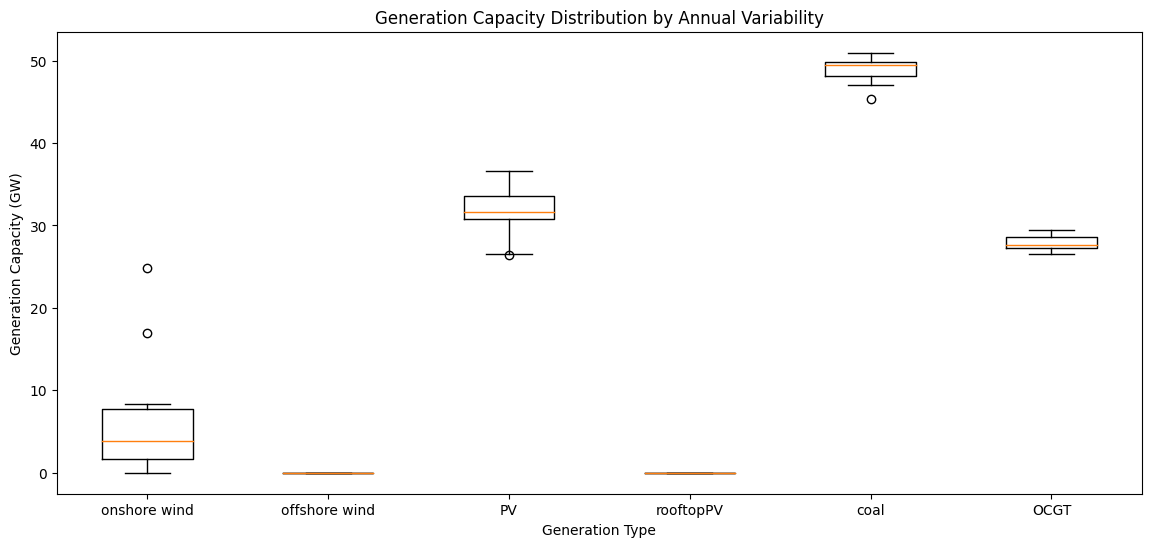

In [27]:
results = pd.DataFrame(
    np.array([np.array(onwind_cap)/10**3, np.array(offwind_cap)/10**3, np.array(pv_cap)/10**3, 
              np.array(rooftop_cap)/10**3, np.array(coal_cap)/10**3, np.array(ocgt_cap)/10**3]).T,
    columns=["onshorewind", "offshorewind", "PV", "rooftopPV", "coal", "OCGT"],
    index=years,
)

# Make a boxplot
plt.figure(figsize=(14, 6))
plt.boxplot(
    [results["onshorewind"], results["offshorewind"], results["PV"], results["rooftopPV"], results["coal"], results["OCGT"]],
    labels=["onshore wind", "offshore wind", "PV", "rooftopPV", "coal", "OCGT"]
)
plt.title("Generation Capacity Distribution by Annual Variability")
plt.ylabel("Generation Capacity (GW)")
plt.xlabel("Generation Type")



# Section D

In [28]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

# add electricity bus
n.add("Bus",
            f"E_bus{country}")

# add load to the bus
n.add("Load",
            "load",
            bus=f"E_bus{country}",
            p_set=df_elec[country].values)

# add the different carriers, only gas emits CO2
n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "solarPV")
n.add("Carrier", "rooftopPV")

''' Add renewable generators '''
# Add onshore wind
CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
lifetime = 30 # years
discount_rate = 0.07 # 7%
capex = 910000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
n.add("Generator",
            "onshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_onshore.values)

# Add offshore wind
CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 2506000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
n.add("Generator",
            "offshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_offshore.values)

# Add large scale solar
CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 425000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
n.add("Generator",
            "PV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="solarPV",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_pv,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# Add rooftop solar
CF_rooftop = df_rooftop[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 725000 # in €/MW
fopex = 0.02 # 2% of capex
capital_cost_rooftop = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
n.add("Generator",
            "rooftopPV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="rooftopPV",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_rooftop,
            marginal_cost = 0,
            p_max_pu = CF_rooftop.values)

''' Add non-renewables generators '''
# add OCGT (Open Cycle Gas Turbine) generator
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 560000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
n.add("Generator",
            "OCGT",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            efficiency = efficiency,
            marginal_cost = marginal_cost_OCGT)

# add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 3294000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 4 # in €/MWh_th 
efficiency = 0.36 # MWh_elec/MWh_th
marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
n.add("Generator",
            "coal",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=1000,
            capital_cost = capital_cost_coal,
            efficiency = efficiency,
            marginal_cost = marginal_cost_coal)


# Add storage unit
n.add("StorageUnit",
            "battery",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            capital_cost=12894+24678,
            efficiency_dispatch=0.96,
            efficiency_store=0.96,
            max_hours=2,
            cyclic_state_of_charge=True,)

# Co2 Cap
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=596000000, #596MtCO2
)

Index(['CO2Limit'], dtype='object')

In [29]:
n.optimize(solver_name='gurobi')

Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 33.63it/s]
INFO:linopy.io: Writing time: 1.3s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-dkh7y5bv.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-dkh7y5bv.lp


Reading time = 0.40 seconds


INFO:gurobipy:Reading time = 0.40 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0x42eedf6f


INFO:gurobipy:Model fingerprint: 0x42eedf6f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 6e+08]


INFO:gurobipy:  RHS range        [4e+04, 6e+08]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.30s


INFO:gurobipy:Presolve time: 0.30s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.42697801e+12  0.00000000e+00  4.95e+10 0.00e+00  1.07e+10     1s


INFO:gurobipy:   0   9.42697801e+12  0.00000000e+00  4.95e+10 0.00e+00  1.07e+10     1s


   1   1.40639316e+13 -1.76362782e+12  9.57e+09 3.88e+02  2.47e+09     1s


INFO:gurobipy:   1   1.40639316e+13 -1.76362782e+12  9.57e+09 3.88e+02  2.47e+09     1s


   2   1.22435653e+13 -1.96861428e+12  1.12e+09 7.89e+01  5.21e+08     1s


INFO:gurobipy:   2   1.22435653e+13 -1.96861428e+12  1.12e+09 7.89e+01  5.21e+08     1s


   3   3.83557926e+12 -8.49631558e+11  3.53e-07 2.62e+00  4.69e+07     1s


INFO:gurobipy:   3   3.83557926e+12 -8.49631558e+11  3.53e-07 2.62e+00  4.69e+07     1s


   4   1.08833547e+12 -1.03733086e+11  2.63e-07 3.64e-01  9.61e+06     1s


INFO:gurobipy:   4   1.08833547e+12 -1.03733086e+11  2.63e-07 3.64e-01  9.61e+06     1s


   5   1.41997596e+11  1.17263089e+08  1.46e-07 3.70e-09  1.03e+06     1s


INFO:gurobipy:   5   1.41997596e+11  1.17263089e+08  1.46e-07 3.70e-09  1.03e+06     1s


   6   8.33491448e+10  2.62302478e+09  7.59e-08 2.07e-09  5.80e+05     2s


INFO:gurobipy:   6   8.33491448e+10  2.62302478e+09  7.59e-08 2.07e-09  5.80e+05     2s


   7   6.13959573e+10  9.83496590e+09  4.97e-08 1.64e-09  3.69e+05     2s


INFO:gurobipy:   7   6.13959573e+10  9.83496590e+09  4.97e-08 1.64e-09  3.69e+05     2s


   8   5.01549657e+10  1.46985211e+10  3.74e-08 1.11e-09  2.53e+05     2s


INFO:gurobipy:   8   5.01549657e+10  1.46985211e+10  3.74e-08 1.11e-09  2.53e+05     2s


   9   3.71803487e+10  1.87292911e+10  1.83e-08 1.22e-09  1.31e+05     2s


INFO:gurobipy:   9   3.71803487e+10  1.87292911e+10  1.83e-08 1.22e-09  1.31e+05     2s


  10   3.32793427e+10  2.18440578e+10  1.22e-08 2.46e-09  8.14e+04     2s


INFO:gurobipy:  10   3.32793427e+10  2.18440578e+10  1.22e-08 2.46e-09  8.14e+04     2s


  11   3.01617414e+10  2.33545184e+10  4.75e-08 2.35e-09  4.84e+04     2s


INFO:gurobipy:  11   3.01617414e+10  2.33545184e+10  4.75e-08 2.35e-09  4.84e+04     2s


  12   2.84872351e+10  2.46154782e+10  6.43e-08 1.04e-09  2.75e+04     2s


INFO:gurobipy:  12   2.84872351e+10  2.46154782e+10  6.43e-08 1.04e-09  2.75e+04     2s


  13   2.78632359e+10  2.49454314e+10  5.48e-08 3.05e-09  2.07e+04     2s


INFO:gurobipy:  13   2.78632359e+10  2.49454314e+10  5.48e-08 3.05e-09  2.07e+04     2s


  14   2.78196038e+10  2.51073096e+10  3.40e-07 1.17e-09  1.93e+04     2s


INFO:gurobipy:  14   2.78196038e+10  2.51073096e+10  3.40e-07 1.17e-09  1.93e+04     2s


  15   2.72147219e+10  2.51708379e+10  2.54e-07 1.10e-09  1.45e+04     2s


INFO:gurobipy:  15   2.72147219e+10  2.51708379e+10  2.54e-07 1.10e-09  1.45e+04     2s


  16   2.69224193e+10  2.52044017e+10  2.55e-07 1.22e-09  1.22e+04     3s


INFO:gurobipy:  16   2.69224193e+10  2.52044017e+10  2.55e-07 1.22e-09  1.22e+04     3s


  17   2.66751451e+10  2.53609221e+10  1.99e-07 2.58e-10  9.34e+03     3s


INFO:gurobipy:  17   2.66751451e+10  2.53609221e+10  1.99e-07 2.58e-10  9.34e+03     3s


  18   2.64997774e+10  2.54231047e+10  2.47e-07 1.76e-10  7.65e+03     3s


INFO:gurobipy:  18   2.64997774e+10  2.54231047e+10  2.47e-07 1.76e-10  7.65e+03     3s


  19   2.64583145e+10  2.55151647e+10  9.02e-07 6.37e-10  6.70e+03     3s


INFO:gurobipy:  19   2.64583145e+10  2.55151647e+10  9.02e-07 6.37e-10  6.70e+03     3s


  20   2.63617954e+10  2.55744989e+10  1.31e-06 1.60e-09  5.59e+03     3s


INFO:gurobipy:  20   2.63617954e+10  2.55744989e+10  1.31e-06 1.60e-09  5.59e+03     3s


  21   2.62312669e+10  2.55980765e+10  1.83e-06 6.61e-10  4.50e+03     3s


INFO:gurobipy:  21   2.62312669e+10  2.55980765e+10  1.83e-06 6.61e-10  4.50e+03     3s


  22   2.61839853e+10  2.56265955e+10  2.21e-06 8.84e-10  3.96e+03     3s


INFO:gurobipy:  22   2.61839853e+10  2.56265955e+10  2.21e-06 8.84e-10  3.96e+03     3s


  23   2.61162318e+10  2.56584541e+10  4.53e-06 7.59e-10  3.25e+03     3s


INFO:gurobipy:  23   2.61162318e+10  2.56584541e+10  4.53e-06 7.59e-10  3.25e+03     3s


  24   2.59743408e+10  2.56740618e+10  2.49e-06 8.69e-10  2.13e+03     3s


INFO:gurobipy:  24   2.59743408e+10  2.56740618e+10  2.49e-06 8.69e-10  2.13e+03     3s


  25   2.59288798e+10  2.56806085e+10  1.95e-06 3.00e-10  1.76e+03     3s


INFO:gurobipy:  25   2.59288798e+10  2.56806085e+10  1.95e-06 3.00e-10  1.76e+03     3s


  26   2.58791274e+10  2.56935632e+10  2.23e-06 8.88e-10  1.32e+03     4s


INFO:gurobipy:  26   2.58791274e+10  2.56935632e+10  2.23e-06 8.88e-10  1.32e+03     4s


  27   2.58738183e+10  2.57009133e+10  2.13e-06 1.51e-10  1.23e+03     4s


INFO:gurobipy:  27   2.58738183e+10  2.57009133e+10  2.13e-06 1.51e-10  1.23e+03     4s


  28   2.58494689e+10  2.57053485e+10  2.60e-06 1.23e-10  1.02e+03     4s


INFO:gurobipy:  28   2.58494689e+10  2.57053485e+10  2.60e-06 1.23e-10  1.02e+03     4s


  29   2.58433922e+10  2.57267746e+10  2.43e-06 1.02e-09  8.29e+02     4s


INFO:gurobipy:  29   2.58433922e+10  2.57267746e+10  2.43e-06 1.02e-09  8.29e+02     4s


  30   2.58046513e+10  2.57419206e+10  1.38e-06 1.43e-09  4.46e+02     4s


INFO:gurobipy:  30   2.58046513e+10  2.57419206e+10  1.38e-06 1.43e-09  4.46e+02     4s


  31   2.57742980e+10  2.57530343e+10  3.88e-07 1.00e-09  1.51e+02     4s


INFO:gurobipy:  31   2.57742980e+10  2.57530343e+10  3.88e-07 1.00e-09  1.51e+02     4s


  32   2.57639555e+10  2.57567305e+10  2.91e-07 1.21e-09  5.13e+01     4s


INFO:gurobipy:  32   2.57639555e+10  2.57567305e+10  2.91e-07 1.21e-09  5.13e+01     4s


  33   2.57621639e+10  2.57578599e+10  1.92e-07 2.78e-10  3.06e+01     4s


INFO:gurobipy:  33   2.57621639e+10  2.57578599e+10  1.92e-07 2.78e-10  3.06e+01     4s


  34   2.57592177e+10  2.57583485e+10  3.60e-08 2.18e-09  6.18e+00     4s


INFO:gurobipy:  34   2.57592177e+10  2.57583485e+10  3.60e-08 2.18e-09  6.18e+00     4s


  35   2.57588046e+10  2.57584806e+10  1.40e-08 1.02e-09  2.30e+00     5s


INFO:gurobipy:  35   2.57588046e+10  2.57584806e+10  1.40e-08 1.02e-09  2.30e+00     5s


  36   2.57586887e+10  2.57585079e+10  8.00e-09 1.66e-10  1.28e+00     5s


INFO:gurobipy:  36   2.57586887e+10  2.57585079e+10  8.00e-09 1.66e-10  1.28e+00     5s


  37   2.57586168e+10  2.57585217e+10  4.29e-09 1.12e-09  6.76e-01     5s


INFO:gurobipy:  37   2.57586168e+10  2.57585217e+10  4.29e-09 1.12e-09  6.76e-01     5s


  38   2.57585466e+10  2.57585237e+10  6.55e-10 1.61e-09  1.63e-01     5s


INFO:gurobipy:  38   2.57585466e+10  2.57585237e+10  6.55e-10 1.61e-09  1.63e-01     5s


  39   2.57585310e+10  2.57585274e+10  1.03e-09 2.49e-10  2.58e-02     5s


INFO:gurobipy:  39   2.57585310e+10  2.57585274e+10  1.03e-09 2.49e-10  2.58e-02     5s


  40   2.57585298e+10  2.57585297e+10  5.82e-11 1.30e-09  7.87e-04     5s


INFO:gurobipy:  40   2.57585298e+10  2.57585297e+10  5.82e-11 1.30e-09  7.87e-04     5s


  41   2.57585298e+10  2.57585298e+10  4.02e-05 3.77e-10  7.87e-07     5s


INFO:gurobipy:  41   2.57585298e+10  2.57585298e+10  4.02e-05 3.77e-10  7.87e-07     5s


  42   2.57585298e+10  2.57585298e+10  4.02e-05 3.77e-10  7.87e-07     5s


INFO:gurobipy:  42   2.57585298e+10  2.57585298e+10  4.02e-05 3.77e-10  7.87e-07     5s


INFO:gurobipy:


Barrier solved model in 42 iterations and 5.50 seconds (2.00 work units)


INFO:gurobipy:Barrier solved model in 42 iterations and 5.50 seconds (2.00 work units)


Optimal objective 2.57585298e+10


INFO:gurobipy:Optimal objective 2.57585298e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13745 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:   13745 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    8291 PPushes remaining with PInf 3.5306907e-06                 6s


INFO:gurobipy:    8291 PPushes remaining with PInf 3.5306907e-06                 6s


    5757 PPushes remaining with PInf 2.0032156e-03                10s


INFO:gurobipy:    5757 PPushes remaining with PInf 2.0032156e-03                10s


    2976 PPushes remaining with PInf 2.0032152e-03                15s


INFO:gurobipy:    2976 PPushes remaining with PInf 2.0032152e-03                15s


     437 PPushes remaining with PInf 2.0032216e-03                20s


INFO:gurobipy:     437 PPushes remaining with PInf 2.0032216e-03                20s


       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6379740e+00     21s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6379740e+00     21s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   21853    2.5758530e+10   0.000000e+00   4.637974e+00     22s


INFO:gurobipy:   21853    2.5758530e+10   0.000000e+00   4.637974e+00     22s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


   21857    2.5758530e+10   0.000000e+00   0.000000e+00     23s


INFO:gurobipy:   21857    2.5758530e+10   0.000000e+00   0.000000e+00     23s


INFO:gurobipy:


Solved in 21857 iterations and 22.55 seconds (48.15 work units)


INFO:gurobipy:Solved in 21857 iterations and 22.55 seconds (48.15 work units)


Optimal objective  2.575852977e+10


INFO:gurobipy:Optimal objective  2.575852977e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.58e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

<AxesSubplot: xlabel='snapshot', ylabel='dispatch'>

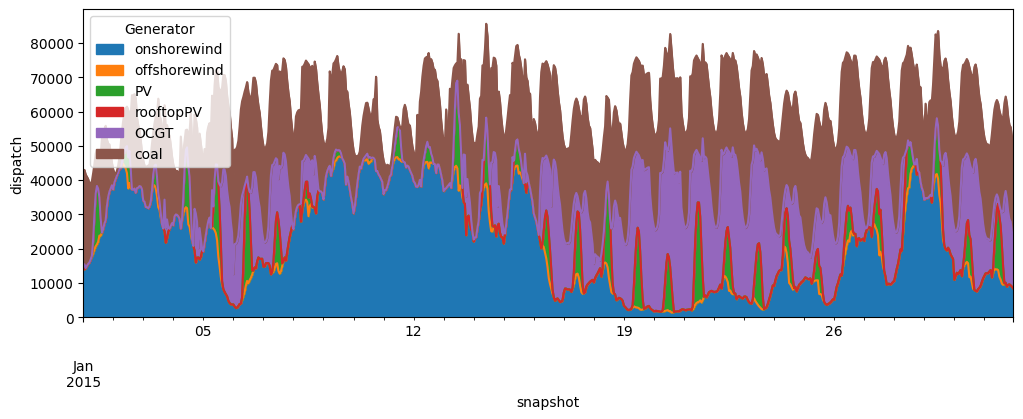

In [30]:
n.generators_t.p.loc["2015-01"].plot.area(figsize=(12, 4), ylabel="dispatch")

Text(0.5, 1.07, 'Generation mix')

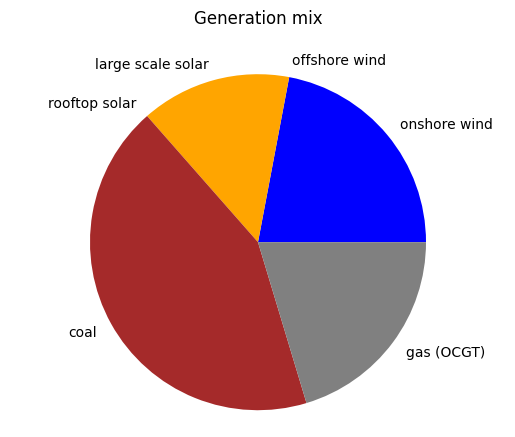

In [31]:
labels = ['onshore wind',
            'offshore wind',
            'large scale solar',
            'rooftop solar',
            'coal',
            'gas (OCGT)']
      
sizes = [n.generators_t.p['onshorewind'].sum(),
            n.generators_t.p['offshorewind'].sum(),
         n.generators_t.p['PV'].sum(),
            n.generators_t.p['rooftopPV'].sum(),
            n.generators_t.p['coal'].sum(),
         n.generators_t.p['OCGT'].sum()]

colors=['blue', 'darkblue', 'orange', 'yellow', 'brown', 'grey']

plt.pie(sizes,
      colors=colors,
      labels=labels,
      wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Generation mix', y=1.07)

__Storage Installed__

In [32]:
# Storage installed capacity
print(f"Installed capacity of storage: {n.storage_units.p_nom_opt.loc['battery'] / 1e3} GW")

Installed capacity of storage: 9.749571027325963 GW


<AxesSubplot: xlabel='snapshot', ylabel='battery'>

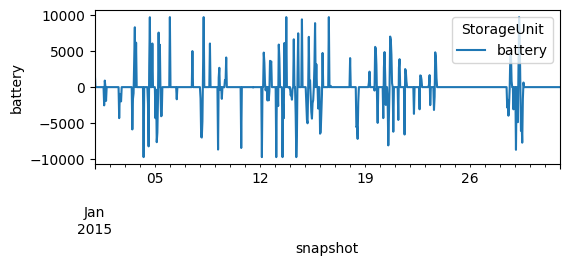

In [33]:
n.storage_units_t.p.loc["2015-01"].plot(figsize=(6, 2), ylabel="battery")

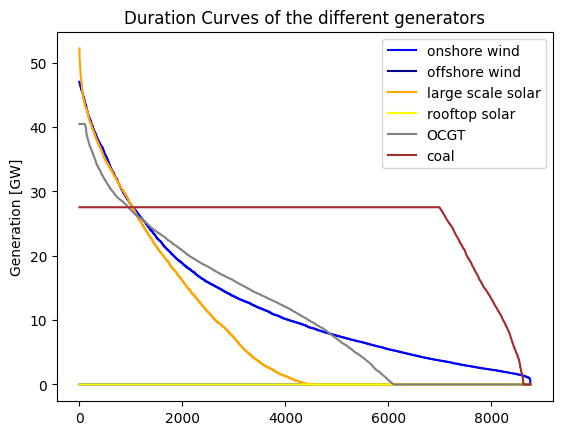

In [34]:
# Duration Curves
cf_onshore = n.generators_t.p['onshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_offshore = n.generators_t.p['offshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_PV = n.generators_t.p['PV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_rooftopPV = n.generators_t.p['rooftopPV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_OCGT = n.generators_t.p['OCGT'].sort_values(ascending=False,ignore_index=True)/1e3
cf_coal = n.generators_t.p['coal'].sort_values(ascending=False,ignore_index=True)/1e3


cf_onshore.plot(kind='line', ylabel='CF onshore', color='blue')
cf_offshore.plot(kind='line', ylabel='CF offshore', color='darkblue')
cf_PV.plot(kind='line', ylabel='CF PV', color='orange')
cf_rooftopPV.plot(kind='line', ylabel='CF rooftopPV', color='yellow')
cf_OCGT.plot(kind='line', ylabel='CF OCGT', color='grey')
cf_coal.plot(kind='line', ylabel='CF coal', color='brown')
plt.title('Duration Curves of the different generators')
plt.legend(['onshore wind', 'offshore wind', 'large scale solar', 'rooftop solar', 'OCGT', 'coal'])
plt.ylabel('Generation [GW]')
plt.show()

In [35]:
n.generators.p_nom_opt.div(1e3) # in GW

Generator
onshorewind     60.417740
offshorewind     0.000000
PV              70.867789
rooftopPV        0.000000
OCGT            40.498351
coal            27.549180
Name: p_nom_opt, dtype: float64

In [36]:
print(f"Total cost: {round(n.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(n.objective/n.loads_t.p.sum().iloc[0]))} EUR/MWh")


Total cost: 25758.53 mio€
Cost per MWh of electricity produced 51 EUR/MWh


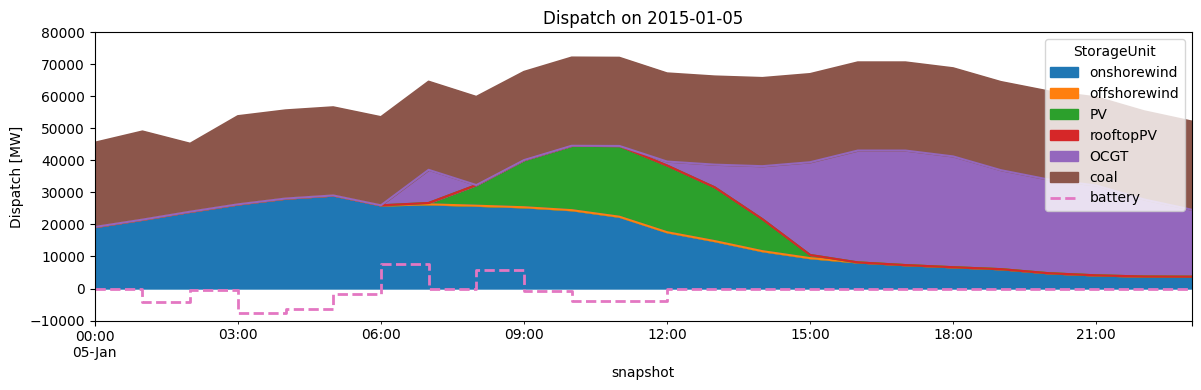

In [37]:
day = "2015-01-05"
ax = n.generators_t.p.loc[day].plot.area(figsize=(12, 4), ylabel="Dispatch [MW]", legend=True)

# 2. Overlay storage unit dispatch as step lines
n.storage_units_t.p.loc[day].plot(ax=ax, drawstyle="steps-post", linewidth=2, linestyle="--", legend=True)

# 3. Customize
plt.title(f"Dispatch on {day}")
plt.tight_layout()
plt.ylim(-10000, 80000)
plt.show()

# Section E

In [38]:
# Our desired target for CO2 emissions limit is 250MtCO2
co2 = 250 # in tCO2
n.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6

n.optimize(solver_name='gurobi')


Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 32.61it/s]
INFO:linopy.io: Writing time: 1.32s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-7flwg1w_.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-7flwg1w_.lp


Reading time = 0.43 seconds


INFO:gurobipy:Reading time = 0.43 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0xfd0c7264


INFO:gurobipy:Model fingerprint: 0xfd0c7264


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 3e+08]


INFO:gurobipy:  RHS range        [4e+04, 3e+08]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.22s


INFO:gurobipy:Presolve time: 0.22s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.08s


INFO:gurobipy:Ordering time: 0.08s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.29880136e+12  0.00000000e+00  3.83e+10 0.00e+00  8.24e+09     1s


INFO:gurobipy:   0   7.29880136e+12  0.00000000e+00  3.83e+10 0.00e+00  8.24e+09     1s


   1   1.08900652e+13 -1.42291834e+12  7.36e+09 3.87e+02  1.90e+09     1s


INFO:gurobipy:   1   1.08900652e+13 -1.42291834e+12  7.36e+09 3.87e+02  1.90e+09     1s


   2   9.46070335e+12 -1.51766896e+12  8.60e+08 7.64e+01  3.93e+08     1s


INFO:gurobipy:   2   9.46070335e+12 -1.51766896e+12  8.60e+08 7.64e+01  3.93e+08     1s


   3   2.98968283e+12 -5.92253964e+11  4.43e-07 2.27e+00  3.43e+07     1s


INFO:gurobipy:   3   2.98968283e+12 -5.92253964e+11  4.43e-07 2.27e+00  3.43e+07     1s


   4   8.01552666e+11 -9.07330381e+10  3.19e-07 3.60e-01  7.17e+06     1s


INFO:gurobipy:   4   8.01552666e+11 -9.07330381e+10  3.19e-07 3.60e-01  7.17e+06     1s


   5   1.10895791e+11 -3.62460213e+09  1.38e-07 1.67e-10  8.25e+05     1s


INFO:gurobipy:   5   1.10895791e+11 -3.62460213e+09  1.38e-07 1.67e-10  8.25e+05     1s


   6   6.69967326e+10  5.55782807e+09  8.30e-08 6.66e-10  4.40e+05     1s


INFO:gurobipy:   6   6.69967326e+10  5.55782807e+09  8.30e-08 6.66e-10  4.40e+05     1s


   7   5.50939400e+10  1.18941784e+10  5.90e-08 1.00e-10  3.08e+05     1s


INFO:gurobipy:   7   5.50939400e+10  1.18941784e+10  5.90e-08 1.00e-10  3.08e+05     1s


   8   4.39915808e+10  1.79640527e+10  3.74e-08 6.15e-10  1.85e+05     1s


INFO:gurobipy:   8   4.39915808e+10  1.79640527e+10  3.74e-08 6.15e-10  1.85e+05     1s


   9   3.84533934e+10  2.20163966e+10  2.57e-08 4.70e-10  1.17e+05     1s


INFO:gurobipy:   9   3.84533934e+10  2.20163966e+10  2.57e-08 4.70e-10  1.17e+05     1s


  10   3.39242796e+10  2.40670557e+10  2.31e-08 5.97e-10  7.01e+04     2s


INFO:gurobipy:  10   3.39242796e+10  2.40670557e+10  2.31e-08 5.97e-10  7.01e+04     2s


  11   3.17899591e+10  2.50407861e+10  3.68e-08 2.84e-10  4.80e+04     2s


INFO:gurobipy:  11   3.17899591e+10  2.50407861e+10  3.68e-08 2.84e-10  4.80e+04     2s


  12   2.98977938e+10  2.56699618e+10  9.07e-08 3.13e-10  3.01e+04     2s


INFO:gurobipy:  12   2.98977938e+10  2.56699618e+10  9.07e-08 3.13e-10  3.01e+04     2s


  13   2.92044604e+10  2.63215230e+10  1.22e-07 9.99e-11  2.05e+04     2s


INFO:gurobipy:  13   2.92044604e+10  2.63215230e+10  1.22e-07 9.99e-11  2.05e+04     2s


  14   2.89886965e+10  2.63788431e+10  1.14e-07 7.28e-10  1.86e+04     2s


INFO:gurobipy:  14   2.89886965e+10  2.63788431e+10  1.14e-07 7.28e-10  1.86e+04     2s


  15   2.85129144e+10  2.65206328e+10  1.42e-07 2.79e-09  1.42e+04     2s


INFO:gurobipy:  15   2.85129144e+10  2.65206328e+10  1.42e-07 2.79e-09  1.42e+04     2s


  16   2.80753386e+10  2.68348756e+10  7.97e-07 6.26e-10  8.82e+03     2s


INFO:gurobipy:  16   2.80753386e+10  2.68348756e+10  7.97e-07 6.26e-10  8.82e+03     2s


  17   2.78348376e+10  2.69007180e+10  6.24e-07 8.26e-10  6.64e+03     2s


INFO:gurobipy:  17   2.78348376e+10  2.69007180e+10  6.24e-07 8.26e-10  6.64e+03     2s


  18   2.77654755e+10  2.69464019e+10  5.73e-07 6.98e-10  5.82e+03     2s


INFO:gurobipy:  18   2.77654755e+10  2.69464019e+10  5.73e-07 6.98e-10  5.82e+03     2s


  19   2.76237951e+10  2.70554264e+10  4.15e-07 1.17e-09  4.04e+03     2s


INFO:gurobipy:  19   2.76237951e+10  2.70554264e+10  4.15e-07 1.17e-09  4.04e+03     2s


  20   2.75703992e+10  2.70947314e+10  3.27e-07 4.79e-11  3.38e+03     3s


INFO:gurobipy:  20   2.75703992e+10  2.70947314e+10  3.27e-07 4.79e-11  3.38e+03     3s


  21   2.75328082e+10  2.71062899e+10  2.92e-07 6.64e-10  3.03e+03     3s


INFO:gurobipy:  21   2.75328082e+10  2.71062899e+10  2.92e-07 6.64e-10  3.03e+03     3s


  22   2.75205693e+10  2.71287153e+10  3.00e-07 1.41e-09  2.78e+03     3s


INFO:gurobipy:  22   2.75205693e+10  2.71287153e+10  3.00e-07 1.41e-09  2.78e+03     3s


  23   2.74282202e+10  2.71425946e+10  9.77e-07 5.15e-10  2.03e+03     3s


INFO:gurobipy:  23   2.74282202e+10  2.71425946e+10  9.77e-07 5.15e-10  2.03e+03     3s


  24   2.73753611e+10  2.71550019e+10  2.09e-06 3.26e-10  1.57e+03     3s


INFO:gurobipy:  24   2.73753611e+10  2.71550019e+10  2.09e-06 3.26e-10  1.57e+03     3s


  25   2.73561229e+10  2.71998452e+10  5.48e-07 3.20e-10  1.11e+03     3s


INFO:gurobipy:  25   2.73561229e+10  2.71998452e+10  5.48e-07 3.20e-10  1.11e+03     3s


  26   2.73439423e+10  2.72096265e+10  8.12e-07 2.60e-10  9.55e+02     3s


INFO:gurobipy:  26   2.73439423e+10  2.72096265e+10  8.12e-07 2.60e-10  9.55e+02     3s


  27   2.73358315e+10  2.72158950e+10  8.10e-07 1.52e-09  8.52e+02     3s


INFO:gurobipy:  27   2.73358315e+10  2.72158950e+10  8.10e-07 1.52e-09  8.52e+02     3s


  28   2.73306945e+10  2.72212047e+10  6.82e-07 3.99e-09  7.78e+02     3s


INFO:gurobipy:  28   2.73306945e+10  2.72212047e+10  6.82e-07 3.99e-09  7.78e+02     3s


  29   2.73260193e+10  2.72265438e+10  4.30e-07 1.09e-09  7.07e+02     3s


INFO:gurobipy:  29   2.73260193e+10  2.72265438e+10  4.30e-07 1.09e-09  7.07e+02     3s


  30   2.73228245e+10  2.72386774e+10  5.62e-07 3.48e-10  5.98e+02     4s


INFO:gurobipy:  30   2.73228245e+10  2.72386774e+10  5.62e-07 3.48e-10  5.98e+02     4s


  31   2.73124374e+10  2.72631027e+10  3.58e-06 6.15e-10  3.51e+02     4s


INFO:gurobipy:  31   2.73124374e+10  2.72631027e+10  3.58e-06 6.15e-10  3.51e+02     4s


  32   2.73112703e+10  2.72894774e+10  4.01e-06 2.66e-10  1.55e+02     4s


INFO:gurobipy:  32   2.73112703e+10  2.72894774e+10  4.01e-06 2.66e-10  1.55e+02     4s


  33   2.73048126e+10  2.72971128e+10  1.95e-06 1.34e-10  5.47e+01     4s


INFO:gurobipy:  33   2.73048126e+10  2.72971128e+10  1.95e-06 1.34e-10  5.47e+01     4s


  34   2.73021435e+10  2.73001540e+10  4.57e-06 2.52e-10  1.41e+01     4s


INFO:gurobipy:  34   2.73021435e+10  2.73001540e+10  4.57e-06 2.52e-10  1.41e+01     4s


  35   2.73012930e+10  2.73007429e+10  2.27e-06 1.51e-09  3.91e+00     4s


INFO:gurobipy:  35   2.73012930e+10  2.73007429e+10  2.27e-06 1.51e-09  3.91e+00     4s


  36   2.73011797e+10  2.73011246e+10  5.70e-07 7.04e-10  3.91e-01     4s


INFO:gurobipy:  36   2.73011797e+10  2.73011246e+10  5.70e-07 7.04e-10  3.91e-01     4s


  37   2.73011396e+10  2.73011355e+10  3.20e-08 3.10e-10  2.92e-02     4s


INFO:gurobipy:  37   2.73011396e+10  2.73011355e+10  3.20e-08 3.10e-10  2.92e-02     4s


  38   2.73011372e+10  2.73011371e+10  7.69e-09 4.61e-10  1.37e-04     5s


INFO:gurobipy:  38   2.73011372e+10  2.73011371e+10  7.69e-09 4.61e-10  1.37e-04     5s


  39   2.73011372e+10  2.73011372e+10  4.37e-08 8.12e-09  1.79e-08     5s


INFO:gurobipy:  39   2.73011372e+10  2.73011372e+10  4.37e-08 8.12e-09  1.79e-08     5s


  40   2.73011372e+10  2.73011372e+10  2.33e-10 3.64e-09  1.63e-11     5s


INFO:gurobipy:  40   2.73011372e+10  2.73011372e+10  2.33e-10 3.64e-09  1.63e-11     5s


INFO:gurobipy:


Barrier solved model in 40 iterations and 4.69 seconds (1.83 work units)


INFO:gurobipy:Barrier solved model in 40 iterations and 4.69 seconds (1.83 work units)


Optimal objective 2.73011372e+10


INFO:gurobipy:Optimal objective 2.73011372e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13900 DPushes remaining with DInf 0.0000000e+00                 5s


INFO:gurobipy:   13900 DPushes remaining with DInf 0.0000000e+00                 5s


       0 DPushes remaining with DInf 0.0000000e+00                 5s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 5s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    9163 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:    9163 PPushes remaining with PInf 0.0000000e+00                 5s


    4737 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:    4737 PPushes remaining with PInf 0.0000000e+00                10s


    2124 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:    2124 PPushes remaining with PInf 0.0000000e+00                15s


       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1792772e-08     19s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1792772e-08     19s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   21394    2.7301137e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:   21394    2.7301137e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:


Solved in 21394 iterations and 20.23 seconds (42.42 work units)


INFO:gurobipy:Solved in 21394 iterations and 20.23 seconds (42.42 work units)


Optimal objective  2.730113715e+10


INFO:gurobipy:Optimal objective  2.730113715e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.73e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [39]:
print(f"Total cost: {round(n.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(n.objective/n.loads_t.p.sum().iloc[0]))} EUR/MWh")
print(f"CO2 tax {-n.global_constraints.mu['CO2Limit']} EUR/tCO2")

Total cost: 27301.14 mio€
Cost per MWh of electricity produced 54 EUR/MWh
CO2 tax 5.286070973046819 EUR/tCO2


In [ ]:
systemcost = []
onwind = []
offwind = []
pv = []
rooftop = []
coal = []
ocgt = []

onwind_cap = []
offwind_cap = []
pv_cap = []
rooftop_cap = []
coal_cap = []
ocgt_cap = []

co2_tax = []

co2_index = [1500, 1000, 500, 250, 220, 100, 50, 0]

for co2 in co2_index: # in MtCO2
    n.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    n.optimize(solver_name="gurobi")
    systemcost.append(n.objective / 1e6)  # in million euros
    onwind.append(n.generators_t.p["onshorewind"].sum())
    offwind.append(n.generators_t.p["offshorewind"].sum())
    pv.append(n.generators_t.p["PV"].sum())
    rooftop.append(n.generators_t.p["rooftopPV"].sum())
    coal.append(n.generators_t.p["coal"].sum())
    ocgt.append(n.generators_t.p["OCGT"].sum())

    onwind_cap.append(n.generators.p_nom_opt.loc["onshorewind"])
    offwind_cap.append(n.generators.p_nom_opt.loc["offshorewind"])
    pv_cap.append(n.generators.p_nom_opt.loc["PV"])
    rooftop_cap.append(n.generators.p_nom_opt.loc["rooftopPV"])
    coal_cap.append(n.generators.p_nom_opt.loc["coal"])
    ocgt_cap.append(n.generators.p_nom_opt.loc["OCGT"])

    co2_tax.append(-n.global_constraints.mu['CO2Limit'])
    
    

Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 31.62it/s]
INFO:linopy.io: Writing time: 1.32s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-w6t6lhz_.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-w6t6lhz_.lp


Reading time = 0.40 seconds


INFO:gurobipy:Reading time = 0.40 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0x16411785


INFO:gurobipy:Model fingerprint: 0x16411785


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+09]


INFO:gurobipy:  RHS range        [4e+04, 2e+09]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.20s


INFO:gurobipy:Presolve time: 0.20s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.07s


INFO:gurobipy:Ordering time: 0.07s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.26736797e+13  0.00000000e+00  1.72e+11 0.00e+00  3.38e+10     1s


INFO:gurobipy:   0   3.26736797e+13  0.00000000e+00  1.72e+11 0.00e+00  3.38e+10     1s


   1   4.82026701e+13 -2.85509579e+12  3.37e+10 3.54e+02  7.84e+09     1s


INFO:gurobipy:   1   4.82026701e+13 -2.85509579e+12  3.37e+10 3.54e+02  7.84e+09     1s


   2   4.12035742e+13 -3.46947371e+12  4.22e+09 7.49e+01  1.71e+09     1s


INFO:gurobipy:   2   4.12035742e+13 -3.46947371e+12  4.22e+09 7.49e+01  1.71e+09     1s


   3   1.30302489e+13 -2.64687045e+12  3.04e-06 2.31e+00  1.54e+08     1s


INFO:gurobipy:   3   1.30302489e+13 -2.64687045e+12  3.04e-06 2.31e+00  1.54e+08     1s


   4   3.38350555e+12 -2.19487454e+11  1.23e-06 2.00e-01  2.81e+07     1s


INFO:gurobipy:   4   3.38350555e+12 -2.19487454e+11  1.23e-06 2.00e-01  2.81e+07     1s


   5   7.83124383e+11 -2.09400088e+10  3.48e-07 1.46e-09  5.88e+06     1s


INFO:gurobipy:   5   7.83124383e+11 -2.09400088e+10  3.48e-07 1.46e-09  5.88e+06     1s


   6   3.70806391e+11 -6.33611999e+09  1.92e-07 1.02e-09  2.74e+06     1s


INFO:gurobipy:   6   3.70806391e+11 -6.33611999e+09  1.92e-07 1.02e-09  2.74e+06     1s


   7   2.36203034e+11 -1.09071608e+10  1.20e-07 9.50e-10  1.79e+06     1s


INFO:gurobipy:   7   2.36203034e+11 -1.09071608e+10  1.20e-07 9.50e-10  1.79e+06     1s


   8   9.71970650e+10  1.91835011e+09  8.93e-08 1.46e-09  6.79e+05     1s


INFO:gurobipy:   8   9.71970650e+10  1.91835011e+09  8.93e-08 1.46e-09  6.79e+05     1s


   9   7.06153662e+10  8.44776152e+09  7.87e-08 1.21e-09  4.43e+05     2s


INFO:gurobipy:   9   7.06153662e+10  8.44776152e+09  7.87e-08 1.21e-09  4.43e+05     2s


  10   5.53155865e+10  1.58661557e+10  5.15e-08 1.24e-09  2.81e+05     2s


INFO:gurobipy:  10   5.53155865e+10  1.58661557e+10  5.15e-08 1.24e-09  2.81e+05     2s


  11   4.04255217e+10  1.96895951e+10  2.50e-08 1.32e-09  1.47e+05     2s


INFO:gurobipy:  11   4.04255217e+10  1.96895951e+10  2.50e-08 1.32e-09  1.47e+05     2s


  12   3.18235882e+10  2.17660009e+10  1.18e-08 2.41e-09  7.15e+04     2s


INFO:gurobipy:  12   3.18235882e+10  2.17660009e+10  1.18e-08 2.41e-09  7.15e+04     2s


  13   2.93647783e+10  2.28925683e+10  8.28e-09 9.57e-10  4.60e+04     2s


INFO:gurobipy:  13   2.93647783e+10  2.28925683e+10  8.28e-09 9.57e-10  4.60e+04     2s


  14   2.75987170e+10  2.33789295e+10  3.03e-08 6.92e-10  3.00e+04     2s


INFO:gurobipy:  14   2.75987170e+10  2.33789295e+10  3.03e-08 6.92e-10  3.00e+04     2s


  15   2.69268968e+10  2.34795163e+10  2.81e-08 1.26e-09  2.45e+04     2s


INFO:gurobipy:  15   2.69268968e+10  2.34795163e+10  2.81e-08 1.26e-09  2.45e+04     2s


  16   2.64986434e+10  2.36983181e+10  2.95e-07 1.43e-09  1.99e+04     2s


INFO:gurobipy:  16   2.64986434e+10  2.36983181e+10  2.95e-07 1.43e-09  1.99e+04     2s


  17   2.57921006e+10  2.39458799e+10  1.98e-07 1.35e-09  1.31e+04     2s


INFO:gurobipy:  17   2.57921006e+10  2.39458799e+10  1.98e-07 1.35e-09  1.31e+04     2s


  18   2.53834906e+10  2.41085572e+10  1.31e-07 2.80e-09  9.06e+03     2s


INFO:gurobipy:  18   2.53834906e+10  2.41085572e+10  1.31e-07 2.80e-09  9.06e+03     2s


  19   2.52200256e+10  2.41419250e+10  9.82e-08 1.28e-09  7.66e+03     3s


INFO:gurobipy:  19   2.52200256e+10  2.41419250e+10  9.82e-08 1.28e-09  7.66e+03     3s


  20   2.50911546e+10  2.42219586e+10  7.82e-08 1.40e-09  6.18e+03     3s


INFO:gurobipy:  20   2.50911546e+10  2.42219586e+10  7.82e-08 1.40e-09  6.18e+03     3s


  21   2.49367432e+10  2.42859411e+10  3.72e-07 1.06e-09  4.62e+03     3s


INFO:gurobipy:  21   2.49367432e+10  2.42859411e+10  3.72e-07 1.06e-09  4.62e+03     3s


  22   2.48807032e+10  2.43434112e+10  4.86e-07 1.21e-09  3.82e+03     3s


INFO:gurobipy:  22   2.48807032e+10  2.43434112e+10  4.86e-07 1.21e-09  3.82e+03     3s


  23   2.47867715e+10  2.43958552e+10  1.79e-06 7.71e-10  2.78e+03     3s


INFO:gurobipy:  23   2.47867715e+10  2.43958552e+10  1.79e-06 7.71e-10  2.78e+03     3s


  24   2.47566328e+10  2.44504405e+10  2.41e-06 1.51e-09  2.18e+03     3s


INFO:gurobipy:  24   2.47566328e+10  2.44504405e+10  2.41e-06 1.51e-09  2.18e+03     3s


  25   2.47129224e+10  2.44678081e+10  4.00e-06 2.58e-09  1.74e+03     3s


INFO:gurobipy:  25   2.47129224e+10  2.44678081e+10  4.00e-06 2.58e-09  1.74e+03     3s


  26   2.46829411e+10  2.44866811e+10  2.41e-06 8.37e-11  1.39e+03     3s


INFO:gurobipy:  26   2.46829411e+10  2.44866811e+10  2.41e-06 8.37e-11  1.39e+03     3s


  27   2.46469688e+10  2.45031405e+10  8.52e-06 1.07e-10  1.02e+03     3s


INFO:gurobipy:  27   2.46469688e+10  2.45031405e+10  8.52e-06 1.07e-10  1.02e+03     3s


  28   2.46421125e+10  2.45081203e+10  8.71e-06 5.98e-10  9.52e+02     3s


INFO:gurobipy:  28   2.46421125e+10  2.45081203e+10  8.71e-06 5.98e-10  9.52e+02     3s


  29   2.46206149e+10  2.45307059e+10  3.87e-06 1.44e-09  6.39e+02     4s


INFO:gurobipy:  29   2.46206149e+10  2.45307059e+10  3.87e-06 1.44e-09  6.39e+02     4s


  30   2.46122624e+10  2.45428921e+10  3.10e-06 1.41e-09  4.93e+02     4s


INFO:gurobipy:  30   2.46122624e+10  2.45428921e+10  3.10e-06 1.41e-09  4.93e+02     4s


  31   2.46064179e+10  2.45537475e+10  2.54e-06 1.19e-09  3.74e+02     4s


INFO:gurobipy:  31   2.46064179e+10  2.45537475e+10  2.54e-06 1.19e-09  3.74e+02     4s


  32   2.45899693e+10  2.45600865e+10  9.90e-07 5.28e-10  2.12e+02     4s


INFO:gurobipy:  32   2.45899693e+10  2.45600865e+10  9.90e-07 5.28e-10  2.12e+02     4s


  33   2.45854024e+10  2.45671525e+10  5.89e-07 4.64e-10  1.30e+02     4s


INFO:gurobipy:  33   2.45854024e+10  2.45671525e+10  5.89e-07 4.64e-10  1.30e+02     4s


  34   2.45836200e+10  2.45706992e+10  4.34e-07 5.72e-10  9.18e+01     4s


INFO:gurobipy:  34   2.45836200e+10  2.45706992e+10  4.34e-07 5.72e-10  9.18e+01     4s


  35   2.45814626e+10  2.45737225e+10  2.48e-07 1.25e-09  5.50e+01     4s


INFO:gurobipy:  35   2.45814626e+10  2.45737225e+10  2.48e-07 1.25e-09  5.50e+01     4s


  36   2.45802677e+10  2.45747436e+10  1.46e-07 1.26e-09  3.92e+01     5s


INFO:gurobipy:  36   2.45802677e+10  2.45747436e+10  1.46e-07 1.26e-09  3.92e+01     5s


  37   2.45794060e+10  2.45761240e+10  7.66e-08 1.18e-09  2.33e+01     5s


INFO:gurobipy:  37   2.45794060e+10  2.45761240e+10  7.66e-08 1.18e-09  2.33e+01     5s


  38   2.45790949e+10  2.45768159e+10  5.05e-08 8.81e-10  1.62e+01     5s


INFO:gurobipy:  38   2.45790949e+10  2.45768159e+10  5.05e-08 8.81e-10  1.62e+01     5s


  39   2.45789757e+10  2.45770983e+10  4.13e-08 4.49e-10  1.33e+01     5s


INFO:gurobipy:  39   2.45789757e+10  2.45770983e+10  4.13e-08 4.49e-10  1.33e+01     5s


  40   2.45788257e+10  2.45774811e+10  2.87e-08 4.64e-11  9.55e+00     5s


INFO:gurobipy:  40   2.45788257e+10  2.45774811e+10  2.87e-08 4.64e-11  9.55e+00     5s


  41   2.45787893e+10  2.45779162e+10  2.59e-08 2.68e-09  6.20e+00     5s


INFO:gurobipy:  41   2.45787893e+10  2.45779162e+10  2.59e-08 2.68e-09  6.20e+00     5s


  42   2.45786881e+10  2.45780031e+10  1.90e-08 4.86e-10  4.87e+00     5s


INFO:gurobipy:  42   2.45786881e+10  2.45780031e+10  1.90e-08 4.86e-10  4.87e+00     5s


  43   2.45786694e+10  2.45780550e+10  1.83e-08 1.00e-09  4.37e+00     6s


INFO:gurobipy:  43   2.45786694e+10  2.45780550e+10  1.83e-08 1.00e-09  4.37e+00     6s


  44   2.45786112e+10  2.45781093e+10  1.34e-08 8.77e-10  3.57e+00     6s


INFO:gurobipy:  44   2.45786112e+10  2.45781093e+10  1.34e-08 8.77e-10  3.57e+00     6s


  45   2.45785935e+10  2.45781437e+10  1.19e-08 3.78e-10  3.20e+00     6s


INFO:gurobipy:  45   2.45785935e+10  2.45781437e+10  1.19e-08 3.78e-10  3.20e+00     6s


  46   2.45785812e+10  2.45781849e+10  1.10e-08 4.49e-10  2.82e+00     6s


INFO:gurobipy:  46   2.45785812e+10  2.45781849e+10  1.10e-08 4.49e-10  2.82e+00     6s


  47   2.45785337e+10  2.45783301e+10  1.17e-08 1.64e-09  1.45e+00     6s


INFO:gurobipy:  47   2.45785337e+10  2.45783301e+10  1.17e-08 1.64e-09  1.45e+00     6s


  48   2.45784898e+10  2.45783958e+10  5.79e-09 8.15e-10  6.68e-01     6s


INFO:gurobipy:  48   2.45784898e+10  2.45783958e+10  5.79e-09 8.15e-10  6.68e-01     6s


  49   2.45784780e+10  2.45784077e+10  3.05e-08 2.31e-09  5.00e-01     7s


INFO:gurobipy:  49   2.45784780e+10  2.45784077e+10  3.05e-08 2.31e-09  5.00e-01     7s


  50   2.45784752e+10  2.45784168e+10  2.79e-08 3.35e-10  4.15e-01     7s


INFO:gurobipy:  50   2.45784752e+10  2.45784168e+10  2.79e-08 3.35e-10  4.15e-01     7s


  51   2.45784695e+10  2.45784226e+10  2.26e-08 4.94e-10  3.33e-01     7s


INFO:gurobipy:  51   2.45784695e+10  2.45784226e+10  2.26e-08 4.94e-10  3.33e-01     7s


  52   2.45784637e+10  2.45784260e+10  1.72e-08 4.84e-10  2.68e-01     7s


INFO:gurobipy:  52   2.45784637e+10  2.45784260e+10  1.72e-08 4.84e-10  2.68e-01     7s


  53   2.45784452e+10  2.45784405e+10  1.27e-08 1.82e-09  3.34e-02     7s


INFO:gurobipy:  53   2.45784452e+10  2.45784405e+10  1.27e-08 1.82e-09  3.34e-02     7s


  54   2.45784433e+10  2.45784432e+10  1.14e-08 2.79e-10  6.16e-04     7s


INFO:gurobipy:  54   2.45784433e+10  2.45784432e+10  1.14e-08 2.79e-10  6.16e-04     7s


  55   2.45784433e+10  2.45784433e+10  2.96e-08 8.44e-10  6.89e-06     7s


INFO:gurobipy:  55   2.45784433e+10  2.45784433e+10  2.96e-08 8.44e-10  6.89e-06     7s


  56   2.45784433e+10  2.45784433e+10  2.96e-08 8.44e-10  6.89e-06     8s


INFO:gurobipy:  56   2.45784433e+10  2.45784433e+10  2.96e-08 8.44e-10  6.89e-06     8s


INFO:gurobipy:


Barrier solved model in 56 iterations and 7.51 seconds (2.81 work units)


INFO:gurobipy:Barrier solved model in 56 iterations and 7.51 seconds (2.81 work units)


Optimal objective 2.45784433e+10


INFO:gurobipy:Optimal objective 2.45784433e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13495 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:   13495 DPushes remaining with DInf 0.0000000e+00                 8s


       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:


   20778 PPushes remaining with PInf 0.0000000e+00                 8s


INFO:gurobipy:   20778 PPushes remaining with PInf 0.0000000e+00                 8s


       0 PPushes remaining with PInf 0.0000000e+00                 8s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 8s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6660344e+00      8s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6660344e+00      8s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   34276    2.4578443e+10   0.000000e+00   4.666034e+00      8s


INFO:gurobipy:   34276    2.4578443e+10   0.000000e+00   4.666034e+00      8s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   34277    2.4578443e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:   34277    2.4578443e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:


Solved in 34277 iterations and 8.20 seconds (3.11 work units)


INFO:gurobipy:Solved in 34277 iterations and 8.20 seconds (3.11 work units)


Optimal objective  2.457844327e+10


INFO:gurobipy:Optimal objective  2.457844327e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 31.22it/s]
INFO:linopy.io: Writing time: 1.41s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-atb7ops7.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-atb7ops7.lp


Reading time = 0.44 seconds


INFO:gurobipy:Reading time = 0.44 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0xbb9950af


INFO:gurobipy:Model fingerprint: 0xbb9950af


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+09]


INFO:gurobipy:  RHS range        [4e+04, 2e+09]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.26s


INFO:gurobipy:Presolve time: 0.26s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.10s


INFO:gurobipy:Ordering time: 0.10s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.36767694e+13  0.00000000e+00  1.25e+11 0.00e+00  2.48e+10     1s


INFO:gurobipy:   0   2.36767694e+13  0.00000000e+00  1.25e+11 0.00e+00  2.48e+10     1s


   1   3.49900476e+13 -2.44233039e+12  2.44e+10 3.59e+02  5.76e+09     1s


INFO:gurobipy:   1   3.49900476e+13 -2.44233039e+12  2.44e+10 3.59e+02  5.76e+09     1s


   2   2.99900024e+13 -2.90730742e+12  3.01e+09 7.55e+01  1.25e+09     1s


INFO:gurobipy:   2   2.99900024e+13 -2.90730742e+12  3.01e+09 7.55e+01  1.25e+09     1s


   3   9.45189697e+12 -1.95609889e+12  7.90e-07 2.33e+00  1.12e+08     1s


INFO:gurobipy:   3   9.45189697e+12 -1.95609889e+12  7.90e-07 2.33e+00  1.12e+08     1s


   4   2.48166285e+12 -1.71055284e+11  8.28e-07 2.17e-01  2.08e+07     1s


INFO:gurobipy:   4   2.48166285e+12 -1.71055284e+11  8.28e-07 2.17e-01  2.08e+07     1s


   5   3.60061537e+11 -5.07117301e+09  1.65e-07 1.85e-09  2.66e+06     1s


INFO:gurobipy:   5   3.60061537e+11 -5.07117301e+09  1.65e-07 1.85e-09  2.66e+06     1s


   6   2.74073326e+11 -4.89865885e+09  1.22e-07 1.84e-09  2.03e+06     2s


INFO:gurobipy:   6   2.74073326e+11 -4.89865885e+09  1.22e-07 1.84e-09  2.03e+06     2s


   7   1.21874636e+11 -8.52432159e+09  5.08e-08 8.97e-10  9.45e+05     2s


INFO:gurobipy:   7   1.21874636e+11 -8.52432159e+09  5.08e-08 8.97e-10  9.45e+05     2s


   8   6.80351346e+10 -1.21629052e+09  3.28e-08 1.26e-09  4.97e+05     2s


INFO:gurobipy:   8   6.80351346e+10 -1.21629052e+09  3.28e-08 1.26e-09  4.97e+05     2s


   9   5.56318888e+10  6.66014640e+09  2.65e-08 8.26e-10  3.50e+05     2s


INFO:gurobipy:   9   5.56318888e+10  6.66014640e+09  2.65e-08 8.26e-10  3.50e+05     2s


  10   4.54318708e+10  1.33828278e+10  2.08e-08 9.20e-10  2.29e+05     2s


INFO:gurobipy:  10   4.54318708e+10  1.33828278e+10  2.08e-08 9.20e-10  2.29e+05     2s


  11   3.44822057e+10  1.90234381e+10  1.17e-08 6.00e-10  1.10e+05     2s


INFO:gurobipy:  11   3.44822057e+10  1.90234381e+10  1.17e-08 6.00e-10  1.10e+05     2s


  12   2.89544903e+10  2.17904797e+10  1.16e-08 1.09e-09  5.10e+04     2s


INFO:gurobipy:  12   2.89544903e+10  2.17904797e+10  1.16e-08 1.09e-09  5.10e+04     2s


  13   2.74772353e+10  2.29508777e+10  1.72e-08 6.88e-10  3.22e+04     2s


INFO:gurobipy:  13   2.74772353e+10  2.29508777e+10  1.72e-08 6.88e-10  3.22e+04     2s


  14   2.68839951e+10  2.33590957e+10  3.16e-08 6.00e-10  2.51e+04     2s


INFO:gurobipy:  14   2.68839951e+10  2.33590957e+10  3.16e-08 6.00e-10  2.51e+04     2s


  15   2.61617135e+10  2.35742782e+10  3.07e-08 2.13e-10  1.84e+04     2s


INFO:gurobipy:  15   2.61617135e+10  2.35742782e+10  3.07e-08 2.13e-10  1.84e+04     2s


  16   2.60152376e+10  2.37144126e+10  3.67e-08 9.17e-10  1.64e+04     3s


INFO:gurobipy:  16   2.60152376e+10  2.37144126e+10  3.67e-08 9.17e-10  1.64e+04     3s


  17   2.53867650e+10  2.40175101e+10  1.05e-07 6.51e-10  9.73e+03     3s


INFO:gurobipy:  17   2.53867650e+10  2.40175101e+10  1.05e-07 6.51e-10  9.73e+03     3s


  18   2.52407077e+10  2.41476041e+10  7.75e-08 5.31e-10  7.77e+03     3s


INFO:gurobipy:  18   2.52407077e+10  2.41476041e+10  7.75e-08 5.31e-10  7.77e+03     3s


  19   2.50616665e+10  2.42012123e+10  9.16e-08 6.09e-10  6.12e+03     3s


INFO:gurobipy:  19   2.50616665e+10  2.42012123e+10  9.16e-08 6.09e-10  6.12e+03     3s


  20   2.48944566e+10  2.42947612e+10  8.91e-08 0.00e+00  4.26e+03     3s


INFO:gurobipy:  20   2.48944566e+10  2.42947612e+10  8.91e-08 0.00e+00  4.26e+03     3s


  21   2.48616388e+10  2.43648019e+10  9.66e-08 7.64e-10  3.53e+03     3s


INFO:gurobipy:  21   2.48616388e+10  2.43648019e+10  9.66e-08 7.64e-10  3.53e+03     3s


  22   2.47686642e+10  2.44155990e+10  1.30e-06 2.32e-10  2.51e+03     3s


INFO:gurobipy:  22   2.47686642e+10  2.44155990e+10  1.30e-06 2.32e-10  2.51e+03     3s


  23   2.46918181e+10  2.44459641e+10  1.21e-06 7.50e-10  1.75e+03     3s


INFO:gurobipy:  23   2.46918181e+10  2.44459641e+10  1.21e-06 7.50e-10  1.75e+03     3s


  24   2.46506039e+10  2.44887141e+10  3.34e-06 6.02e-10  1.15e+03     3s


INFO:gurobipy:  24   2.46506039e+10  2.44887141e+10  3.34e-06 6.02e-10  1.15e+03     3s


  25   2.46244637e+10  2.45229222e+10  2.19e-06 1.11e-09  7.22e+02     4s


INFO:gurobipy:  25   2.46244637e+10  2.45229222e+10  2.19e-06 1.11e-09  7.22e+02     4s


  26   2.46195049e+10  2.45295474e+10  1.98e-06 1.44e-09  6.39e+02     4s


INFO:gurobipy:  26   2.46195049e+10  2.45295474e+10  1.98e-06 1.44e-09  6.39e+02     4s


  27   2.46158888e+10  2.45410974e+10  1.94e-06 5.04e-10  5.32e+02     4s


INFO:gurobipy:  27   2.46158888e+10  2.45410974e+10  1.94e-06 5.04e-10  5.32e+02     4s


  28   2.46126396e+10  2.45522550e+10  2.32e-06 2.96e-10  4.29e+02     4s


INFO:gurobipy:  28   2.46126396e+10  2.45522550e+10  2.32e-06 2.96e-10  4.29e+02     4s


  29   2.45951076e+10  2.45619719e+10  6.63e-06 1.53e-09  2.35e+02     4s


INFO:gurobipy:  29   2.45951076e+10  2.45619719e+10  6.63e-06 1.53e-09  2.35e+02     4s


  30   2.45885043e+10  2.45678166e+10  7.84e-06 5.01e-09  1.47e+02     4s


INFO:gurobipy:  30   2.45885043e+10  2.45678166e+10  7.84e-06 5.01e-09  1.47e+02     4s


  31   2.45847171e+10  2.45694067e+10  4.26e-06 5.17e-09  1.09e+02     4s


INFO:gurobipy:  31   2.45847171e+10  2.45694067e+10  4.26e-06 5.17e-09  1.09e+02     4s


  32   2.45832378e+10  2.45725003e+10  3.85e-06 3.40e-09  7.63e+01     4s


INFO:gurobipy:  32   2.45832378e+10  2.45725003e+10  3.85e-06 3.40e-09  7.63e+01     4s


  33   2.45819800e+10  2.45742104e+10  2.85e-06 1.64e-09  5.52e+01     4s


INFO:gurobipy:  33   2.45819800e+10  2.45742104e+10  2.85e-06 1.64e-09  5.52e+01     4s


  34   2.45815575e+10  2.45745137e+10  2.51e-06 3.29e-09  5.01e+01     5s


INFO:gurobipy:  34   2.45815575e+10  2.45745137e+10  2.51e-06 3.29e-09  5.01e+01     5s


  35   2.45803993e+10  2.45761568e+10  1.46e-06 6.74e-10  3.02e+01     5s


INFO:gurobipy:  35   2.45803993e+10  2.45761568e+10  1.46e-06 6.74e-10  3.02e+01     5s


  36   2.45794218e+10  2.45767807e+10  7.02e-07 4.76e-10  1.88e+01     5s


INFO:gurobipy:  36   2.45794218e+10  2.45767807e+10  7.02e-07 4.76e-10  1.88e+01     5s


  37   2.45790551e+10  2.45775238e+10  4.27e-07 9.19e-10  1.09e+01     5s


INFO:gurobipy:  37   2.45790551e+10  2.45775238e+10  4.27e-07 9.19e-10  1.09e+01     5s


  38   2.45789116e+10  2.45777493e+10  3.21e-07 6.38e-10  8.26e+00     5s


INFO:gurobipy:  38   2.45789116e+10  2.45777493e+10  3.21e-07 6.38e-10  8.26e+00     5s


  39   2.45787888e+10  2.45779086e+10  2.31e-07 7.16e-10  6.26e+00     5s


INFO:gurobipy:  39   2.45787888e+10  2.45779086e+10  2.31e-07 7.16e-10  6.26e+00     5s


  40   2.45787553e+10  2.45780216e+10  2.07e-07 1.27e-09  5.21e+00     5s


INFO:gurobipy:  40   2.45787553e+10  2.45780216e+10  2.07e-07 1.27e-09  5.21e+00     5s


  41   2.45785366e+10  2.45781924e+10  5.45e-08 7.69e-10  2.45e+00     6s


INFO:gurobipy:  41   2.45785366e+10  2.45781924e+10  5.45e-08 7.69e-10  2.45e+00     6s


  42   2.45785067e+10  2.45782658e+10  3.72e-08 6.37e-10  1.71e+00     6s


INFO:gurobipy:  42   2.45785067e+10  2.45782658e+10  3.72e-08 6.37e-10  1.71e+00     6s


  43   2.45784958e+10  2.45783385e+10  3.29e-08 1.71e-09  1.12e+00     6s


INFO:gurobipy:  43   2.45784958e+10  2.45783385e+10  3.29e-08 1.71e-09  1.12e+00     6s


  44   2.45784896e+10  2.45783423e+10  2.88e-08 1.53e-10  1.05e+00     6s


INFO:gurobipy:  44   2.45784896e+10  2.45783423e+10  2.88e-08 1.53e-10  1.05e+00     6s


  45   2.45784873e+10  2.45783588e+10  2.68e-08 7.50e-10  9.13e-01     6s


INFO:gurobipy:  45   2.45784873e+10  2.45783588e+10  2.68e-08 7.50e-10  9.13e-01     6s


  46   2.45784591e+10  2.45783916e+10  2.52e-08 7.97e-10  4.80e-01     6s


INFO:gurobipy:  46   2.45784591e+10  2.45783916e+10  2.52e-08 7.97e-10  4.80e-01     6s


  47   2.45784566e+10  2.45784117e+10  2.21e-08 1.75e-09  3.19e-01     6s


INFO:gurobipy:  47   2.45784566e+10  2.45784117e+10  2.21e-08 1.75e-09  3.19e-01     6s


  48   2.45784540e+10  2.45784149e+10  1.67e-08 1.09e-09  2.78e-01     7s


INFO:gurobipy:  48   2.45784540e+10  2.45784149e+10  1.67e-08 1.09e-09  2.78e-01     7s


  49   2.45784510e+10  2.45784187e+10  8.70e-08 3.06e-10  2.30e-01     7s


INFO:gurobipy:  49   2.45784510e+10  2.45784187e+10  8.70e-08 3.06e-10  2.30e-01     7s


  50   2.45784493e+10  2.45784266e+10  6.38e-08 1.73e-10  1.61e-01     7s


INFO:gurobipy:  50   2.45784493e+10  2.45784266e+10  6.38e-08 1.73e-10  1.61e-01     7s


  51   2.45784490e+10  2.45784320e+10  6.04e-08 1.77e-09  1.21e-01     7s


INFO:gurobipy:  51   2.45784490e+10  2.45784320e+10  6.04e-08 1.77e-09  1.21e-01     7s


  52   2.45784489e+10  2.45784337e+10  5.86e-08 5.95e-10  1.08e-01     7s


INFO:gurobipy:  52   2.45784489e+10  2.45784337e+10  5.86e-08 5.95e-10  1.08e-01     7s


  53   2.45784477e+10  2.45784356e+10  4.63e-08 5.23e-10  8.62e-02     7s


INFO:gurobipy:  53   2.45784477e+10  2.45784356e+10  4.63e-08 5.23e-10  8.62e-02     7s


  54   2.45784457e+10  2.45784376e+10  2.49e-08 1.16e-09  5.71e-02     7s


INFO:gurobipy:  54   2.45784457e+10  2.45784376e+10  2.49e-08 1.16e-09  5.71e-02     7s


  55   2.45784436e+10  2.45784430e+10  2.56e-09 9.69e-10  4.52e-03     8s


INFO:gurobipy:  55   2.45784436e+10  2.45784430e+10  2.56e-09 9.69e-10  4.52e-03     8s


  56   2.45784433e+10  2.45784431e+10  1.36e-07 1.30e-09  1.48e-03     8s


INFO:gurobipy:  56   2.45784433e+10  2.45784431e+10  1.36e-07 1.30e-09  1.48e-03     8s


  57   2.45784433e+10  2.45784433e+10  1.16e-07 7.47e-10  2.22e-05     8s


INFO:gurobipy:  57   2.45784433e+10  2.45784433e+10  1.16e-07 7.47e-10  2.22e-05     8s


  58   2.45784433e+10  2.45784433e+10  1.16e-07 7.47e-10  2.22e-05     8s


INFO:gurobipy:  58   2.45784433e+10  2.45784433e+10  1.16e-07 7.47e-10  2.22e-05     8s


INFO:gurobipy:


Barrier solved model in 58 iterations and 7.96 seconds (2.90 work units)


INFO:gurobipy:Barrier solved model in 58 iterations and 7.96 seconds (2.90 work units)


Optimal objective 2.45784433e+10


INFO:gurobipy:Optimal objective 2.45784433e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13519 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:   13519 DPushes remaining with DInf 0.0000000e+00                 8s


       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:


   18492 PPushes remaining with PInf 0.0000000e+00                 8s


INFO:gurobipy:   18492 PPushes remaining with PInf 0.0000000e+00                 8s


       0 PPushes remaining with PInf 0.0000000e+00                 8s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 8s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.7902485e-10      8s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.7902485e-10      8s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   32014    2.4578443e+10   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:   32014    2.4578443e+10   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:


Solved in 32014 iterations and 8.54 seconds (3.10 work units)


INFO:gurobipy:Solved in 32014 iterations and 8.54 seconds (3.10 work units)


Optimal objective  2.457844327e+10


INFO:gurobipy:Optimal objective  2.457844327e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 30.68it/s]
INFO:linopy.io: Writing time: 1.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-qudkqqcm.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-qudkqqcm.lp


Reading time = 0.40 seconds


INFO:gurobipy:Reading time = 0.40 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0x23e5b8a2


INFO:gurobipy:Model fingerprint: 0x23e5b8a2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 1e+09]


INFO:gurobipy:  RHS range        [4e+04, 1e+09]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.21s


INFO:gurobipy:Presolve time: 0.21s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.47419936e+13  0.00000000e+00  7.75e+10 0.00e+00  1.59e+10     0s


INFO:gurobipy:   0   1.47419936e+13  0.00000000e+00  7.75e+10 0.00e+00  1.59e+10     0s


   1   2.18711525e+13 -2.05334205e+12  1.51e+10 3.71e+02  3.69e+09     1s


INFO:gurobipy:   1   2.18711525e+13 -2.05334205e+12  1.51e+10 3.71e+02  3.69e+09     1s


   2   1.88631958e+13 -2.36612271e+12  1.82e+09 7.70e+01  7.93e+08     1s


INFO:gurobipy:   2   1.88631958e+13 -2.36612271e+12  1.82e+09 7.70e+01  7.93e+08     1s


   3   5.89737419e+12 -1.26563854e+12  8.98e-07 2.39e+00  7.09e+07     1s


INFO:gurobipy:   3   5.89737419e+12 -1.26563854e+12  8.98e-07 2.39e+00  7.09e+07     1s


   4   1.55432585e+12 -1.23599388e+11  5.98e-07 2.65e-01  1.33e+07     1s


INFO:gurobipy:   4   1.55432585e+12 -1.23599388e+11  5.98e-07 2.65e-01  1.33e+07     1s


   5   1.82512971e+11 -2.83145765e+09  1.36e-07 1.70e-09  1.35e+06     1s


INFO:gurobipy:   5   1.82512971e+11 -2.83145765e+09  1.36e-07 1.70e-09  1.35e+06     1s


   6   6.75111951e+10 -1.09725022e+09  3.50e-08 4.51e-02  4.96e+05     1s


INFO:gurobipy:   6   6.75111951e+10 -1.09725022e+09  3.50e-08 4.51e-02  4.96e+05     1s


   7   5.34961897e+10  6.55958946e+09  2.99e-08 4.68e-09  3.37e+05     1s


INFO:gurobipy:   7   5.34961897e+10  6.55958946e+09  2.99e-08 4.68e-09  3.37e+05     1s


   8   4.48085437e+10  1.31294582e+10  2.42e-08 4.80e-10  2.27e+05     1s


INFO:gurobipy:   8   4.48085437e+10  1.31294582e+10  2.42e-08 4.80e-10  2.27e+05     1s


   9   3.59469939e+10  1.87267954e+10  1.45e-08 6.46e-10  1.23e+05     1s


INFO:gurobipy:   9   3.59469939e+10  1.87267954e+10  1.45e-08 6.46e-10  1.23e+05     1s


  10   3.12808432e+10  2.09352175e+10  9.23e-09 1.40e-09  7.37e+04     2s


INFO:gurobipy:  10   3.12808432e+10  2.09352175e+10  9.23e-09 1.40e-09  7.37e+04     2s


  11   2.85015068e+10  2.20701956e+10  1.97e-08 7.35e-10  4.58e+04     2s


INFO:gurobipy:  11   2.85015068e+10  2.20701956e+10  1.97e-08 7.35e-10  4.58e+04     2s


  12   2.74898649e+10  2.30308278e+10  1.82e-08 3.06e-10  3.17e+04     2s


INFO:gurobipy:  12   2.74898649e+10  2.30308278e+10  1.82e-08 3.06e-10  3.17e+04     2s


  13   2.66550774e+10  2.35709371e+10  1.11e-07 1.98e-09  2.19e+04     2s


INFO:gurobipy:  13   2.66550774e+10  2.35709371e+10  1.11e-07 1.98e-09  2.19e+04     2s


  14   2.62709985e+10  2.39045883e+10  1.07e-07 4.53e-09  1.68e+04     2s


INFO:gurobipy:  14   2.62709985e+10  2.39045883e+10  1.07e-07 4.53e-09  1.68e+04     2s


  15   2.56382808e+10  2.40347395e+10  5.61e-08 3.70e-09  1.14e+04     2s


INFO:gurobipy:  15   2.56382808e+10  2.40347395e+10  5.61e-08 3.70e-09  1.14e+04     2s


  16   2.52874339e+10  2.41399878e+10  8.24e-08 1.34e-09  8.16e+03     2s


INFO:gurobipy:  16   2.52874339e+10  2.41399878e+10  8.24e-08 1.34e-09  8.16e+03     2s


  17   2.50311989e+10  2.42597158e+10  1.52e-07 7.09e-10  5.48e+03     2s


INFO:gurobipy:  17   2.50311989e+10  2.42597158e+10  1.52e-07 7.09e-10  5.48e+03     2s


  18   2.49169943e+10  2.43202606e+10  1.25e-07 2.78e-10  4.24e+03     2s


INFO:gurobipy:  18   2.49169943e+10  2.43202606e+10  1.25e-07 2.78e-10  4.24e+03     2s


  19   2.48921120e+10  2.43564090e+10  2.27e-07 7.97e-11  3.81e+03     2s


INFO:gurobipy:  19   2.48921120e+10  2.43564090e+10  2.27e-07 7.97e-11  3.81e+03     2s


  20   2.48151353e+10  2.44357864e+10  2.13e-06 4.77e-10  2.70e+03     3s


INFO:gurobipy:  20   2.48151353e+10  2.44357864e+10  2.13e-06 4.77e-10  2.70e+03     3s


  21   2.47506624e+10  2.45025345e+10  2.65e-06 3.90e-10  1.76e+03     3s


INFO:gurobipy:  21   2.47506624e+10  2.45025345e+10  2.65e-06 3.90e-10  1.76e+03     3s


  22   2.46671091e+10  2.45436993e+10  6.37e-06 1.22e-09  8.77e+02     3s


INFO:gurobipy:  22   2.46671091e+10  2.45436993e+10  6.37e-06 1.22e-09  8.77e+02     3s


  23   2.46247567e+10  2.45729433e+10  1.47e-05 1.20e-09  3.68e+02     3s


INFO:gurobipy:  23   2.46247567e+10  2.45729433e+10  1.47e-05 1.20e-09  3.68e+02     3s


  24   2.46234716e+10  2.45744208e+10  1.36e-05 1.28e-09  3.49e+02     3s


INFO:gurobipy:  24   2.46234716e+10  2.45744208e+10  1.36e-05 1.28e-09  3.49e+02     3s


  25   2.46208037e+10  2.45794531e+10  1.12e-05 3.09e-10  2.94e+02     3s


INFO:gurobipy:  25   2.46208037e+10  2.45794531e+10  1.12e-05 3.09e-10  2.94e+02     3s


  26   2.46198715e+10  2.45812228e+10  1.05e-05 4.86e-10  2.75e+02     3s


INFO:gurobipy:  26   2.46198715e+10  2.45812228e+10  1.05e-05 4.86e-10  2.75e+02     3s


  27   2.46177205e+10  2.45860140e+10  8.83e-06 1.55e-09  2.25e+02     3s


INFO:gurobipy:  27   2.46177205e+10  2.45860140e+10  8.83e-06 1.55e-09  2.25e+02     3s


  28   2.46172911e+10  2.45870188e+10  8.37e-06 2.29e-10  2.15e+02     3s


INFO:gurobipy:  28   2.46172911e+10  2.45870188e+10  8.37e-06 2.29e-10  2.15e+02     3s


  29   2.46143831e+10  2.45884444e+10  6.31e-06 5.18e-10  1.84e+02     4s


INFO:gurobipy:  29   2.46143831e+10  2.45884444e+10  6.31e-06 5.18e-10  1.84e+02     4s


  30   2.46134670e+10  2.45910622e+10  5.53e-06 1.28e-09  1.59e+02     4s


INFO:gurobipy:  30   2.46134670e+10  2.45910622e+10  5.53e-06 1.28e-09  1.59e+02     4s


  31   2.46121205e+10  2.45924484e+10  4.54e-06 2.78e-09  1.40e+02     4s


INFO:gurobipy:  31   2.46121205e+10  2.45924484e+10  4.54e-06 2.78e-09  1.40e+02     4s


  32   2.46104162e+10  2.45938311e+10  3.15e-06 1.69e-09  1.18e+02     4s


INFO:gurobipy:  32   2.46104162e+10  2.45938311e+10  3.15e-06 1.69e-09  1.18e+02     4s


  33   2.46090054e+10  2.45952018e+10  2.13e-06 3.49e-10  9.81e+01     4s


INFO:gurobipy:  33   2.46090054e+10  2.45952018e+10  2.13e-06 3.49e-10  9.81e+01     4s


  34   2.46086288e+10  2.45971618e+10  1.72e-06 3.09e-09  8.15e+01     4s


INFO:gurobipy:  34   2.46086288e+10  2.45971618e+10  1.72e-06 3.09e-09  8.15e+01     4s


  35   2.46084294e+10  2.45975695e+10  1.56e-06 2.22e-09  7.72e+01     4s


INFO:gurobipy:  35   2.46084294e+10  2.45975695e+10  1.56e-06 2.22e-09  7.72e+01     4s


  36   2.46083034e+10  2.45986449e+10  1.45e-06 1.38e-09  6.86e+01     4s


INFO:gurobipy:  36   2.46083034e+10  2.45986449e+10  1.45e-06 1.38e-09  6.86e+01     4s


  37   2.46077681e+10  2.45993618e+10  9.69e-07 1.70e-09  5.97e+01     5s


INFO:gurobipy:  37   2.46077681e+10  2.45993618e+10  9.69e-07 1.70e-09  5.97e+01     5s


  38   2.46075844e+10  2.46007950e+10  8.49e-07 1.39e-09  4.83e+01     5s


INFO:gurobipy:  38   2.46075844e+10  2.46007950e+10  8.49e-07 1.39e-09  4.83e+01     5s


  39   2.46073345e+10  2.46014093e+10  6.63e-07 9.02e-10  4.21e+01     5s


INFO:gurobipy:  39   2.46073345e+10  2.46014093e+10  6.63e-07 9.02e-10  4.21e+01     5s


  40   2.46072328e+10  2.46017575e+10  5.84e-07 2.03e-09  3.89e+01     5s


INFO:gurobipy:  40   2.46072328e+10  2.46017575e+10  5.84e-07 2.03e-09  3.89e+01     5s


  41   2.46071674e+10  2.46019973e+10  5.36e-07 2.05e-09  3.67e+01     5s


INFO:gurobipy:  41   2.46071674e+10  2.46019973e+10  5.36e-07 2.05e-09  3.67e+01     5s


  42   2.46071022e+10  2.46022873e+10  4.81e-07 2.05e-09  3.42e+01     5s


INFO:gurobipy:  42   2.46071022e+10  2.46022873e+10  4.81e-07 2.05e-09  3.42e+01     5s


  43   2.46070100e+10  2.46026850e+10  4.20e-07 6.96e-10  3.07e+01     5s


INFO:gurobipy:  43   2.46070100e+10  2.46026850e+10  4.20e-07 6.96e-10  3.07e+01     5s


  44   2.46069270e+10  2.46030601e+10  3.65e-07 7.46e-10  2.75e+01     6s


INFO:gurobipy:  44   2.46069270e+10  2.46030601e+10  3.65e-07 7.46e-10  2.75e+01     6s


  45   2.46068882e+10  2.46033107e+10  3.44e-07 1.20e-09  2.54e+01     6s


INFO:gurobipy:  45   2.46068882e+10  2.46033107e+10  3.44e-07 1.20e-09  2.54e+01     6s


  46   2.46068322e+10  2.46038948e+10  2.84e-07 9.73e-10  2.09e+01     6s


INFO:gurobipy:  46   2.46068322e+10  2.46038948e+10  2.84e-07 9.73e-10  2.09e+01     6s


  47   2.46065921e+10  2.46049113e+10  7.15e-08 9.73e-10  1.19e+01     6s


INFO:gurobipy:  47   2.46065921e+10  2.46049113e+10  7.15e-08 9.73e-10  1.19e+01     6s


  48   2.46065189e+10  2.46051291e+10  3.61e-08 4.64e-10  9.88e+00     6s


INFO:gurobipy:  48   2.46065189e+10  2.46051291e+10  3.61e-08 4.64e-10  9.88e+00     6s


  49   2.46065018e+10  2.46051941e+10  2.68e-08 1.27e-09  9.29e+00     6s


INFO:gurobipy:  49   2.46065018e+10  2.46051941e+10  2.68e-08 1.27e-09  9.29e+00     6s


  50   2.46064930e+10  2.46053023e+10  2.19e-08 1.95e-10  8.46e+00     7s


INFO:gurobipy:  50   2.46064930e+10  2.46053023e+10  2.19e-08 1.95e-10  8.46e+00     7s


  51   2.46064842e+10  2.46054035e+10  1.69e-08 6.99e-10  7.68e+00     7s


INFO:gurobipy:  51   2.46064842e+10  2.46054035e+10  1.69e-08 6.99e-10  7.68e+00     7s


  52   2.46064799e+10  2.46054852e+10  1.46e-08 7.96e-10  7.07e+00     7s


INFO:gurobipy:  52   2.46064799e+10  2.46054852e+10  1.46e-08 7.96e-10  7.07e+00     7s


  53   2.46064766e+10  2.46056894e+10  1.28e-08 5.18e-10  5.59e+00     7s


INFO:gurobipy:  53   2.46064766e+10  2.46056894e+10  1.28e-08 5.18e-10  5.59e+00     7s


  54   2.46064669e+10  2.46058449e+10  7.65e-09 3.21e-10  4.42e+00     7s


INFO:gurobipy:  54   2.46064669e+10  2.46058449e+10  7.65e-09 3.21e-10  4.42e+00     7s


  55   2.46064596e+10  2.46064095e+10  1.73e-07 2.82e-09  3.56e-01     7s


INFO:gurobipy:  55   2.46064596e+10  2.46064095e+10  1.73e-07 2.82e-09  3.56e-01     7s


  56   2.46064532e+10  2.46064316e+10  2.66e-09 2.97e-10  1.54e-01     7s


INFO:gurobipy:  56   2.46064532e+10  2.46064316e+10  2.66e-09 2.97e-10  1.54e-01     7s


  57   2.46064526e+10  2.46064518e+10  2.22e-10 9.46e-10  6.04e-03     7s


INFO:gurobipy:  57   2.46064526e+10  2.46064518e+10  2.22e-10 9.46e-10  6.04e-03     7s


  58   2.46064526e+10  2.46064518e+10  2.22e-10 9.46e-10  6.04e-03     8s


INFO:gurobipy:  58   2.46064526e+10  2.46064518e+10  2.22e-10 9.46e-10  6.04e-03     8s


  59   2.46064526e+10  2.46064518e+10  2.22e-10 9.46e-10  6.04e-03     8s


INFO:gurobipy:  59   2.46064526e+10  2.46064518e+10  2.22e-10 9.46e-10  6.04e-03     8s


  60   2.46064526e+10  2.46064518e+10  2.38e-07 1.14e-09  5.45e-03     8s


INFO:gurobipy:  60   2.46064526e+10  2.46064518e+10  2.38e-07 1.14e-09  5.45e-03     8s


INFO:gurobipy:


Barrier solved model in 60 iterations and 7.94 seconds (2.98 work units)


INFO:gurobipy:Barrier solved model in 60 iterations and 7.94 seconds (2.98 work units)


Optimal objective 2.46064526e+10


INFO:gurobipy:Optimal objective 2.46064526e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13488 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:   13488 DPushes remaining with DInf 0.0000000e+00                 8s


       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   52835 PPushes remaining with PInf 0.0000000e+00                 8s


INFO:gurobipy:   52835 PPushes remaining with PInf 0.0000000e+00                 8s


   32431 PPushes remaining with PInf 0.0000000e+00                42s


INFO:gurobipy:   32431 PPushes remaining with PInf 0.0000000e+00                42s


    7130 PPushes remaining with PInf 0.0000000e+00                67s


INFO:gurobipy:    7130 PPushes remaining with PInf 0.0000000e+00                67s


    5227 PPushes remaining with PInf 0.0000000e+00                70s


INFO:gurobipy:    5227 PPushes remaining with PInf 0.0000000e+00                70s


    2427 PPushes remaining with PInf 0.0000000e+00                75s


INFO:gurobipy:    2427 PPushes remaining with PInf 0.0000000e+00                75s


       0 PPushes remaining with PInf 0.0000000e+00                80s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                80s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.4078134e-09     80s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.4078134e-09     80s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   66329    2.4606452e+10   0.000000e+00   0.000000e+00     81s


INFO:gurobipy:   66329    2.4606452e+10   0.000000e+00   0.000000e+00     81s


INFO:gurobipy:


Solved in 66329 iterations and 80.64 seconds (93.01 work units)


INFO:gurobipy:Solved in 66329 iterations and 80.64 seconds (93.01 work units)


Optimal objective  2.460645230e+10


INFO:gurobipy:Optimal objective  2.460645230e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 33.47it/s]
INFO:linopy.io: Writing time: 1.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-e5v01qs8.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-e5v01qs8.lp


Reading time = 0.39 seconds


INFO:gurobipy:Reading time = 0.39 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0x42eedf6f


INFO:gurobipy:Model fingerprint: 0x42eedf6f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 6e+08]


INFO:gurobipy:  RHS range        [4e+04, 6e+08]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.20s


INFO:gurobipy:Presolve time: 0.20s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.42697801e+12  0.00000000e+00  4.95e+10 0.00e+00  1.07e+10     0s


INFO:gurobipy:   0   9.42697801e+12  0.00000000e+00  4.95e+10 0.00e+00  1.07e+10     0s


   1   1.40639316e+13 -1.76362782e+12  9.57e+09 3.88e+02  2.47e+09     1s


INFO:gurobipy:   1   1.40639316e+13 -1.76362782e+12  9.57e+09 3.88e+02  2.47e+09     1s


   2   1.22435653e+13 -1.96861428e+12  1.12e+09 7.89e+01  5.21e+08     1s


INFO:gurobipy:   2   1.22435653e+13 -1.96861428e+12  1.12e+09 7.89e+01  5.21e+08     1s


   3   3.83557926e+12 -8.49631558e+11  3.53e-07 2.62e+00  4.69e+07     1s


INFO:gurobipy:   3   3.83557926e+12 -8.49631558e+11  3.53e-07 2.62e+00  4.69e+07     1s


   4   1.08833547e+12 -1.03733086e+11  2.63e-07 3.64e-01  9.61e+06     1s


INFO:gurobipy:   4   1.08833547e+12 -1.03733086e+11  2.63e-07 3.64e-01  9.61e+06     1s


   5   1.41997596e+11  1.17263089e+08  1.46e-07 3.70e-09  1.03e+06     1s


INFO:gurobipy:   5   1.41997596e+11  1.17263089e+08  1.46e-07 3.70e-09  1.03e+06     1s


   6   8.33491448e+10  2.62302478e+09  7.59e-08 2.07e-09  5.80e+05     1s


INFO:gurobipy:   6   8.33491448e+10  2.62302478e+09  7.59e-08 2.07e-09  5.80e+05     1s


   7   6.13959573e+10  9.83496590e+09  4.97e-08 1.64e-09  3.69e+05     1s


INFO:gurobipy:   7   6.13959573e+10  9.83496590e+09  4.97e-08 1.64e-09  3.69e+05     1s


   8   5.01549657e+10  1.46985211e+10  3.74e-08 1.11e-09  2.53e+05     1s


INFO:gurobipy:   8   5.01549657e+10  1.46985211e+10  3.74e-08 1.11e-09  2.53e+05     1s


   9   3.71803487e+10  1.87292911e+10  1.83e-08 1.22e-09  1.31e+05     1s


INFO:gurobipy:   9   3.71803487e+10  1.87292911e+10  1.83e-08 1.22e-09  1.31e+05     1s


  10   3.32793427e+10  2.18440578e+10  1.22e-08 2.46e-09  8.14e+04     2s


INFO:gurobipy:  10   3.32793427e+10  2.18440578e+10  1.22e-08 2.46e-09  8.14e+04     2s


  11   3.01617414e+10  2.33545184e+10  4.75e-08 2.35e-09  4.84e+04     2s


INFO:gurobipy:  11   3.01617414e+10  2.33545184e+10  4.75e-08 2.35e-09  4.84e+04     2s


  12   2.84872351e+10  2.46154782e+10  6.43e-08 1.04e-09  2.75e+04     2s


INFO:gurobipy:  12   2.84872351e+10  2.46154782e+10  6.43e-08 1.04e-09  2.75e+04     2s


  13   2.78632359e+10  2.49454314e+10  5.48e-08 3.05e-09  2.07e+04     2s


INFO:gurobipy:  13   2.78632359e+10  2.49454314e+10  5.48e-08 3.05e-09  2.07e+04     2s


  14   2.78196038e+10  2.51073096e+10  3.40e-07 1.17e-09  1.93e+04     2s


INFO:gurobipy:  14   2.78196038e+10  2.51073096e+10  3.40e-07 1.17e-09  1.93e+04     2s


  15   2.72147219e+10  2.51708379e+10  2.54e-07 1.10e-09  1.45e+04     2s


INFO:gurobipy:  15   2.72147219e+10  2.51708379e+10  2.54e-07 1.10e-09  1.45e+04     2s


  16   2.69224193e+10  2.52044017e+10  2.55e-07 1.22e-09  1.22e+04     2s


INFO:gurobipy:  16   2.69224193e+10  2.52044017e+10  2.55e-07 1.22e-09  1.22e+04     2s


  17   2.66751451e+10  2.53609221e+10  1.99e-07 2.58e-10  9.34e+03     2s


INFO:gurobipy:  17   2.66751451e+10  2.53609221e+10  1.99e-07 2.58e-10  9.34e+03     2s


  18   2.64997774e+10  2.54231047e+10  2.47e-07 1.76e-10  7.65e+03     2s


INFO:gurobipy:  18   2.64997774e+10  2.54231047e+10  2.47e-07 1.76e-10  7.65e+03     2s


  19   2.64583145e+10  2.55151647e+10  9.02e-07 6.37e-10  6.70e+03     2s


INFO:gurobipy:  19   2.64583145e+10  2.55151647e+10  9.02e-07 6.37e-10  6.70e+03     2s


  20   2.63617954e+10  2.55744989e+10  1.31e-06 1.60e-09  5.59e+03     3s


INFO:gurobipy:  20   2.63617954e+10  2.55744989e+10  1.31e-06 1.60e-09  5.59e+03     3s


  21   2.62312669e+10  2.55980765e+10  1.83e-06 6.61e-10  4.50e+03     3s


INFO:gurobipy:  21   2.62312669e+10  2.55980765e+10  1.83e-06 6.61e-10  4.50e+03     3s


  22   2.61839853e+10  2.56265955e+10  2.21e-06 8.84e-10  3.96e+03     3s


INFO:gurobipy:  22   2.61839853e+10  2.56265955e+10  2.21e-06 8.84e-10  3.96e+03     3s


  23   2.61162318e+10  2.56584541e+10  4.53e-06 7.59e-10  3.25e+03     3s


INFO:gurobipy:  23   2.61162318e+10  2.56584541e+10  4.53e-06 7.59e-10  3.25e+03     3s


  24   2.59743408e+10  2.56740618e+10  2.49e-06 8.69e-10  2.13e+03     3s


INFO:gurobipy:  24   2.59743408e+10  2.56740618e+10  2.49e-06 8.69e-10  2.13e+03     3s


  25   2.59288798e+10  2.56806085e+10  1.95e-06 3.00e-10  1.76e+03     3s


INFO:gurobipy:  25   2.59288798e+10  2.56806085e+10  1.95e-06 3.00e-10  1.76e+03     3s


  26   2.58791274e+10  2.56935632e+10  2.23e-06 8.88e-10  1.32e+03     3s


INFO:gurobipy:  26   2.58791274e+10  2.56935632e+10  2.23e-06 8.88e-10  1.32e+03     3s


  27   2.58738183e+10  2.57009133e+10  2.13e-06 1.51e-10  1.23e+03     3s


INFO:gurobipy:  27   2.58738183e+10  2.57009133e+10  2.13e-06 1.51e-10  1.23e+03     3s


  28   2.58494689e+10  2.57053485e+10  2.60e-06 1.23e-10  1.02e+03     3s


INFO:gurobipy:  28   2.58494689e+10  2.57053485e+10  2.60e-06 1.23e-10  1.02e+03     3s


  29   2.58433922e+10  2.57267746e+10  2.43e-06 1.02e-09  8.29e+02     4s


INFO:gurobipy:  29   2.58433922e+10  2.57267746e+10  2.43e-06 1.02e-09  8.29e+02     4s


  30   2.58046513e+10  2.57419206e+10  1.38e-06 1.43e-09  4.46e+02     4s


INFO:gurobipy:  30   2.58046513e+10  2.57419206e+10  1.38e-06 1.43e-09  4.46e+02     4s


  31   2.57742980e+10  2.57530343e+10  3.88e-07 1.00e-09  1.51e+02     4s


INFO:gurobipy:  31   2.57742980e+10  2.57530343e+10  3.88e-07 1.00e-09  1.51e+02     4s


  32   2.57639555e+10  2.57567305e+10  2.91e-07 1.21e-09  5.13e+01     4s


INFO:gurobipy:  32   2.57639555e+10  2.57567305e+10  2.91e-07 1.21e-09  5.13e+01     4s


  33   2.57621639e+10  2.57578599e+10  1.92e-07 2.78e-10  3.06e+01     4s


INFO:gurobipy:  33   2.57621639e+10  2.57578599e+10  1.92e-07 2.78e-10  3.06e+01     4s


  34   2.57592177e+10  2.57583485e+10  3.60e-08 2.18e-09  6.18e+00     4s


INFO:gurobipy:  34   2.57592177e+10  2.57583485e+10  3.60e-08 2.18e-09  6.18e+00     4s


  35   2.57588046e+10  2.57584806e+10  1.40e-08 1.02e-09  2.30e+00     4s


INFO:gurobipy:  35   2.57588046e+10  2.57584806e+10  1.40e-08 1.02e-09  2.30e+00     4s


  36   2.57586887e+10  2.57585079e+10  8.00e-09 1.66e-10  1.28e+00     5s


INFO:gurobipy:  36   2.57586887e+10  2.57585079e+10  8.00e-09 1.66e-10  1.28e+00     5s


  37   2.57586168e+10  2.57585217e+10  4.29e-09 1.12e-09  6.76e-01     5s


INFO:gurobipy:  37   2.57586168e+10  2.57585217e+10  4.29e-09 1.12e-09  6.76e-01     5s


  38   2.57585466e+10  2.57585237e+10  6.55e-10 1.61e-09  1.63e-01     5s


INFO:gurobipy:  38   2.57585466e+10  2.57585237e+10  6.55e-10 1.61e-09  1.63e-01     5s


  39   2.57585310e+10  2.57585274e+10  1.03e-09 2.49e-10  2.58e-02     5s


INFO:gurobipy:  39   2.57585310e+10  2.57585274e+10  1.03e-09 2.49e-10  2.58e-02     5s


  40   2.57585298e+10  2.57585297e+10  5.82e-11 1.30e-09  7.87e-04     5s


INFO:gurobipy:  40   2.57585298e+10  2.57585297e+10  5.82e-11 1.30e-09  7.87e-04     5s


  41   2.57585298e+10  2.57585298e+10  4.02e-05 3.77e-10  7.87e-07     5s


INFO:gurobipy:  41   2.57585298e+10  2.57585298e+10  4.02e-05 3.77e-10  7.87e-07     5s


  42   2.57585298e+10  2.57585298e+10  4.02e-05 3.77e-10  7.87e-07     5s


INFO:gurobipy:  42   2.57585298e+10  2.57585298e+10  4.02e-05 3.77e-10  7.87e-07     5s


INFO:gurobipy:


Barrier solved model in 42 iterations and 5.28 seconds (2.00 work units)


INFO:gurobipy:Barrier solved model in 42 iterations and 5.28 seconds (2.00 work units)


Optimal objective 2.57585298e+10


INFO:gurobipy:Optimal objective 2.57585298e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13745 DPushes remaining with DInf 0.0000000e+00                 5s


INFO:gurobipy:   13745 DPushes remaining with DInf 0.0000000e+00                 5s


       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    8291 PPushes remaining with PInf 3.5306907e-06                 6s


INFO:gurobipy:    8291 PPushes remaining with PInf 3.5306907e-06                 6s


    5757 PPushes remaining with PInf 2.0032156e-03                10s


INFO:gurobipy:    5757 PPushes remaining with PInf 2.0032156e-03                10s


    2976 PPushes remaining with PInf 2.0032152e-03                15s


INFO:gurobipy:    2976 PPushes remaining with PInf 2.0032152e-03                15s


     259 PPushes remaining with PInf 2.0032157e-03                20s


INFO:gurobipy:     259 PPushes remaining with PInf 2.0032157e-03                20s


       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6379740e+00     21s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6379740e+00     21s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   21853    2.5758530e+10   0.000000e+00   4.637974e+00     21s


INFO:gurobipy:   21853    2.5758530e+10   0.000000e+00   4.637974e+00     21s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


   21857    2.5758530e+10   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:   21857    2.5758530e+10   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:


Solved in 21857 iterations and 22.41 seconds (48.15 work units)


INFO:gurobipy:Solved in 21857 iterations and 22.41 seconds (48.15 work units)


Optimal objective  2.575852977e+10


INFO:gurobipy:Optimal objective  2.575852977e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.58e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 31.83it/s]
INFO:linopy.io: Writing time: 1.31s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-ki3j9pgq.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-ki3j9pgq.lp


Reading time = 0.42 seconds


INFO:gurobipy:Reading time = 0.42 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0x4ce6198e


INFO:gurobipy:Model fingerprint: 0x4ce6198e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 5e+08]


INFO:gurobipy:  RHS range        [4e+04, 5e+08]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.21s


INFO:gurobipy:Presolve time: 0.21s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.09668253e+12  0.00000000e+00  4.78e+10 0.00e+00  1.03e+10     0s


INFO:gurobipy:   0   9.09668253e+12  0.00000000e+00  4.78e+10 0.00e+00  1.03e+10     0s


   1   1.35711828e+13 -1.67353087e+12  9.23e+09 3.88e+02  2.38e+09     1s


INFO:gurobipy:   1   1.35711828e+13 -1.67353087e+12  9.23e+09 3.88e+02  2.38e+09     1s


   2   1.18132985e+13 -1.85824861e+12  1.09e+09 7.85e+01  5.01e+08     1s


INFO:gurobipy:   2   1.18132985e+13 -1.85824861e+12  1.09e+09 7.85e+01  5.01e+08     1s


   3   3.73055224e+12 -8.08887424e+11  5.65e-07 2.66e+00  4.56e+07     1s


INFO:gurobipy:   3   3.73055224e+12 -8.08887424e+11  5.65e-07 2.66e+00  4.56e+07     1s


   4   1.08326707e+12 -9.98445401e+10  2.72e-07 3.66e-01  9.54e+06     1s


INFO:gurobipy:   4   1.08326707e+12 -9.98445401e+10  2.72e-07 3.66e-01  9.54e+06     1s


   5   1.49981871e+11  7.41837309e+08  6.98e-08 2.47e-09  1.08e+06     1s


INFO:gurobipy:   5   1.49981871e+11  7.41837309e+08  6.98e-08 2.47e-09  1.08e+06     1s


   6   8.24304713e+10  4.13402798e+09  3.74e-08 1.20e-09  5.62e+05     1s


INFO:gurobipy:   6   8.24304713e+10  4.13402798e+09  3.74e-08 1.20e-09  5.62e+05     1s


   7   6.10077748e+10  1.11522523e+10  2.63e-08 2.05e-09  3.56e+05     1s


INFO:gurobipy:   7   6.10077748e+10  1.11522523e+10  2.63e-08 2.05e-09  3.56e+05     1s


   8   4.61426490e+10  1.70425375e+10  1.54e-08 7.79e-10  2.07e+05     1s


INFO:gurobipy:   8   4.61426490e+10  1.70425375e+10  1.54e-08 7.79e-10  2.07e+05     1s


   9   3.59902015e+10  1.95497774e+10  9.46e-09 8.22e-10  1.17e+05     2s


INFO:gurobipy:   9   3.59902015e+10  1.95497774e+10  9.46e-09 8.22e-10  1.17e+05     2s


  10   3.28417589e+10  2.25079420e+10  8.32e-09 1.12e-09  7.35e+04     2s


INFO:gurobipy:  10   3.28417589e+10  2.25079420e+10  8.32e-09 1.12e-09  7.35e+04     2s


  11   3.06308676e+10  2.38663006e+10  2.06e-08 1.31e-10  4.81e+04     2s


INFO:gurobipy:  11   3.06308676e+10  2.38663006e+10  2.06e-08 1.31e-10  4.81e+04     2s


  12   2.83147616e+10  2.45073011e+10  1.69e-07 5.07e-10  2.71e+04     2s


INFO:gurobipy:  12   2.83147616e+10  2.45073011e+10  1.69e-07 5.07e-10  2.71e+04     2s


  13   2.77286764e+10  2.51580132e+10  1.62e-07 6.20e-10  1.83e+04     2s


INFO:gurobipy:  13   2.77286764e+10  2.51580132e+10  1.62e-07 6.20e-10  1.83e+04     2s


  14   2.73891855e+10  2.53116737e+10  6.51e-07 3.86e-10  1.48e+04     2s


INFO:gurobipy:  14   2.73891855e+10  2.53116737e+10  6.51e-07 3.86e-10  1.48e+04     2s


  15   2.71091041e+10  2.54486281e+10  5.29e-07 1.36e-09  1.18e+04     2s


INFO:gurobipy:  15   2.71091041e+10  2.54486281e+10  5.29e-07 1.36e-09  1.18e+04     2s


  16   2.70164257e+10  2.55777495e+10  4.94e-07 2.64e-10  1.02e+04     2s


INFO:gurobipy:  16   2.70164257e+10  2.55777495e+10  4.94e-07 2.64e-10  1.02e+04     2s


  17   2.70105881e+10  2.55951321e+10  5.17e-07 1.84e-10  1.01e+04     2s


INFO:gurobipy:  17   2.70105881e+10  2.55951321e+10  5.17e-07 1.84e-10  1.01e+04     2s


  18   2.67297657e+10  2.57137519e+10  3.88e-07 5.28e-11  7.22e+03     2s


INFO:gurobipy:  18   2.67297657e+10  2.57137519e+10  3.88e-07 5.28e-11  7.22e+03     2s


  19   2.65121162e+10  2.57739033e+10  4.25e-07 6.47e-10  5.25e+03     3s


INFO:gurobipy:  19   2.65121162e+10  2.57739033e+10  4.25e-07 6.47e-10  5.25e+03     3s


  20   2.64775143e+10  2.58700993e+10  4.14e-07 3.66e-11  4.32e+03     3s


INFO:gurobipy:  20   2.64775143e+10  2.58700993e+10  4.14e-07 3.66e-11  4.32e+03     3s


  21   2.64744441e+10  2.59076209e+10  3.78e-07 1.09e-09  4.03e+03     3s


INFO:gurobipy:  21   2.64744441e+10  2.59076209e+10  3.78e-07 1.09e-09  4.03e+03     3s


  22   2.63430289e+10  2.59379400e+10  4.11e-07 0.00e+00  2.88e+03     3s


INFO:gurobipy:  22   2.63430289e+10  2.59379400e+10  4.11e-07 0.00e+00  2.88e+03     3s


  23   2.63451141e+10  2.59530841e+10  6.20e-07 8.28e-10  2.79e+03     3s


INFO:gurobipy:  23   2.63451141e+10  2.59530841e+10  6.20e-07 8.28e-10  2.79e+03     3s


  24   2.62985174e+10  2.59696368e+10  5.76e-07 4.16e-10  2.34e+03     3s


INFO:gurobipy:  24   2.62985174e+10  2.59696368e+10  5.76e-07 4.16e-10  2.34e+03     3s


  25   2.62545819e+10  2.60194689e+10  8.87e-07 7.02e-10  1.67e+03     3s


INFO:gurobipy:  25   2.62545819e+10  2.60194689e+10  8.87e-07 7.02e-10  1.67e+03     3s


  26   2.62184631e+10  2.60273773e+10  6.78e-07 8.11e-10  1.36e+03     3s


INFO:gurobipy:  26   2.62184631e+10  2.60273773e+10  6.78e-07 8.11e-10  1.36e+03     3s


  27   2.62135681e+10  2.60327479e+10  6.65e-07 4.67e-10  1.29e+03     4s


INFO:gurobipy:  27   2.62135681e+10  2.60327479e+10  6.65e-07 4.67e-10  1.29e+03     4s


  28   2.62030036e+10  2.60382886e+10  6.14e-07 6.49e-11  1.17e+03     4s


INFO:gurobipy:  28   2.62030036e+10  2.60382886e+10  6.14e-07 6.49e-11  1.17e+03     4s


  29   2.61987236e+10  2.60411391e+10  6.49e-07 1.19e-09  1.12e+03     4s


INFO:gurobipy:  29   2.61987236e+10  2.60411391e+10  6.49e-07 1.19e-09  1.12e+03     4s


  30   2.61924187e+10  2.60471305e+10  6.13e-07 8.09e-10  1.03e+03     4s


INFO:gurobipy:  30   2.61924187e+10  2.60471305e+10  6.13e-07 8.09e-10  1.03e+03     4s


  31   2.61854898e+10  2.60598526e+10  5.16e-07 2.46e-10  8.93e+02     4s


INFO:gurobipy:  31   2.61854898e+10  2.60598526e+10  5.16e-07 2.46e-10  8.93e+02     4s


  32   2.61799364e+10  2.60637622e+10  5.28e-07 5.82e-10  8.26e+02     4s


INFO:gurobipy:  32   2.61799364e+10  2.60637622e+10  5.28e-07 5.82e-10  8.26e+02     4s


  33   2.61745884e+10  2.60856166e+10  1.28e-06 7.33e-10  6.32e+02     4s


INFO:gurobipy:  33   2.61745884e+10  2.60856166e+10  1.28e-06 7.33e-10  6.32e+02     4s


  34   2.61727371e+10  2.60964698e+10  1.98e-06 0.00e+00  5.42e+02     4s


INFO:gurobipy:  34   2.61727371e+10  2.60964698e+10  1.98e-06 0.00e+00  5.42e+02     4s


  35   2.61661549e+10  2.61032690e+10  4.64e-06 7.80e-10  4.47e+02     4s


INFO:gurobipy:  35   2.61661549e+10  2.61032690e+10  4.64e-06 7.80e-10  4.47e+02     4s


  36   2.61486925e+10  2.61174849e+10  5.84e-06 4.82e-10  2.22e+02     5s


INFO:gurobipy:  36   2.61486925e+10  2.61174849e+10  5.84e-06 4.82e-10  2.22e+02     5s


  37   2.61403449e+10  2.61295698e+10  5.08e-06 4.74e-10  7.66e+01     5s


INFO:gurobipy:  37   2.61403449e+10  2.61295698e+10  5.08e-06 4.74e-10  7.66e+01     5s


  38   2.61367794e+10  2.61322577e+10  1.62e-06 5.18e-10  3.21e+01     5s


INFO:gurobipy:  38   2.61367794e+10  2.61322577e+10  1.62e-06 5.18e-10  3.21e+01     5s


  39   2.61355379e+10  2.61332039e+10  8.80e-07 5.22e-10  1.66e+01     5s


INFO:gurobipy:  39   2.61355379e+10  2.61332039e+10  8.80e-07 5.22e-10  1.66e+01     5s


  40   2.61342618e+10  2.61338444e+10  1.24e-06 4.34e-10  2.97e+00     5s


INFO:gurobipy:  40   2.61342618e+10  2.61338444e+10  1.24e-06 4.34e-10  2.97e+00     5s


  41   2.61339821e+10  2.61339536e+10  1.57e-07 2.37e-09  2.03e-01     5s


INFO:gurobipy:  41   2.61339821e+10  2.61339536e+10  1.57e-07 2.37e-09  2.03e-01     5s


  42   2.61339604e+10  2.61339599e+10  1.02e-09 2.67e-10  3.37e-03     5s


INFO:gurobipy:  42   2.61339604e+10  2.61339599e+10  1.02e-09 2.67e-10  3.37e-03     5s


  43   2.61339600e+10  2.61339600e+10  1.13e-07 2.05e-09  2.53e-07     5s


INFO:gurobipy:  43   2.61339600e+10  2.61339600e+10  1.13e-07 2.05e-09  2.53e-07     5s


  44   2.61339600e+10  2.61339600e+10  1.55e-06 5.65e-09  2.50e-11     6s


INFO:gurobipy:  44   2.61339600e+10  2.61339600e+10  1.55e-06 5.65e-09  2.50e-11     6s


INFO:gurobipy:


Barrier solved model in 44 iterations and 5.59 seconds (2.00 work units)


INFO:gurobipy:Barrier solved model in 44 iterations and 5.59 seconds (2.00 work units)


Optimal objective 2.61339600e+10


INFO:gurobipy:Optimal objective 2.61339600e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13863 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:   13863 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    7840 PPushes remaining with PInf 0.0000000e+00                 6s


INFO:gurobipy:    7840 PPushes remaining with PInf 0.0000000e+00                 6s


    5795 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:    5795 PPushes remaining with PInf 0.0000000e+00                10s


    3192 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:    3192 PPushes remaining with PInf 0.0000000e+00                15s


     679 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:     679 PPushes remaining with PInf 0.0000000e+00                20s


       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7492640e-08     22s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7492640e-08     22s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   21317    2.6133960e+10   0.000000e+00   0.000000e+00     23s


INFO:gurobipy:   21317    2.6133960e+10   0.000000e+00   0.000000e+00     23s


INFO:gurobipy:


Solved in 21317 iterations and 22.73 seconds (46.03 work units)


INFO:gurobipy:Solved in 21317 iterations and 22.73 seconds (46.03 work units)


Optimal objective  2.613396004e+10


INFO:gurobipy:Optimal objective  2.613396004e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.61e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 32.50it/s]
INFO:linopy.io: Writing time: 1.3s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-vo38qpbv.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-vo38qpbv.lp


Reading time = 0.41 seconds


INFO:gurobipy:Reading time = 0.41 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0xfd0c7264


INFO:gurobipy:Model fingerprint: 0xfd0c7264


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 3e+08]


INFO:gurobipy:  RHS range        [4e+04, 3e+08]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.20s


INFO:gurobipy:Presolve time: 0.20s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.29880136e+12  0.00000000e+00  3.83e+10 0.00e+00  8.24e+09     0s


INFO:gurobipy:   0   7.29880136e+12  0.00000000e+00  3.83e+10 0.00e+00  8.24e+09     0s


   1   1.08900652e+13 -1.42291834e+12  7.36e+09 3.87e+02  1.90e+09     1s


INFO:gurobipy:   1   1.08900652e+13 -1.42291834e+12  7.36e+09 3.87e+02  1.90e+09     1s


   2   9.46070335e+12 -1.51766896e+12  8.60e+08 7.64e+01  3.93e+08     1s


INFO:gurobipy:   2   9.46070335e+12 -1.51766896e+12  8.60e+08 7.64e+01  3.93e+08     1s


   3   2.98968283e+12 -5.92253964e+11  4.43e-07 2.27e+00  3.43e+07     1s


INFO:gurobipy:   3   2.98968283e+12 -5.92253964e+11  4.43e-07 2.27e+00  3.43e+07     1s


   4   8.01552666e+11 -9.07330381e+10  3.19e-07 3.60e-01  7.17e+06     1s


INFO:gurobipy:   4   8.01552666e+11 -9.07330381e+10  3.19e-07 3.60e-01  7.17e+06     1s


   5   1.10895791e+11 -3.62460213e+09  1.38e-07 1.67e-10  8.25e+05     1s


INFO:gurobipy:   5   1.10895791e+11 -3.62460213e+09  1.38e-07 1.67e-10  8.25e+05     1s


   6   6.69967326e+10  5.55782807e+09  8.30e-08 6.66e-10  4.40e+05     1s


INFO:gurobipy:   6   6.69967326e+10  5.55782807e+09  8.30e-08 6.66e-10  4.40e+05     1s


   7   5.50939400e+10  1.18941784e+10  5.90e-08 1.00e-10  3.08e+05     1s


INFO:gurobipy:   7   5.50939400e+10  1.18941784e+10  5.90e-08 1.00e-10  3.08e+05     1s


   8   4.39915808e+10  1.79640527e+10  3.74e-08 6.15e-10  1.85e+05     1s


INFO:gurobipy:   8   4.39915808e+10  1.79640527e+10  3.74e-08 6.15e-10  1.85e+05     1s


   9   3.84533934e+10  2.20163966e+10  2.57e-08 4.70e-10  1.17e+05     1s


INFO:gurobipy:   9   3.84533934e+10  2.20163966e+10  2.57e-08 4.70e-10  1.17e+05     1s


  10   3.39242796e+10  2.40670557e+10  2.31e-08 5.97e-10  7.01e+04     2s


INFO:gurobipy:  10   3.39242796e+10  2.40670557e+10  2.31e-08 5.97e-10  7.01e+04     2s


  11   3.17899591e+10  2.50407861e+10  3.68e-08 2.84e-10  4.80e+04     2s


INFO:gurobipy:  11   3.17899591e+10  2.50407861e+10  3.68e-08 2.84e-10  4.80e+04     2s


  12   2.98977938e+10  2.56699618e+10  9.07e-08 3.13e-10  3.01e+04     2s


INFO:gurobipy:  12   2.98977938e+10  2.56699618e+10  9.07e-08 3.13e-10  3.01e+04     2s


  13   2.92044604e+10  2.63215230e+10  1.22e-07 9.99e-11  2.05e+04     2s


INFO:gurobipy:  13   2.92044604e+10  2.63215230e+10  1.22e-07 9.99e-11  2.05e+04     2s


  14   2.89886965e+10  2.63788431e+10  1.14e-07 7.28e-10  1.86e+04     2s


INFO:gurobipy:  14   2.89886965e+10  2.63788431e+10  1.14e-07 7.28e-10  1.86e+04     2s


  15   2.85129144e+10  2.65206328e+10  1.42e-07 2.79e-09  1.42e+04     2s


INFO:gurobipy:  15   2.85129144e+10  2.65206328e+10  1.42e-07 2.79e-09  1.42e+04     2s


  16   2.80753386e+10  2.68348756e+10  7.97e-07 6.26e-10  8.82e+03     2s


INFO:gurobipy:  16   2.80753386e+10  2.68348756e+10  7.97e-07 6.26e-10  8.82e+03     2s


  17   2.78348376e+10  2.69007180e+10  6.24e-07 8.26e-10  6.64e+03     2s


INFO:gurobipy:  17   2.78348376e+10  2.69007180e+10  6.24e-07 8.26e-10  6.64e+03     2s


  18   2.77654755e+10  2.69464019e+10  5.73e-07 6.98e-10  5.82e+03     2s


INFO:gurobipy:  18   2.77654755e+10  2.69464019e+10  5.73e-07 6.98e-10  5.82e+03     2s


  19   2.76237951e+10  2.70554264e+10  4.15e-07 1.17e-09  4.04e+03     3s


INFO:gurobipy:  19   2.76237951e+10  2.70554264e+10  4.15e-07 1.17e-09  4.04e+03     3s


  20   2.75703992e+10  2.70947314e+10  3.27e-07 4.79e-11  3.38e+03     3s


INFO:gurobipy:  20   2.75703992e+10  2.70947314e+10  3.27e-07 4.79e-11  3.38e+03     3s


  21   2.75328082e+10  2.71062899e+10  2.92e-07 6.64e-10  3.03e+03     3s


INFO:gurobipy:  21   2.75328082e+10  2.71062899e+10  2.92e-07 6.64e-10  3.03e+03     3s


  22   2.75205693e+10  2.71287153e+10  3.00e-07 1.41e-09  2.78e+03     3s


INFO:gurobipy:  22   2.75205693e+10  2.71287153e+10  3.00e-07 1.41e-09  2.78e+03     3s


  23   2.74282202e+10  2.71425946e+10  9.77e-07 5.15e-10  2.03e+03     3s


INFO:gurobipy:  23   2.74282202e+10  2.71425946e+10  9.77e-07 5.15e-10  2.03e+03     3s


  24   2.73753611e+10  2.71550019e+10  2.09e-06 3.26e-10  1.57e+03     3s


INFO:gurobipy:  24   2.73753611e+10  2.71550019e+10  2.09e-06 3.26e-10  1.57e+03     3s


  25   2.73561229e+10  2.71998452e+10  5.48e-07 3.20e-10  1.11e+03     3s


INFO:gurobipy:  25   2.73561229e+10  2.71998452e+10  5.48e-07 3.20e-10  1.11e+03     3s


  26   2.73439423e+10  2.72096265e+10  8.12e-07 2.60e-10  9.55e+02     3s


INFO:gurobipy:  26   2.73439423e+10  2.72096265e+10  8.12e-07 2.60e-10  9.55e+02     3s


  27   2.73358315e+10  2.72158950e+10  8.10e-07 1.52e-09  8.52e+02     3s


INFO:gurobipy:  27   2.73358315e+10  2.72158950e+10  8.10e-07 1.52e-09  8.52e+02     3s


  28   2.73306945e+10  2.72212047e+10  6.82e-07 3.99e-09  7.78e+02     4s


INFO:gurobipy:  28   2.73306945e+10  2.72212047e+10  6.82e-07 3.99e-09  7.78e+02     4s


  29   2.73260193e+10  2.72265438e+10  4.30e-07 1.09e-09  7.07e+02     4s


INFO:gurobipy:  29   2.73260193e+10  2.72265438e+10  4.30e-07 1.09e-09  7.07e+02     4s


  30   2.73228245e+10  2.72386774e+10  5.62e-07 3.48e-10  5.98e+02     4s


INFO:gurobipy:  30   2.73228245e+10  2.72386774e+10  5.62e-07 3.48e-10  5.98e+02     4s


  31   2.73124374e+10  2.72631027e+10  3.58e-06 6.15e-10  3.51e+02     4s


INFO:gurobipy:  31   2.73124374e+10  2.72631027e+10  3.58e-06 6.15e-10  3.51e+02     4s


  32   2.73112703e+10  2.72894774e+10  4.01e-06 2.66e-10  1.55e+02     4s


INFO:gurobipy:  32   2.73112703e+10  2.72894774e+10  4.01e-06 2.66e-10  1.55e+02     4s


  33   2.73048126e+10  2.72971128e+10  1.95e-06 1.34e-10  5.47e+01     4s


INFO:gurobipy:  33   2.73048126e+10  2.72971128e+10  1.95e-06 1.34e-10  5.47e+01     4s


  34   2.73021435e+10  2.73001540e+10  4.57e-06 2.52e-10  1.41e+01     4s


INFO:gurobipy:  34   2.73021435e+10  2.73001540e+10  4.57e-06 2.52e-10  1.41e+01     4s


  35   2.73012930e+10  2.73007429e+10  2.27e-06 1.51e-09  3.91e+00     4s


INFO:gurobipy:  35   2.73012930e+10  2.73007429e+10  2.27e-06 1.51e-09  3.91e+00     4s


  36   2.73011797e+10  2.73011246e+10  5.70e-07 7.04e-10  3.91e-01     4s


INFO:gurobipy:  36   2.73011797e+10  2.73011246e+10  5.70e-07 7.04e-10  3.91e-01     4s


  37   2.73011396e+10  2.73011355e+10  3.20e-08 3.10e-10  2.92e-02     5s


INFO:gurobipy:  37   2.73011396e+10  2.73011355e+10  3.20e-08 3.10e-10  2.92e-02     5s


  38   2.73011372e+10  2.73011371e+10  7.69e-09 4.61e-10  1.37e-04     5s


INFO:gurobipy:  38   2.73011372e+10  2.73011371e+10  7.69e-09 4.61e-10  1.37e-04     5s


  39   2.73011372e+10  2.73011372e+10  4.37e-08 8.12e-09  1.79e-08     5s


INFO:gurobipy:  39   2.73011372e+10  2.73011372e+10  4.37e-08 8.12e-09  1.79e-08     5s


  40   2.73011372e+10  2.73011372e+10  2.33e-10 3.64e-09  1.63e-11     5s


INFO:gurobipy:  40   2.73011372e+10  2.73011372e+10  2.33e-10 3.64e-09  1.63e-11     5s


INFO:gurobipy:


Barrier solved model in 40 iterations and 4.94 seconds (1.83 work units)


INFO:gurobipy:Barrier solved model in 40 iterations and 4.94 seconds (1.83 work units)


Optimal objective 2.73011372e+10


INFO:gurobipy:Optimal objective 2.73011372e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13900 DPushes remaining with DInf 0.0000000e+00                 5s


INFO:gurobipy:   13900 DPushes remaining with DInf 0.0000000e+00                 5s


       0 DPushes remaining with DInf 0.0000000e+00                 5s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 5s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    9163 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:    9163 PPushes remaining with PInf 0.0000000e+00                 5s


    4559 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:    4559 PPushes remaining with PInf 0.0000000e+00                10s


    1608 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:    1608 PPushes remaining with PInf 0.0000000e+00                15s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1792772e-08     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1792772e-08     18s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   21394    2.7301137e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:   21394    2.7301137e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 21394 iterations and 19.28 seconds (42.42 work units)


INFO:gurobipy:Solved in 21394 iterations and 19.28 seconds (42.42 work units)


Optimal objective  2.730113715e+10


INFO:gurobipy:Optimal objective  2.730113715e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.73e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 32.61it/s]
INFO:linopy.io: Writing time: 1.25s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-3ww47jqq.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-3ww47jqq.lp


Reading time = 0.39 seconds


INFO:gurobipy:Reading time = 0.39 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0xdd8b6bcb


INFO:gurobipy:Model fingerprint: 0xdd8b6bcb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 1e+08]


INFO:gurobipy:  RHS range        [4e+04, 1e+08]


Presolve removed 87323 rows and 8476 columns


INFO:gurobipy:Presolve removed 87323 rows and 8476 columns


Presolve time: 0.20s


INFO:gurobipy:Presolve time: 0.20s


Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:Presolved: 87885 rows, 70371 columns, 254892 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.108e+05


INFO:gurobipy: AA' NZ     : 2.108e+05


 Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.368e+06 (roughly 70 MB of memory)


 Factor Ops : 2.206e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.206e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.96616939e+12  0.00000000e+00  2.60e+10 0.00e+00  5.58e+09     0s


INFO:gurobipy:   0   4.96616939e+12  0.00000000e+00  2.60e+10 0.00e+00  5.58e+09     0s


   1   7.41415081e+12 -1.25536811e+12  4.92e+09 3.86e+02  1.28e+09     1s


INFO:gurobipy:   1   7.41415081e+12 -1.25536811e+12  4.92e+09 3.86e+02  1.28e+09     1s


   2   6.40797422e+12 -1.25252105e+12  5.38e+08 7.26e+01  2.56e+08     1s


INFO:gurobipy:   2   6.40797422e+12 -1.25252105e+12  5.38e+08 7.26e+01  2.56e+08     1s


   3   1.93667601e+12 -3.32749838e+11  1.56e-07 3.08e+00  2.35e+07     1s


INFO:gurobipy:   3   1.93667601e+12 -3.32749838e+11  1.56e-07 3.08e+00  2.35e+07     1s


   4   6.04228648e+11 -6.04045713e+10  1.64e-07 5.34e-01  5.56e+06     1s


INFO:gurobipy:   4   6.04228648e+11 -6.04045713e+10  1.64e-07 5.34e-01  5.56e+06     1s


   5   1.52861374e+11 -3.90250196e+09  6.98e-08 3.02e-02  1.15e+06     1s


INFO:gurobipy:   5   1.52861374e+11 -3.90250196e+09  6.98e-08 3.02e-02  1.15e+06     1s


   6   8.12745685e+10  6.08488491e+09  3.53e-08 2.37e-10  5.42e+05     1s


INFO:gurobipy:   6   8.12745685e+10  6.08488491e+09  3.53e-08 2.37e-10  5.42e+05     1s


   7   6.15387571e+10  1.40867254e+10  3.13e-08 1.12e-09  3.40e+05     1s


INFO:gurobipy:   7   6.15387571e+10  1.40867254e+10  3.13e-08 1.12e-09  3.40e+05     1s


   8   4.75907059e+10  1.94563997e+10  1.87e-08 0.00e+00  2.01e+05     1s


INFO:gurobipy:   8   4.75907059e+10  1.94563997e+10  1.87e-08 0.00e+00  2.01e+05     1s


   9   4.18507340e+10  2.14411942e+10  1.48e-08 5.64e-10  1.46e+05     1s


INFO:gurobipy:   9   4.18507340e+10  2.14411942e+10  1.48e-08 5.64e-10  1.46e+05     1s


  10   3.70916860e+10  2.34477261e+10  1.20e-08 4.29e-10  9.72e+04     2s


INFO:gurobipy:  10   3.70916860e+10  2.34477261e+10  1.20e-08 4.29e-10  9.72e+04     2s


  11   3.45954377e+10  2.45805142e+10  2.55e-08 7.96e-04  7.13e+04     2s


INFO:gurobipy:  11   3.45954377e+10  2.45805142e+10  2.55e-08 7.96e-04  7.13e+04     2s


  12   3.26369332e+10  2.61269857e+10  1.10e-07 1.30e-09  4.63e+04     2s


INFO:gurobipy:  12   3.26369332e+10  2.61269857e+10  1.10e-07 1.30e-09  4.63e+04     2s


  13   3.07976760e+10  2.66247213e+10  2.45e-07 6.49e-10  2.97e+04     2s


INFO:gurobipy:  13   3.07976760e+10  2.66247213e+10  2.45e-07 6.49e-10  2.97e+04     2s


  14   3.01481251e+10  2.68341792e+10  2.57e-07 5.27e-10  2.36e+04     2s


INFO:gurobipy:  14   3.01481251e+10  2.68341792e+10  2.57e-07 5.27e-10  2.36e+04     2s


  15   2.99158789e+10  2.69932893e+10  1.68e-07 2.48e-10  2.08e+04     2s


INFO:gurobipy:  15   2.99158789e+10  2.69932893e+10  1.68e-07 2.48e-10  2.08e+04     2s


  16   2.93867397e+10  2.74946166e+10  2.10e-07 8.89e-10  1.35e+04     2s


INFO:gurobipy:  16   2.93867397e+10  2.74946166e+10  2.10e-07 8.89e-10  1.35e+04     2s


  17   2.91698008e+10  2.77635107e+10  4.80e-07 1.96e-10  1.00e+04     2s


INFO:gurobipy:  17   2.91698008e+10  2.77635107e+10  4.80e-07 1.96e-10  1.00e+04     2s


  18   2.88441101e+10  2.79568718e+10  3.13e-07 5.62e-10  6.31e+03     2s


INFO:gurobipy:  18   2.88441101e+10  2.79568718e+10  3.13e-07 5.62e-10  6.31e+03     2s


  19   2.87391075e+10  2.80911516e+10  2.63e-07 1.08e-09  4.61e+03     2s


INFO:gurobipy:  19   2.87391075e+10  2.80911516e+10  2.63e-07 1.08e-09  4.61e+03     2s


  20   2.87271704e+10  2.81037530e+10  2.54e-07 0.00e+00  4.43e+03     3s


INFO:gurobipy:  20   2.87271704e+10  2.81037530e+10  2.54e-07 0.00e+00  4.43e+03     3s


  21   2.86983258e+10  2.81203256e+10  2.54e-07 3.11e-10  4.11e+03     3s


INFO:gurobipy:  21   2.86983258e+10  2.81203256e+10  2.54e-07 3.11e-10  4.11e+03     3s


  22   2.86469298e+10  2.81431735e+10  2.81e-07 2.27e-10  3.58e+03     3s


INFO:gurobipy:  22   2.86469298e+10  2.81431735e+10  2.81e-07 2.27e-10  3.58e+03     3s


  23   2.85663546e+10  2.81651799e+10  2.02e-07 2.07e-09  2.85e+03     3s


INFO:gurobipy:  23   2.85663546e+10  2.81651799e+10  2.02e-07 2.07e-09  2.85e+03     3s


  24   2.85462093e+10  2.81980158e+10  2.17e-07 2.57e-10  2.48e+03     3s


INFO:gurobipy:  24   2.85462093e+10  2.81980158e+10  2.17e-07 2.57e-10  2.48e+03     3s


  25   2.85071478e+10  2.82064094e+10  5.91e-07 4.93e-10  2.14e+03     3s


INFO:gurobipy:  25   2.85071478e+10  2.82064094e+10  5.91e-07 4.93e-10  2.14e+03     3s


  26   2.84751733e+10  2.82497302e+10  5.99e-07 3.64e-10  1.60e+03     3s


INFO:gurobipy:  26   2.84751733e+10  2.82497302e+10  5.99e-07 3.64e-10  1.60e+03     3s


  27   2.83860602e+10  2.83249138e+10  4.21e-07 1.16e-09  4.35e+02     3s


INFO:gurobipy:  27   2.83860602e+10  2.83249138e+10  4.21e-07 1.16e-09  4.35e+02     3s


  28   2.83616275e+10  2.83370581e+10  2.60e-07 6.91e-10  1.75e+02     3s


INFO:gurobipy:  28   2.83616275e+10  2.83370581e+10  2.60e-07 6.91e-10  1.75e+02     3s


  29   2.83569702e+10  2.83425806e+10  2.15e-07 3.44e-10  1.02e+02     3s


INFO:gurobipy:  29   2.83569702e+10  2.83425806e+10  2.15e-07 3.44e-10  1.02e+02     3s


  30   2.83514913e+10  2.83460364e+10  3.14e-07 4.20e-09  3.88e+01     4s


INFO:gurobipy:  30   2.83514913e+10  2.83460364e+10  3.14e-07 4.20e-09  3.88e+01     4s


  31   2.83480420e+10  2.83475334e+10  5.84e-07 4.57e-10  3.61e+00     4s


INFO:gurobipy:  31   2.83480420e+10  2.83475334e+10  5.84e-07 4.57e-10  3.61e+00     4s


  32   2.83475903e+10  2.83475801e+10  5.82e-11 5.40e-10  7.26e-02     4s


INFO:gurobipy:  32   2.83475903e+10  2.83475801e+10  5.82e-11 5.40e-10  7.26e-02     4s


  33   2.83475848e+10  2.83475848e+10  1.00e-06 8.29e-10  2.63e-05     4s


INFO:gurobipy:  33   2.83475848e+10  2.83475848e+10  1.00e-06 8.29e-10  2.63e-05     4s


  34   2.83475848e+10  2.83475848e+10  4.23e-09 5.47e-09  2.63e-08     4s


INFO:gurobipy:  34   2.83475848e+10  2.83475848e+10  4.23e-09 5.47e-09  2.63e-08     4s


  35   2.83475848e+10  2.83475848e+10  1.39e-05 4.12e-09  4.52e-11     4s


INFO:gurobipy:  35   2.83475848e+10  2.83475848e+10  1.39e-05 4.12e-09  4.52e-11     4s


INFO:gurobipy:


Barrier solved model in 35 iterations and 4.15 seconds (1.63 work units)


INFO:gurobipy:Barrier solved model in 35 iterations and 4.15 seconds (1.63 work units)


Optimal objective 2.83475848e+10


INFO:gurobipy:Optimal objective 2.83475848e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22522 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:   22522 DPushes remaining with DInf 0.0000000e+00                 4s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   10677 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:   10677 PPushes remaining with PInf 0.0000000e+00                 4s


    8621 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:    8621 PPushes remaining with PInf 0.0000000e+00                 5s


       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3731586e-09     10s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3731586e-09     10s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   21272    2.8347585e+10   0.000000e+00   0.000000e+00     10s


INFO:gurobipy:   21272    2.8347585e+10   0.000000e+00   0.000000e+00     10s


INFO:gurobipy:


Solved in 21272 iterations and 10.09 seconds (12.03 work units)


INFO:gurobipy:Solved in 21272 iterations and 10.09 seconds (12.03 work units)


Optimal objective  2.834758476e+10


INFO:gurobipy:Optimal objective  2.834758476e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 2.83e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 32.51it/s]
INFO:linopy.io: Writing time: 1.3s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-vth0owe1.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-vth0owe1.lp


Reading time = 0.39 seconds


INFO:gurobipy:Reading time = 0.39 seconds


obj: 175208 rows, 78847 columns, 350691 nonzeros


INFO:gurobipy:obj: 175208 rows, 78847 columns, 350691 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


INFO:gurobipy:Optimize a model with 175208 rows, 78847 columns and 350691 nonzeros


Model fingerprint: 0x27d4aef2


INFO:gurobipy:Model fingerprint: 0x27d4aef2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 104844 rows and 25998 columns


INFO:gurobipy:Presolve removed 104844 rows and 25998 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 70364 rows, 52849 columns, 184812 nonzeros


INFO:gurobipy:Presolved: 70364 rows, 52849 columns, 184812 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 1.495e+05


INFO:gurobipy: AA' NZ     : 1.495e+05


 Factor NZ  : 8.147e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 8.147e+05 (roughly 60 MB of memory)


 Factor Ops : 9.841e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 9.841e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.67672529e+11  0.00000000e+00  1.14e+06 0.00e+00  8.33e+08     0s


INFO:gurobipy:   0   5.67672529e+11  0.00000000e+00  1.14e+06 0.00e+00  8.33e+08     0s


   1   1.00503256e+12 -6.24288935e+11  2.28e+05 5.51e+02  2.87e+08     0s


INFO:gurobipy:   1   1.00503256e+12 -6.24288935e+11  2.28e+05 5.51e+02  2.87e+08     0s


   2   8.91485227e+11 -4.47744504e+11  5.82e-10 6.20e+01  3.75e+07     1s


INFO:gurobipy:   2   8.91485227e+11 -4.47744504e+11  5.82e-10 6.20e+01  3.75e+07     1s


   3   2.86998181e+11 -4.12120909e+10  1.55e-07 8.83e+00  6.09e+06     1s


INFO:gurobipy:   3   2.86998181e+11 -4.12120909e+10  1.55e-07 8.83e+00  6.09e+06     1s


   4   1.89018764e+11 -4.62663824e+09  8.55e-08 3.79e+00  2.98e+06     1s


INFO:gurobipy:   4   1.89018764e+11 -4.62663824e+09  8.55e-08 3.79e+00  2.98e+06     1s


   5   1.43167184e+11  9.55635293e+09  5.81e-08 1.99e+00  1.81e+06     1s


INFO:gurobipy:   5   1.43167184e+11  9.55635293e+09  5.81e-08 1.99e+00  1.81e+06     1s


   6   1.23088191e+11  2.24791369e+10  2.45e-07 1.05e+00  1.22e+06     1s


INFO:gurobipy:   6   1.23088191e+11  2.24791369e+10  2.45e-07 1.05e+00  1.22e+06     1s


   7   1.14233371e+11  4.52480614e+10  5.35e-06 6.24e-01  8.17e+05     1s


INFO:gurobipy:   7   1.14233371e+11  4.52480614e+10  5.35e-06 6.24e-01  8.17e+05     1s


   8   9.83313538e+10  5.66981657e+10  9.53e-06 3.80e-01  4.99e+05     1s


INFO:gurobipy:   8   9.83313538e+10  5.66981657e+10  9.53e-06 3.80e-01  4.99e+05     1s


   9   8.88716937e+10  6.30251188e+10  1.14e-05 1.97e-01  3.03e+05     1s


INFO:gurobipy:   9   8.88716937e+10  6.30251188e+10  1.14e-05 1.97e-01  3.03e+05     1s


  10   8.66954827e+10  6.55849774e+10  1.05e-05 1.45e-01  2.43e+05     1s


INFO:gurobipy:  10   8.66954827e+10  6.55849774e+10  1.05e-05 1.45e-01  2.43e+05     1s


  11   8.44651597e+10  6.78396233e+10  1.88e-05 1.10e-01  1.90e+05     1s


INFO:gurobipy:  11   8.44651597e+10  6.78396233e+10  1.88e-05 1.10e-01  1.90e+05     1s


  12   8.29492153e+10  7.29939728e+10  2.51e-05 4.29e-02  1.06e+05     1s


INFO:gurobipy:  12   8.29492153e+10  7.29939728e+10  2.51e-05 4.29e-02  1.06e+05     1s


  13   8.17154906e+10  7.38791933e+10  2.09e-05 2.91e-02  8.24e+04     1s


INFO:gurobipy:  13   8.17154906e+10  7.38791933e+10  2.09e-05 2.91e-02  8.24e+04     1s


  14   8.13517634e+10  7.67106248e+10  1.94e-05 5.24e-03  4.55e+04     1s


INFO:gurobipy:  14   8.13517634e+10  7.67106248e+10  1.94e-05 5.24e-03  4.55e+04     1s


  15   7.97955017e+10  7.73946825e+10  7.03e-05 1.54e-03  2.33e+04     2s


INFO:gurobipy:  15   7.97955017e+10  7.73946825e+10  7.03e-05 1.54e-03  2.33e+04     2s


  16   7.92710738e+10  7.80698282e+10  7.29e-04 4.04e-04  1.15e+04     2s


INFO:gurobipy:  16   7.92710738e+10  7.80698282e+10  7.29e-04 4.04e-04  1.15e+04     2s


  17   7.88126625e+10  7.83622499e+10  8.02e-04 1.56e-04  4.33e+03     2s


INFO:gurobipy:  17   7.88126625e+10  7.83622499e+10  8.02e-04 1.56e-04  4.33e+03     2s


  18   7.86141053e+10  7.85854482e+10  7.17e-04 2.71e-09  2.71e+02     2s


INFO:gurobipy:  18   7.86141053e+10  7.85854482e+10  7.17e-04 2.71e-09  2.71e+02     2s


  19   7.85961828e+10  7.85955587e+10  3.43e-05 7.23e-10  5.91e+00     2s


INFO:gurobipy:  19   7.85961828e+10  7.85955587e+10  3.43e-05 7.23e-10  5.91e+00     2s


  20   7.85959114e+10  7.85959114e+10  6.35e-07 4.48e-09  1.18e-04     2s


INFO:gurobipy:  20   7.85959114e+10  7.85959114e+10  6.35e-07 4.48e-09  1.18e-04     2s


  21   7.85959114e+10  7.85959114e+10  4.66e-09 7.46e-09  1.18e-07     2s


INFO:gurobipy:  21   7.85959114e+10  7.85959114e+10  4.66e-09 7.46e-09  1.18e-07     2s


  22   7.85959114e+10  7.85959114e+10  2.33e-10 1.25e-08  1.18e-10     2s


INFO:gurobipy:  22   7.85959114e+10  7.85959114e+10  2.33e-10 1.25e-08  1.18e-10     2s


INFO:gurobipy:


Barrier solved model in 22 iterations and 2.11 seconds (0.76 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 2.11 seconds (0.76 work units)


Optimal objective 7.85959114e+10


INFO:gurobipy:Optimal objective 7.85959114e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4597 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:    4597 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


   29735 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:   29735 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   37975    7.8595911e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   37975    7.8595911e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 37975 iterations and 2.49 seconds (1.51 work units)


INFO:gurobipy:Solved in 37975 iterations and 2.49 seconds (1.51 work units)


Optimal objective  7.859591136e+10


INFO:gurobipy:Optimal objective  7.859591136e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78847 primals, 175208 duals
Objective: 7.86e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Text(610, 300000000.0, '2023 CO2 emission\n limit in Germany')

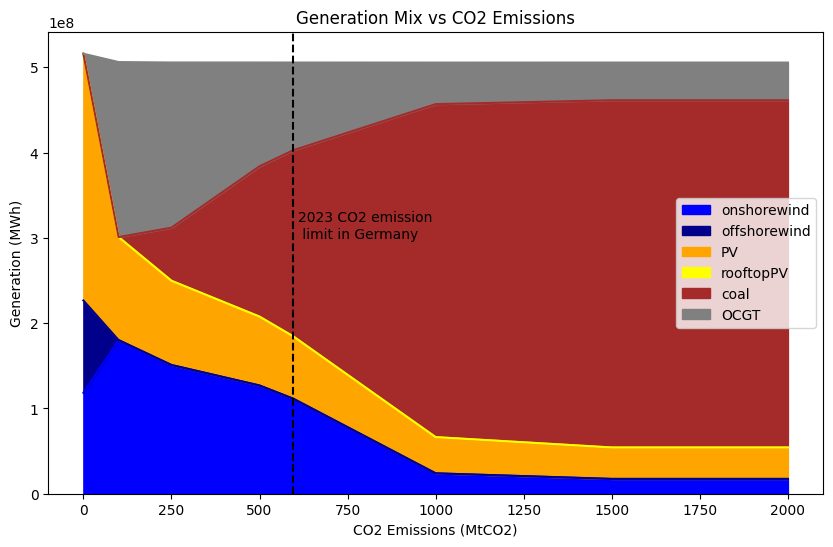

In [ ]:
results = pd.DataFrame(
    np.array([onwind, offwind, pv, rooftop, coal, ocgt]).T,
    columns=["onshorewind", "offshorewind", "PV", "rooftopPV", "coal", "OCGT"],
    index=co2_index,
)
results.plot.area(
    stacked=True,
    title="Generation Mix vs CO2 Emissions",
    ylabel="Generation (MWh)",
    xlabel="CO2 Emissions (MtCO2)",
    color=colors,
    figsize=(10, 6),
)
plt.vlines(
    596, 0, 6e8, color="black", linestyle="--", label="2023 CO2 emission limit"
)
plt.text(
    610, 3e8, "2023 CO2 emission\n limit in Germany", color="black", fontsize=10, ha="left"
)


<AxesSubplot: title={'center': 'Generation Capacity vs CO2 Emissions'}, xlabel='CO2 Emissions (MtCO2)', ylabel='Generation Capacity (MW)'>

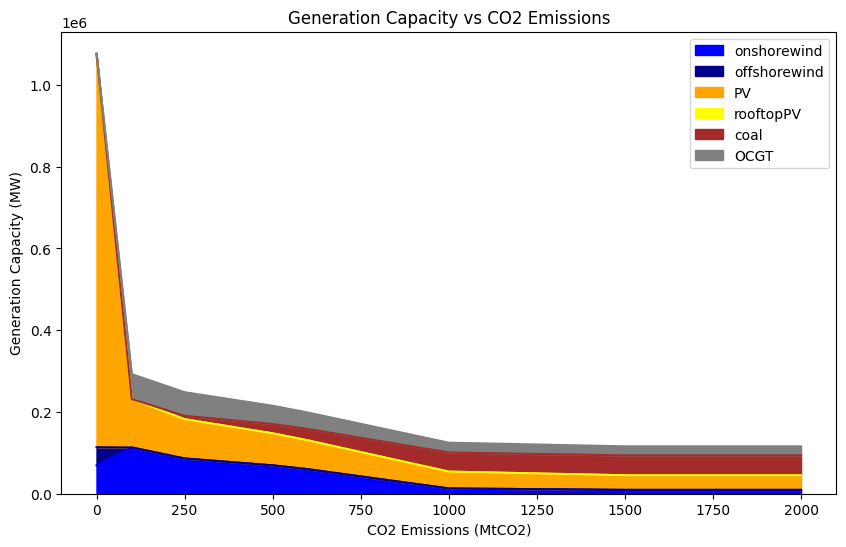

In [ ]:
results_cap = pd.DataFrame(
    np.array([onwind_cap, offwind_cap, pv_cap, rooftop_cap, coal_cap, ocgt_cap]).T,
    columns=["onshorewind", "offshorewind", "PV", "rooftopPV", "coal", "OCGT"],
    index=co2_index,
)
results_cap.plot.area(
    stacked=True,
    title="Generation Capacity vs CO2 Emissions",
    ylabel="Generation Capacity (MW)",
    xlabel="CO2 Emissions (MtCO2)",
    color=colors,
    figsize=(10, 6),
)

Text(0, 0.5, 'System Cost (million euros)')

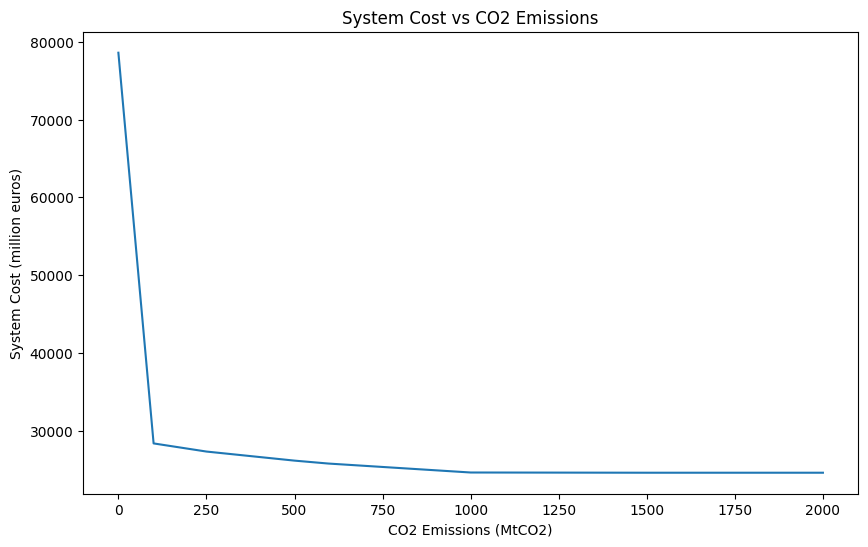

In [43]:
plt.figure(figsize=(10, 6))
plt.plot([2000, 1500, 1000, 596, 500, 250, 100, 0], systemcost)
plt.title("System Cost vs CO2 Emissions")
plt.xlabel("CO2 Emissions (MtCO2)")
plt.ylabel("System Cost (million euros)")

Text(0, 0.5, 'CO2 Tax (EUR/tCO2)')

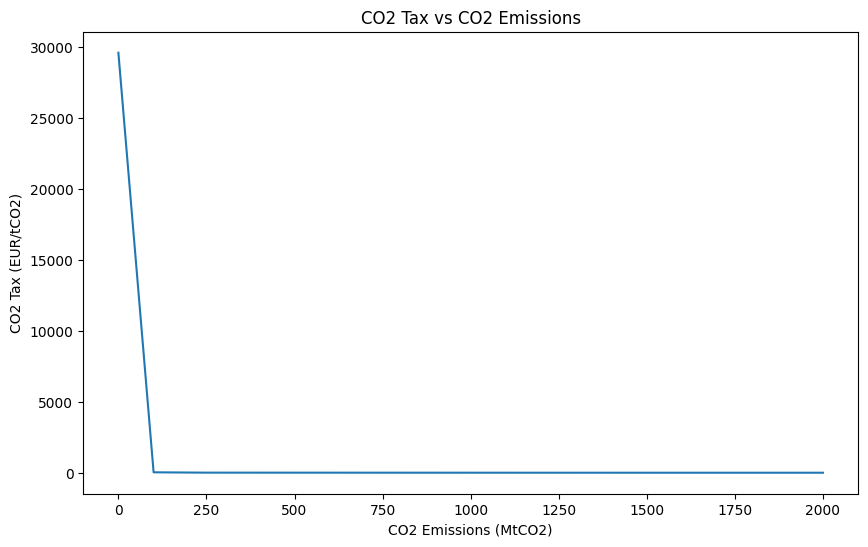

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(co2_index, co2_tax)
plt.title("CO2 Tax vs CO2 Emissions")
plt.xlabel("CO2 Emissions (MtCO2)")
plt.ylabel("CO2 Tax (EUR/tCO2)")